# Grape diseases and pests classification

**Chi Tran - CMPE 257**

## Data structure

I will apply an unsupervised machine learning model to recognize and classify the images. Therefore, Keras ImageDataGenerator is the best choice. As mentioned on the website: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720, my data will be divided into sub-folders that corresponding to image classes under train, validation, and test folders.

<p align='center'>
  ![](https://cdn-images-1.medium.com/max/800/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)
</p>

In [4]:
from __future__ import (absolute_import, 
                        division, 
                        print_function, 
                        unicode_literals)

import os
import glob
import time
import numpy as np
import pandas as pd
import math
import seaborn as sns
import random
import shutil
import pylab
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import tensorflow as tf
import h5py
from keras import models, layers, optimizers 
from keras.models import load_model
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.applications import imagenet_utils
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

# Set random seed for consistency
random.seed(150)
np.random.seed(150)
tf.random.set_seed(150)

# Displays all outputs of a cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 6]

print('TensorFlow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)


TensorFlow version: 2.2.0
Keras version: 2.3.0-tf


In [5]:
# Set up main folders to store original images, binary data, and trained models
root = '.'
data = os.path.join(root, 'img_data')
bin_data= os.path.join(root, 'bin_data')
trained_models = os.path.join(root, 'trained_models')

# Original images
phylloxera_fold = os.path.join(data, 'phylloxera')
mealybug_fold = os.path.join(data, 'mealybug')
b_measles_fold = os.path.join(data, 'black_measles')
b_rot_fold = os.path.join(data, 'black_rot')
leaf_blight_fold = os.path.join(data, 'leaf_blight')
healthy = os.path.join(data, 'healthy')

# Define train, validation, and test folders
train_fold = os.path.join(data, 'train')
val_fold = os.path.join(data, 'validation')
test_fold = os.path.join(data, 'test')

# Create sub-folders for each class in train folder
train_phylloxera = os.path.join(train_fold, 'phylloxera')
train_mealybug = os.path.join(train_fold, 'mealybug')
train_b_measles = os.path.join(train_fold, 'black_measles')
train_b_rot = os.path.join(train_fold, 'black_rot')
train_leaf_blight = os.path.join(train_fold, 'leaf_blight')
train_healthy = os.path.join(train_fold, 'healthy')

# Create sub-folders for each class in validation folder
val_phylloxera = os.path.join(val_fold, 'phylloxera')
val_mealybug = os.path.join(val_fold, 'mealybug')
val_b_measles = os.path.join(val_fold, 'black_measles')
val_b_rot = os.path.join(val_fold, 'black_rot')
val_leaf_blight = os.path.join(val_fold, 'leaf_blight')
val_healthy = os.path.join(val_fold, 'healthy')

# Create sub-folders for each class in test folder
test_phylloxera = os.path.join(test_fold, 'phylloxera')
test_mealybug = os.path.join(test_fold, 'mealybug')
test_b_measles = os.path.join(test_fold, 'black_measles')
test_b_rot = os.path.join(test_fold, 'black_rot')
test_leaf_blight = os.path.join(test_fold, 'leaf_blight')
test_healthy = os.path.join(test_fold, 'healthy')


## Build Dataset from original data

In [7]:
# Create folders to store original images, binary data, and trained models
os.mkdir(data)
os.mkdir(bin_data)
os.mkdir(trained_models)

# Create train, validation, and test folders
os.mkdir(train_fold)
os.mkdir(val_fold)
os.mkdir(test_fold)

# Create sub-folders for each class inside the train folder
os.mkdir(train_phylloxera)
os.mkdir(train_mealybug)
os.mkdir(train_b_measles)
os.mkdir(train_b_rot)
os.mkdir(train_leaf_blight)
os.mkdir(train_healthy)

# Create sub-folders for each class inside the validation folder
os.mkdir(val_phylloxera)
os.mkdir(val_mealybug)
os.mkdir(val_b_measles)
os.mkdir(val_b_rot)
os.mkdir(val_leaf_blight)
os.mkdir(val_healthy)

# Create sub-folders for each class inside the test folder
os.mkdir(test_phylloxera)
os.mkdir(test_mealybug)
os.mkdir(test_b_measles)
os.mkdir(test_b_rot)
os.mkdir(test_leaf_blight)
os.mkdir(test_healthy)

### Collect Images in each class

In [6]:
total_phylloxera = len(os.listdir(phylloxera_fold))
total_mealybug = len(os.listdir(mealybug_fold))
total_b_measles = len(os.listdir(b_measles_fold))
total_b_rot = len(os.listdir(b_rot_fold))
total_leaf_blight = len(os.listdir(leaf_blight_fold))
total_healthy = len(os.listdir(healthy))

total_images = total_phylloxera + total_mealybug + total_b_measles + total_b_rot + total_leaf_blight + total_healthy
                                   
print('Total Images: {}'.format(total_images))
print('There are {} images in phylloxera class'.format(total_phylloxera))
print('There are {} images in mealybug class'.format(total_mealybug))
print('There are {} images in black measles class'.format(total_b_measles))
print('There are {} images in black rot class'.format(total_b_rot))
print('There are {} images in leaf blight class'.format(total_leaf_blight))
print('There are {} images in healthy class'.format(total_healthy))


Total Images: 1250
There are 200 images in phylloxera class
There are 534 images in mealybug class
There are 120 images in black measles class
There are 120 images in black rot class
There are 156 images in leaf blight class
There are 120 images in healthy class


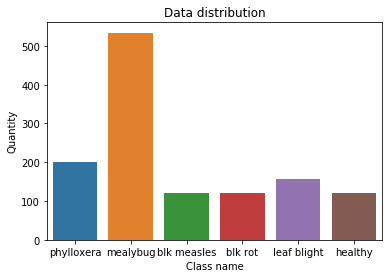

In [10]:
# Show data distribution using bar charts
data_col = pd.DataFrame.from_dict(data={ 'phylloxera': [total_phylloxera],
                                        'mealybug': [total_mealybug],
                                         'blk measles': [total_b_measles],
                                          'blk rot': [total_b_rot],
                                          'leaf blight': [total_leaf_blight],
                                          'healthy': [total_healthy]
                                          } )
sns.barplot(data=data_col);
plt.xlabel('Class name');
plt.ylabel('Quantity');
plt.title('Data distribution');

### Rename Images
The model may not be able to read a file with a very long name, so that all images should be named using a naming convention.

In [11]:
def rename_images(path, image_class):
  """
  Standardize file names.
  @param path - the path to the image directory
  @param image_class - name of the image class, such as black measles or black rot
  """
  for i, image in enumerate(os.listdir(path)):
    name = image_class + str(i) + '.jpg'
    source = os.path.join(path, image)
    dest = os.path.join(path, name)
    os.rename(source, dest)
  print('Finish renaming.')

In [63]:
# Rename images in each folder
rename_images(phylloxera_fold, image_class='phylloxera')
rename_images(mealybug_fold, image_class='mealybug')
rename_images(b_measles_fold, image_class='black_measles')
rename_images(b_rot_fold, image_class='black_rot')
rename_images(leaf_blight_fold, image_class='leaf_blight')
rename_images(healthy, image_class='healthy')


FileExistsError: [WinError 183] Cannot create a file when that file already exists: '.\\data\\black_measles\\black_measles10.jpg' -> '.\\data\\black_measles\\black_measles2.jpg'

### Shuffle and split data into train, validation and test folder

Data will be splited based on the following rule: 80% of data for training and 20% for test. Afterwards, the training set will be divided into 80% training and 20% validation.

In [12]:
def train_test_split_data(data_source, class_name, val_size=0.2, test_size=0.2):
  
  assert class_name in ['phylloxera', 'mealybug', 'black_measles', 'black_rot', 'leaf_blight', 'healthy'], \
    "Class name is invalid!"
  
  train_folder = os.path.join(data_source, 'train', class_name)
  val_folder = os.path.join(data_source, 'validation', class_name)
  test_folder = os.path.join(data_source, 'test', class_name)
  
  assert len(os.listdir(train_folder)) == 0, "Training directory must be empty."
  assert len(os.listdir(val_folder)) == 0, "Validation directory must be empty."
  assert len(os.listdir(test_folder)) == 0, "Test directory must be empty."
  
  path = os.path.join(data_source, class_name)
  total = len(os.listdir(path))
  
  # Shuffle the data
  data = os.listdir(path)
  random.shuffle(data)
  
  # Split train and test data: 80-20
  total_train = math.floor(total*0.8)
  total_test = total - total_train
  
  # Split train-validation data from train data: 80-20
  total_val = math.floor(total_train*0.2)
  total_train = total_train - total_val
  
  # Set data index
  train_dat = data[:total_train]
  val_dat = data[total_train:total_train+total_val]
  test_dat = data[total_train+total_val:]
    
  # Copy training data
  for file in train_dat:
    source = os.path.join(data_source, class_name, file)
    dest = os.path.join(train_folder, file)
    shutil.copyfile(source, dest)
    
  # Copy validation data
  for file in val_dat:
    source = os.path.join(data_source, class_name, file)
    dest = os.path.join(val_folder, file)
    shutil.copyfile(source, dest)
    
  # Copy test data
  for file in test_dat:
    source = os.path.join(data_source, class_name, file)
    dest = os.path.join(test_folder, file)
    shutil.copyfile(source, dest)

### Split data

In [13]:
for class_name in ['phylloxera', 'mealybug', 'black_measles', 'black_rot', 'leaf_blight', 'healthy']:
  train_test_split_data(data, class_name)

Checking data allocation after spliting

In [7]:
# Checking data
total_train_phylloxera = len(os.listdir(train_phylloxera))
total_train_mealybug = len(os.listdir(train_mealybug))
total_train_b_measles = len(os.listdir(train_b_measles))
total_train_b_rot = len(os.listdir(train_b_rot))
total_train_leaf_blight = len(os.listdir(train_leaf_blight))
total_train_healthy = len(os.listdir(train_healthy))

total_valid_phylloxera = len(os.listdir(val_phylloxera))
total_valid_mealybug = len(os.listdir(val_mealybug))
total_valid_b_measles = len(os.listdir(val_b_measles))
total_valid_b_rot = len(os.listdir(val_b_rot))
total_valid_leaf_blight = len(os.listdir(val_leaf_blight))
total_valid_healthy = len(os.listdir(val_healthy))

total_test_phylloxera = len(os.listdir(test_phylloxera))
total_test_mealybug = len(os.listdir(test_mealybug))
total_test_b_measles = len(os.listdir(test_b_measles))
total_test_b_rot = len(os.listdir(test_b_rot))
total_test_leaf_blight = len(os.listdir(test_leaf_blight))
total_test_healthy = len(os.listdir(test_healthy))

total_train = total_train_b_measles + total_train_b_rot + \
                total_train_leaf_blight + total_train_healthy + total_train_phylloxera + total_train_mealybug
total_valid = total_valid_b_measles + total_valid_b_rot + \
              total_valid_leaf_blight + total_valid_healthy + total_valid_phylloxera + total_valid_mealybug
total_test = total_test_b_measles + total_test_b_rot + \
              total_test_leaf_blight + total_test_healthy + total_test_phylloxera + total_test_mealybug

def check_dist(total, phylloxera, mealybug, black_measles, black_rot, leaf_blight, healthy):
  print('Phylloxera class occupies: {:.2f}%'.format((phylloxera / total)*100.0))
  print('Mealybug class occupies: {:.2f}%'.format((mealybug / total)*100.0))
  print('Black measles class occupies: {:.2f}%'.format((black_measles/total)*100.0))
  print('Black rot class occupies: {:.2f}%'.format((black_rot / total)*100))
  print('Left blight class occupies: {:.2f}%'.format((leaf_blight / total)*100.0))
  print('Healthy class occupies: {:.2f}%'.format((healthy / total)*100.0))
  print()
  
print('Total images:', total_train + total_valid + total_test)
print('Total phylloxera:', total_train_phylloxera + total_valid_phylloxera + total_test_phylloxera)
print('Total mealybug:', total_train_mealybug + total_valid_mealybug + total_test_mealybug)
print('Total black measles:', total_train_b_measles + total_valid_b_measles + total_test_b_measles)
print('Total black rot:', total_train_b_rot + total_valid_b_rot + total_test_b_rot)
print('Total leaf blight:', total_train_leaf_blight + total_valid_leaf_blight + total_test_leaf_blight)
print('Total healthy:', total_train_healthy + total_valid_healthy + total_test_healthy)
print()

print('Total of training phylloxera images:', total_train_phylloxera)
print('Total of training mealybug images:', total_train_mealybug)
print('Total of training black measles images:', total_train_b_measles)
print('Total of training black rot images:', total_train_b_rot)
print('Total of training leaf blight images:', total_train_leaf_blight)
print('Total of training healthy images:', total_train_healthy)
print()

print('Total of validation phylloxera images:', total_valid_phylloxera)
print('Total of validation mealybug images:', total_valid_mealybug)
print('Total of validation black measles images:', total_valid_b_measles)
print('Total of validation black rot images:', total_valid_b_rot)
print('Total of validation leaf blight images:', total_valid_leaf_blight)
print('Total of validation healthy images:', total_valid_healthy)
print()

print('Total of test phylloxera images:', total_test_phylloxera)
print('Total of test mealybug images:', total_test_mealybug)
print('Total of test black measles images:', total_test_b_measles)
print('Total of test black rot images:', total_test_b_rot)
print('Total of test leaf blight images:', total_test_leaf_blight)
print('Total of test healthy images:', total_test_healthy)
print()

print('Training distribution')
check_dist(total_train, total_train_b_measles, total_train_b_rot,
                    total_train_leaf_blight, total_train_healthy, total_train_phylloxera, total_train_mealybug)
print('Validation distribution')
check_dist(total_valid, total_valid_b_measles, total_valid_b_rot,
                    total_valid_leaf_blight, total_valid_healthy, total_valid_phylloxera, total_valid_mealybug)
print('Test distribution')
check_dist(total_test, total_test_b_measles, total_test_b_rot,
                    total_test_leaf_blight, total_test_healthy, total_test_phylloxera, total_test_mealybug)


Total images: 1250
Total phylloxera: 200
Total mealybug: 534
Total black measles: 120
Total black rot: 120
Total leaf blight: 156
Total healthy: 120

Total of training phylloxera images: 128
Total of training mealybug images: 342
Total of training black measles images: 77
Total of training black rot images: 77
Total of training leaf blight images: 100
Total of training healthy images: 77

Total of validation phylloxera images: 32
Total of validation mealybug images: 85
Total of validation black measles images: 19
Total of validation black rot images: 19
Total of validation leaf blight images: 24
Total of validation healthy images: 19

Total of test phylloxera images: 40
Total of test mealybug images: 107
Total of test black measles images: 24
Total of test black rot images: 24
Total of test leaf blight images: 32
Total of test healthy images: 24

Training distribution
Phylloxera class occupies: 9.61%
Mealybug class occupies: 9.61%
Black measles class occupies: 12.48%
Black rot class oc

## Data Analysis

### Observe Data Images

In [15]:
def read_data(path, size):
  img = image.load_img(path, target_size=size)
  img = image.img_to_array(img)
  return img

C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


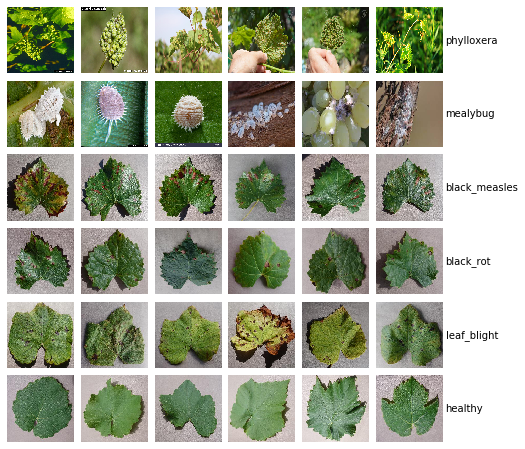

In [16]:
CATE = ['phylloxera', 'mealybug', 'black_measles', 'black_rot', 'leaf_blight', 'healthy']
NUM_CATE = len(CATE)
img_height, img_width = 256, 256

# Create image grid
figure = plt.figure(num=1, figsize=(8,8))
grid = ImageGrid(figure, 111, nrows_ncols=(NUM_CATE,NUM_CATE),
                 axes_pad=0.1) 

# Plot each image into a square
i = 0
for cate in CATE:
  for j in range(6):
    ax = grid[i]
    path = os.path.join(data, cate)
    pic = cate + str(j) + '.jpg'
    im = read_data(os.path.join(path, pic), size=(img_height, img_width))
    ax.imshow(im/255., interpolation='nearest', aspect='auto')
    ax.axis('off')
    if i % NUM_CATE == NUM_CATE - 1:
      ax.text(x=img_height*1.05, y=img_height//2, s=cate, verticalalignment='center')
    i += 1

figure.show();

## Load images into numpy arrays

In [17]:
# Read all phylloxera images into numpy array
phylloxera_numpy = [read_data(os.path.join(train_phylloxera, img),\
               (256, 256)) for img in os.listdir(train_phylloxera)]

# Read all mealybug images into numpy array
mealybug_numpy = [read_data(os.path.join(train_mealybug, img),\
               (256, 256)) for img in os.listdir(train_mealybug)]


# Read all black measles images into numpy array
b_measles_numpy = [read_data(os.path.join(train_b_measles, img), \
                    (256, 256)) for img in os.listdir(train_b_measles)]

# Read all black rot images into numpy array
b_rot_numpy = [read_data(os.path.join(train_b_rot, img), \
                 (256, 256)) for img in os.listdir(train_b_rot)]

# Read all leaf blight images into numpy array
leaf_blight_numpy = [read_data(os.path.join(train_leaf_blight, img), \
                   (256, 256)) for img in os.listdir(train_leaf_blight)]

# Read all healthy images into numpy array
healthy_numpy = [read_data(os.path.join(train_healthy, img),\
               (256, 256)) for img in os.listdir(train_healthy)]


# Save numpy arrays into a folder
np.save(os.path.join(bin_data, 'phylloxera.npy'), arr=phylloxera_numpy)
np.save(os.path.join(bin_data, 'mealybug.npy'), arr=mealybug_numpy)
np.save(os.path.join(bin_data, 'black_measles.npy'), arr=b_measles_numpy)
np.save(os.path.join(bin_data, 'black_rot.npy'), arr=b_rot_numpy)
np.save(os.path.join(bin_data, 'leaf_blight.npy'), arr=leaf_blight_numpy)
np.save(os.path.join(bin_data, 'healthy.npy'), arr=healthy_numpy)


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [18]:
# Load numpy arrays from the folder
phylloxera_numpy = np.load(os.path.join(bin_data, 'phylloxera.npy'))
mealybug_numpy = np.load(os.path.join(bin_data, 'mealybug.npy'))
b_measles_numpy = np.load(os.path.join(bin_data, 'black_measles.npy'))
b_rot_numpy = np.load(os.path.join(bin_data, 'black_rot.npy'))
leaf_blight_numpy = np.load(os.path.join(bin_data, 'leaf_blight.npy'))
healthy_numpy = np.load(os.path.join(bin_data, 'healthy.npy'))

In [21]:
# Reshape numpy arrays into sizes of 256x256x3 as input data
phylloxera_numpy = phylloxera_numpy.reshape(128, 256*256*3)
mealybug_numpy = mealybug_numpy.reshape(342, 256*256*3)
b_measles_numpy = b_measles_numpy.reshape(77, 256*256*3)
b_rot_numpy = b_rot_numpy.reshape(77, 256*256*3)
leaf_blight_numpy = leaf_blight_numpy.reshape(100, 256*256*3)
healthy_numpy = healthy_numpy.reshape(77, 256*256*3)

### Visualize data

In [8]:
def pca(X=np.array([]), num_dimensions=60):
  """
  Runs PCA on an array X to reduce its dimensonality to 
  num_dimensions dimensions.
  
  """
  print('Running PCA ...')
  mean_vector = np.mean(a=X, axis=0)
  X_cov = (X-mean_vec).T.dot(X-mean_vec) / (X.shape[0]-1)
  eig_vals, eig_vectors = np.linalg.eig(X_cov.T)
  idx = np.argsort(np.abs(eig_vals))[::-1]
  eig_vectors = eig_vectors[:, idx]
  Y = np.dot(X, eig_vectors[:, 0:num_dimensions])
  return Y

def plot_scatter(x, class_name):
  """
  Function to create a scatter plot for visualization of data
  along with respective colors/labels.
 
  """
  no_class = len(np.unique(class_name))
  color_palette = np.array(sns.color_palette('Set2', no_class))
  f = plt.figure(figsize=(15,15))
  ax = plt.subplot(aspect='equal')
  for i, pic_label in enumerate(np.unique(class_name)):
    idx = np.where(class_name == pic_label)
    ax.scatter(x[idx,0], x[idx,1], s=30, alpha=0.6, 
                    c=[color_palette[i]], label=pic_label)
  ax.legend(loc='best', fontsize='medium')
  ax.axis('off')
  ax.axis('tight')
  plt.title('Visualization of grape diseases and pests in 2D')

In [23]:
# Create data labels for all classes in 1D
phylloxera_label = np.full(phylloxera_numpy.shape[0], 'phylloxera')
mealybug_label = np.full(mealybug_numpy.shape[0], 'mealybug')
b_measles_label = np.full(b_measles_numpy.shape[0], 'black_measles')
b_rot_label = np.full(b_rot_numpy.shape[0], 'black_rot')
leaf_blight_label = np.full(leaf_blight_numpy.shape[0], 'leaf_blight')
healthy_label = np.full(healthy_numpy.shape[0], 'healthy')

labels = (phylloxera_label, mealybug_label, b_measles_label, b_rot_label, leaf_blight_label, healthy_label)
labels = np.hstack(labels) 

In [24]:
# Create a stack of numpy arrays 
tuple_data = (phylloxera_numpy, mealybug_numpy, b_measles_numpy, b_rot_numpy, leaf_blight_numpy, healthy_numpy)

# normalize tuple data
nomalized_data = np.vstack(tup=tuple_data)/255. 

In [25]:
# Run PCA on nomalized data
start_time = time.time()
pca = PCA(n_components=60)
nomalized_data_pca = pca.fit_transform(nomalized_data)
end_time = time.time()

print('This process took {:.2f} seconds.'.format(end_time-start_time))

This process took 8.49 seconds.


In [26]:
# Run t-SNE on data
start_time = time.time()
tsne = TSNE(n_components=2)
nomalized_data_tsne = tsne.fit_transform(nomalized_data_pca)
end_time = time.time()

print('This process took {:.2f} seconds'.format(end_time-start_time))

This process took 5.46 seconds


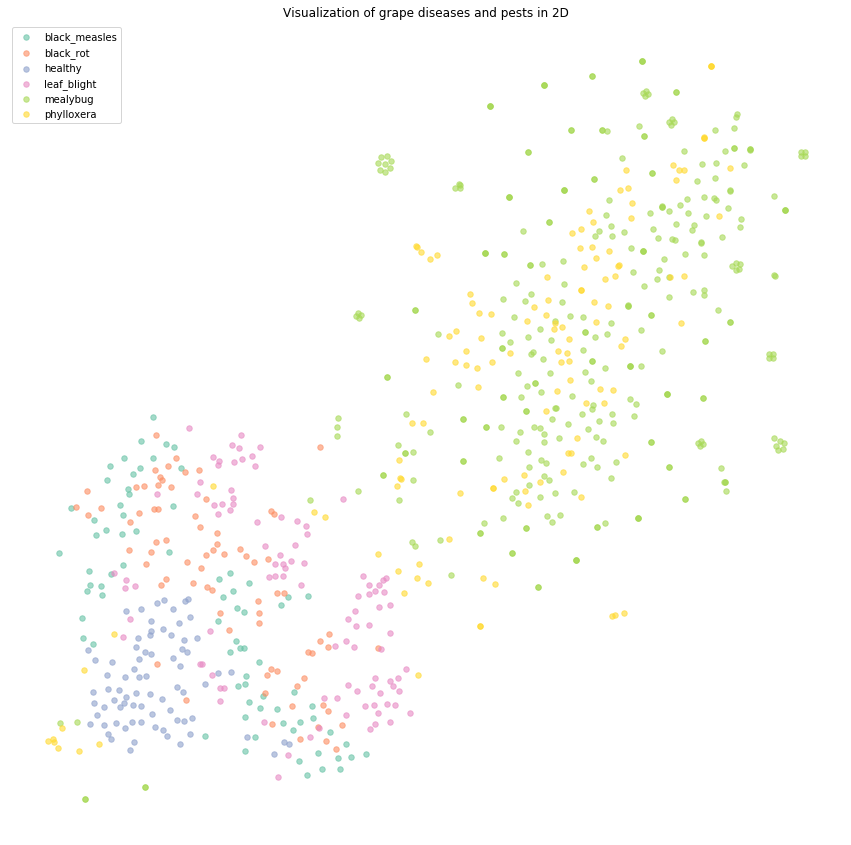

In [27]:
# Visualize data
plot_scatter(nomalized_data_tsne, labels);

## Training data

### Libraries

In [9]:
def draw_acc_loss(points, factor=0.9):
  
  drawed_points = []
  for point in points:
    if drawed_points:
      prev = drawed_points[-1]
      drawed_points.append(prev * factor + point * (1 - factor))
    else:
      drawed_points.append(point)
  return drawed_points

def plot_data(history_data, smooth=False):

  accuracy = history.history['acc']
  validation_acc = history.history['val_acc']
  loss = history.history['loss']
  validation_loss = history.history['val_loss']

  epochs = range(1, len(accuracy)+1)
  
  if smooth == True:
    accuracy = draw_acc_loss(accuracy)
    validation_acc = draw_acc_loss(validation_acc)
    loss = draw_acc_loss(loss)
    validation_loss = draw_acc_loss(validation_loss)

  plt.plot(epochs, accuracy, 'g', label='Training accuracy')
  plt.plot(epochs, validation_acc,'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'g', label='Training loss')
  plt.plot(epochs, validation_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
def collect_metrics(model, generator, steps, class_names=[]):
  """
  Print out confusion matrix and classification report.
  """
  class_names = ['black_measles', 'black_rot', 'healthy', 'leaf_blight', 'mealybug', 'phylloxera']
  abbr = ['BM', 'BR', 'H', 'LB', 'M', 'P']
  
  # Generate predictions 
  y_pred = model.predict_generator(generator=generator, steps=steps)
  y_pred = np.argmax(a=y_pred, axis=1)
  
  # Generate confusion matrix
  con_matrix = confusion_matrix(y_true=generator.classes, y_pred=y_pred)
  fig, ax = plt.subplots(1)
  ax = sns.heatmap(con_matrix, ax=ax, cmap=plt.cm.YlOrRd, annot=True, fmt='g')
  ax.set_xticklabels(abbr)
  ax.set_yticklabels(abbr)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Class')
  plt.ylabel('Real Class')
  plt.show()
  
  # Generate classification report
  print('Classification Report')
  print(classification_report(y_true=generator.classes, y_pred=y_pred, 
                              target_names=class_names))

### Set up hyper-parameters

In [10]:
image_height, image_width = 256, 256
batch_size = 30
epochs = 35

print('Total number of training data:', total_train)
print('Total number of validation data:', total_valid)
print('Total number of test data:', total_test)

Total number of training data: 801
Total number of validation data: 198
Total number of test data: 251


### Training from Scratch

In [44]:
model = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', \
                  input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=6, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 128)      

In [45]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

Training data using Keras ImageDataGenerator. Refer to the source on the website: https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [46]:
# Rescale data
training_datagenerator = ImageDataGenerator(rescale=1./255)
test_datagenerator = ImageDataGenerator(rescale=1./255)

training_gen = training_datagenerator.flow_from_directory(
                    train_fold,
                    target_size=(image_height, image_width),
                    color_mode='rgb',
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=30)

valid_gen = test_datagenerator.flow_from_directory(
                          val_fold,
                          target_size=(image_height, image_width),
                          color_mode='rgb',
                          batch_size=batch_size,
                          class_mode='categorical')

Found 801 images belonging to 6 classes.
Found 198 images belonging to 6 classes.


In [36]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

from keras.callbacks import TensorBoard

# Define the Keras TensorBoard callback.
logdir="logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch=0)
    

In [48]:
#Scratch training
history = model.fit(
            training_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=valid_gen,
            validation_steps=total_valid // batch_size,
            callbacks=[tensorboard_callback])

Epoch 1/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 87s 3s/step - loss: 1.5960 - acc: 0.4293 - val_loss: 0.9050 - val_acc: 0.6444
Epoch 2/35
 2/26 [=>............................] - ETA: 1:13 - loss: 1.0375 - acc: 0.5833

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 79s 3s/step - loss: 0.7571 - acc: 0.6744 - val_loss: 0.7111 - val_acc: 0.7560
Epoch 3/35
14/26 [===============>..............] - ETA: 34s - loss: 0.6246 - acc: 0.7595

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 79s 3s/step - loss: 0.6142 - acc: 0.7613 - val_loss: 0.5030 - val_acc: 0.7976
Epoch 4/35
 2/26 [=>............................] - ETA: 1:16 - loss: 0.6442 - acc: 0.7333

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 80s 3s/step - loss: 0.4949 - acc: 0.7886 - val_loss: 0.4897 - val_acc: 0.7917
Epoch 5/35
 4/26 [===>..........................] - ETA: 1:07 - loss: 0.4437 - acc: 0.8167

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 80s 3s/step - loss: 0.3756 - acc: 0.8392 - val_loss: 0.2823 - val_acc: 0.8571
Epoch 6/35
 6/26 [=====>........................] - ETA: 1:04 - loss: 0.4475 - acc: 0.8222

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 82s 3s/step - loss: 0.4140 - acc: 0.8500 - val_loss: 0.4190 - val_acc: 0.8571
Epoch 7/35
 5/26 [====>.........................] - ETA: 57s - loss: 0.3402 - acc: 0.8865

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 79s 3s/step - loss: 0.3293 - acc: 0.8781 - val_loss: 0.5733 - val_acc: 0.8214
Epoch 8/35
 9/26 [=========>....................] - ETA: 49s - loss: 0.2758 - acc: 0.8927

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 79s 3s/step - loss: 0.2332 - acc: 0.9134 - val_loss: 0.2542 - val_acc: 0.9167
Epoch 9/35
10/26 [==========>...................] - ETA: 47s - loss: 0.1709 - acc: 0.9167

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 82s 3s/step - loss: 0.1305 - acc: 0.9429 - val_loss: 0.1078 - val_acc: 0.8512
Epoch 10/35
16/26 [=================>............] - ETA: 29s - loss: 0.1192 - acc: 0.9563

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 81s 3s/step - loss: 0.1082 - acc: 0.9577 - val_loss: 0.2442 - val_acc: 0.9286
Epoch 11/35
14/26 [===============>..............] - ETA: 34s - loss: 0.0988 - acc: 0.9552

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 81s 3s/step - loss: 0.0982 - acc: 0.9593 - val_loss: 0.2138 - val_acc: 0.8869
Epoch 12/35
10/26 [==========>...................] - ETA: 45s - loss: 0.0925 - acc: 0.9700

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 94s 4s/step - loss: 0.0930 - acc: 0.9679 - val_loss: 0.5698 - val_acc: 0.8690
Epoch 13/35
11/26 [===========>..................] - ETA: 53s - loss: 0.0896 - acc: 0.9688

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 100s 4s/step - loss: 0.0758 - acc: 0.9724 - val_loss: 0.2760 - val_acc: 0.8810
Epoch 14/35
13/26 [==============>...............] - ETA: 47s - loss: 0.0661 - acc: 0.9795

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 103s 4s/step - loss: 0.0541 - acc: 0.9846 - val_loss: 0.1499 - val_acc: 0.9167
Epoch 15/35
26/26 [==============================] - 88s 3s/step - loss: 0.1009 - acc: 0.9711 - val_loss: 0.3650 - val_acc: 0.9278
Epoch 16/35
 3/26 [==>...........................] - ETA: 1:09 - loss: 0.0366 - acc: 0.9778

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 81s 3s/step - loss: 0.0442 - acc: 0.9818 - val_loss: 0.4851 - val_acc: 0.8631
Epoch 17/35
 1/26 [>.............................] - ETA: 1:09 - loss: 0.0190 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


16/26 [=================>............] - ETA: 28s - loss: 0.0099 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 79s 3s/step - loss: 0.0079 - acc: 1.0000 - val_loss: 0.5043 - val_acc: 0.9286
Epoch 18/35
20/26 [======================>.......] - ETA: 17s - loss: 0.0024 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 80s 3s/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.5771 - val_acc: 0.9048
Epoch 19/35
24/26 [==========================>...] - ETA: 5s - loss: 8.3575e-04 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 79s 3s/step - loss: 8.0392e-04 - acc: 1.0000 - val_loss: 0.0469 - val_acc: 0.9286
Epoch 20/35
23/26 [=========================>....] - ETA: 8s - loss: 6.3607e-04 - acc: 1.0000 

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 79s 3s/step - loss: 5.9040e-04 - acc: 1.0000 - val_loss: 0.4408 - val_acc: 0.8869
Epoch 21/35
26/26 [==============================] - 80s 3s/step - loss: 4.3376e-04 - acc: 1.0000 - val_loss: 0.6491 - val_acc: 0.9107
Epoch 22/35
 5/26 [====>.........................] - ETA: 1:02 - loss: 4.3985e-04 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 81s 3s/step - loss: 3.9072e-04 - acc: 1.0000 - val_loss: 0.3135 - val_acc: 0.8944
Epoch 23/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 80s 3s/step - loss: 2.4180e-04 - acc: 1.0000 - val_loss: 0.5924 - val_acc: 0.9107
Epoch 24/35
 1/26 [>.............................] - ETA: 1:08 - loss: 1.2516e-04 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 79s 3s/step - loss: 2.4712e-04 - acc: 1.0000 - val_loss: 0.2731 - val_acc: 0.9226
Epoch 25/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 79s 3s/step - loss: 1.7516e-04 - acc: 1.0000 - val_loss: 0.9176 - val_acc: 0.9048
Epoch 26/35
11/26 [===========>..................] - ETA: 43s - loss: 1.7589e-04 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 80s 3s/step - loss: 1.5766e-04 - acc: 1.0000 - val_loss: 0.1782 - val_acc: 0.8929
Epoch 27/35
 3/26 [==>...........................] - ETA: 1:04 - loss: 7.4518e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


25/26 [===========================>..] - ETA: 2s - loss: 1.4742e-04 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 81s 3s/step - loss: 1.4424e-04 - acc: 1.0000 - val_loss: 0.3457 - val_acc: 0.9167
Epoch 28/35
26/26 [==============================] - 79s 3s/step - loss: 1.2776e-04 - acc: 1.0000 - val_loss: 0.3622 - val_acc: 0.8988
Epoch 29/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 80s 3s/step - loss: 1.2129e-04 - acc: 1.0000 - val_loss: 0.1874 - val_acc: 0.8944
Epoch 30/35
 1/26 [>.............................] - ETA: 1:08 - loss: 7.4334e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 82s 3s/step - loss: 9.1523e-05 - acc: 1.0000 - val_loss: 0.8008 - val_acc: 0.9107
Epoch 31/35
13/26 [==============>...............] - ETA: 38s - loss: 1.2530e-04 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 79s 3s/step - loss: 9.4556e-05 - acc: 1.0000 - val_loss: 0.8210 - val_acc: 0.8929
Epoch 32/35
 3/26 [==>...........................] - ETA: 1:04 - loss: 1.2209e-04 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 80s 3s/step - loss: 9.4301e-05 - acc: 1.0000 - val_loss: 0.6893 - val_acc: 0.9107
Epoch 33/35
 4/26 [===>..........................] - ETA: 1:02 - loss: 7.2245e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 80s 3s/step - loss: 8.1063e-05 - acc: 1.0000 - val_loss: 1.0240 - val_acc: 0.9048
Epoch 34/35
13/26 [==============>...............] - ETA: 38s - loss: 7.9737e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 81s 3s/step - loss: 6.9776e-05 - acc: 1.0000 - val_loss: 0.0619 - val_acc: 0.9226
Epoch 35/35
18/26 [===================>..........] - ETA: 23s - loss: 7.3714e-05 - acc: 1.0000

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 80s 3s/step - loss: 6.8132e-05 - acc: 1.0000 - val_loss: 0.3812 - val_acc: 0.8929


In [49]:
# Save the trained model into the pre-defined folder
model.save(os.path.join(trained_models, 'diseasepest-scratch.h5'))

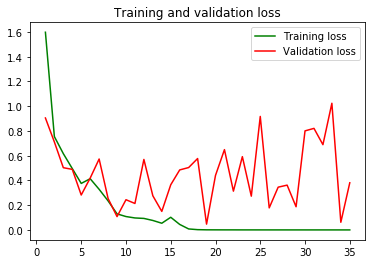

In [50]:
plot_data(history)

In [51]:
# Create a new validation generator for evaluation
valid_test_gen = test_datagenerator.flow_from_directory(
                val_fold,
                target_size=(image_height, image_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 198 images belonging to 6 classes.


In [52]:
# Observe all 6 classes
valid_test_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

Format of confusion matrix:

|  | Prediction |  |  |  |  |
| - | - | - | - | - | - |
| **True** | black_measles | black_rot | healthy | leaf_blight | mealybug | phylloxera | 
| black_measles | 
| black_rot | 
| healthy | 
| leaf_blight |
| mealybug |
| phylloxera | 

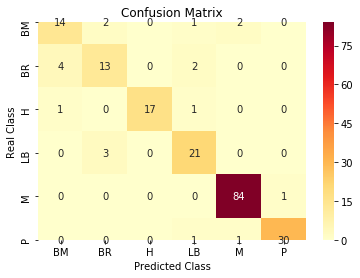

Classification Report
               precision    recall  f1-score   support

black_measles       0.74      0.74      0.74        19
    black_rot       0.72      0.68      0.70        19
      healthy       1.00      0.89      0.94        19
  leaf_blight       0.81      0.88      0.84        24
     mealybug       0.97      0.99      0.98        85
   phylloxera       0.97      0.94      0.95        32

     accuracy                           0.90       198
    macro avg       0.87      0.85      0.86       198
 weighted avg       0.90      0.90      0.90       198



In [53]:
# Load the trained model from the folder
model = load_model('diseasepest-scratch.h5')

# Display confusion matrix and classification report
collect_metrics(model, generator=valid_test_gen, steps=total_valid)

### Transfer Learning

In [11]:
# Import VGG16
from keras.applications import VGG16

conv_base = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(image_height, image_width, 3))

In [12]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [13]:
# Add more layers into the original VGG16 model
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 23,105,094
Trainable params: 23,105,094
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Freeze convolutional base
print('Trainable weights before freezing:', len(model.trainable_weights))
conv_base.trainable = False
print('Trainable weights after freezing:', len(model.trainable_weights))

Trainable weights before freezing: 30
Trainable weights after freezing: 4


In [15]:
# Generate training data using data augmentation
training_datageneration = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=45,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

# Rescale validation data
test_datageneration = ImageDataGenerator(rescale=1./255)

training_gen = training_datageneration.flow_from_directory(
                    train_fold,
                    target_size=(image_height, image_width),
                    color_mode='rgb',
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True, 
                    seed=50)

valid_gen = test_datageneration.flow_from_directory(
                          val_fold,
                          target_size=(image_height, image_width),
                          color_mode='rgb',
                          batch_size=batch_size,
                          class_mode='categorical')

model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

Found 801 images belonging to 6 classes.
Found 198 images belonging to 6 classes.


In [59]:
# Train VGG16 model
history = model.fit(
            training_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=valid_gen,
            validation_steps=total_valid // batch_size,
            callbacks=[tensorboard_callback]
)

Epoch 1/35
 7/26 [=======>......................] - ETA: 2:32 - loss: 6.2387 - acc: 0.3667

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 258s 10s/step - loss: 2.6667 - acc: 0.5564 - val_loss: 0.5458 - val_acc: 0.8333
Epoch 2/35
16/26 [=================>............] - ETA: 1:23 - loss: 0.6636 - acc: 0.7417

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 259s 10s/step - loss: 0.6202 - acc: 0.7526 - val_loss: 0.4274 - val_acc: 0.9107
Epoch 3/35
 2/26 [=>............................] - ETA: 2:47 - loss: 0.3987 - acc: 0.8824

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 253s 10s/step - loss: 0.4859 - acc: 0.8176 - val_loss: 0.3115 - val_acc: 0.8690
Epoch 4/35
18/26 [===================>..........] - ETA: 1:05 - loss: 0.4401 - acc: 0.8343

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 257s 10s/step - loss: 0.4044 - acc: 0.8482 - val_loss: 0.2858 - val_acc: 0.8929
Epoch 5/35
 3/26 [==>...........................] - ETA: 3:07 - loss: 0.3282 - acc: 0.8667

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 258s 10s/step - loss: 0.3939 - acc: 0.8436 - val_loss: 0.2459 - val_acc: 0.9405
Epoch 6/35
 6/26 [=====>........................] - ETA: 2:37 - loss: 0.3678 - acc: 0.8713

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 254s 10s/step - loss: 0.3849 - acc: 0.8586 - val_loss: 0.1748 - val_acc: 0.9286
Epoch 7/35
 6/26 [=====>........................] - ETA: 2:40 - loss: 0.4138 - acc: 0.8129

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 275s 11s/step - loss: 0.3599 - acc: 0.8583 - val_loss: 0.2382 - val_acc: 0.9345
Epoch 8/35
 6/26 [=====>........................] - ETA: 2:47 - loss: 0.3750 - acc: 0.8722

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 274s 11s/step - loss: 0.3296 - acc: 0.8781 - val_loss: 0.1078 - val_acc: 0.9222
Epoch 9/35
18/26 [===================>..........] - ETA: 1:08 - loss: 0.3020 - acc: 0.8908

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 271s 10s/step - loss: 0.3262 - acc: 0.8820 - val_loss: 0.2078 - val_acc: 0.9226
Epoch 10/35
12/26 [============>.................] - ETA: 2:07 - loss: 0.3238 - acc: 0.8639

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 300s 12s/step - loss: 0.2787 - acc: 0.8859 - val_loss: 0.1444 - val_acc: 0.9345
Epoch 11/35
16/26 [=================>............] - ETA: 1:28 - loss: 0.2608 - acc: 0.9045

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 279s 11s/step - loss: 0.2483 - acc: 0.9157 - val_loss: 0.1485 - val_acc: 0.9405
Epoch 12/35
11/26 [===========>..................] - ETA: 2:12 - loss: 0.2604 - acc: 0.9159

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 285s 11s/step - loss: 0.2507 - acc: 0.9068 - val_loss: 0.1120 - val_acc: 0.9226
Epoch 13/35
20/26 [======================>.......] - ETA: 55s - loss: 0.2800 - acc: 0.8933 

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 287s 11s/step - loss: 0.2612 - acc: 0.9027 - val_loss: 0.2677 - val_acc: 0.9226
Epoch 14/35
12/26 [============>.................] - ETA: 2:02 - loss: 0.2611 - acc: 0.9028

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 275s 11s/step - loss: 0.2739 - acc: 0.8949 - val_loss: 0.2200 - val_acc: 0.9643
Epoch 15/35
14/26 [===============>..............] - ETA: 1:38 - loss: 0.2612 - acc: 0.8856

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 269s 10s/step - loss: 0.2798 - acc: 0.8781 - val_loss: 0.1589 - val_acc: 0.9222
Epoch 16/35
18/26 [===================>..........] - ETA: 1:08 - loss: 0.2276 - acc: 0.8908

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 271s 10s/step - loss: 0.2405 - acc: 0.8923 - val_loss: 0.2152 - val_acc: 0.9226
Epoch 17/35
15/26 [================>.............] - ETA: 1:42 - loss: 0.3141 - acc: 0.8980

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 304s 12s/step - loss: 0.2925 - acc: 0.8990 - val_loss: 0.0608 - val_acc: 0.9345
Epoch 18/35
16/26 [=================>............] - ETA: 1:27 - loss: 0.2534 - acc: 0.9021

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 277s 11s/step - loss: 0.2449 - acc: 0.9026 - val_loss: 0.1382 - val_acc: 0.8988
Epoch 19/35
20/26 [======================>.......] - ETA: 51s - loss: 0.2354 - acc: 0.9036

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 270s 10s/step - loss: 0.2294 - acc: 0.9001 - val_loss: 0.1870 - val_acc: 0.9702
Epoch 20/35
26/26 [==============================] - 275s 11s/step - loss: 0.2430 - acc: 0.9042 - val_loss: 0.1938 - val_acc: 0.9286
Epoch 21/35
 7/26 [=======>......................] - ETA: 2:57 - loss: 0.2142 - acc: 0.9095

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20/26 [======================>.......] - ETA: 52s - loss: 0.2330 - acc: 0.9117 

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 278s 11s/step - loss: 0.2237 - acc: 0.9115 - val_loss: 0.1304 - val_acc: 0.9405
Epoch 22/35
25/26 [===========================>..] - ETA: 8s - loss: 0.2725 - acc: 0.8948 

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 267s 10s/step - loss: 0.2791 - acc: 0.8924 - val_loss: 0.1938 - val_acc: 0.9389
Epoch 23/35
26/26 [==============================] - 270s 10s/step - loss: 0.2283 - acc: 0.9144 - val_loss: 0.0924 - val_acc: 0.9405
Epoch 24/35
 5/26 [====>.........................] - ETA: 3:48 - loss: 0.2464 - acc: 0.8600

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 316s 12s/step - loss: 0.2132 - acc: 0.9090 - val_loss: 0.1741 - val_acc: 0.9345
Epoch 25/35
11/26 [===========>..................] - ETA: 2:10 - loss: 0.3496 - acc: 0.8567

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 278s 11s/step - loss: 0.2817 - acc: 0.8936 - val_loss: 0.1247 - val_acc: 0.9583
Epoch 26/35
 7/26 [=======>......................] - ETA: 2:56 - loss: 0.3012 - acc: 0.8762

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/26 [==========================>...] - ETA: 17s - loss: 0.2855 - acc: 0.8861

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 284s 11s/step - loss: 0.2875 - acc: 0.8859 - val_loss: 0.1571 - val_acc: 0.9345
Epoch 27/35
26/26 [==============================] - 283s 11s/step - loss: 0.2473 - acc: 0.8975 - val_loss: 0.0587 - val_acc: 0.9583
Epoch 28/35
 9/26 [=========>....................] - ETA: 2:35 - loss: 0.1988 - acc: 0.9111

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 283s 11s/step - loss: 0.2393 - acc: 0.9001 - val_loss: 0.4030 - val_acc: 0.9167
Epoch 29/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 286s 11s/step - loss: 0.1996 - acc: 0.9209 - val_loss: 0.2072 - val_acc: 0.9333
Epoch 30/35
 6/26 [=====>........................] - ETA: 3:07 - loss: 0.2045 - acc: 0.9167

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 281s 11s/step - loss: 0.2241 - acc: 0.9144 - val_loss: 0.2009 - val_acc: 0.9464
Epoch 31/35
 2/26 [=>............................] - ETA: 3:20 - loss: 0.1455 - acc: 0.9333

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 279s 11s/step - loss: 0.2125 - acc: 0.9192 - val_loss: 0.2193 - val_acc: 0.9524
Epoch 32/35
18/26 [===================>..........] - ETA: 1:07 - loss: 0.2593 - acc: 0.8966

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 267s 10s/step - loss: 0.2303 - acc: 0.9108 - val_loss: 0.1398 - val_acc: 0.9643
Epoch 33/35
13/26 [==============>...............] - ETA: 1:49 - loss: 0.2449 - acc: 0.8871

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 268s 10s/step - loss: 0.2257 - acc: 0.9092 - val_loss: 0.1450 - val_acc: 0.9762
Epoch 34/35
13/26 [==============>...............] - ETA: 1:56 - loss: 0.2268 - acc: 0.9077

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 272s 10s/step - loss: 0.2063 - acc: 0.9115 - val_loss: 0.0314 - val_acc: 0.9583
Epoch 35/35
 8/26 [========>.....................] - ETA: 2:28 - loss: 0.3358 - acc: 0.9091

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 263s 10s/step - loss: 0.2479 - acc: 0.9105 - val_loss: 0.0509 - val_acc: 0.9345


In [60]:
# Save the trained model into the pre-defined folder
model.save(os.path.join(trained_models, 'diseasepest-VGG16.h5'))

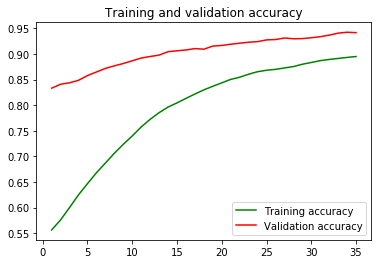

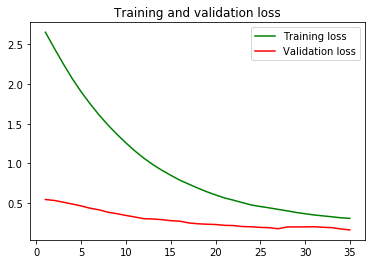

In [61]:
plot_data(history, smooth=True)

In [68]:
# Create a new validation generator for evaluation
valid_test_gen = test_datageneration.flow_from_directory(
                val_fold,
                target_size=(image_height, image_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 198 images belonging to 6 classes.


C:\Users\chitt\Anaconda3\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


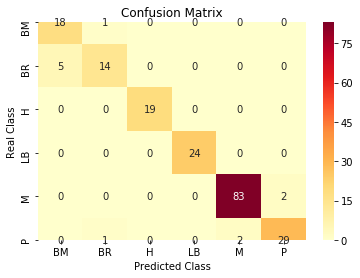

Classification Report
               precision    recall  f1-score   support

black_measles       0.78      0.95      0.86        19
    black_rot       0.88      0.74      0.80        19
      healthy       1.00      1.00      1.00        19
  leaf_blight       1.00      1.00      1.00        24
     mealybug       0.98      0.98      0.98        85
   phylloxera       0.94      0.91      0.92        32

     accuracy                           0.94       198
    macro avg       0.93      0.93      0.93       198
 weighted avg       0.95      0.94      0.94       198



In [64]:
# Load the trained model from the folder
model = load_model('diseasepest-VGG16.h5')

# Display confusion matrix and classification report
collect_metrics(model, generator=valid_test_gen, steps=total_valid)

### Fine-Tune Model

In [16]:
conv_base.layers

In [17]:
# Get the final convolutional block
conv_base.layers[0].name

'input_1'

In [18]:
# Fine-tune the model by unfreezing the final convolutional block

conv_base.trainable = True
trainable_logic = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    trainable_logic = True
  if trainable_logic:
    layer.trainable = True
  else:
    layer.trainable = False

In [26]:
# Build custom metrics 
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
# Build custom metrics 
class MulticlassTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name='multiclass_true_positives', **kwargs):
        super(MulticlassTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)

In [90]:
# Check training performance on each epoch
import os

from keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
from scikitplot.metrics import plot_confusion_matrix, plot_roc


class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, generator, steps, image_dir):
        super().__init__()
        self.model = model
        self.generator = generator
        self.steps = steps
        
        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        #y_pred = self.model.predict(self.validation_data[0])
        #y_pred = self.model.predict_generator(self.validation_data[0])
        y_pred = self.model.predict_generator(self.generator, self.steps)
        y_true = self.generator.classes
     
 
        y_pred_class = np.argmax(y_pred, axis=1)

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

       # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        plot_roc(y_true, y_pred, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

In [91]:
# Log training history to Neptune
from keras.callbacks import Callback
import neptune
import numpy as np
from scikitplot.metrics import plot_confusion_matrix, plot_roc
import matplotlib.pyplot as plt

#neptune.init('shared/onboarding', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOWIyYjA2NmQtZDQ4Yy00M2E0LTkyOTktNTkyYWFmMjQzMWZmIn0=')
#neptune.create_experiment()

# The init() function called this way assumes that
# NEPTUNE_API_TOKEN environment variable is defined.

neptune.init('chittp/sandbox', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOWIyYjA2NmQtZDQ4Yy00M2E0LTkyOTktNTkyYWFmMjQzMWZmIn0=')
neptune.create_experiment(name='minimal_example')

class NeptuneLoggerCallback(Callback):
    def __init__(self, model, generator, steps):
        super().__init__()
        self.model = model
        self.generator = generator
        self.steps = steps

    def on_batch_end(self, batch, logs={}):
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}):
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)

        y_pred = self.model.predict_generator(self.generator, self.steps)
        y_true = self.generator.classes

        y_pred_class = np.argmax(y_pred, axis=1)

        fig, ax = plt.subplots(figsize=(16, 12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        neptune.log_image('confusion_matrix', fig)

        fig, ax = plt.subplots(figsize=(16, 12))
        plot_roc(y_true, y_pred, ax=ax)
        neptune.log_image('roc_curve', fig)

Project(chittp/sandbox)

NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.


https://ui.neptune.ai/chittp/sandbox/e/SAN-12


Experiment(SAN-12)

In [92]:
neptune_logger=NeptuneLoggerCallback(model=model,
                                     generator=valid_test_gen, steps=total_valid)


In [98]:
from keras import metrics

# Compile the model and avoid overfitting by utilizing a much smaller learning rate
model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc', metrics.mean_squared_error, 
                       metrics.mean_absolute_error, 
                       metrics.mean_absolute_percentage_error,
                       metrics.categorical_accuracy,
                       #f1_score, 
                       precision, 
                       recall,
                      MulticlassTruePositives()])

Epoch 1/35
 1/26 [>.............................] - ETA: 3:56 - loss: 0.0241 - accuracy: 1.0000 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0070 - mean_absolute_percentage_error: 3504332.2500 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 294s 11s/step - loss: 0.0761 - accuracy: 0.9792 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0145 - mean_absolute_percentage_error: 7247533.5000 - categorical_accuracy: 0.9792 - precision: 1.0000 - recall: 0.1665 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0139 - val_accuracy: 0.9667 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0160 - val_mean_absolute_percentage_error: 8014110.0000 - val_categorical_accuracy: 0.9667 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00
Epoch 2/35
 4/26 [===>..........................] - ETA: 3:41 - loss: 0.0678 - accuracy: 0.9667 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0159 - mean_absolute_percentage_error: 7946986.0000 - categorical_accuracy: 0.9667 - precision: 1.0000 - recall: 0.1653 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 296s 11s/step - loss: 0.0923 - accuracy: 0.9624 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0172 - mean_absolute_percentage_error: 8598836.0000 - categorical_accuracy: 0.9624 - precision: 1.0000 - recall: 0.1660 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.1581 - val_accuracy: 0.9524 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0214 - val_mean_absolute_percentage_error: 10705096.0000 - val_categorical_accuracy: 0.9524 - val_precision: 1.0000 - val_recall: 0.1657 - val_multiclass_true_positives: 0.0000e+00
Epoch 3/35
 2/26 [=>............................] - ETA: 4:01 - loss: 0.0112 - accuracy: 1.0000 - mean_squared_error: 1.7407e-04 - mean_absolute_error: 0.0036 - mean_absolute_percentage_error: 1818940.5000 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 299s 11s/step - loss: 0.0600 - accuracy: 0.9818 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0121 - mean_absolute_percentage_error: 6044809.0000 - categorical_accuracy: 0.9818 - precision: 1.0000 - recall: 0.1655 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.2762 - val_accuracy: 0.9464 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0179 - val_mean_absolute_percentage_error: 8939160.0000 - val_categorical_accuracy: 0.9464 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00
Epoch 4/35
 2/26 [=>............................] - ETA: 3:51 - loss: 0.0417 - accuracy: 0.9833 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 5824838.0000 - categorical_accuracy: 0.9833 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 303s 12s/step - loss: 0.0515 - accuracy: 0.9808 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 5476087.0000 - categorical_accuracy: 0.9808 - precision: 1.0000 - recall: 0.1660 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0156 - val_accuracy: 0.9821 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0089 - val_mean_absolute_percentage_error: 4432525.0000 - val_categorical_accuracy: 0.9821 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00
Epoch 5/35
 8/26 [========>.....................] - ETA: 2:53 - loss: 0.0542 - accuracy: 0.9784 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 5443736.0000 - categorical_accuracy: 0.9784 - precision: 1.0000 - recall: 0.1653 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 296s 11s/step - loss: 0.0654 - accuracy: 0.9738 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 6229304.0000 - categorical_accuracy: 0.9738 - precision: 1.0000 - recall: 0.1652 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0960 - val_accuracy: 0.9762 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0108 - val_mean_absolute_percentage_error: 5422628.0000 - val_categorical_accuracy: 0.9762 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00
Epoch 6/35
 9/26 [=========>....................] - ETA: 2:49 - loss: 0.0496 - accuracy: 0.9815 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 5238814.5000 - categorical_accuracy: 0.9815 - precision: 1.0000 - recall: 0.1660 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 301s 12s/step - loss: 0.0408 - accuracy: 0.9831 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0092 - mean_absolute_percentage_error: 4592796.0000 - categorical_accuracy: 0.9831 - precision: 1.0000 - recall: 0.1665 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.1591 - val_accuracy: 0.9702 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 7712365.5000 - val_categorical_accuracy: 0.9702 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 7/35
20/26 [======================>.......] - ETA: 1:00 - loss: 0.0878 - accuracy: 0.9683 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0130 - mean_absolute_percentage_error: 6486002.5000 - categorical_accuracy: 0.9683 - precision: 1.0000 - recall: 0.1658 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 305s 12s/step - loss: 0.0736 - accuracy: 0.9744 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 5771887.0000 - categorical_accuracy: 0.9744 - precision: 1.0000 - recall: 0.1660 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0516 - val_accuracy: 0.9643 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 7371120.0000 - val_categorical_accuracy: 0.9643 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 8/35
13/26 [==============>...............] - ETA: 2:07 - loss: 0.0311 - accuracy: 0.9895 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0078 - mean_absolute_percentage_error: 3890187.5000 - categorical_accuracy: 0.9895 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 303s 12s/step - loss: 0.0392 - accuracy: 0.9844 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0085 - mean_absolute_percentage_error: 4232088.5000 - categorical_accuracy: 0.9844 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0979 - val_accuracy: 0.9722 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0125 - val_mean_absolute_percentage_error: 6230979.0000 - val_categorical_accuracy: 0.9722 - val_precision: 1.0000 - val_recall: 0.1657 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 9/35
 7/26 [=======>......................] - ETA: 2:54 - loss: 0.0526 - accuracy: 0.9801 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 5786688.5000 - categorical_accuracy: 0.9801 - precision: 1.0000 - recall: 0.1659 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 292s 11s/step - loss: 0.0508 - accuracy: 0.9790 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 5775075.0000 - categorical_accuracy: 0.9790 - precision: 1.0000 - recall: 0.1660 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0713 - val_accuracy: 0.9821 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0100 - val_mean_absolute_percentage_error: 4991246.5000 - val_categorical_accuracy: 0.9821 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 10/35
 9/26 [=========>....................] - ETA: 2:43 - loss: 0.0228 - accuracy: 0.9963 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0054 - mean_absolute_percentage_error: 2694559.0000 - categorical_accuracy: 0.9963 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 299s 12s/step - loss: 0.0273 - accuracy: 0.9910 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0056 - mean_absolute_percentage_error: 2793681.0000 - categorical_accuracy: 0.9910 - precision: 1.0000 - recall: 0.1665 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.1059 - val_accuracy: 0.9524 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 7182093.0000 - val_categorical_accuracy: 0.9524 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 11/35
20/26 [======================>.......] - ETA: 57s - loss: 0.0254 - accuracy: 0.9932 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0050 - mean_absolute_percentage_error: 2510877.7500 - categorical_accuracy: 0.9932 - precision: 1.0000 - recall: 0.1661 - multiclass_true_positives: 0.0000e+00 

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 295s 11s/step - loss: 0.0283 - accuracy: 0.9909 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0057 - mean_absolute_percentage_error: 2840523.7500 - categorical_accuracy: 0.9909 - precision: 1.0000 - recall: 0.1660 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0272 - val_accuracy: 0.9821 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0116 - val_mean_absolute_percentage_error: 5802487.5000 - val_categorical_accuracy: 0.9821 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 12/35
22/26 [========================>.....] - ETA: 38s - loss: 0.0245 - accuracy: 0.9892 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0053 - mean_absolute_percentage_error: 2640262.2500 - categorical_accuracy: 0.9892 - precision: 1.0000 - recall: 0.1664 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 292s 11s/step - loss: 0.0335 - accuracy: 0.9869 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0065 - mean_absolute_percentage_error: 3249939.2500 - categorical_accuracy: 0.9869 - precision: 1.0000 - recall: 0.1665 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.3773 - val_accuracy: 0.9464 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 7502941.0000 - val_categorical_accuracy: 0.9464 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 13/35
13/26 [==============>...............] - ETA: 2:06 - loss: 0.0169 - accuracy: 0.9949 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0045 - mean_absolute_percentage_error: 2260839.0000 - categorical_accuracy: 0.9949 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 298s 11s/step - loss: 0.0153 - accuracy: 0.9962 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0041 - mean_absolute_percentage_error: 2068301.1250 - categorical_accuracy: 0.9962 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0213 - val_accuracy: 0.9940 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0045 - val_mean_absolute_percentage_error: 2247154.2500 - val_categorical_accuracy: 0.9940 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 14/35
23/26 [=========================>....] - ETA: 27s - loss: 0.0334 - accuracy: 0.9821 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0074 - mean_absolute_percentage_error: 3724270.5000 - categorical_accuracy: 0.9821 - precision: 1.0000 - recall: 0.1664 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 288s 11s/step - loss: 0.0298 - accuracy: 0.9843 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0067 - mean_absolute_percentage_error: 3329667.7500 - categorical_accuracy: 0.9843 - precision: 1.0000 - recall: 0.1665 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0050 - val_accuracy: 0.9762 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0084 - val_mean_absolute_percentage_error: 4203673.0000 - val_categorical_accuracy: 0.9762 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 15/35
13/26 [==============>...............] - ETA: 2:07 - loss: 0.0299 - accuracy: 0.9897 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 3074231.2500 - categorical_accuracy: 0.9897 - precision: 1.0000 - recall: 0.1658 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 309s 12s/step - loss: 0.0261 - accuracy: 0.9910 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0055 - mean_absolute_percentage_error: 2751963.0000 - categorical_accuracy: 0.9910 - precision: 1.0000 - recall: 0.1662 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0100 - val_accuracy: 0.9778 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0093 - val_mean_absolute_percentage_error: 4659792.5000 - val_categorical_accuracy: 0.9778 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 16/35
22/26 [========================>.....] - ETA: 39s - loss: 0.0215 - accuracy: 0.9908 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0050 - mean_absolute_percentage_error: 2523875.0000 - categorical_accuracy: 0.9908 - precision: 1.0000 - recall: 0.1664 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 296s 11s/step - loss: 0.0202 - accuracy: 0.9921 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0048 - mean_absolute_percentage_error: 2387925.7500 - categorical_accuracy: 0.9921 - precision: 1.0000 - recall: 0.1665 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0110 - val_accuracy: 0.9881 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0062 - val_mean_absolute_percentage_error: 3094998.7500 - val_categorical_accuracy: 0.9881 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 17/35
26/26 [==============================] - 288s 11s/step - loss: 0.0138 - accuracy: 0.9961 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0033 - mean_absolute_percentage_error: 1647762.6250 - categorical_accuracy: 0.9961 - precision: 1.0000 - recall: 0.1665 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.9940 - val_mean_squared_error: 8.3366e-04 - val_mean_absolute_error: 0.0036 - val_mean_absolute_percentage_error: 1819580.3750 - val_categorical_accuracy: 0.9940 - val_precision: 1.0000 - val_recall: 0.1651 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 18/35
 1/26 [>.............................] - ETA: 3:55 - loss: 0.0252 - accuracy: 1.0000 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0070 - mean_absolute_percentage_error: 3494465.5000 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


17/26 [==================>...........] - ETA: 1:25 - loss: 0.0198 - accuracy: 0.9941 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0040 - mean_absolute_percentage_error: 1994276.2500 - categorical_accuracy: 0.9941 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 291s 11s/step - loss: 0.0236 - accuracy: 0.9936 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0045 - mean_absolute_percentage_error: 2240260.7500 - categorical_accuracy: 0.9936 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 7.6518e-04 - val_accuracy: 0.9821 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0087 - val_mean_absolute_percentage_error: 4362674.5000 - val_categorical_accuracy: 0.9821 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 19/35
18/26 [===================>..........] - ETA: 1:14 - loss: 0.0215 - accuracy: 0.9944 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0043 - mean_absolute_percentage_error: 2155230.2500 - categorical_accuracy: 0.9944 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00    

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 286s 11s/step - loss: 0.0237 - accuracy: 0.9921 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0048 - mean_absolute_percentage_error: 2377452.2500 - categorical_accuracy: 0.9921 - precision: 1.0000 - recall: 0.1665 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.1861 - val_accuracy: 0.9643 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 6483908.0000 - val_categorical_accuracy: 0.9643 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 20/35
26/26 [==============================] - 291s 11s/step - loss: 0.0333 - accuracy: 0.9808 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 3455038.0000 - categorical_accuracy: 0.9808 - precision: 1.0000 - recall: 0.1658 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0414 - val_accuracy: 0.9881 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0053 - val_mean_absolute_percentage_error: 2628007.2500 - val_categorical_accuracy: 0.9881 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 21/35
 5/26 [====>.........................] - ETA: 3:20 - loss: 0.0360 - accuracy: 0.9867 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0086 - mean_absolute_percentage_error: 4286806.0000 - categorical_accuracy: 0.9867 - precision: 1.0000 - recall: 0.1656 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 288s 11s/step - loss: 0.0288 - accuracy: 0.9921 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0060 - mean_absolute_percentage_error: 3014892.2500 - categorical_accuracy: 0.9921 - precision: 1.0000 - recall: 0.1662 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.9762 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0081 - val_mean_absolute_percentage_error: 4072946.0000 - val_categorical_accuracy: 0.9762 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 22/35


C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


21/26 [=======================>......] - ETA: 47s - loss: 0.0178 - accuracy: 0.9937 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0038 - mean_absolute_percentage_error: 1876888.7500 - categorical_accuracy: 0.9937 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 295s 11s/step - loss: 0.0185 - accuracy: 0.9936 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0037 - mean_absolute_percentage_error: 1833906.8750 - categorical_accuracy: 0.9936 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.2049 - val_accuracy: 0.9889 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0061 - val_mean_absolute_percentage_error: 3030347.5000 - val_categorical_accuracy: 0.9889 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 23/35
26/26 [==============================] - 292s 11s/step - loss: 0.0151 - accuracy: 0.9948 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0034 - mean_absolute_percentage_error: 1687070.8750 - categorical_accuracy: 0.9948 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.9881 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0051 - val_mean_absolute_percentage_error: 2539555.2500 - val_categorical_accuracy: 0.9881 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 24/35
 9/26 [=========>....................] - ETA: 2:38 - loss: 0.0264 - accuracy: 0.9885 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0044 - mean_absolute_percentage_error: 2192713.0000 - categorical_accuracy: 0.9885 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


23/26 [=========================>....] - ETA: 28s - loss: 0.0169 - accuracy: 0.9956 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0036 - mean_absolute_percentage_error: 1793664.2500 - categorical_accuracy: 0.9956 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 291s 11s/step - loss: 0.0204 - accuracy: 0.9948 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0036 - mean_absolute_percentage_error: 1821882.1250 - categorical_accuracy: 0.9948 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0190 - val_accuracy: 1.0000 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0044 - val_mean_absolute_percentage_error: 2180601.2500 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 25/35
26/26 [==============================] - 287s 11s/step - loss: 0.0100 - accuracy: 0.9974 - mean_squared_error: 7.9782e-04 - mean_absolute_error: 0.0023 - mean_absolute_percentage_error: 1163694.2500 - categorical_accuracy: 0.9974 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0057 - val_accuracy: 0.9881 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0068 - val_mean_absolute_percentage_error: 3393017.2500 - val_categorical_accuracy: 0.9881 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 26/35
11/26 [===========>..................] - ETA: 2:23 - loss: 0.0094 - accuracy: 0.9970 - mean_squared_error: 6.4745e-04 - mean_absolute_error: 0.0024 - mean_absolute_percentage_error: 1223105.5000 - categorical_accuracy: 0.9970 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


25/26 [===========================>..] - ETA: 9s - loss: 0.0131 - accuracy: 0.9973 - mean_squared_error: 8.8239e-04 - mean_absolute_error: 0.0025 - mean_absolute_percentage_error: 1272018.7500 - categorical_accuracy: 0.9973 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 291s 11s/step - loss: 0.0127 - accuracy: 0.9974 - mean_squared_error: 8.5020e-04 - mean_absolute_error: 0.0025 - mean_absolute_percentage_error: 1242227.3750 - categorical_accuracy: 0.9974 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.1545 - val_accuracy: 0.9702 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0101 - val_mean_absolute_percentage_error: 5057765.5000 - val_categorical_accuracy: 0.9702 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 27/35
26/26 [==============================] - 288s 11s/step - loss: 0.0063 - accuracy: 0.9987 - mean_squared_error: 5.1332e-04 - mean_absolute_error: 0.0017 - mean_absolute_percentage_error: 861314.0000 - categorical_accuracy: 0.9987 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 2.0769e-04 - val_accuracy: 0.9940 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0029 - val_mean_absolute_percentage_error: 1471254.6250 - val_categorical_accuracy: 0.9940 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 28/35
 5/26 [====>.........................] - ETA: 3:19 - loss: 0.0027 - accuracy: 1.0000 - mean_squared_error: 1.2520e-04 - mean_absolute_error: 8.2803e-04 - mean_absolute_percentage_error: 414016.9062 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00  

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 287s 11s/step - loss: 0.0035 - accuracy: 1.0000 - mean_squared_error: 1.6218e-04 - mean_absolute_error: 0.0011 - mean_absolute_percentage_error: 535733.0000 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 1.2997e-04 - val_accuracy: 0.9702 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0091 - val_mean_absolute_percentage_error: 4568722.0000 - val_categorical_accuracy: 0.9702 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 29/35
 2/26 [=>............................] - ETA: 4:02 - loss: 0.0029 - accuracy: 1.0000 - mean_squared_error: 6.9169e-05 - mean_absolute_error: 9.2086e-04 - mean_absolute_percentage_error: 460429.3750 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 290s 11s/step - loss: 0.0314 - accuracy: 0.9870 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0044 - mean_absolute_percentage_error: 2191558.0000 - categorical_accuracy: 0.9870 - precision: 1.0000 - recall: 0.1662 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.9778 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0095 - val_mean_absolute_percentage_error: 4738834.0000 - val_categorical_accuracy: 0.9778 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 30/35
 3/26 [==>...........................] - ETA: 3:49 - loss: 0.0079 - accuracy: 1.0000 - mean_squared_error: 2.7847e-04 - mean_absolute_error: 0.0025 - mean_absolute_percentage_error: 1231060.2500 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 289s 11s/step - loss: 0.0279 - accuracy: 0.9922 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0054 - mean_absolute_percentage_error: 2691590.5000 - categorical_accuracy: 0.9922 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.9821 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0058 - val_mean_absolute_percentage_error: 2921053.0000 - val_categorical_accuracy: 0.9821 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 31/35
 3/26 [==>...........................] - ETA: 3:40 - loss: 0.0267 - accuracy: 0.9889 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0047 - mean_absolute_percentage_error: 2330285.7500 - categorical_accuracy: 0.9889 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00   

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 289s 11s/step - loss: 0.0156 - accuracy: 0.9948 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0034 - mean_absolute_percentage_error: 1680721.6250 - categorical_accuracy: 0.9948 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.1075 - val_accuracy: 0.9524 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0179 - val_mean_absolute_percentage_error: 8937214.0000 - val_categorical_accuracy: 0.9524 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 32/35
 4/26 [===>..........................] - ETA: 3:29 - loss: 0.0115 - accuracy: 1.0000 - mean_squared_error: 5.7684e-04 - mean_absolute_error: 0.0035 - mean_absolute_percentage_error: 1738237.3750 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 294s 11s/step - loss: 0.0143 - accuracy: 0.9961 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0034 - mean_absolute_percentage_error: 1693898.5000 - categorical_accuracy: 0.9961 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.9940 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0030 - val_mean_absolute_percentage_error: 1522637.1250 - val_categorical_accuracy: 0.9940 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 33/35
 4/26 [===>..........................] - ETA: 3:24 - loss: 0.0060 - accuracy: 1.0000 - mean_squared_error: 3.2777e-04 - mean_absolute_error: 0.0018 - mean_absolute_percentage_error: 884853.0000 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 288s 11s/step - loss: 0.0152 - accuracy: 0.9948 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0031 - mean_absolute_percentage_error: 1544076.5000 - categorical_accuracy: 0.9948 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0052 - val_accuracy: 0.9762 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0097 - val_mean_absolute_percentage_error: 4870599.0000 - val_categorical_accuracy: 0.9762 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 34/35
 5/26 [====>.........................] - ETA: 3:16 - loss: 0.0113 - accuracy: 1.0000 - mean_squared_error: 7.4806e-04 - mean_absolute_error: 0.0032 - mean_absolute_percentage_error: 1617284.7500 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 290s 11s/step - loss: 0.0148 - accuracy: 0.9974 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0025 - mean_absolute_percentage_error: 1238922.3750 - categorical_accuracy: 0.9974 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.9821 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0072 - val_mean_absolute_percentage_error: 3590717.0000 - val_categorical_accuracy: 0.9821 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

Epoch 35/35
 8/26 [========>.....................] - ETA: 2:46 - loss: 0.0102 - accuracy: 0.9957 - mean_squared_error: 7.7907e-04 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 1472916.2500 - categorical_accuracy: 0.9957 - precision: 1.0000 - recall: 0.1667 - multiclass_true_positives: 0.0000e+00

C:\Users\chitt\Anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 287s 11s/step - loss: 0.0139 - accuracy: 0.9922 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0032 - mean_absolute_percentage_error: 1619273.2500 - categorical_accuracy: 0.9922 - precision: 1.0000 - recall: 0.1665 - multiclass_true_positives: 0.0000e+00 - val_loss: 0.4685 - val_accuracy: 0.9524 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0172 - val_mean_absolute_percentage_error: 8608292.0000 - val_categorical_accuracy: 0.9524 - val_precision: 1.0000 - val_recall: 0.1667 - val_multiclass_true_positives: 0.0000e+00


C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\chitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

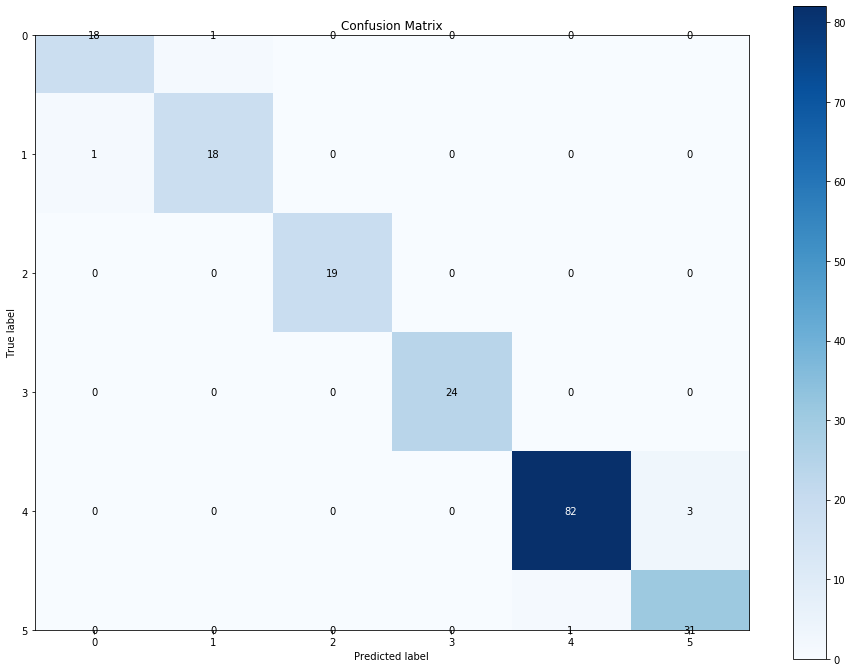

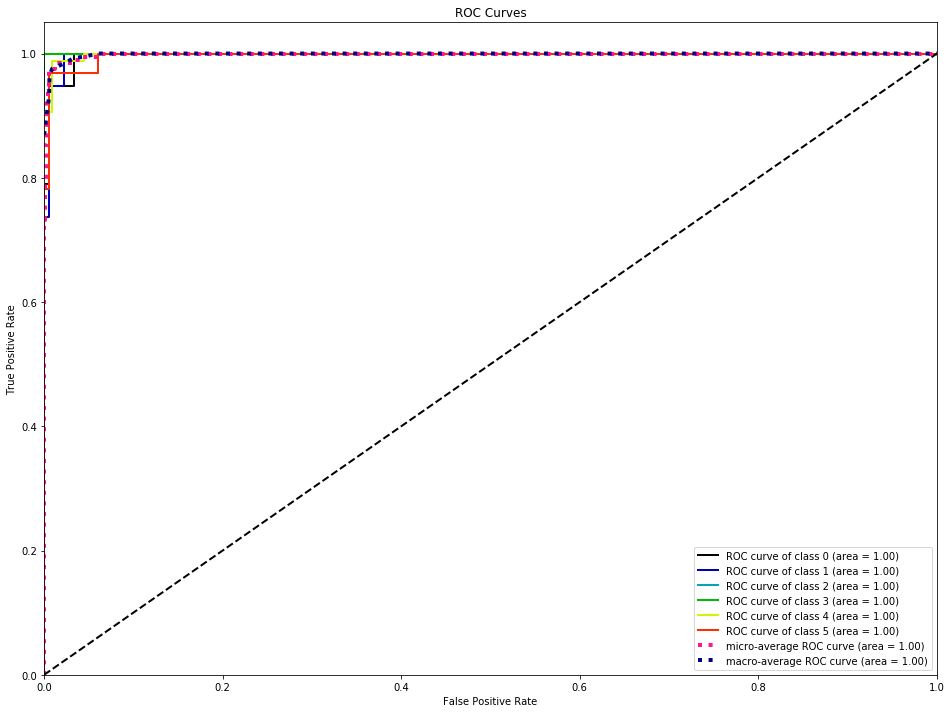

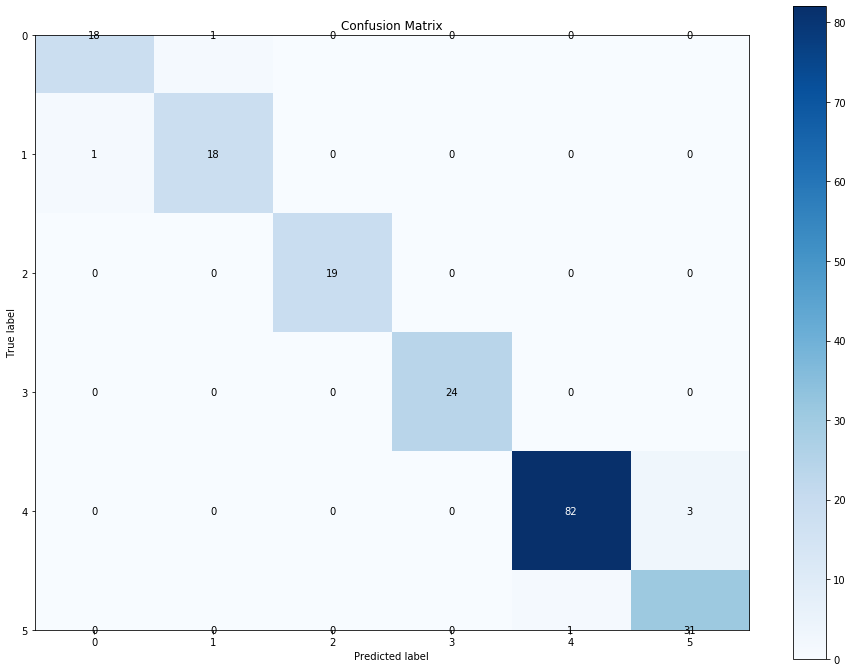

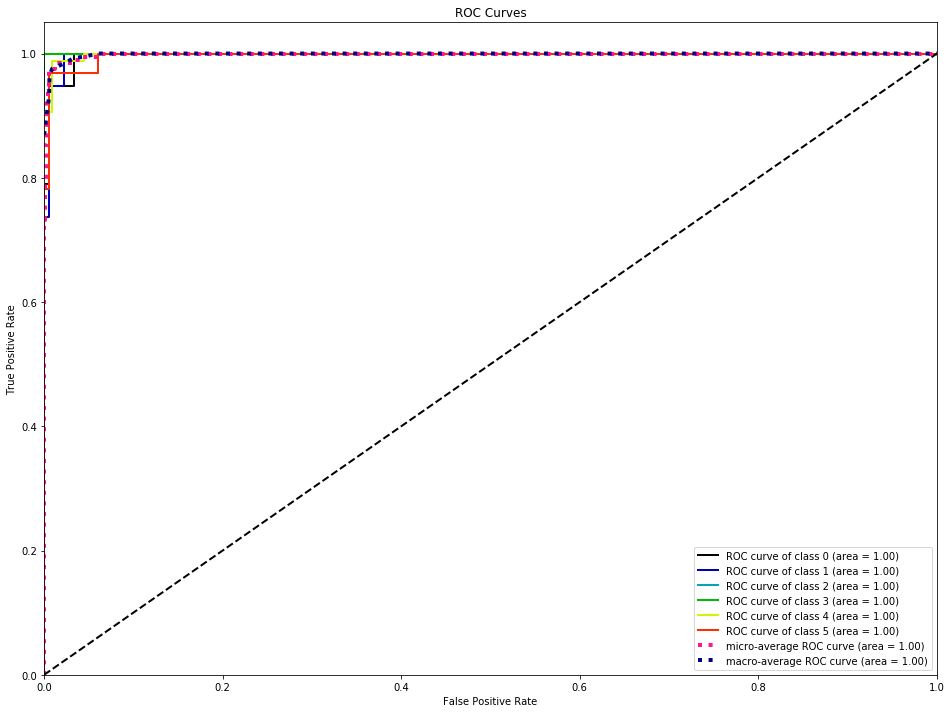

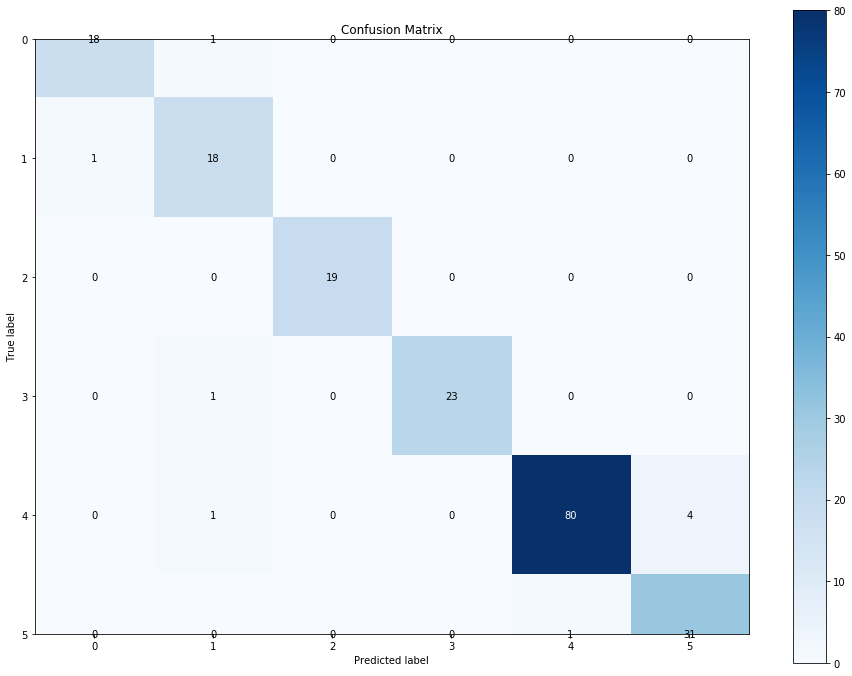

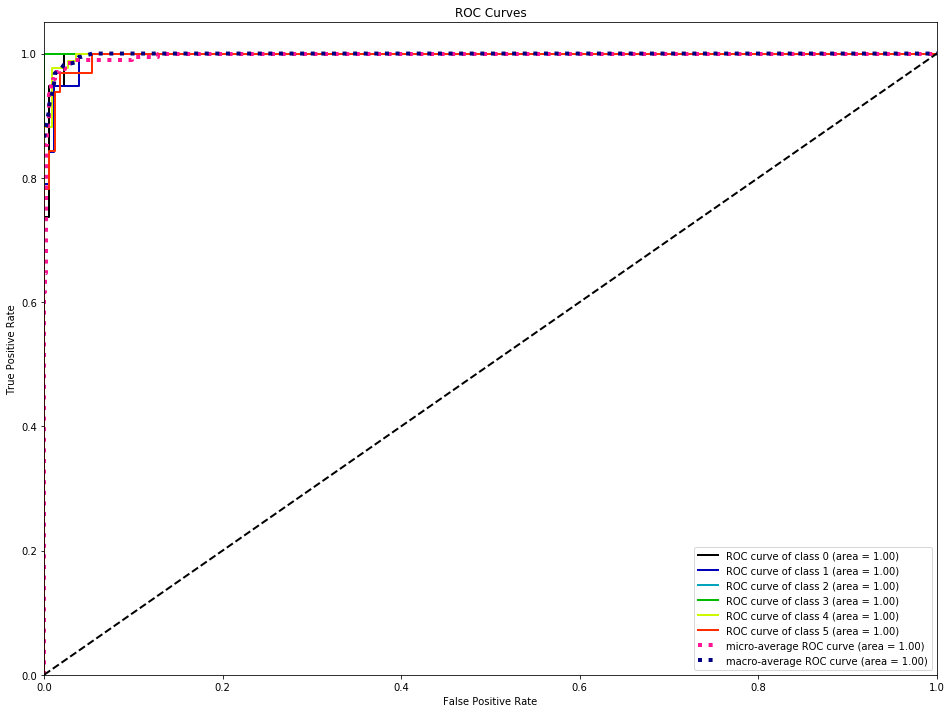

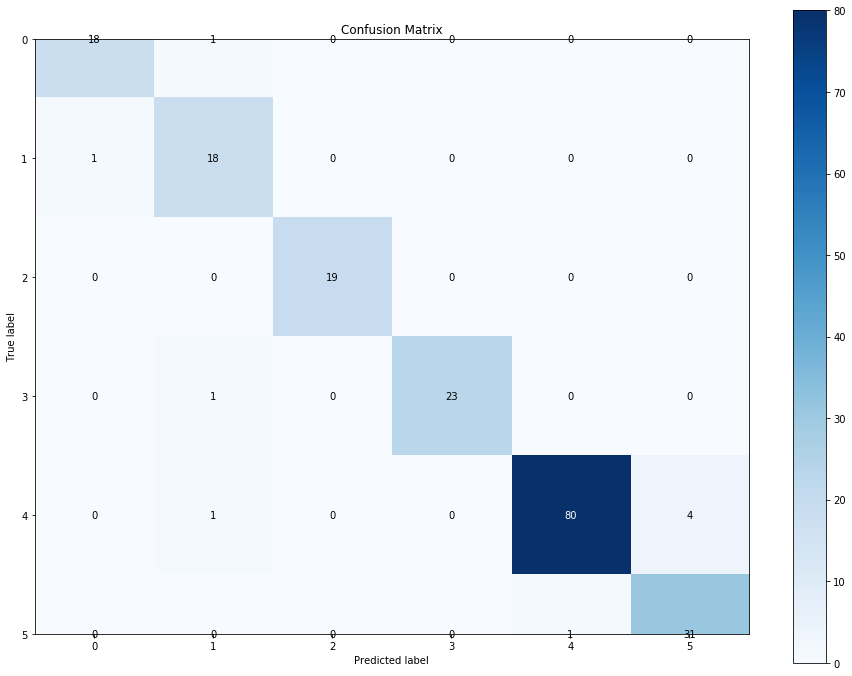

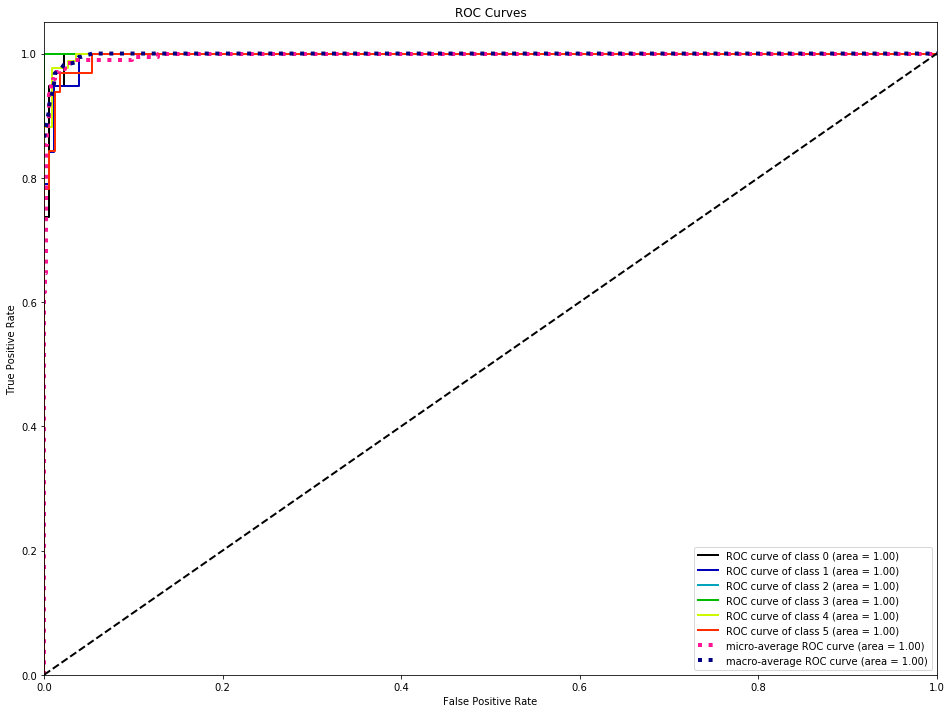

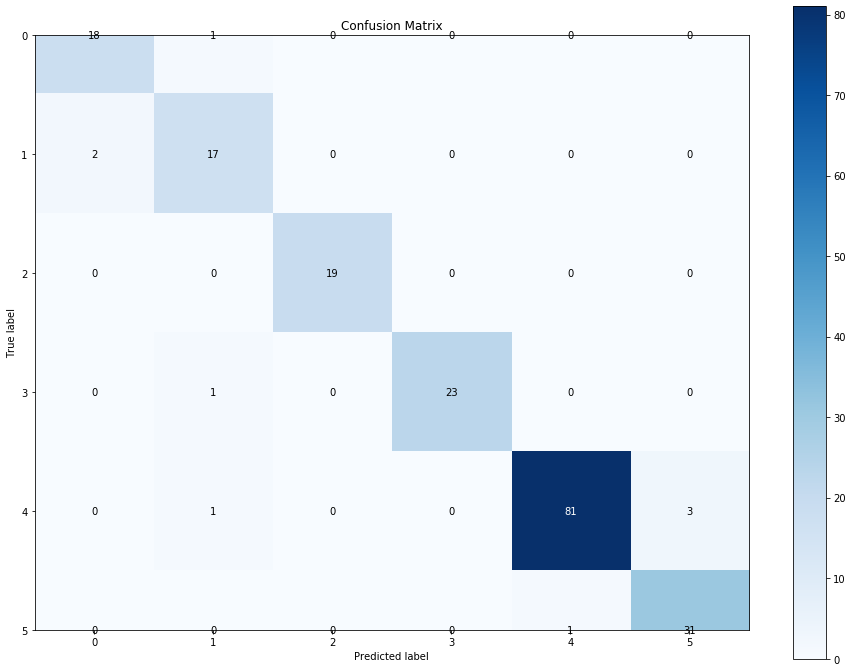

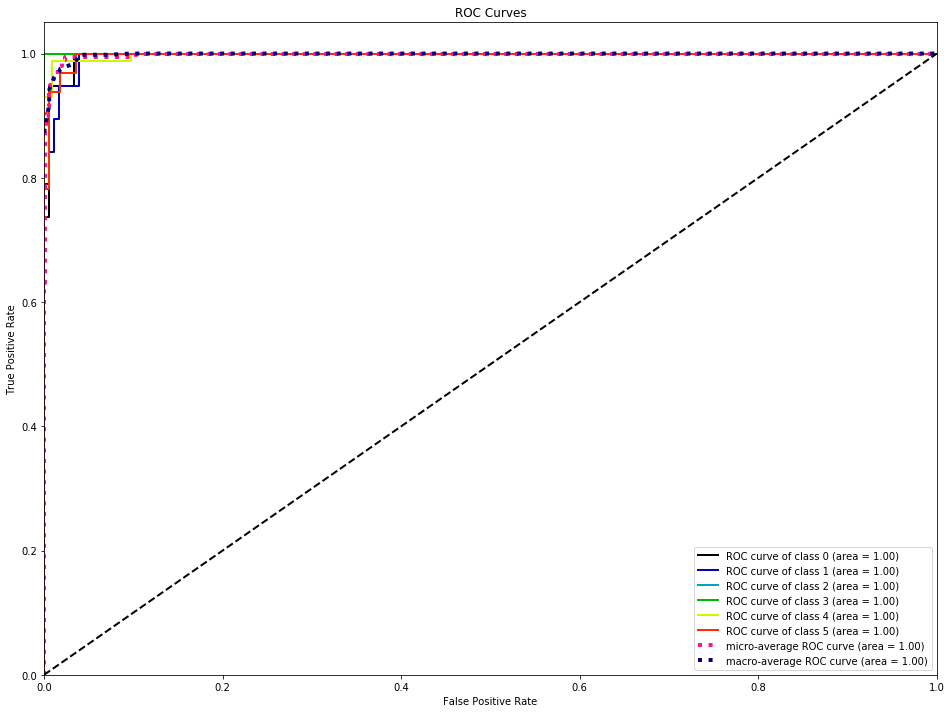

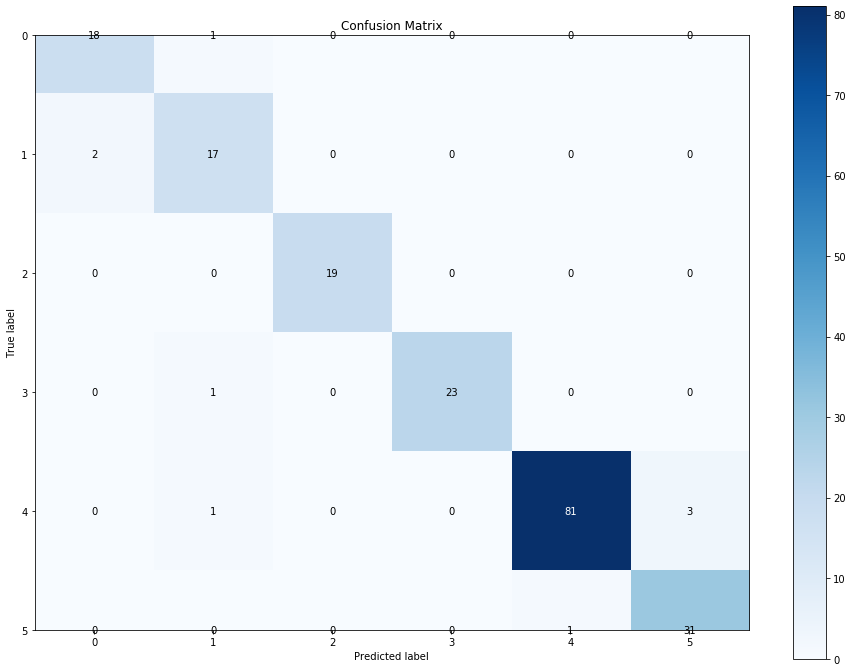

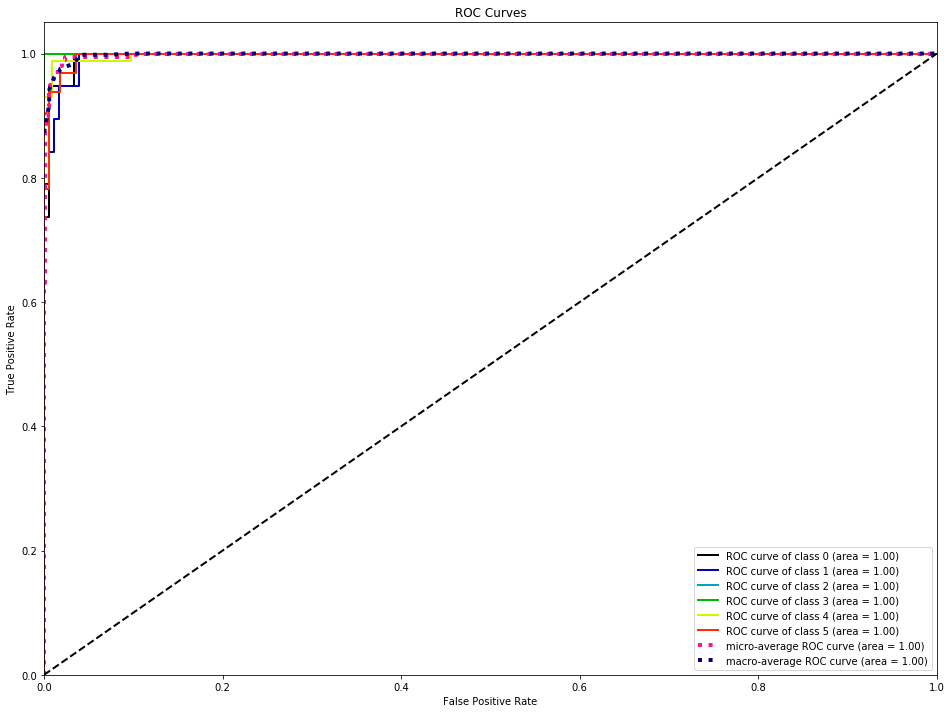

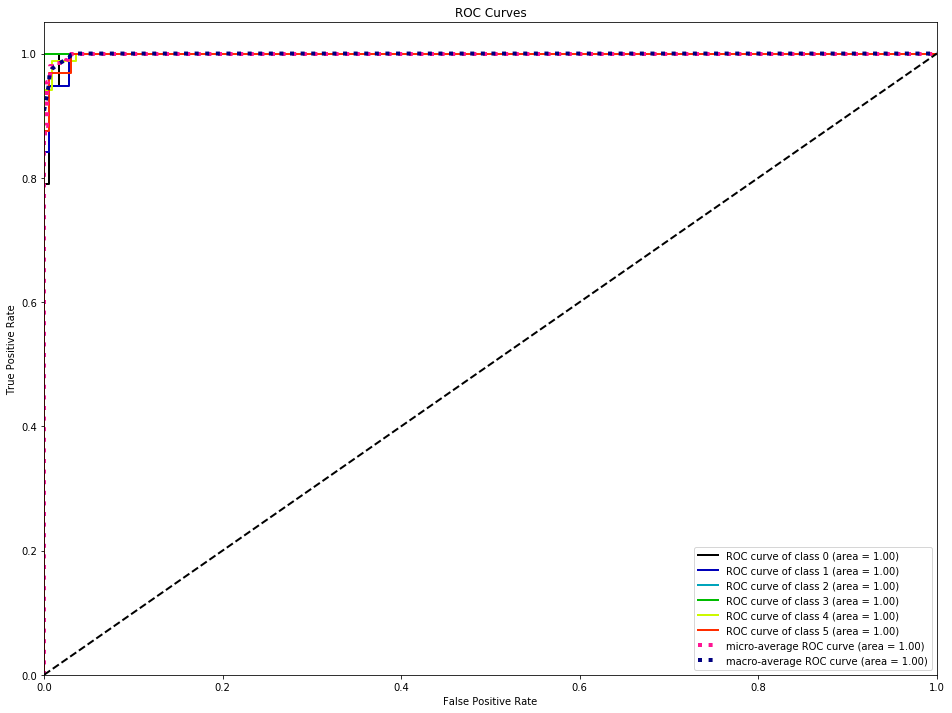

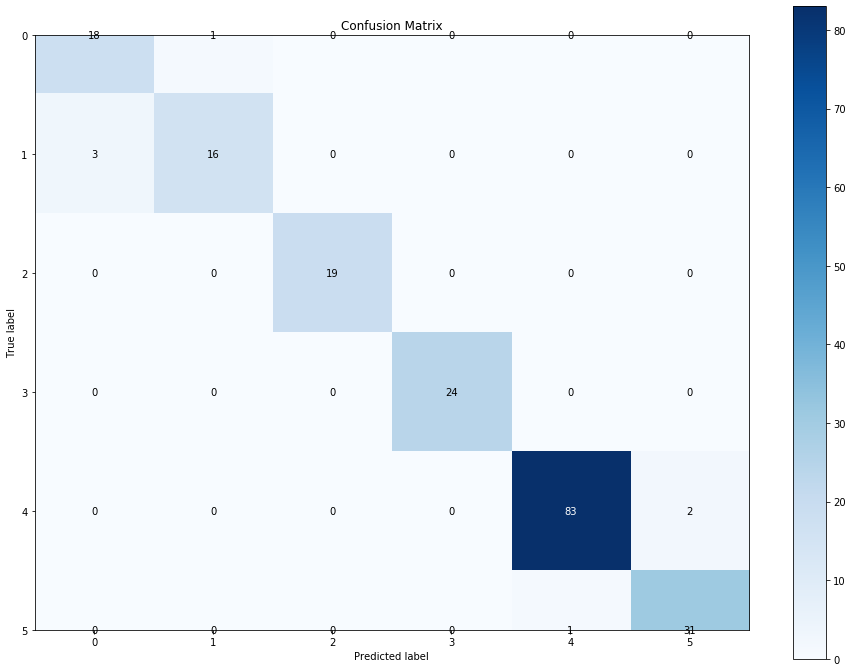

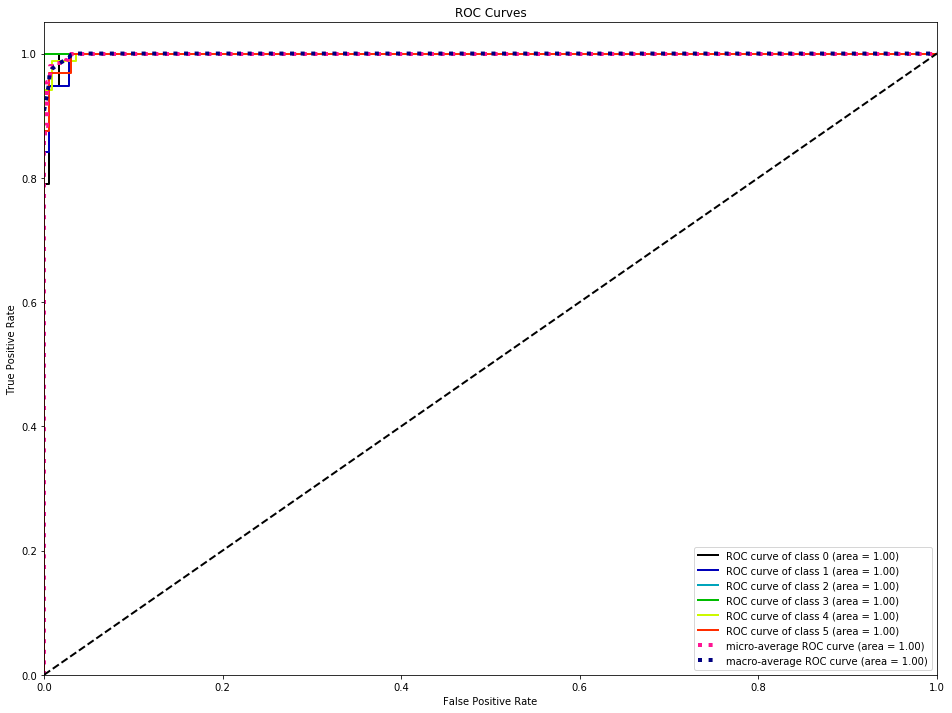

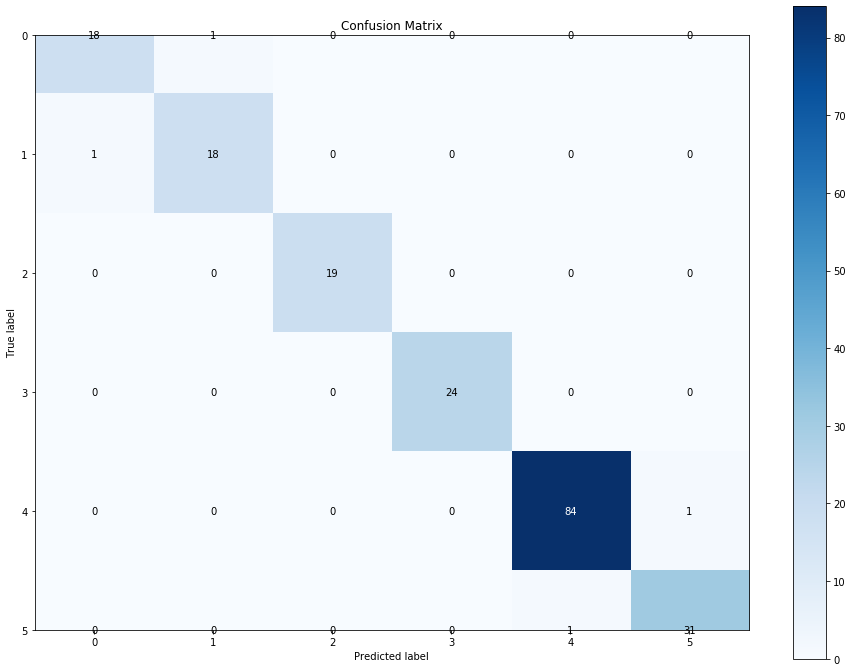

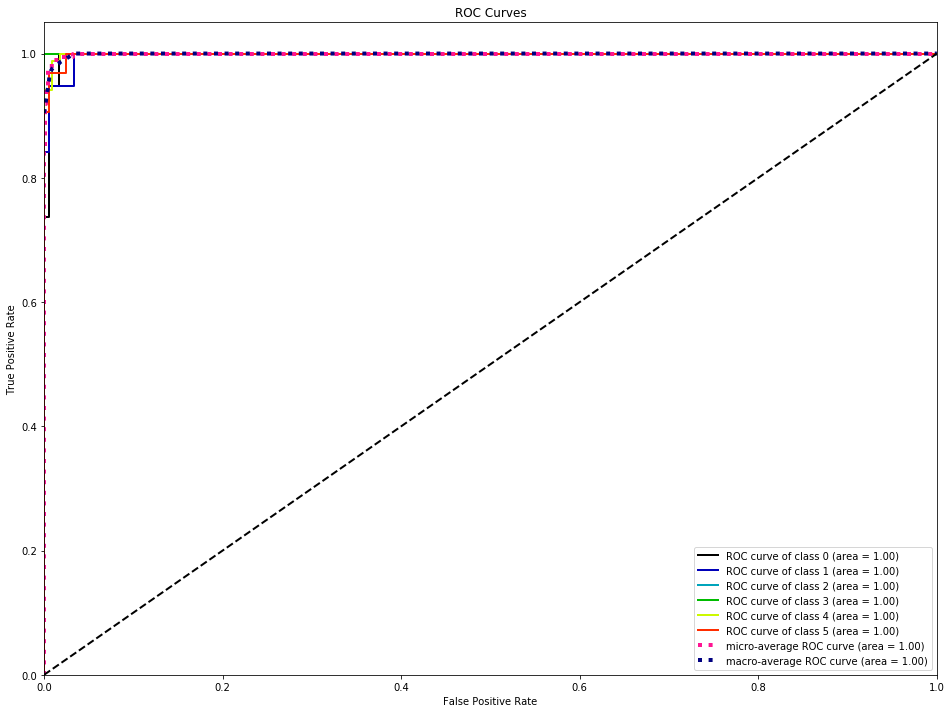

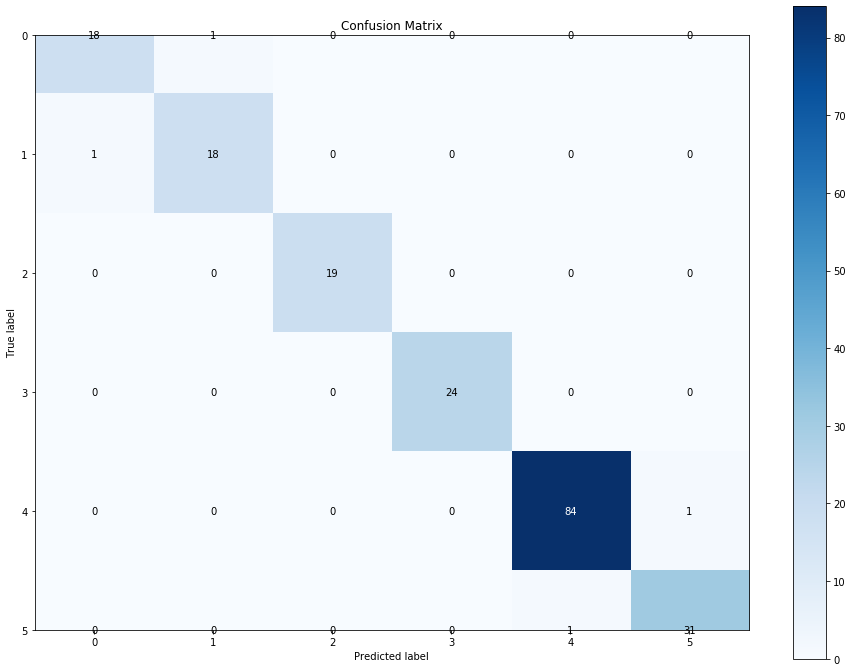

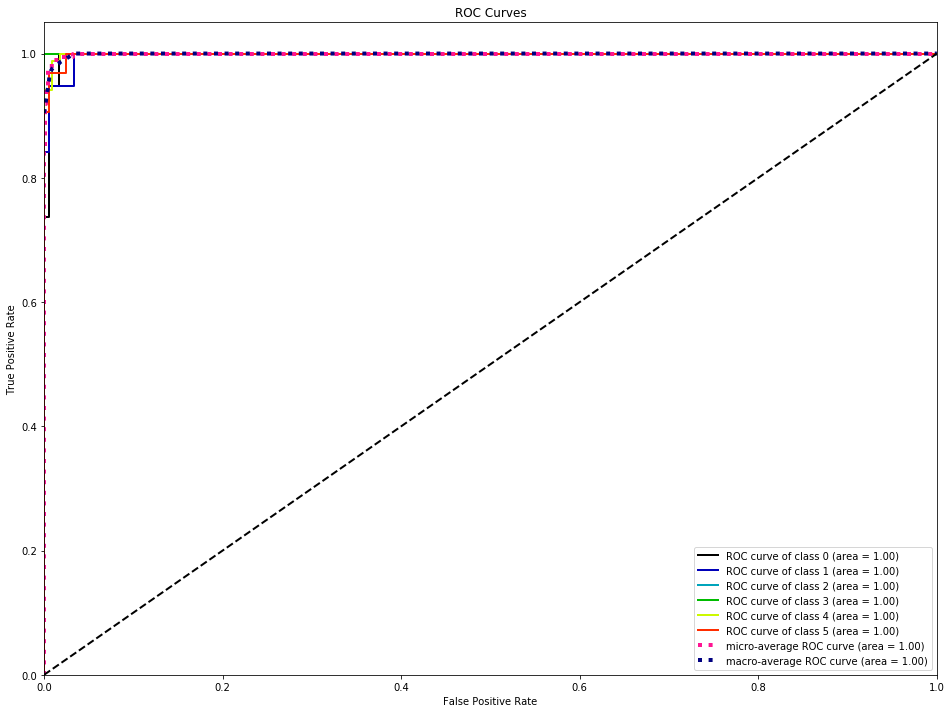

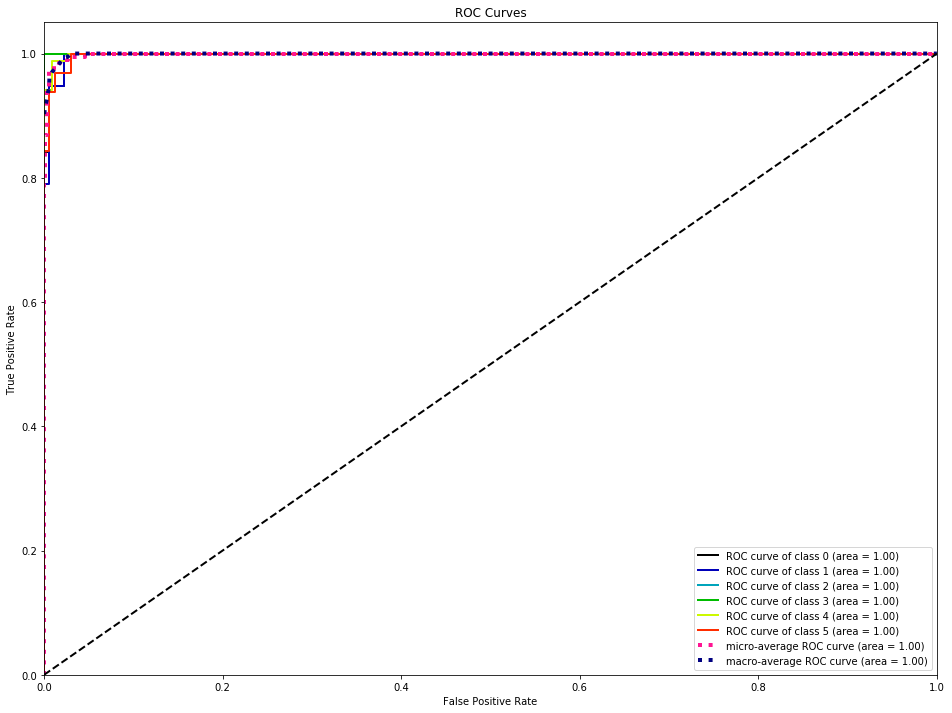

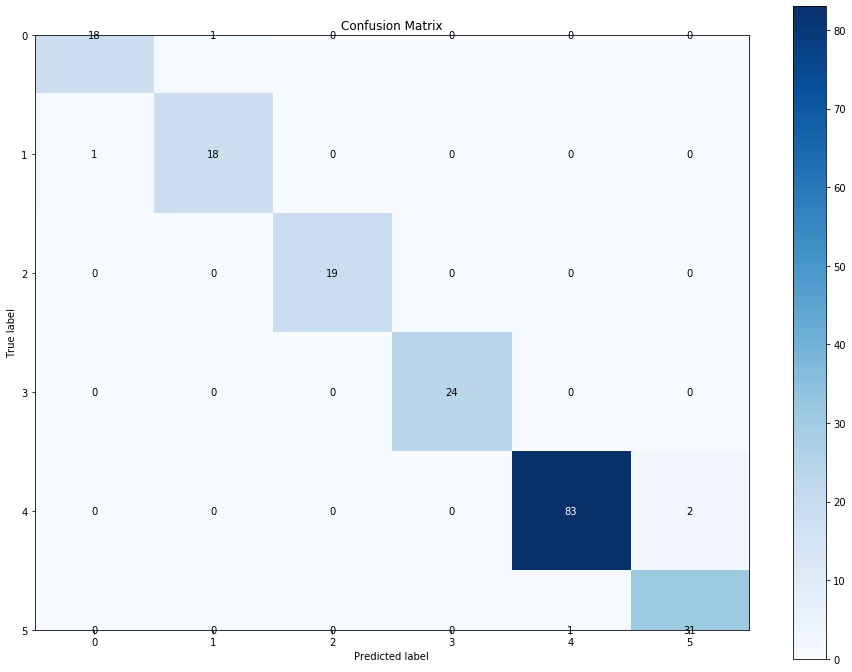

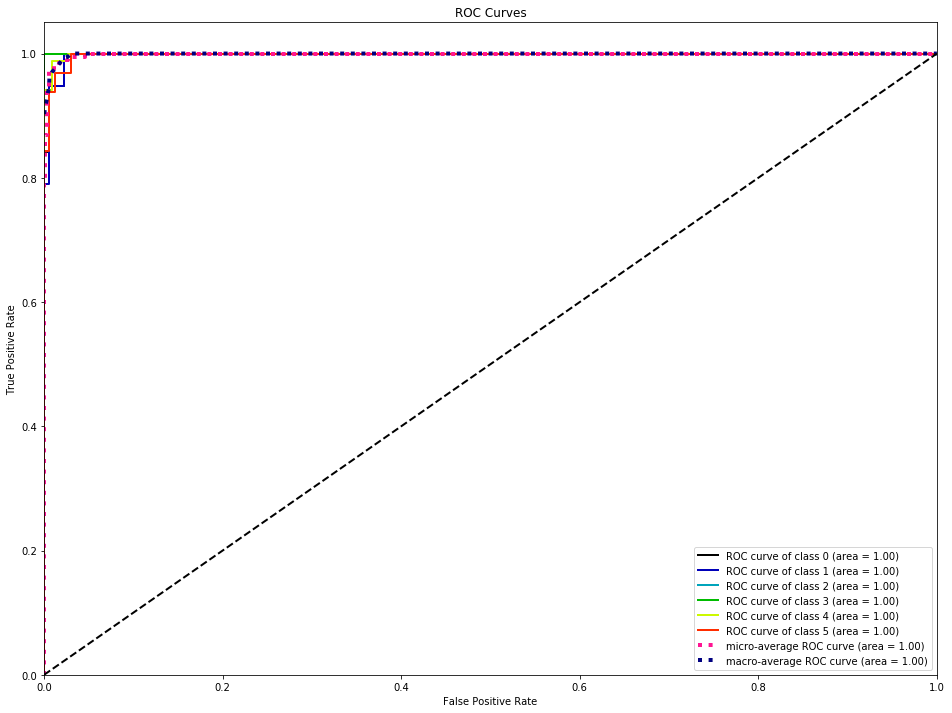

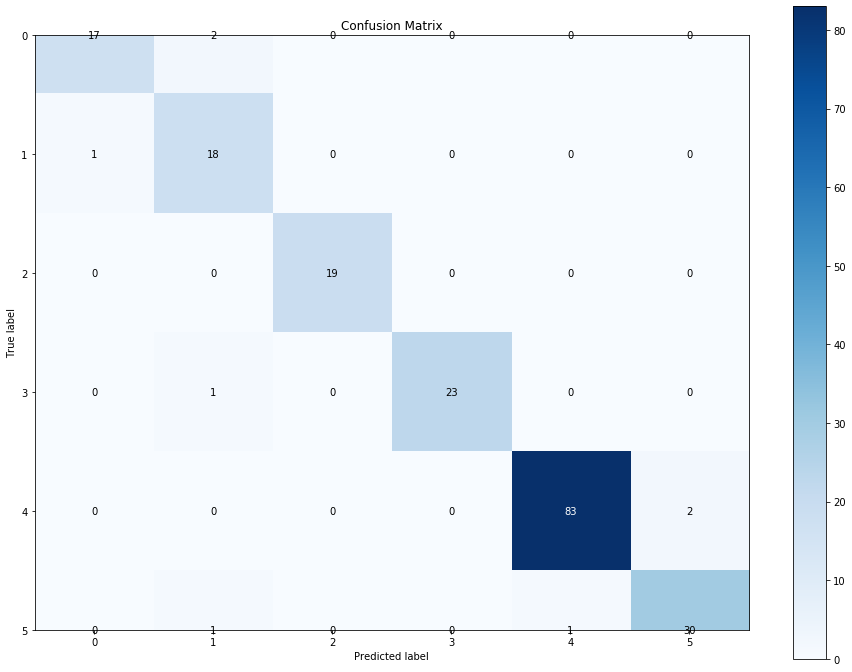

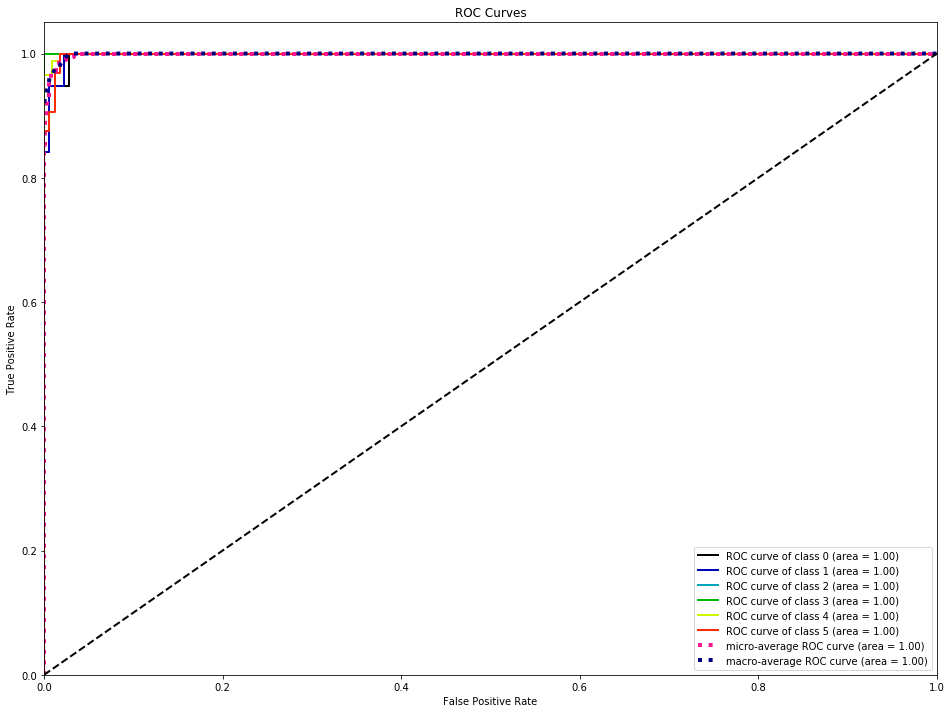

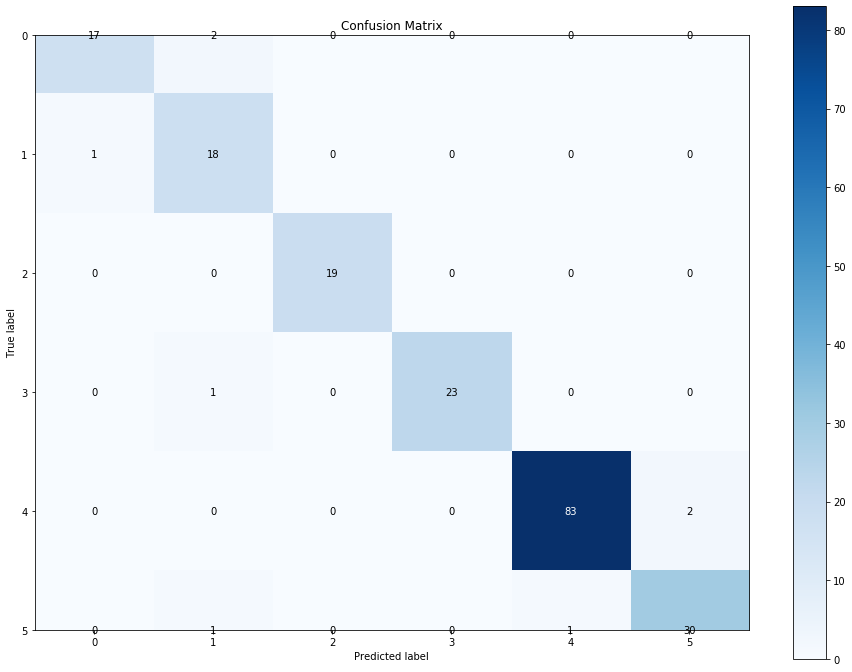

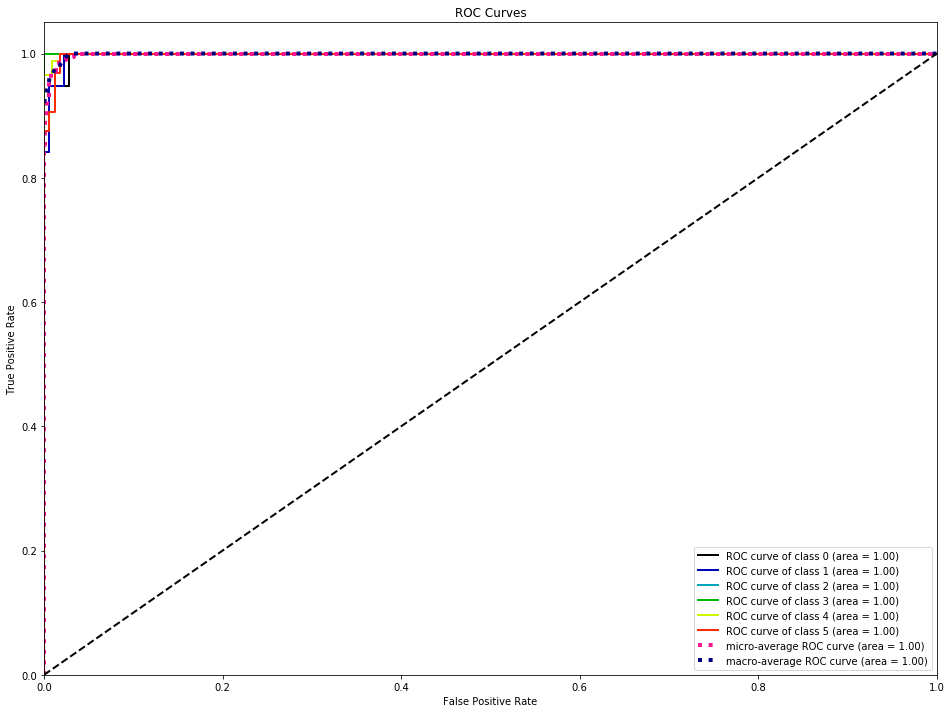

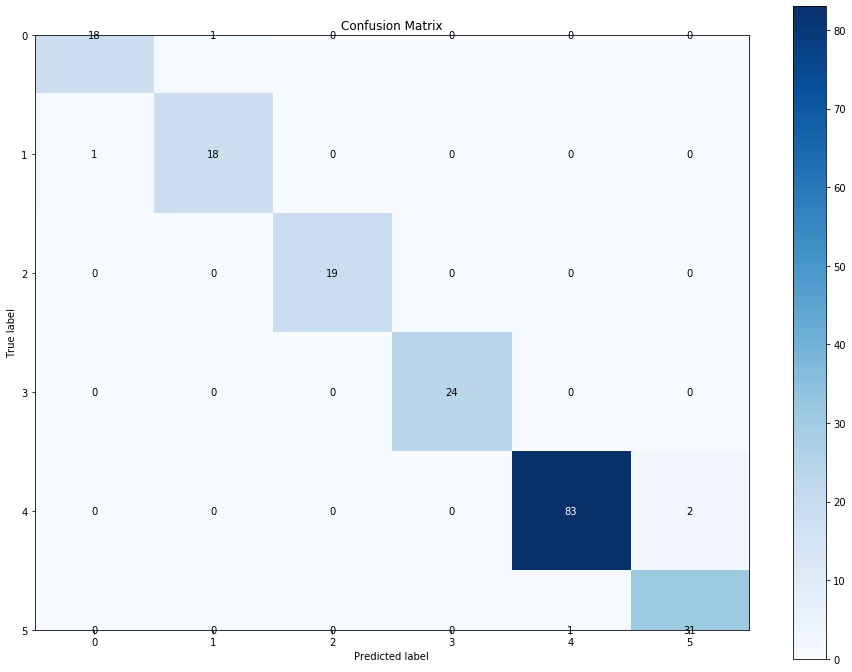

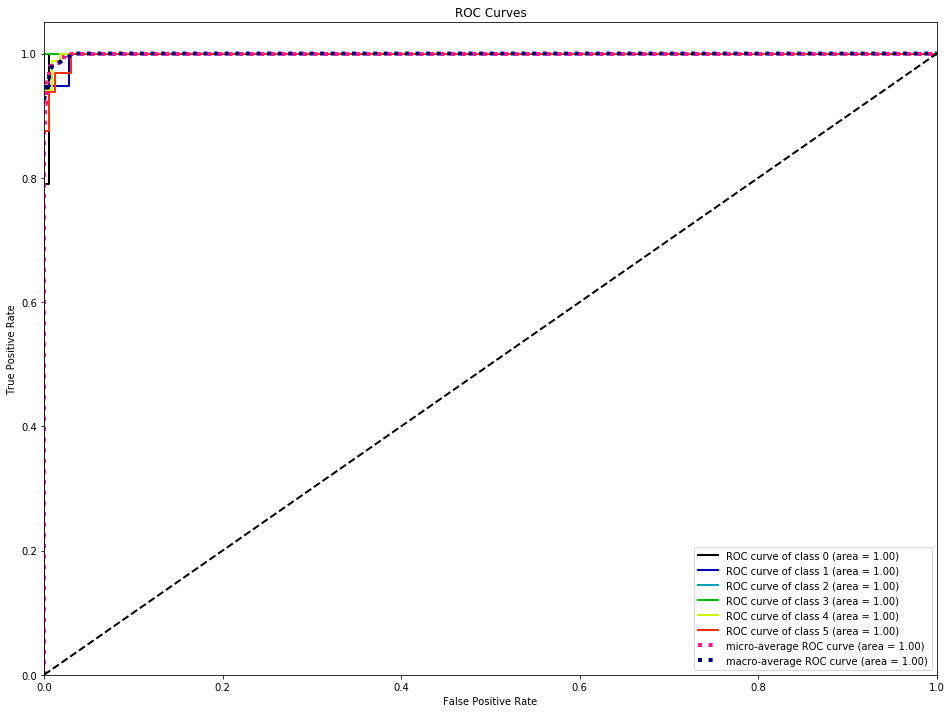

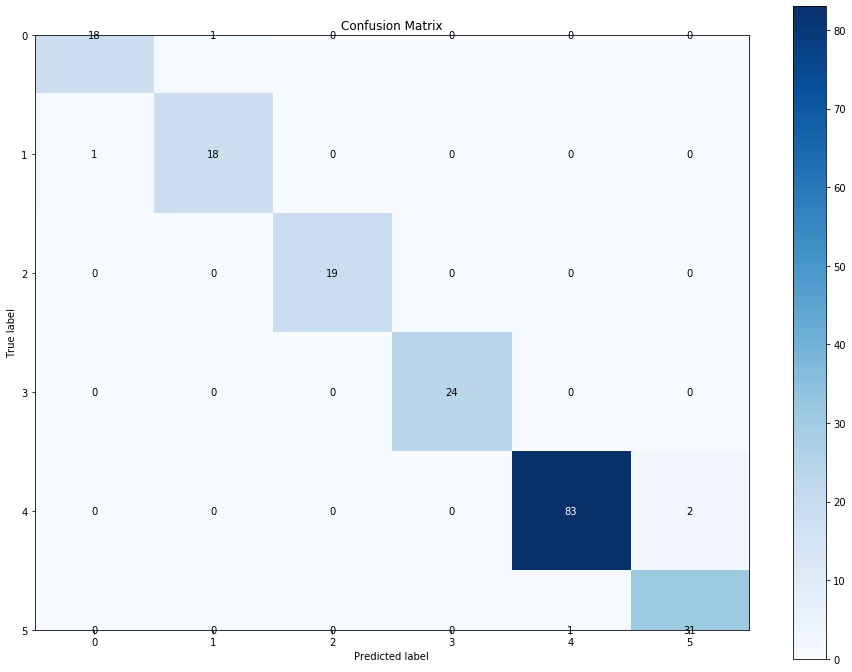

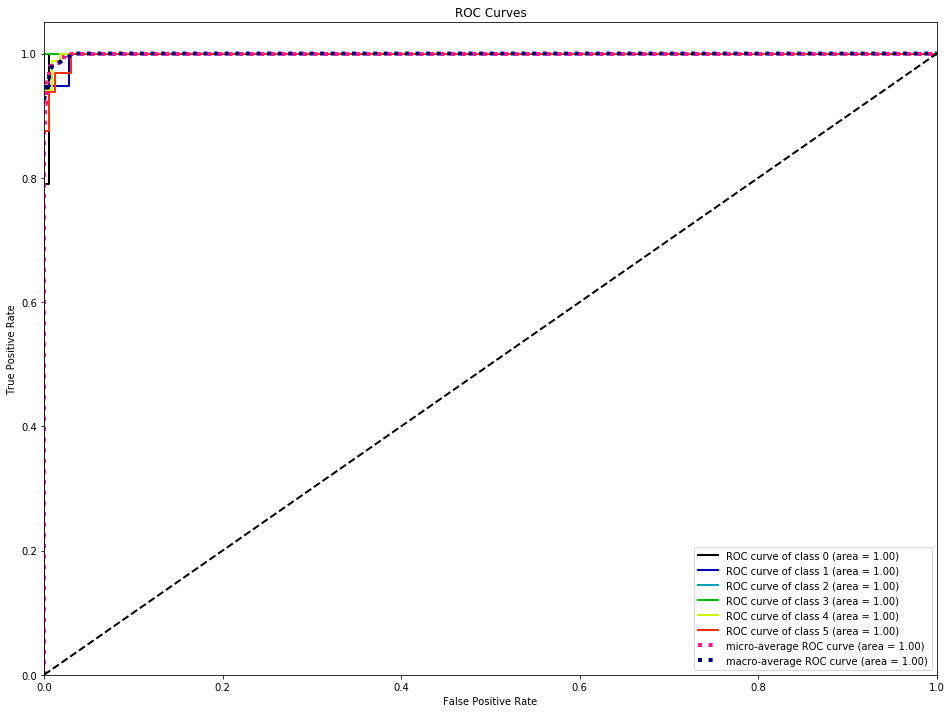

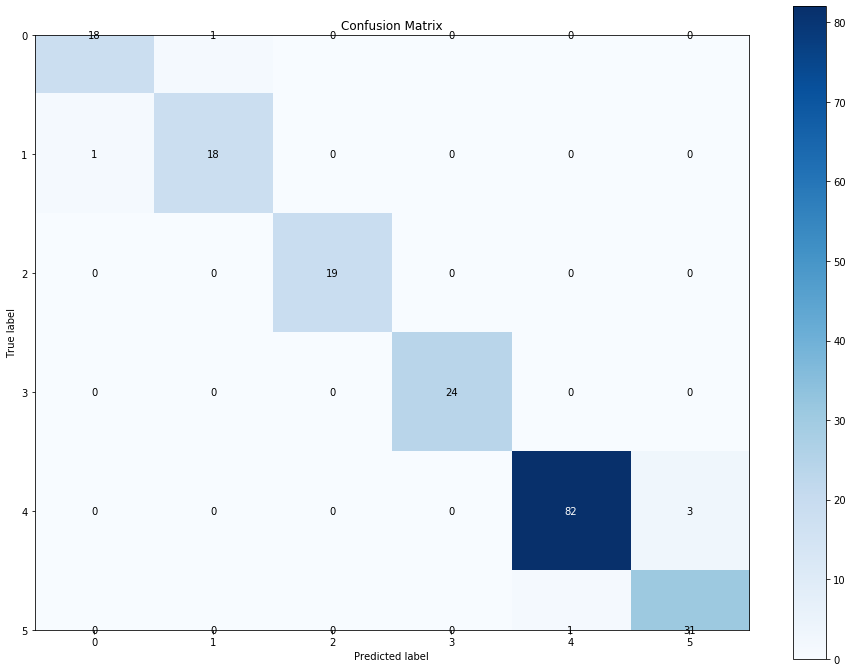

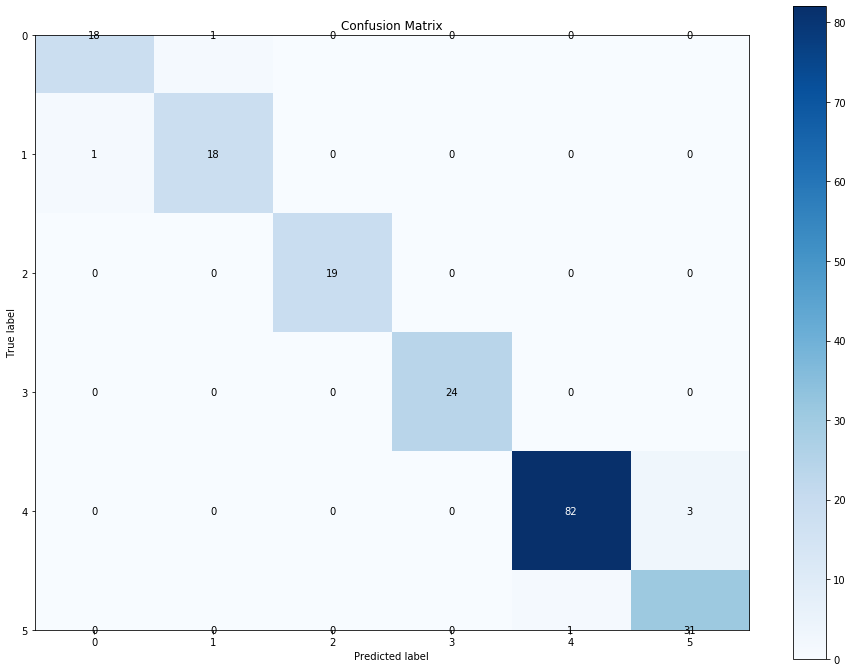

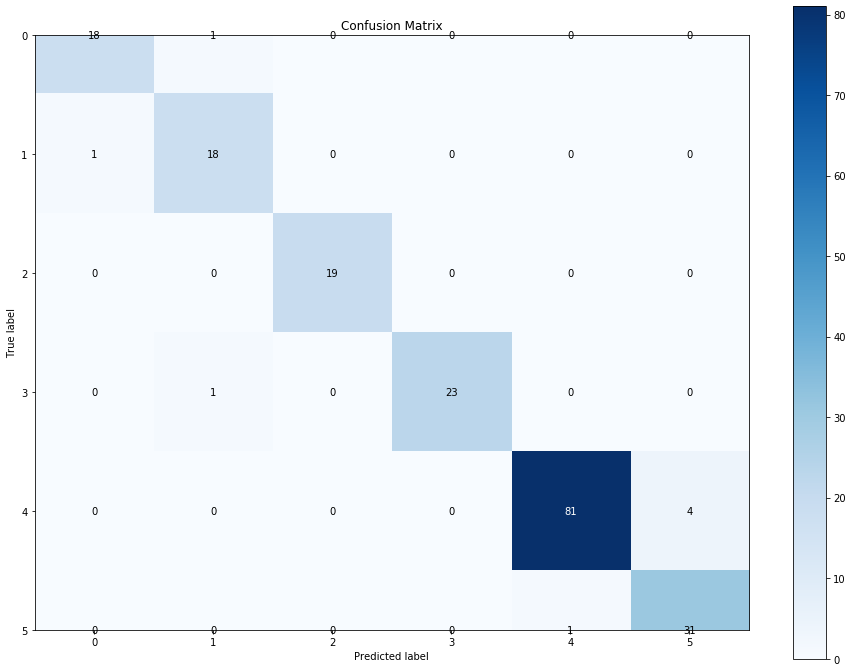

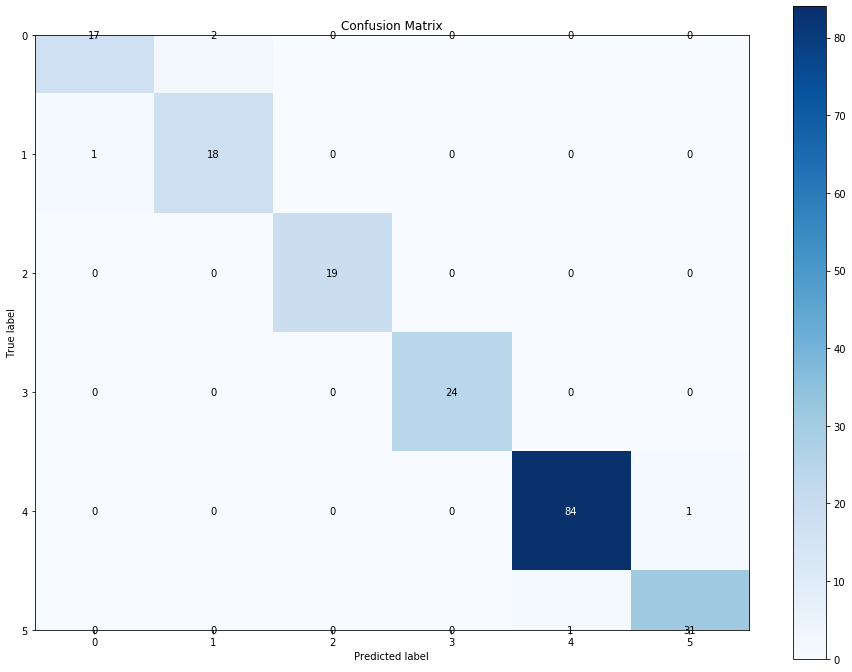

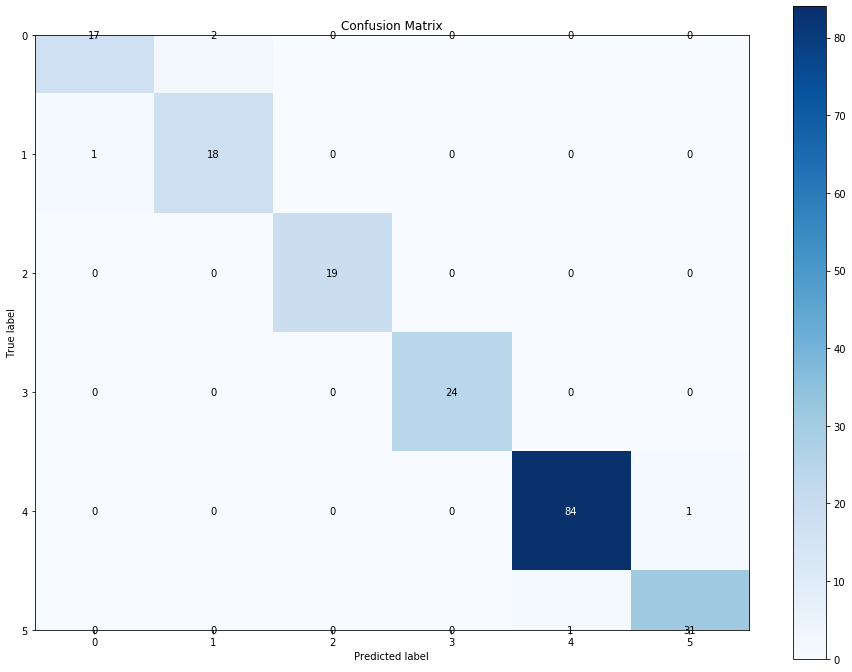

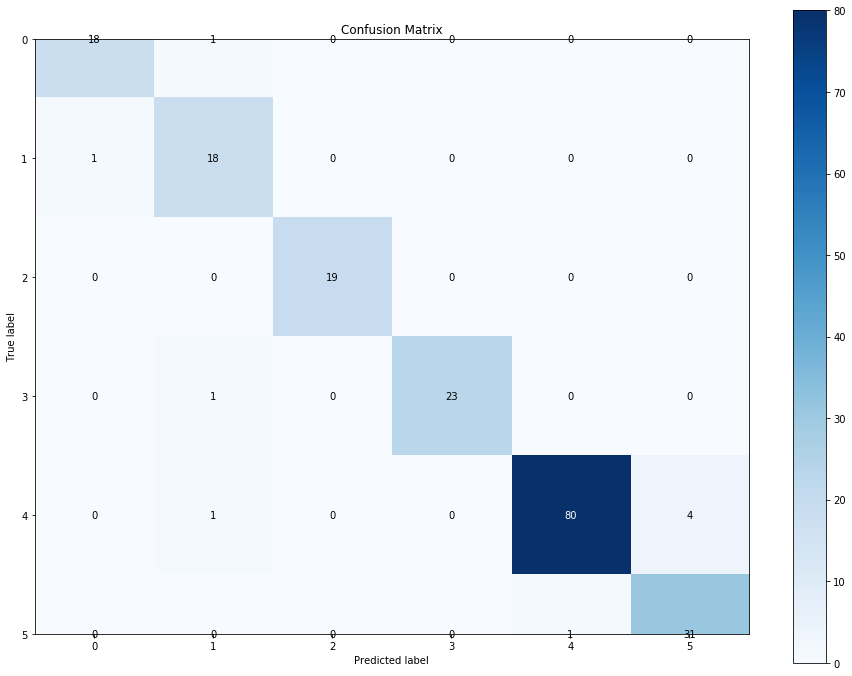

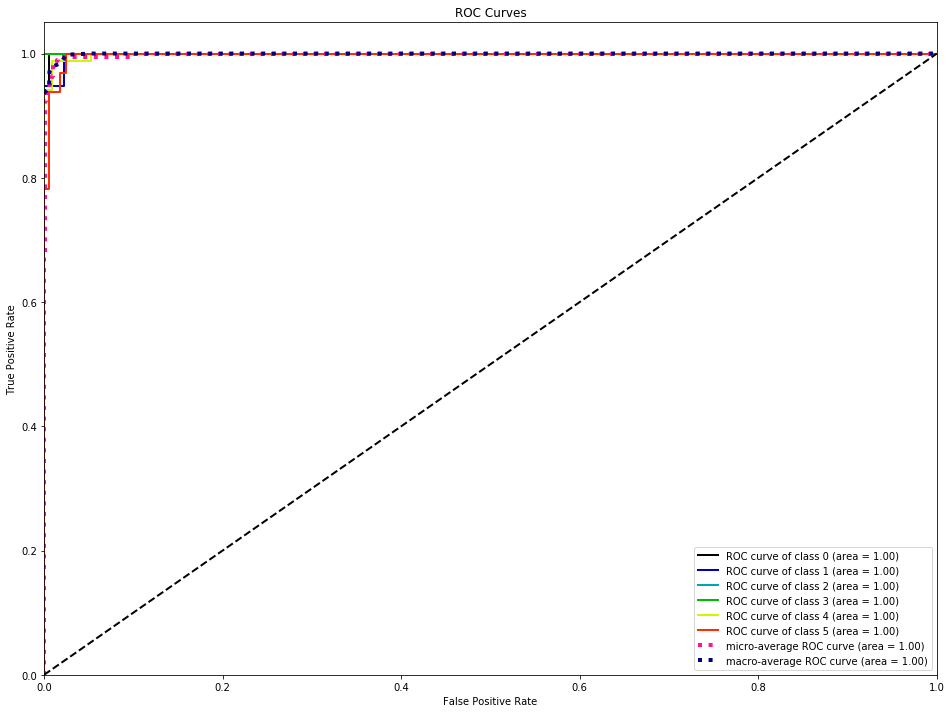

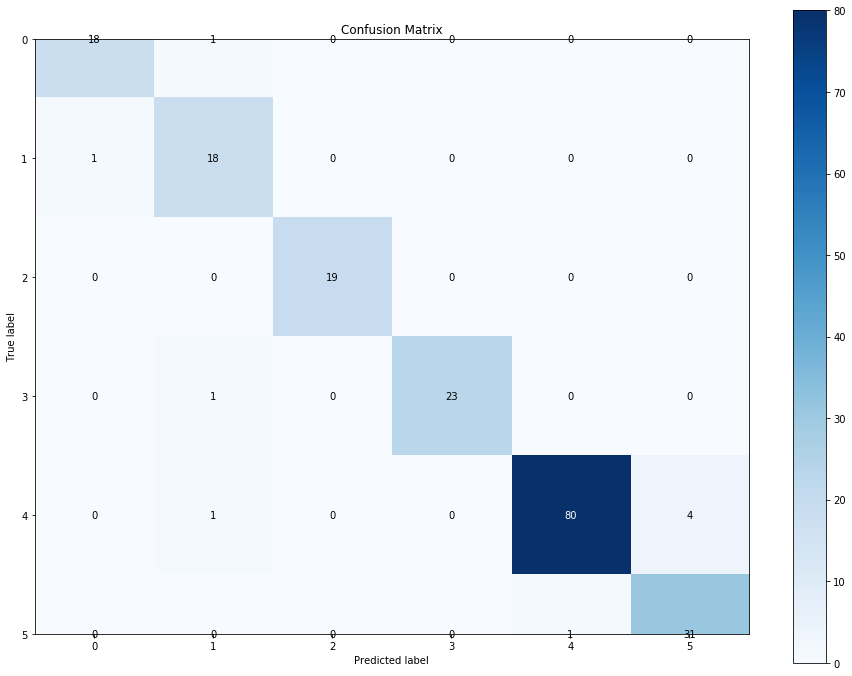

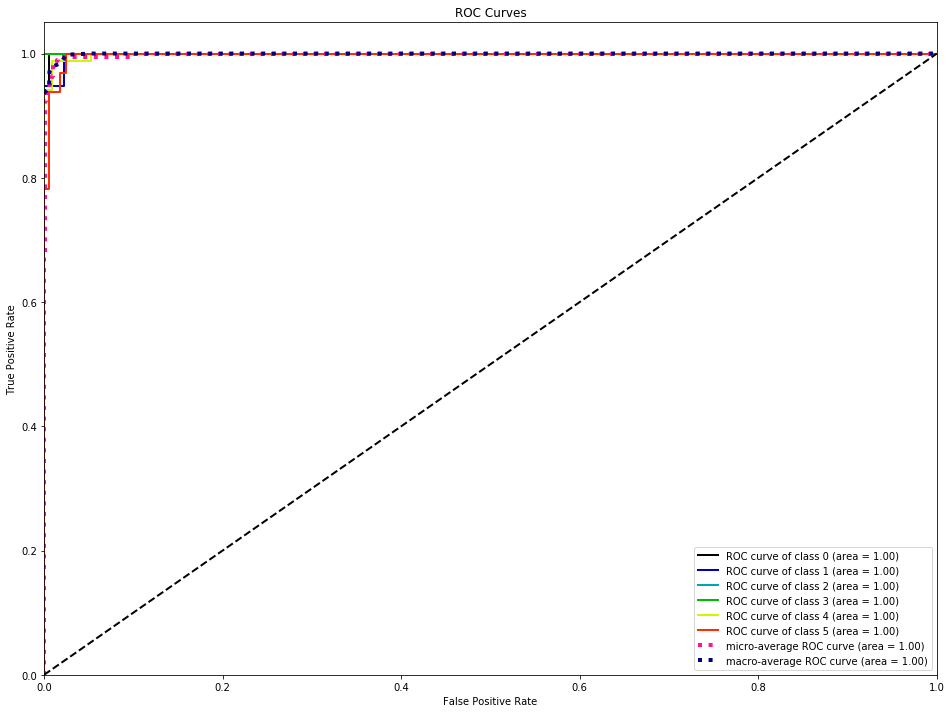

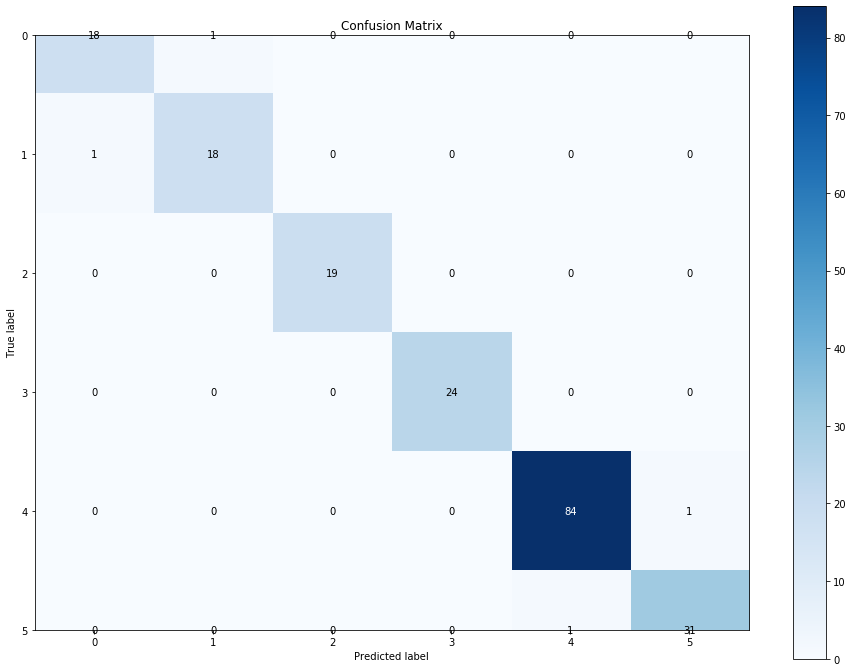

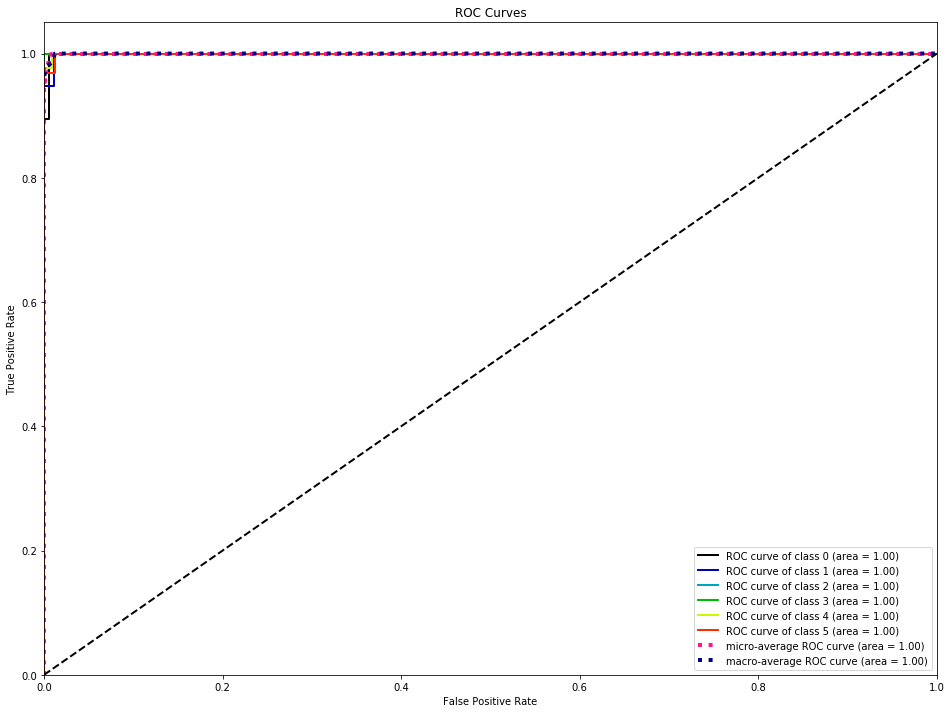

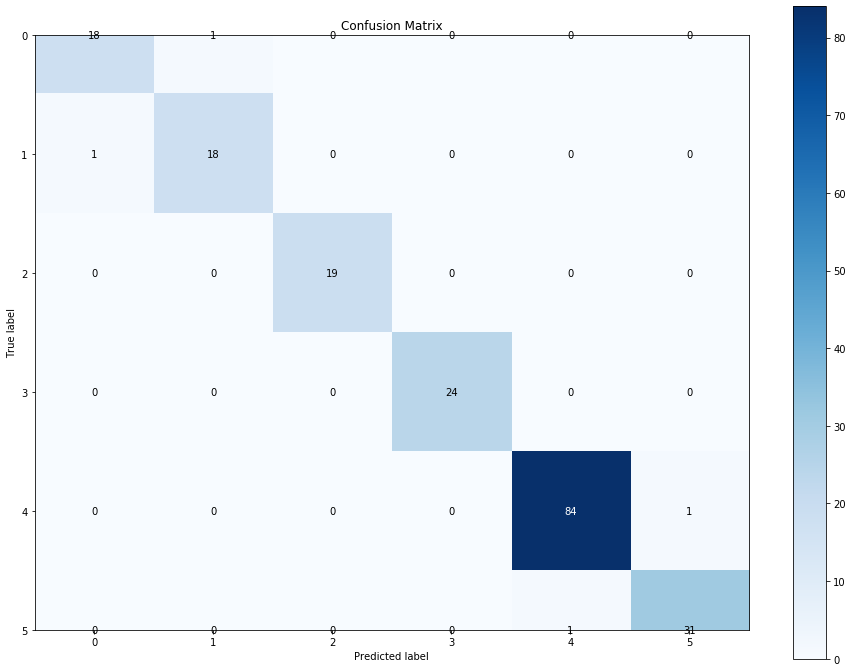

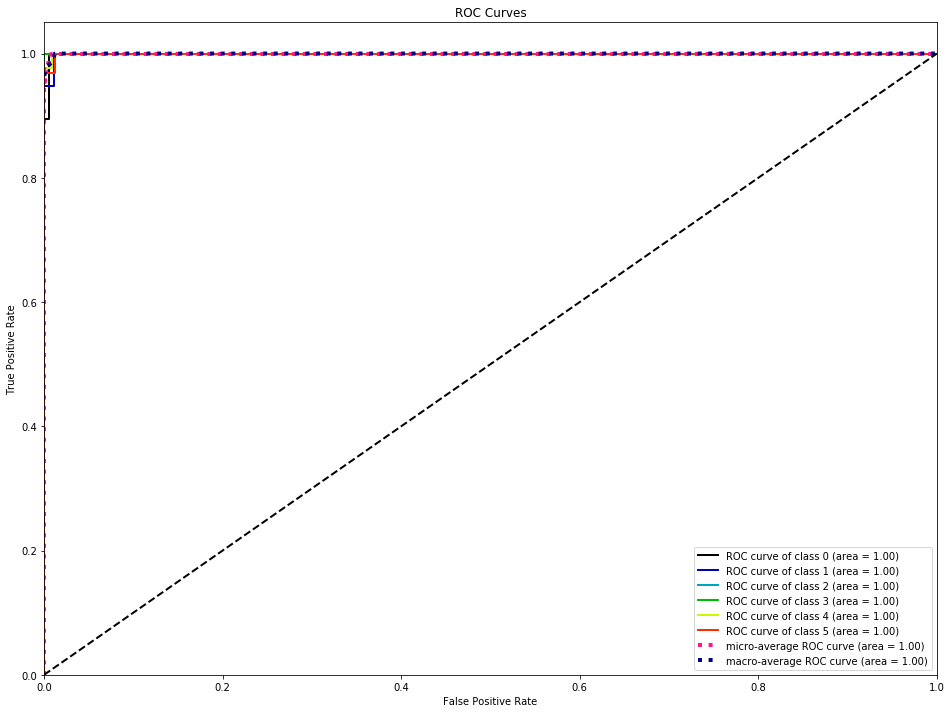

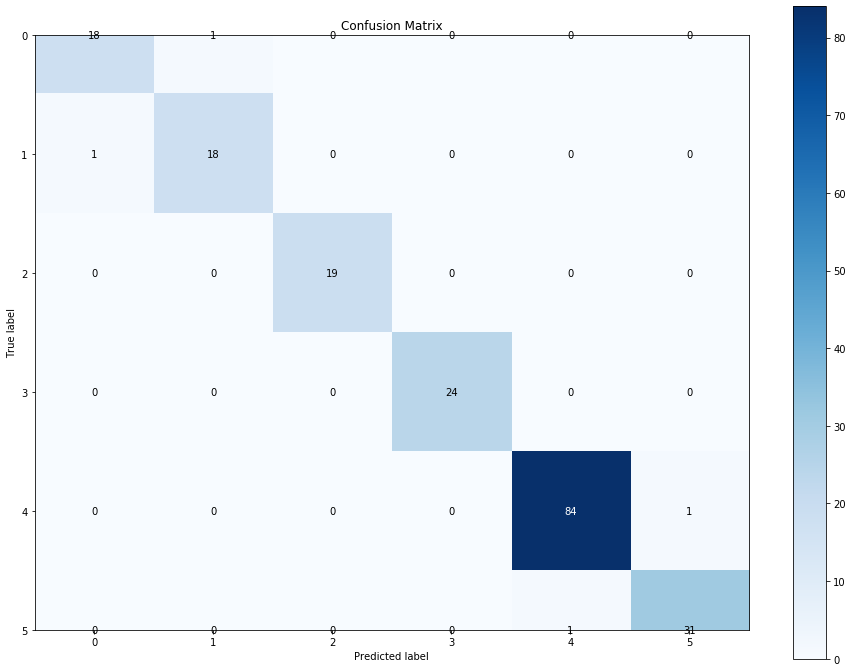

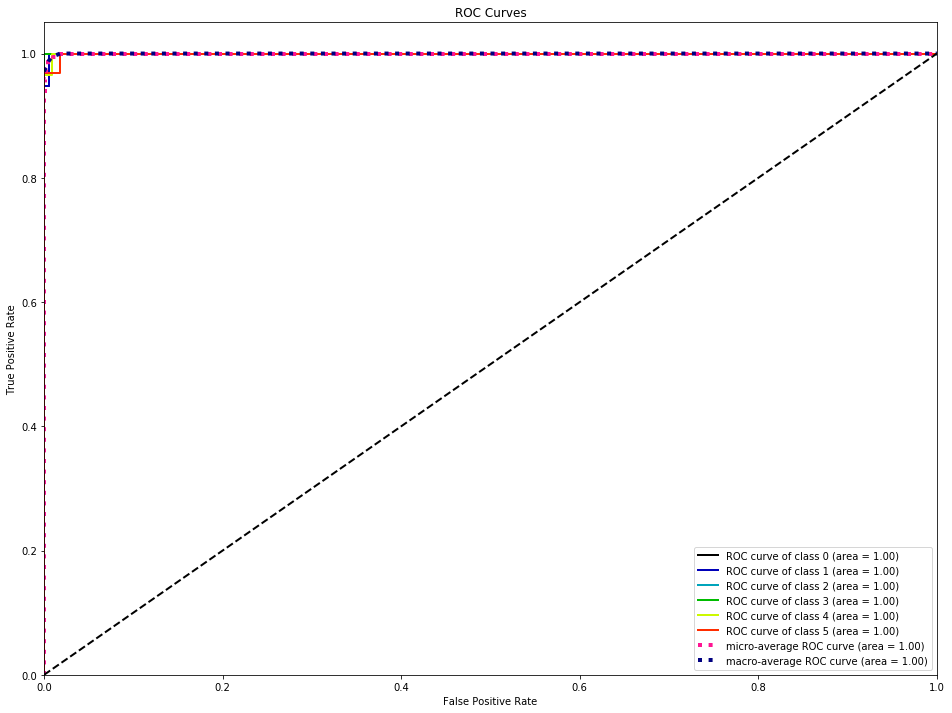

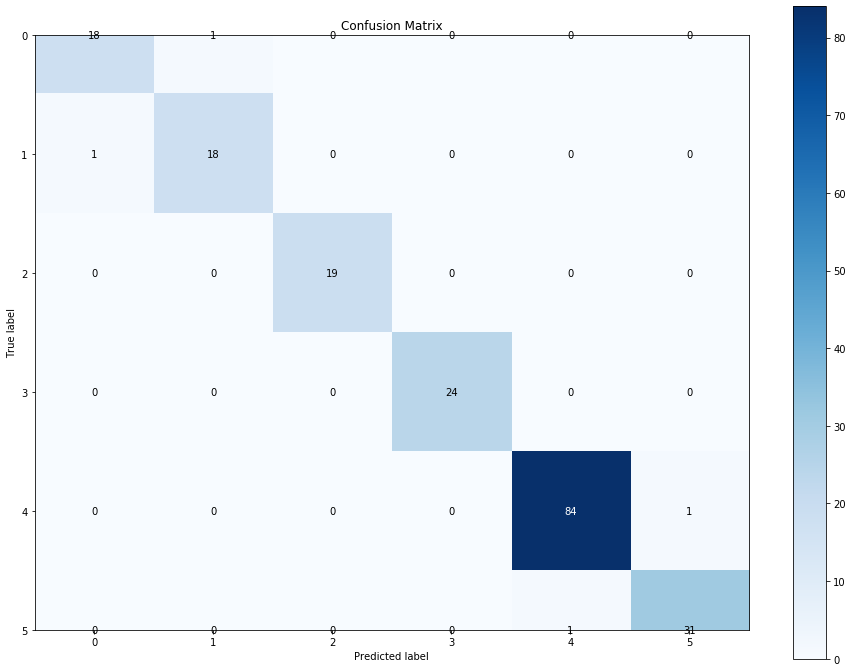

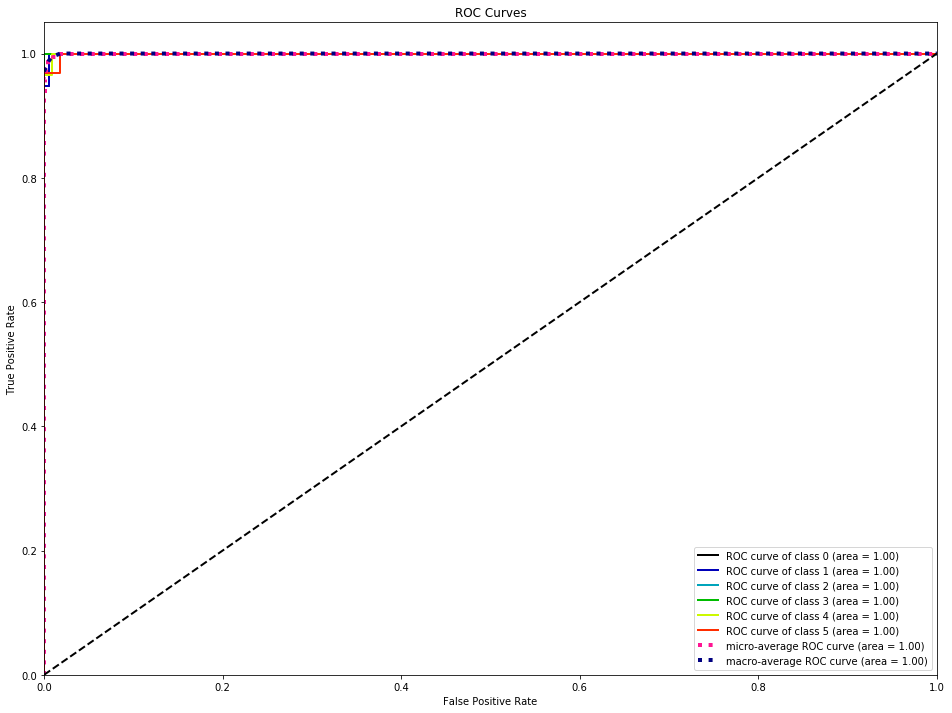

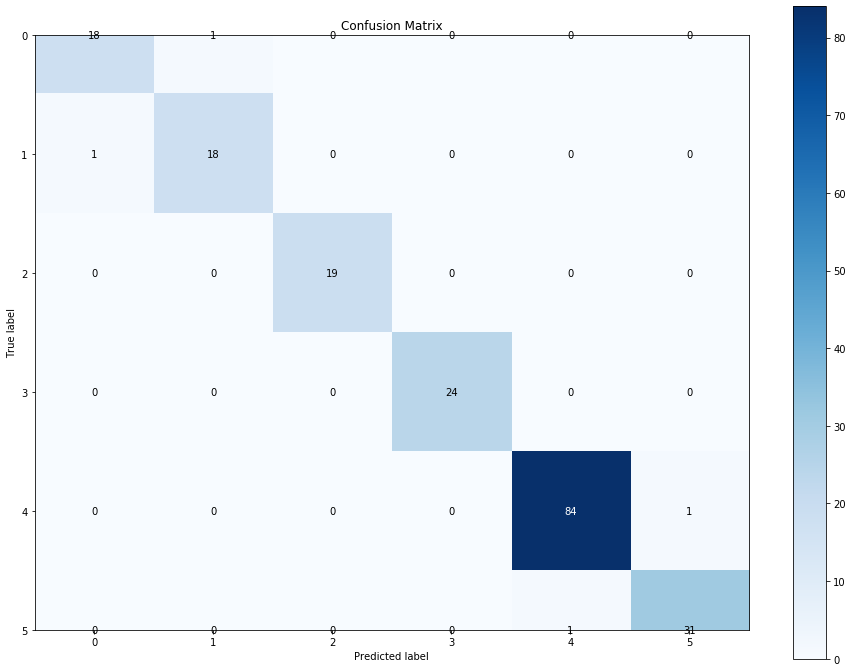

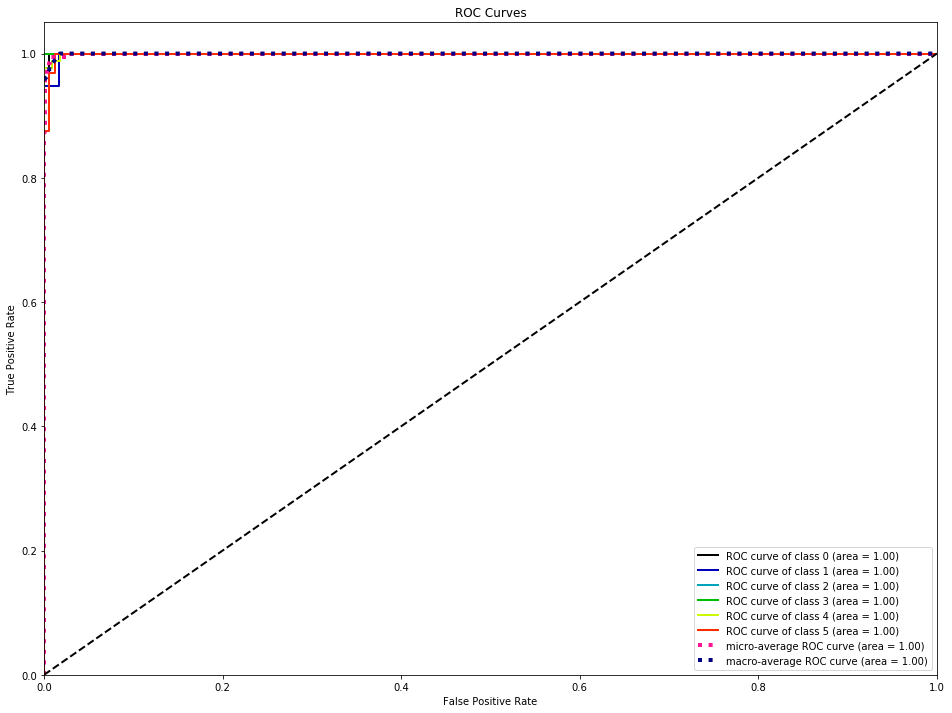

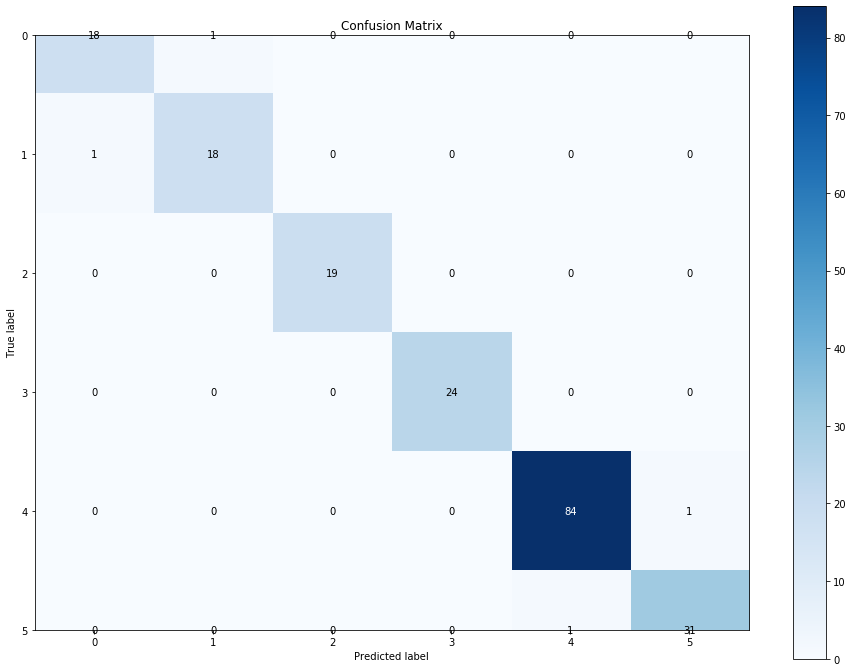

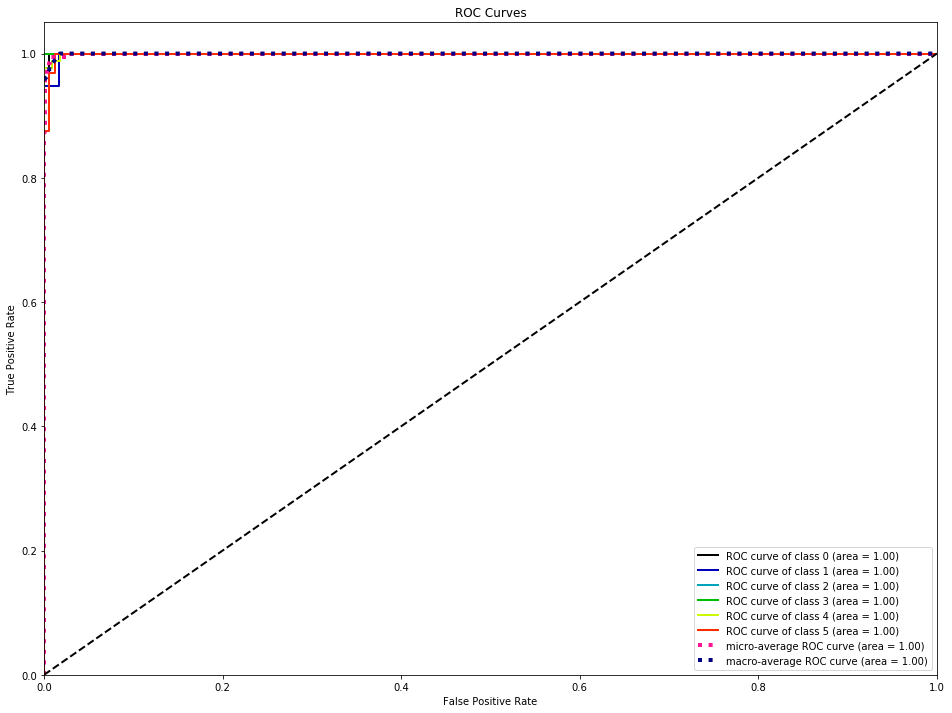

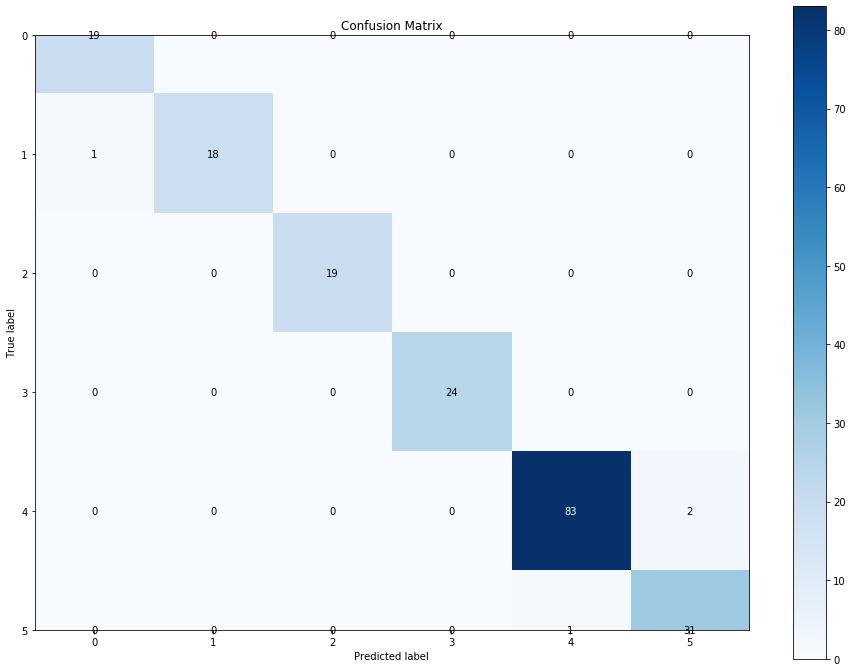

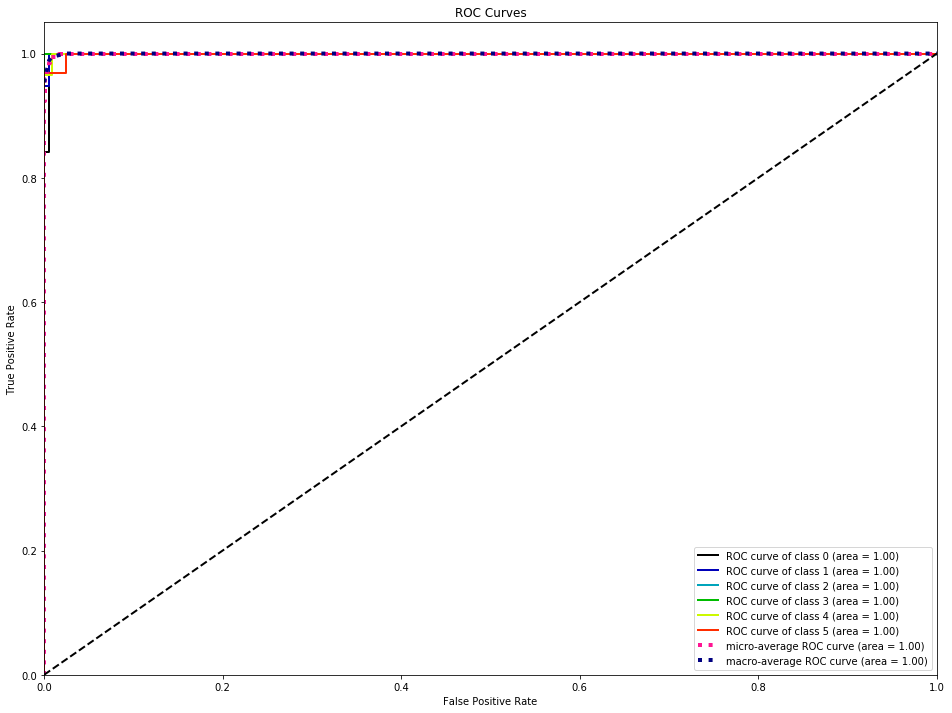

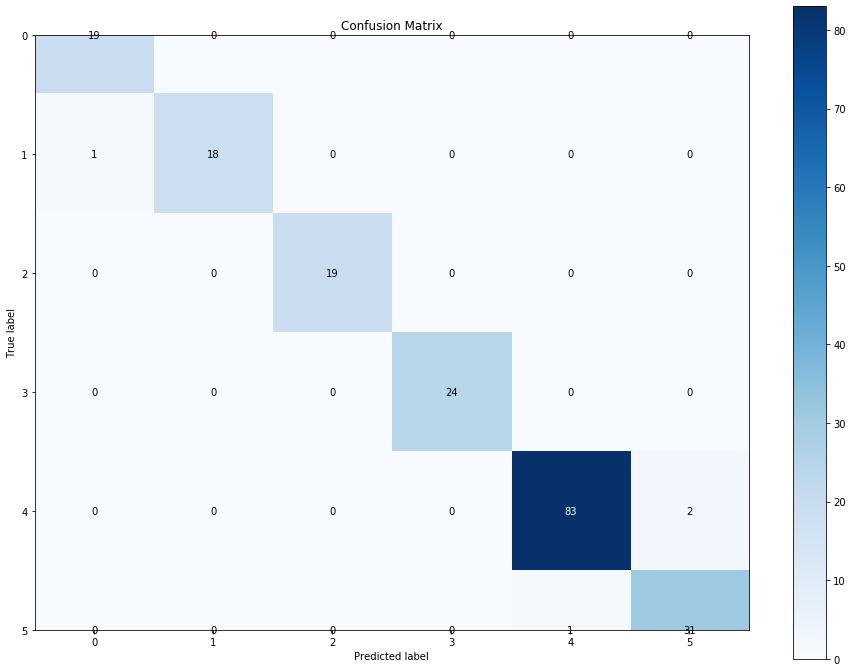

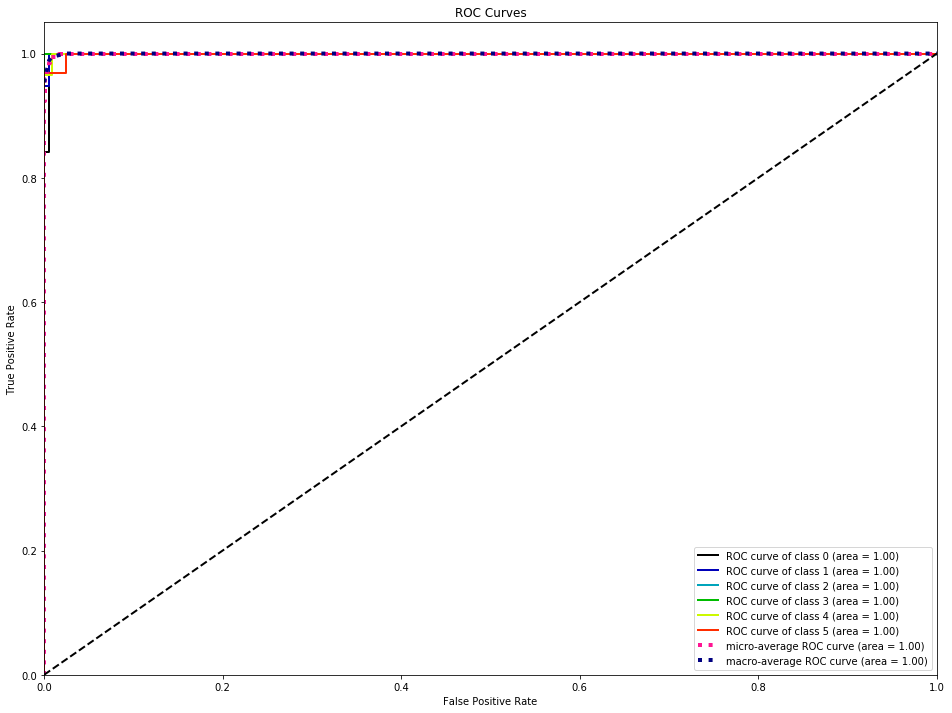

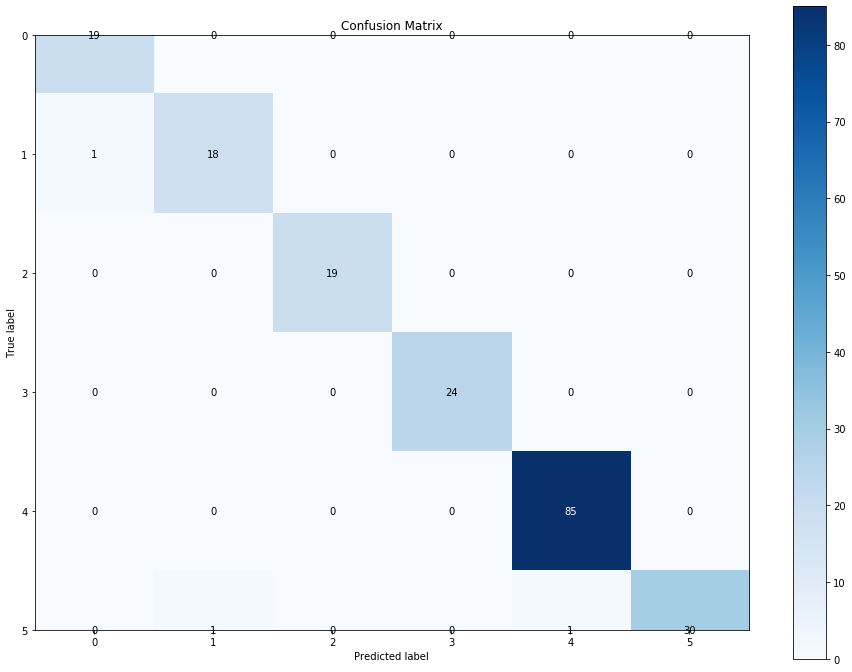

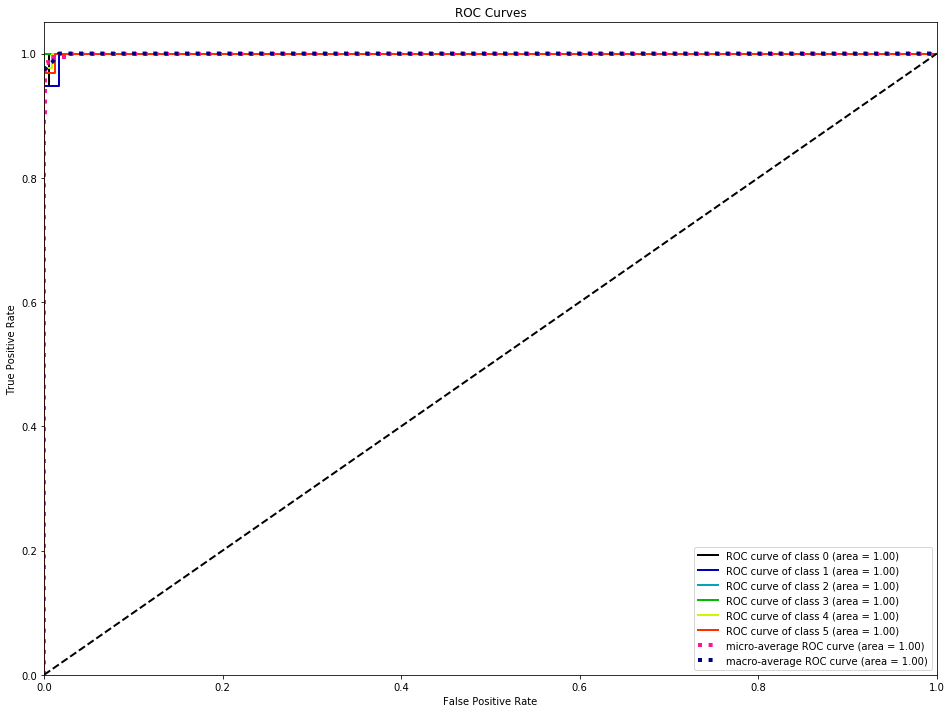

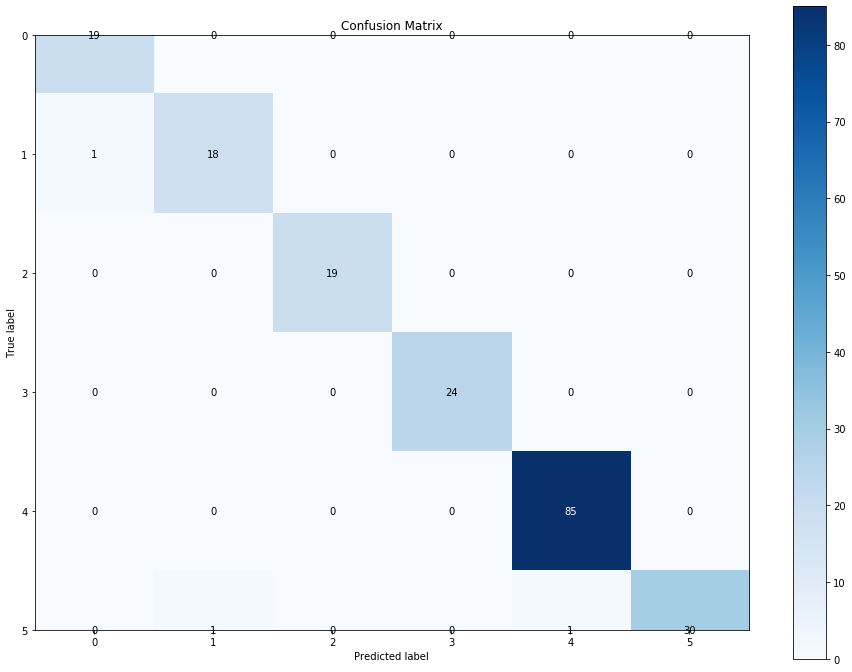

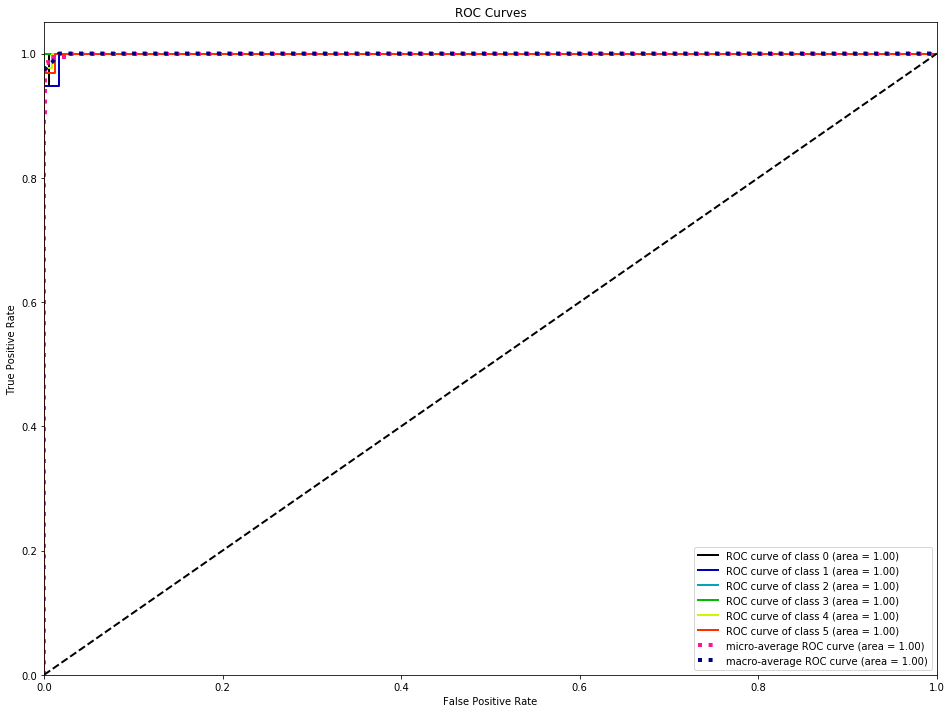

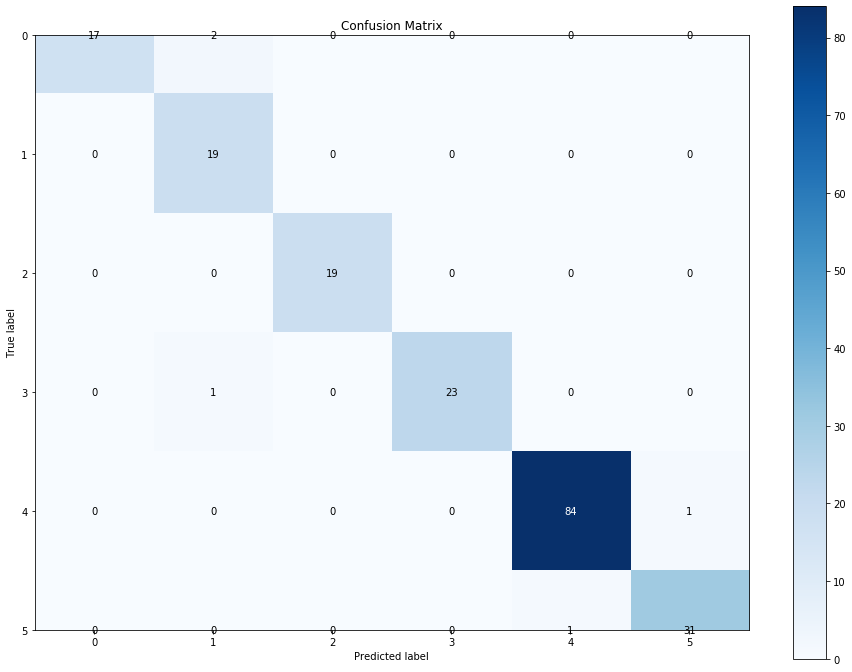

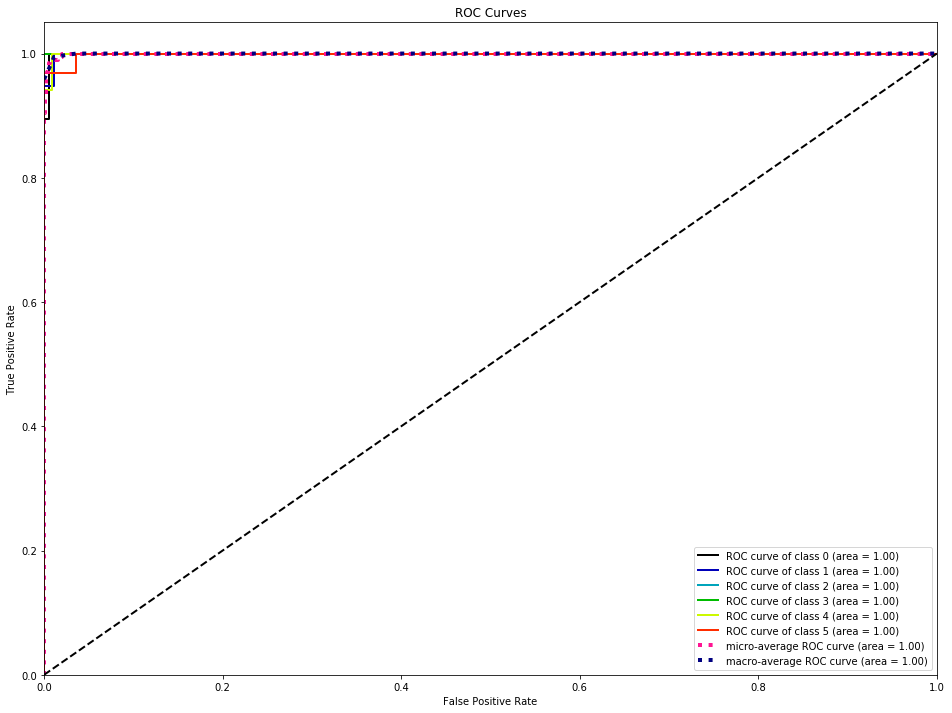

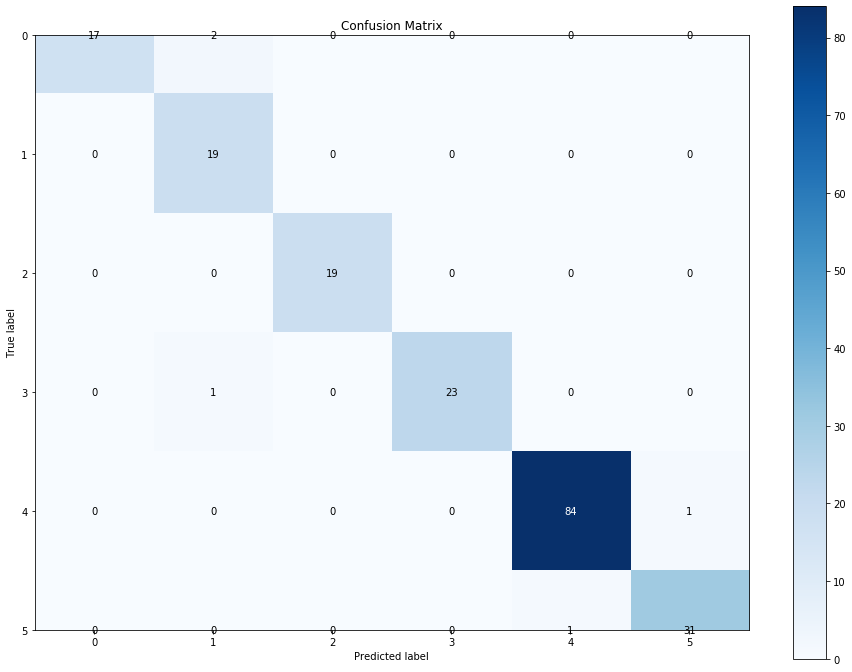

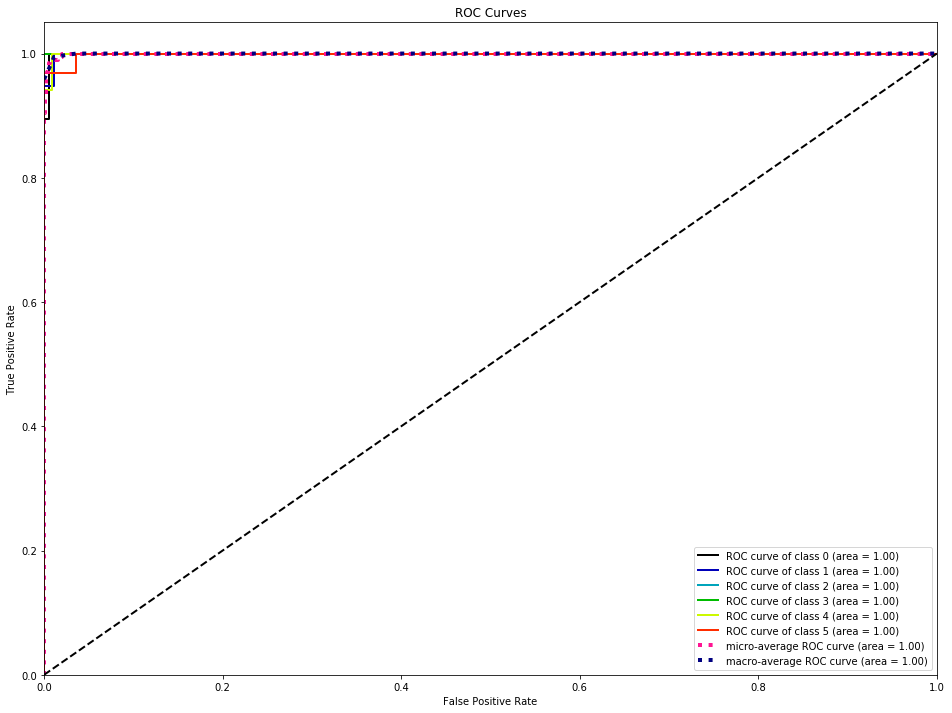

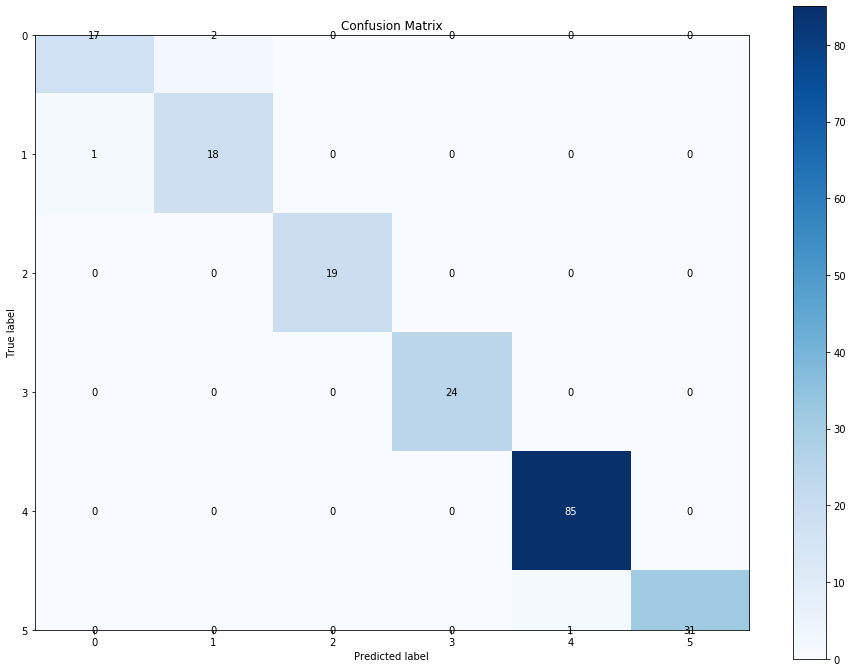

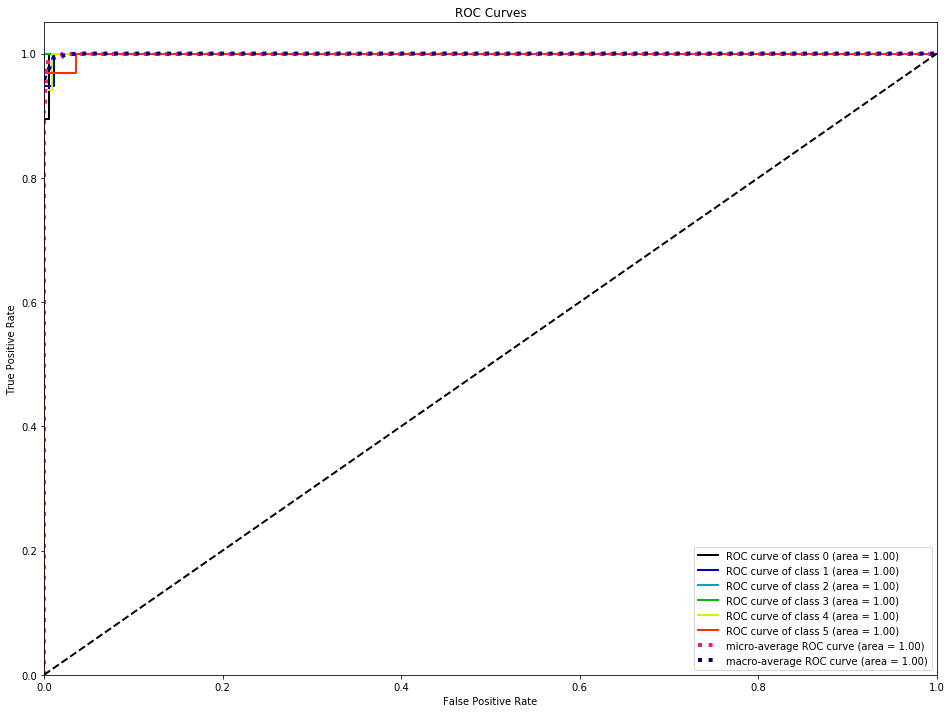

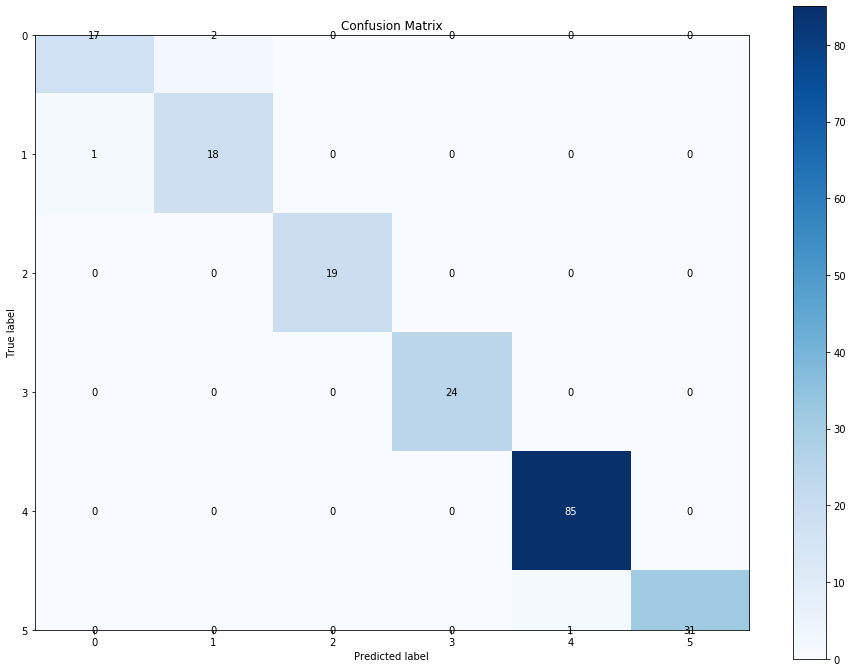

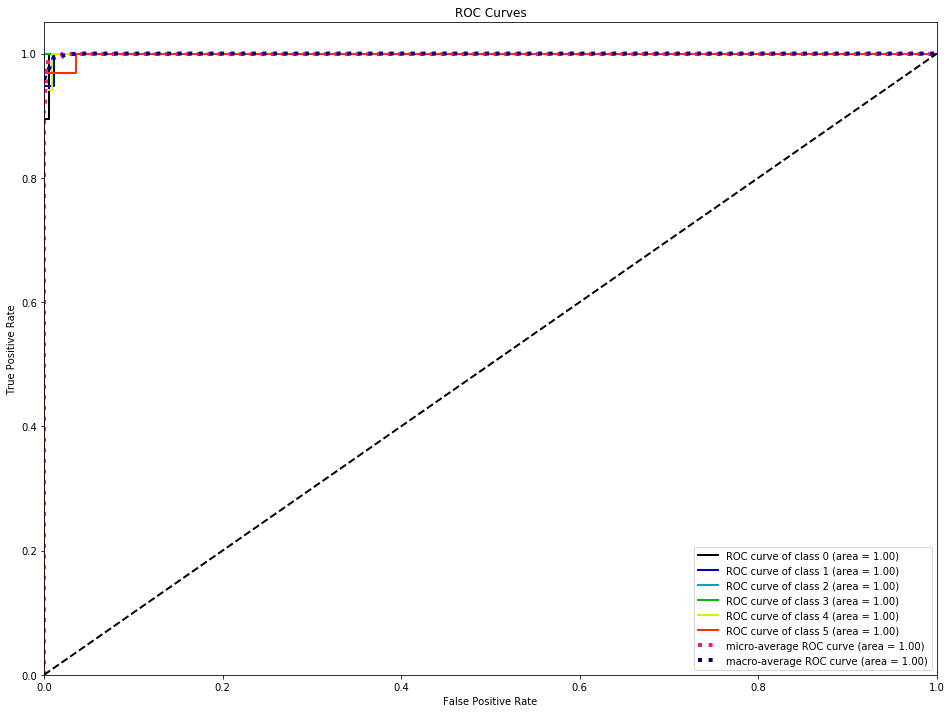

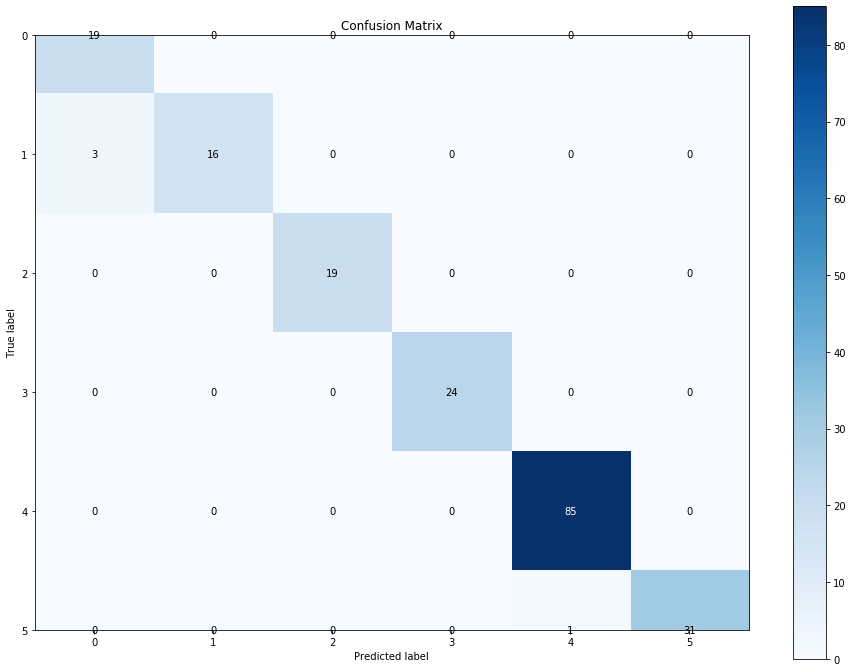

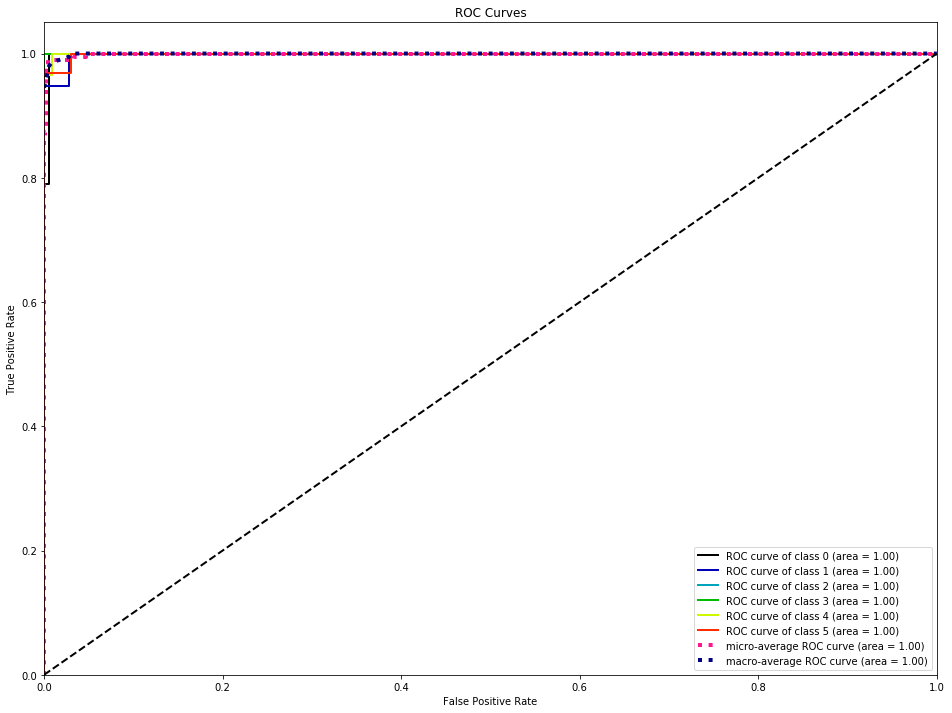

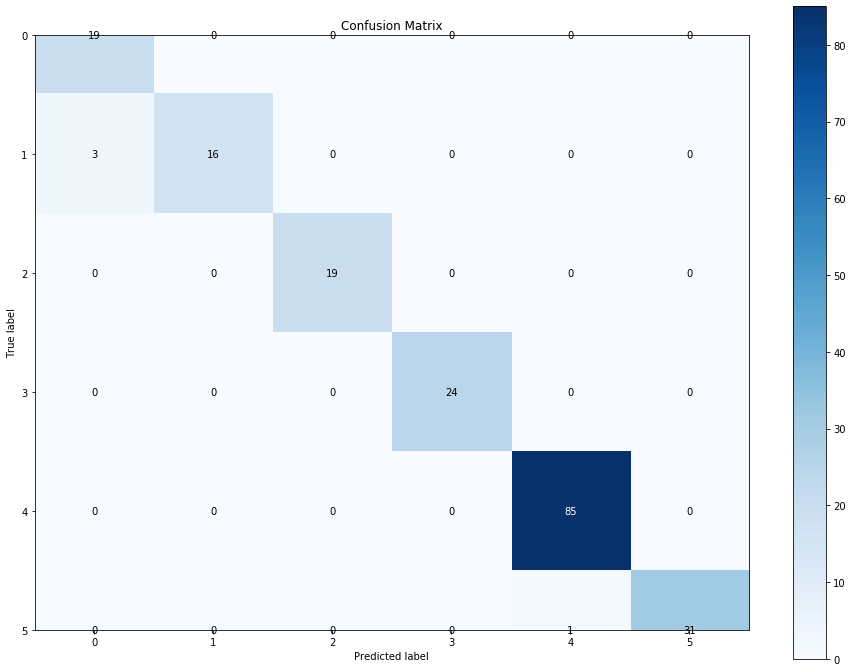

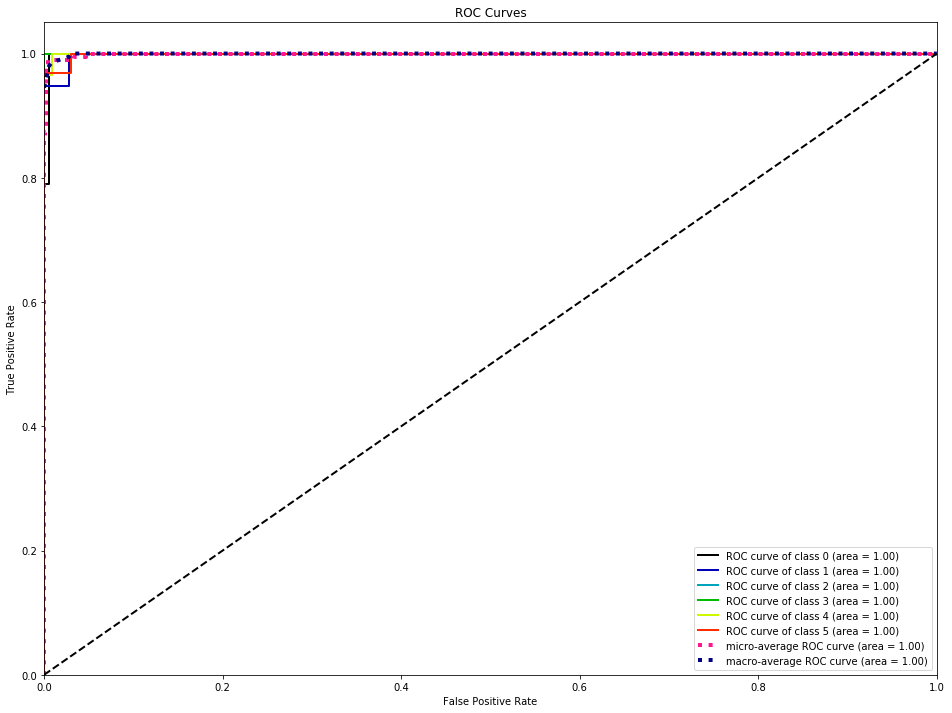

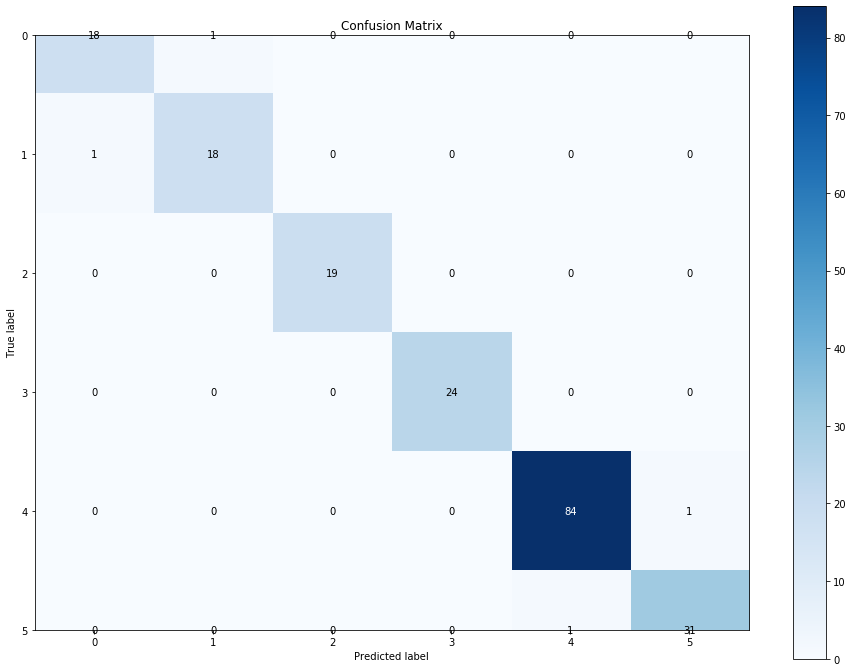

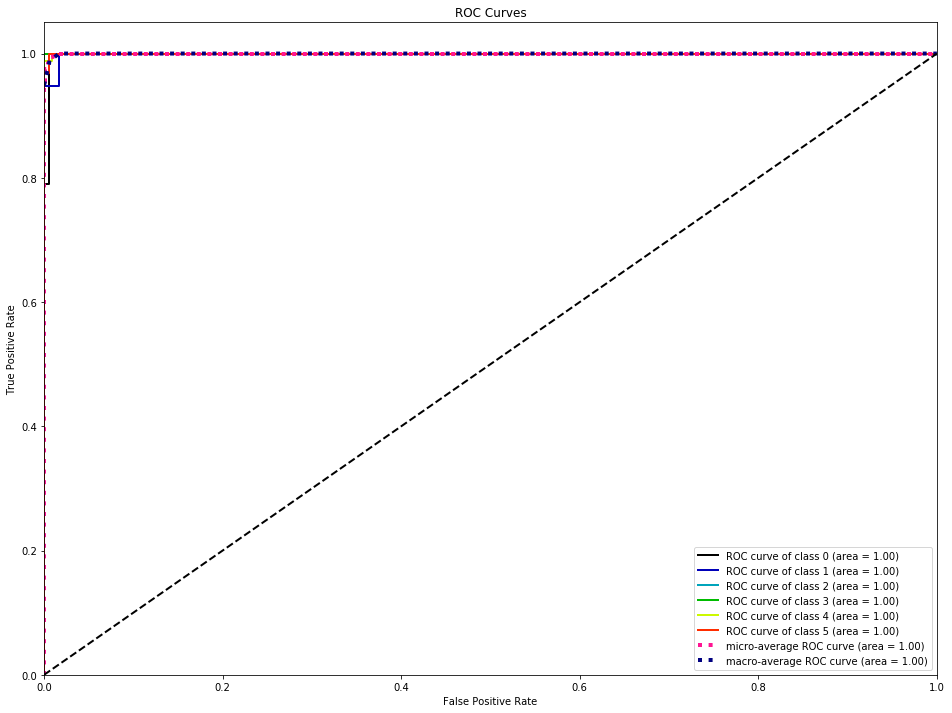

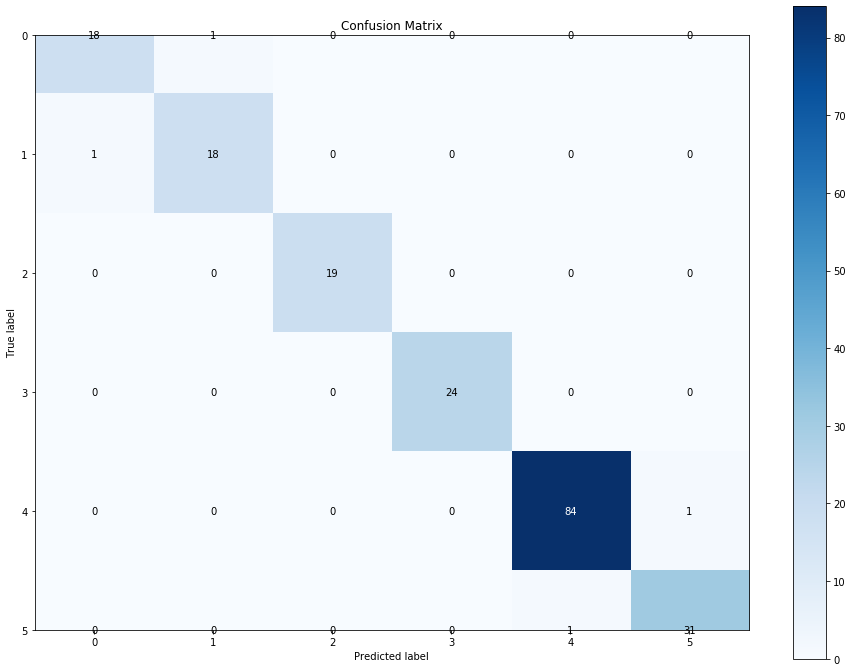

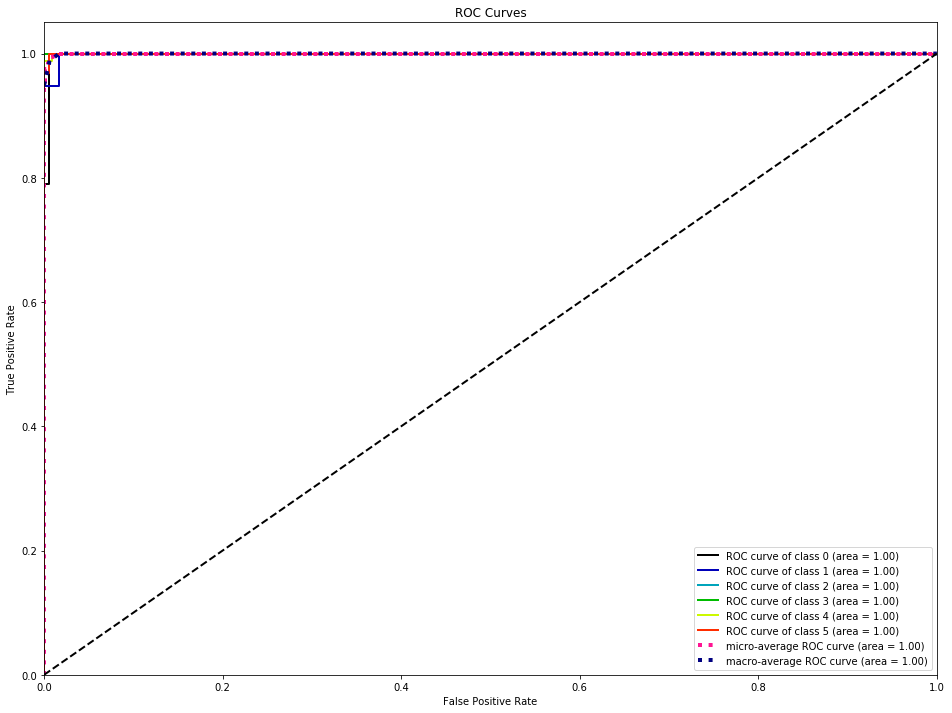

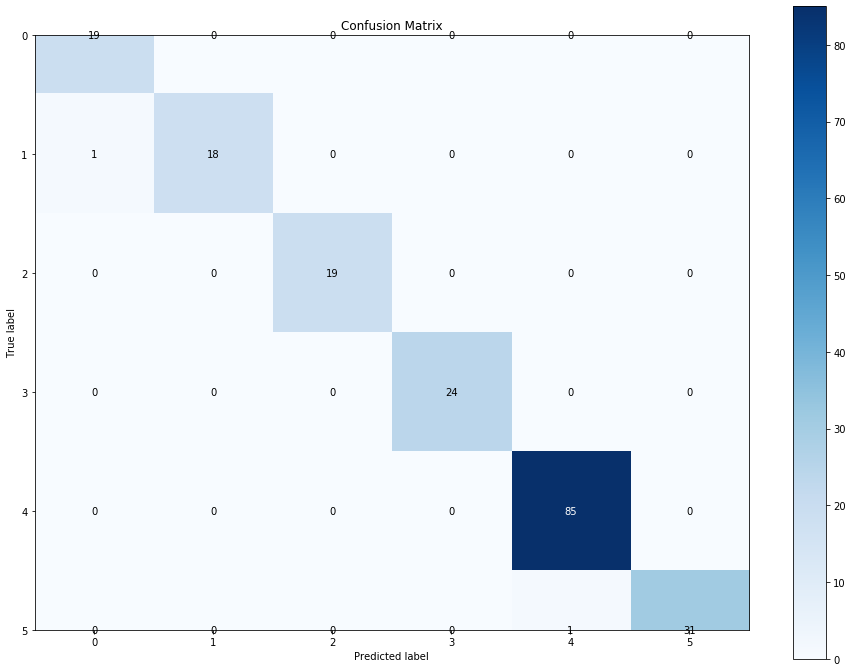

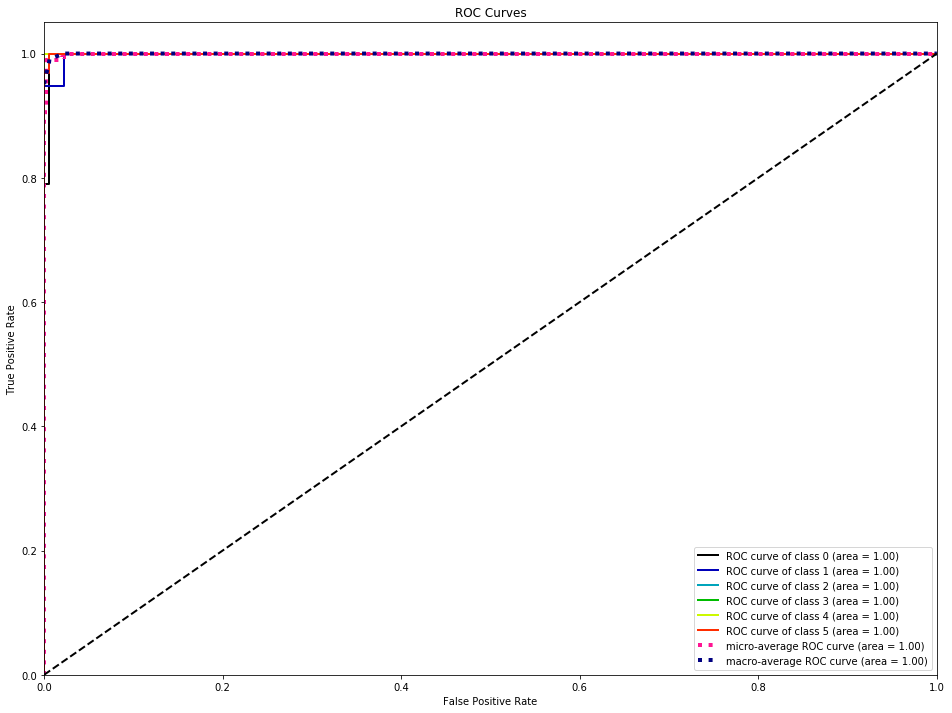

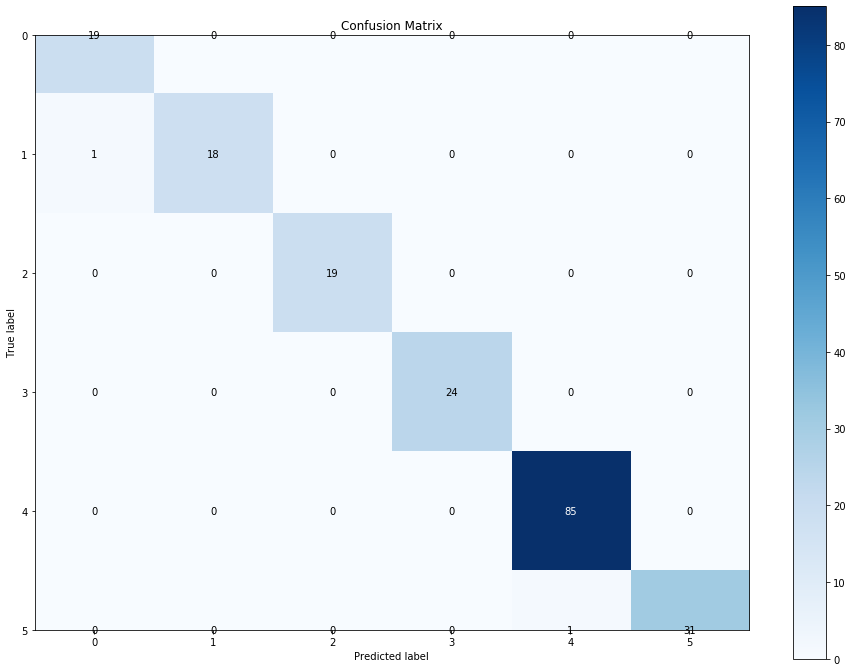

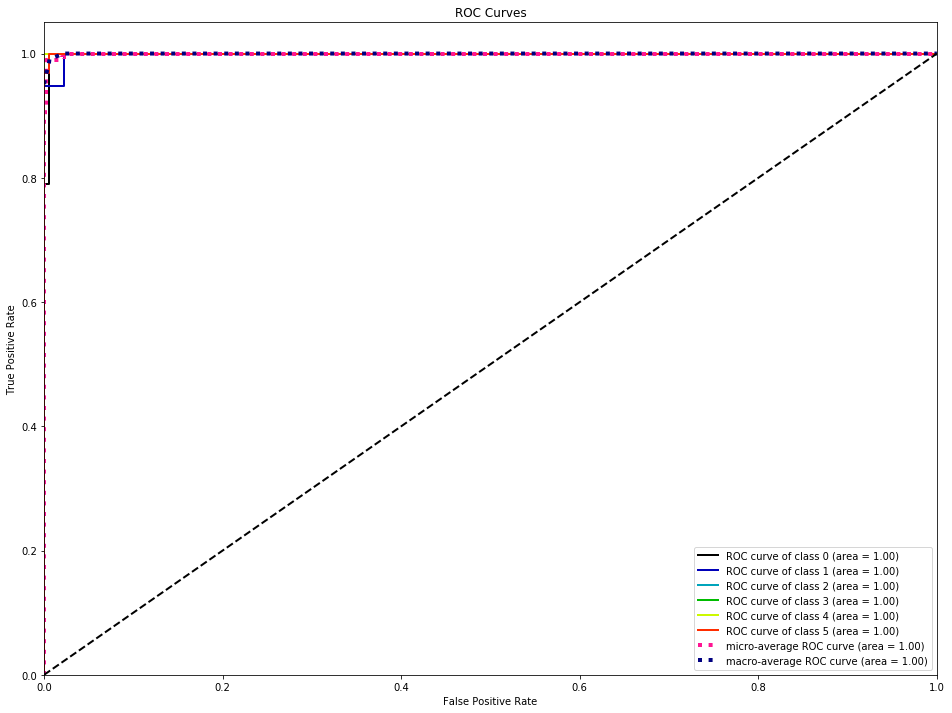

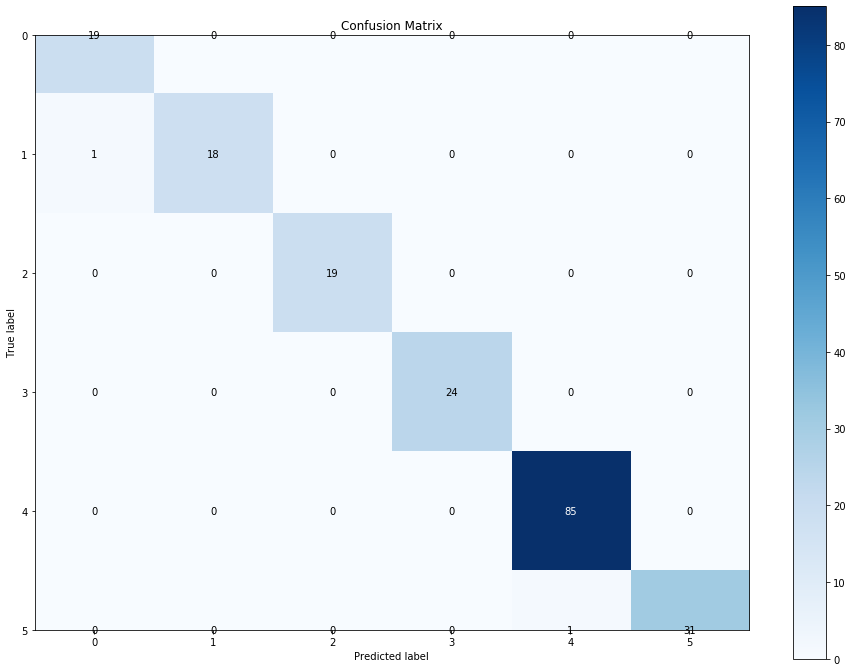

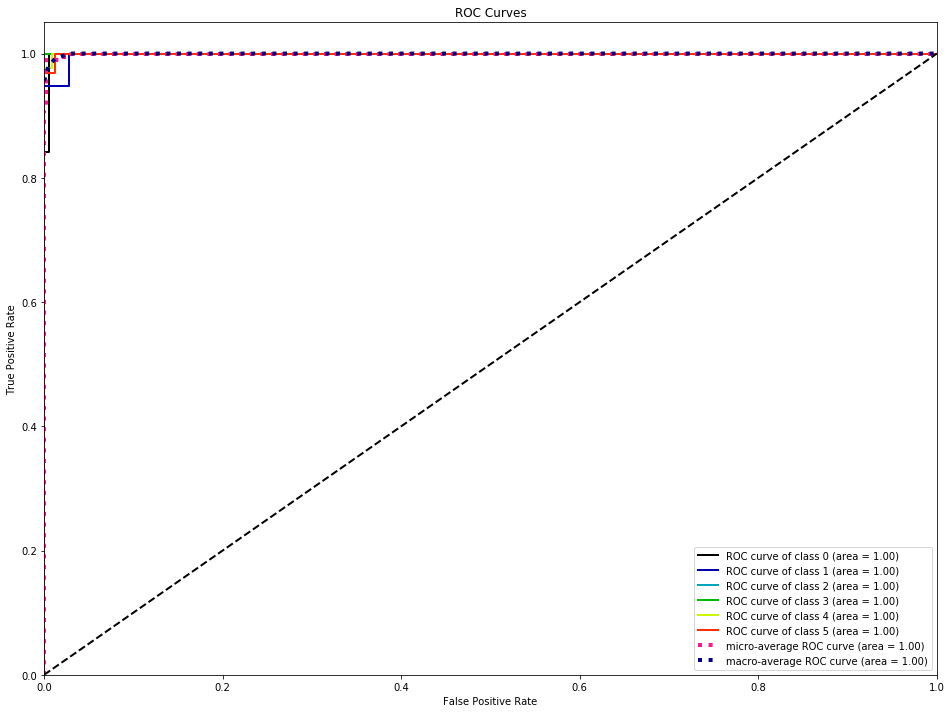

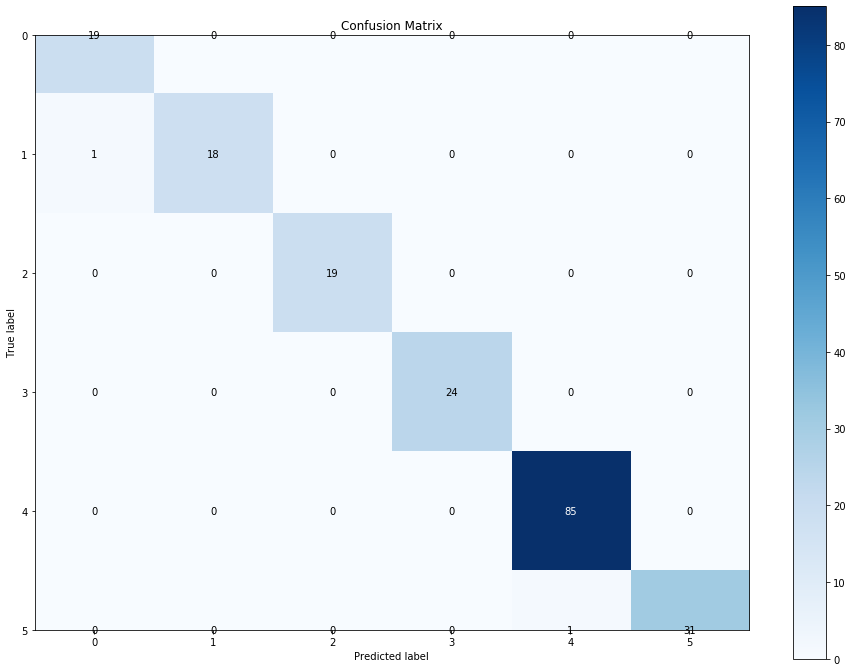

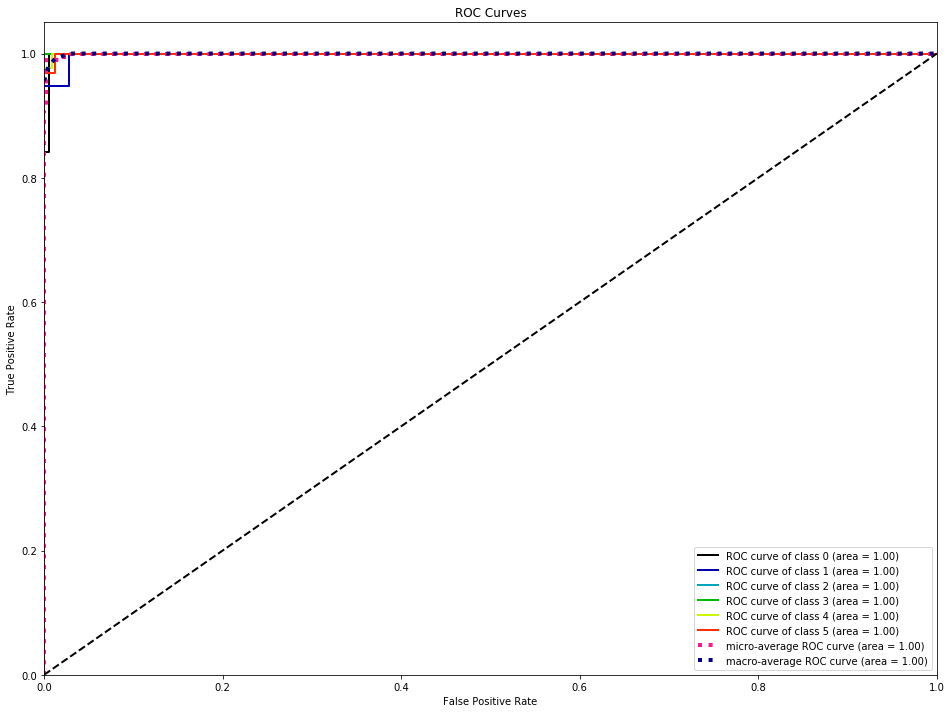

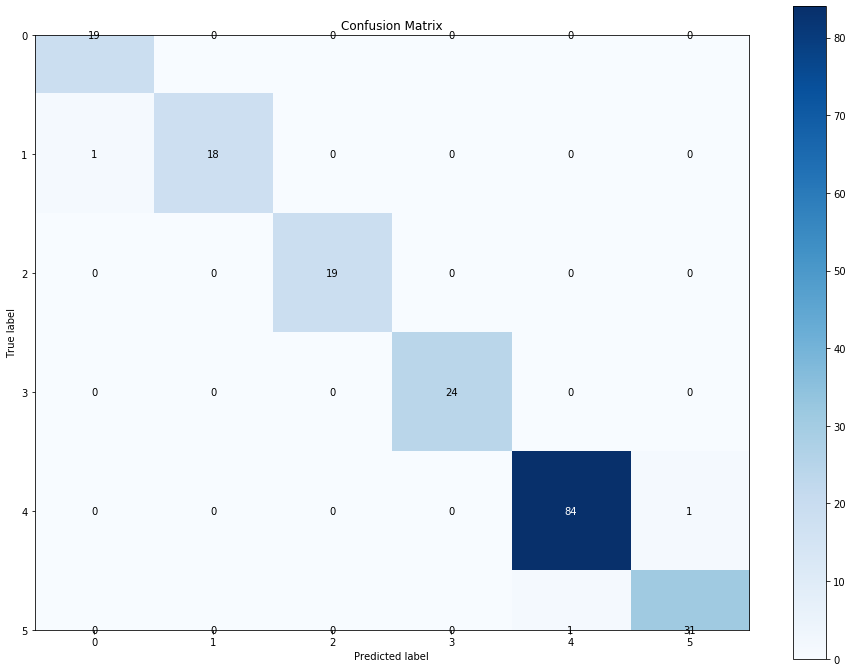

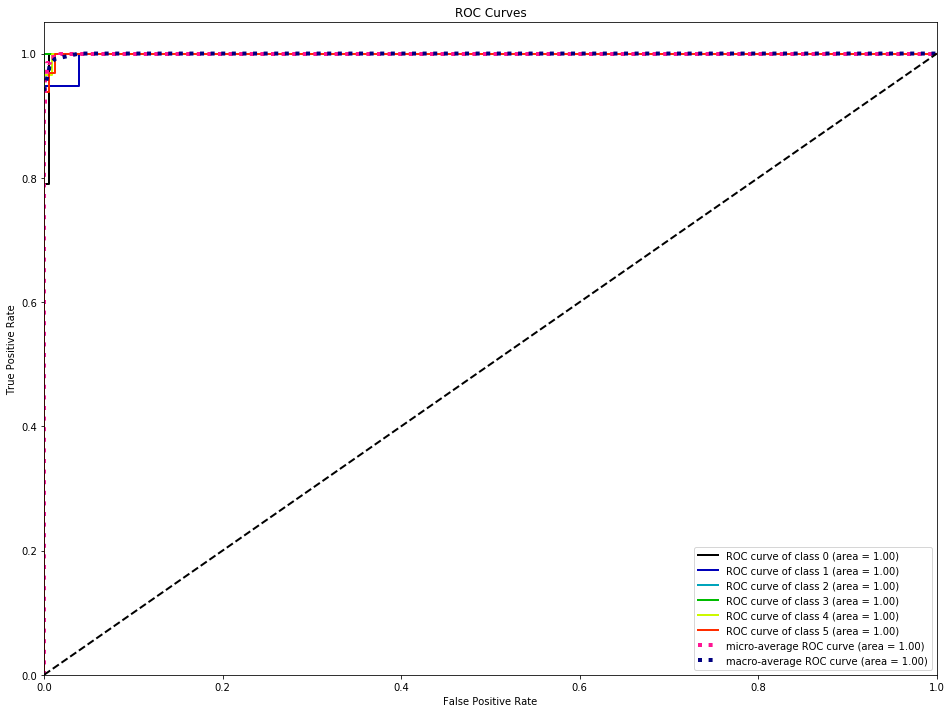

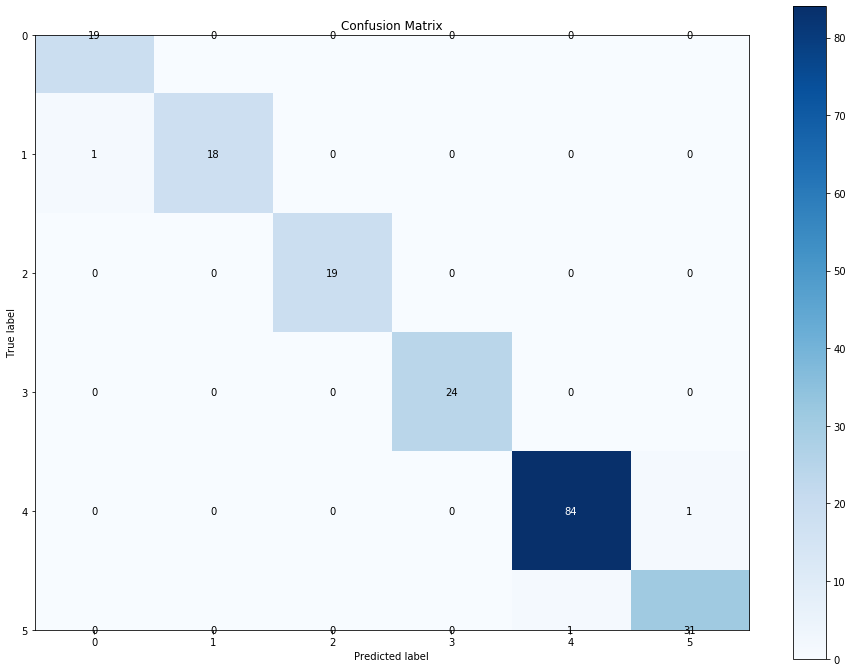

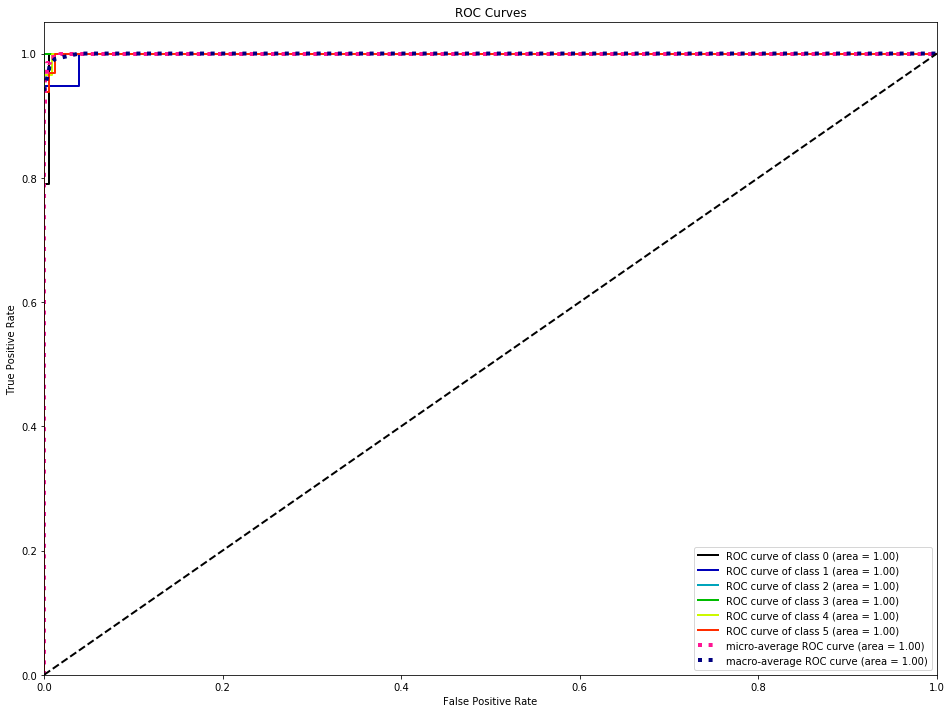

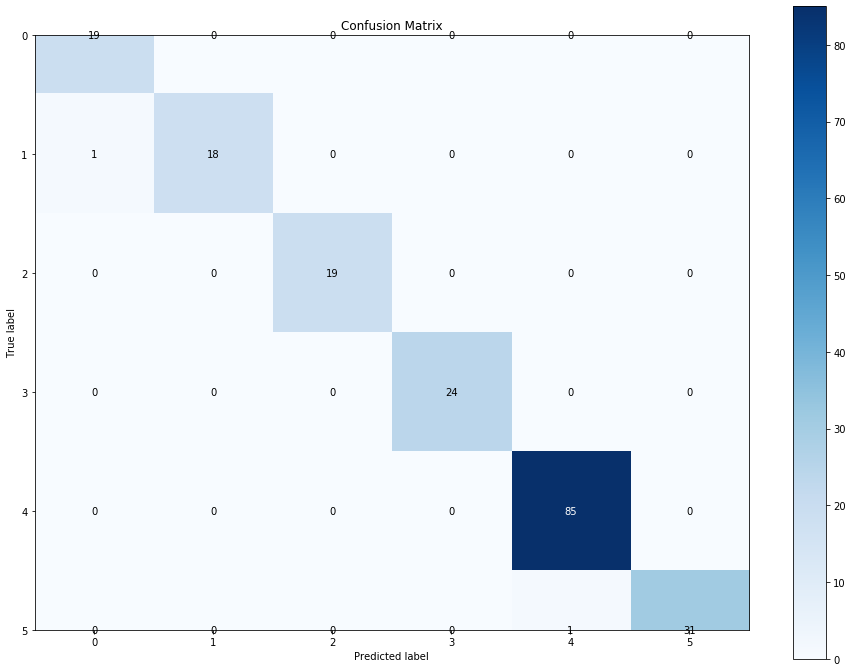

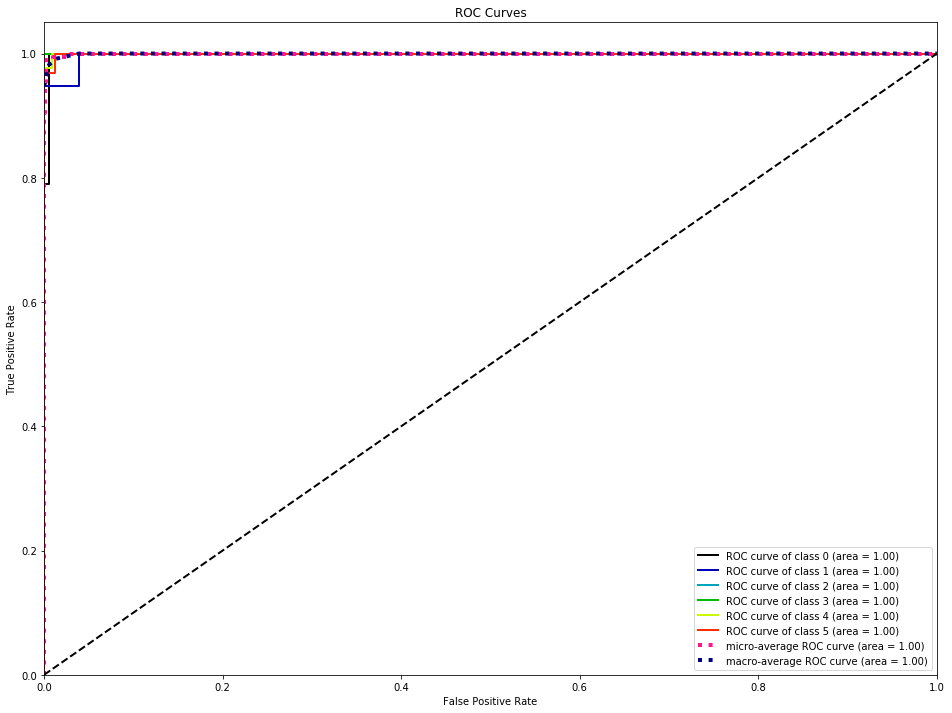

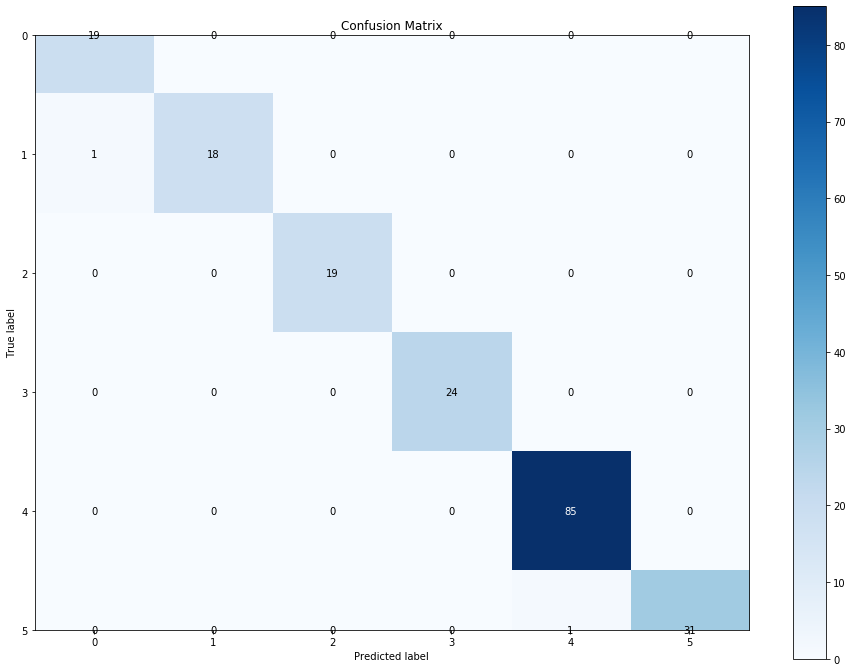

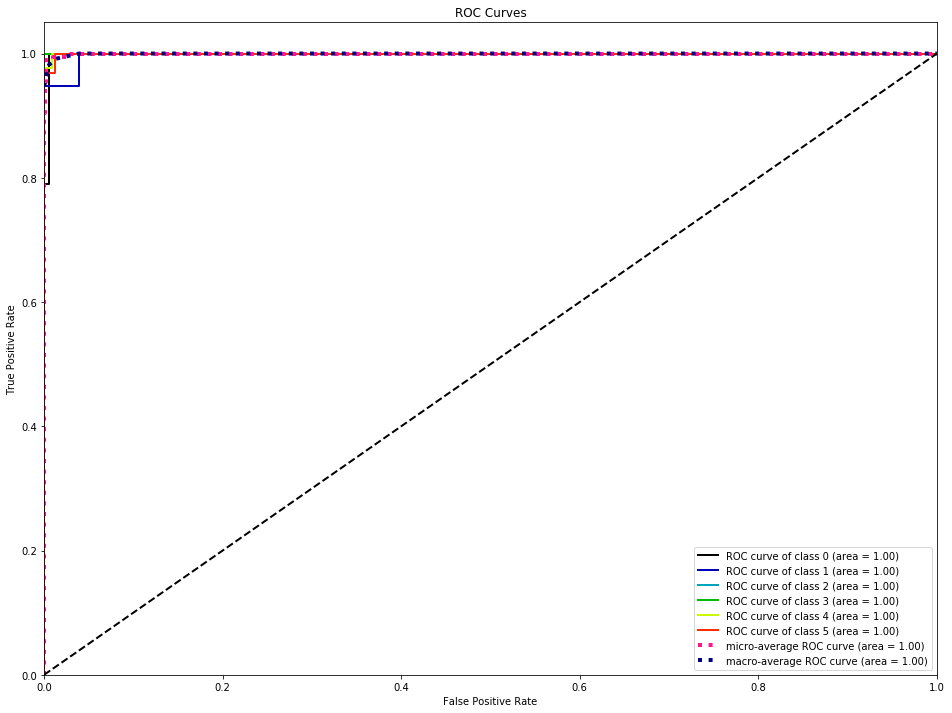

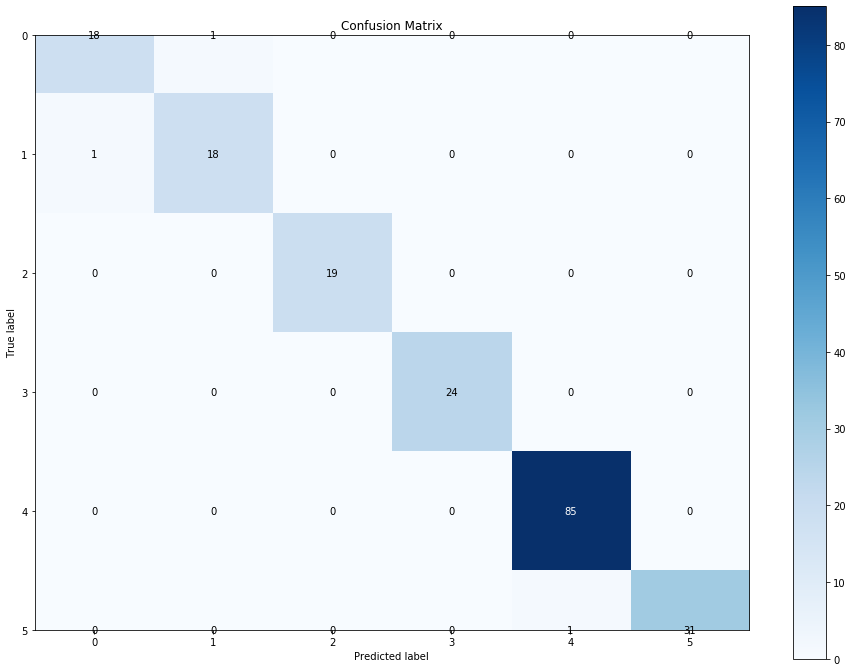

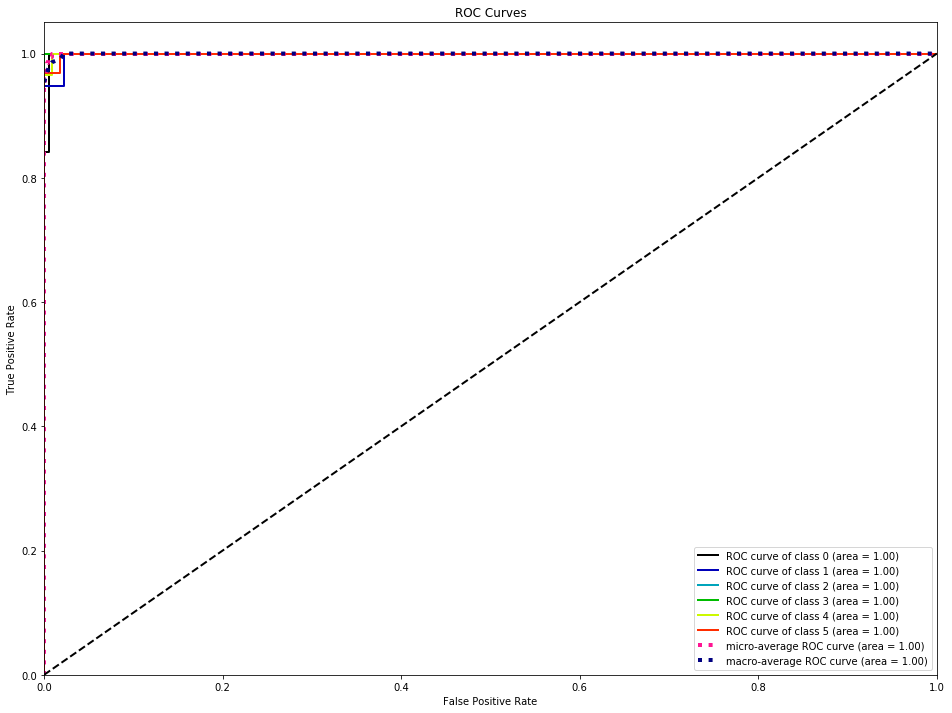

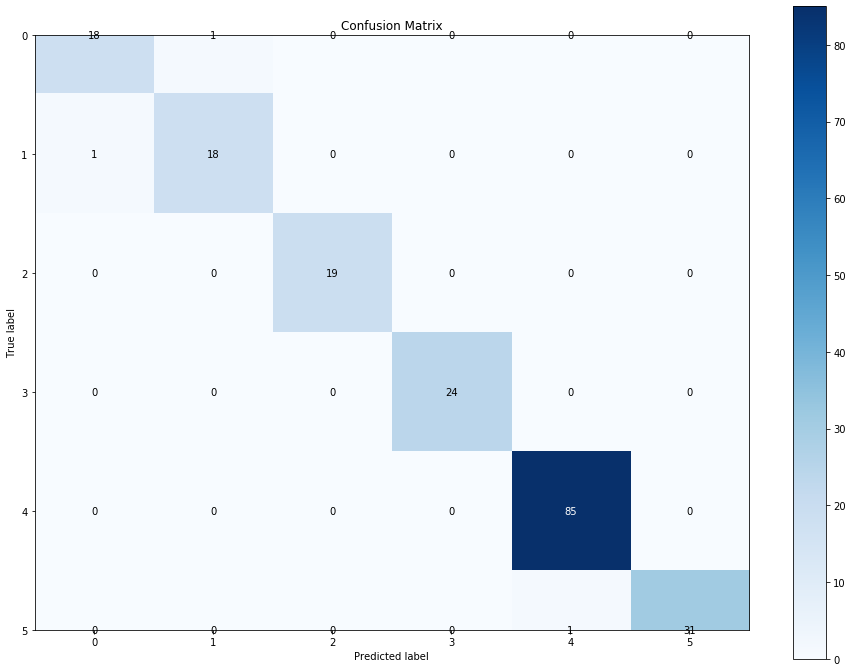

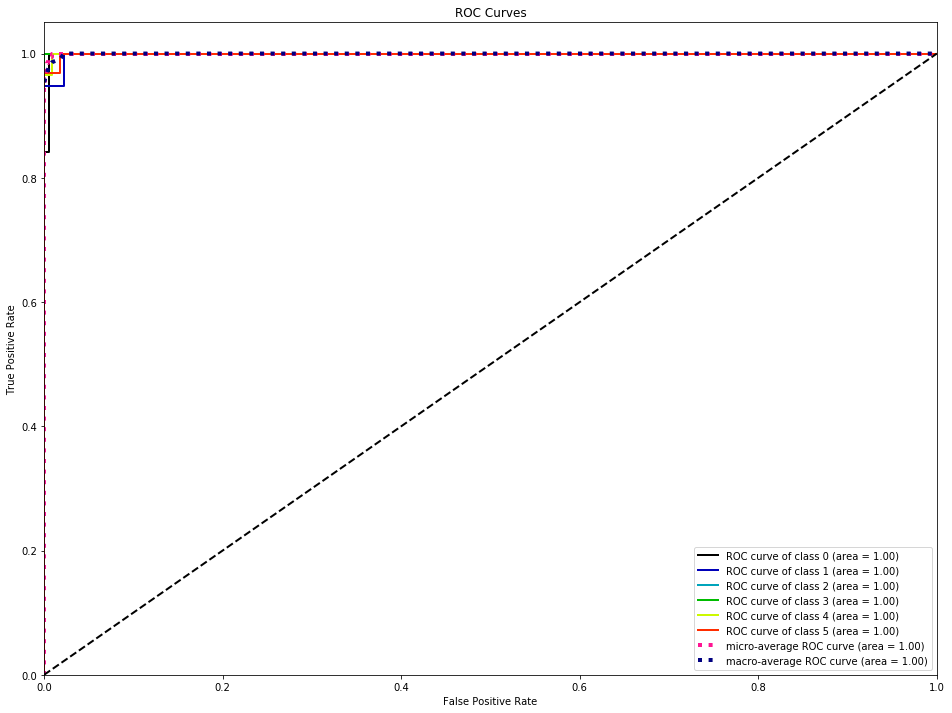

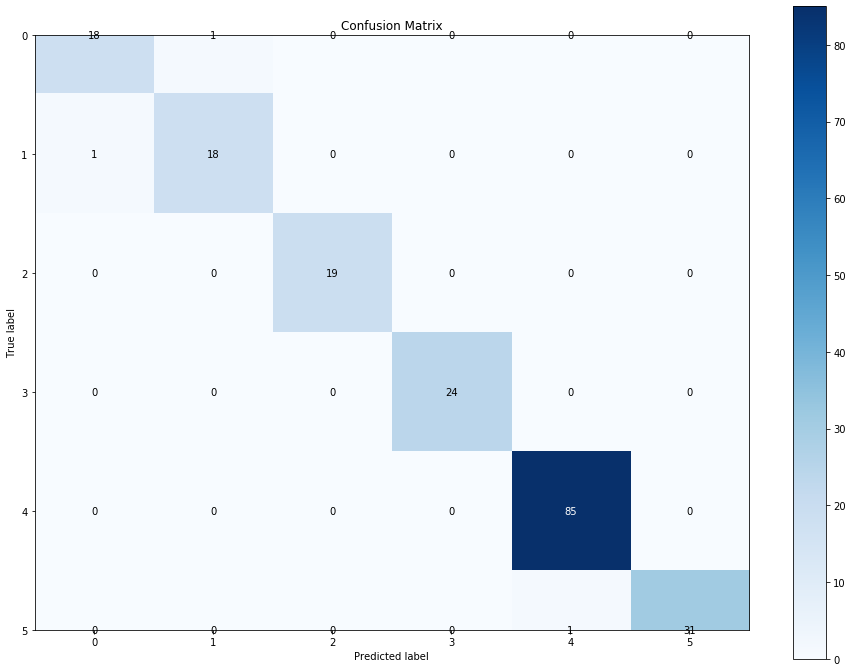

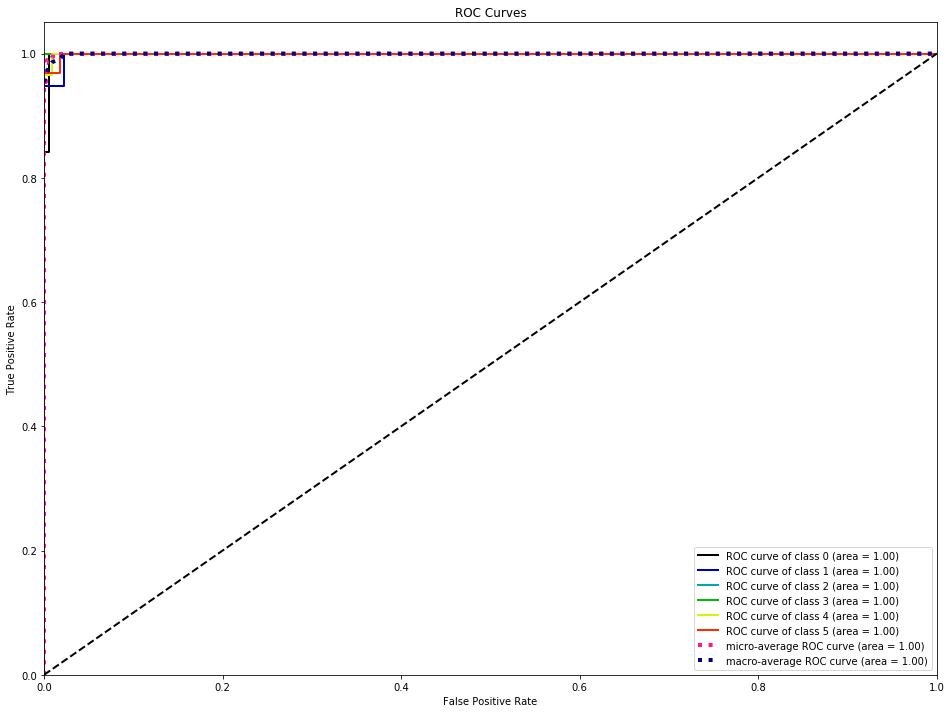

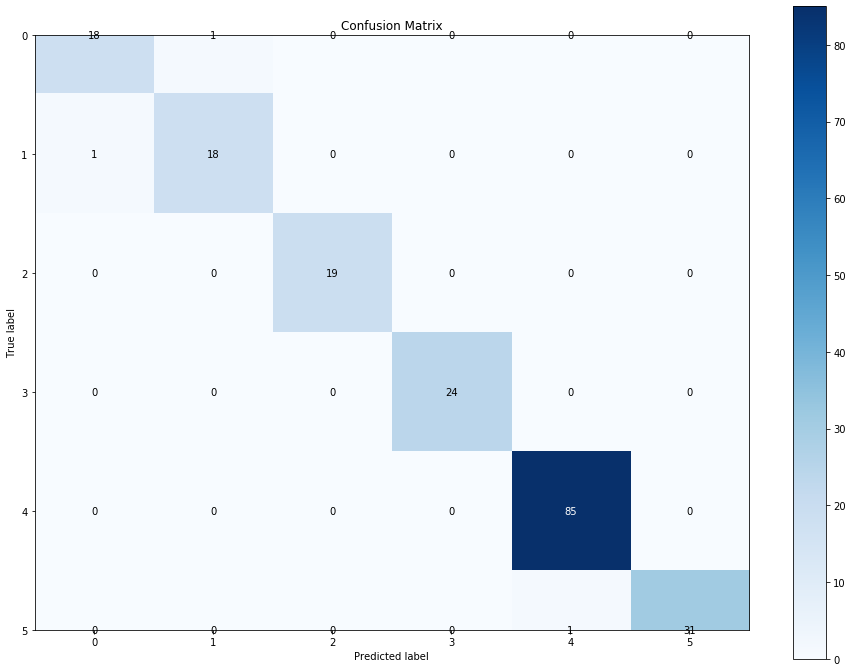

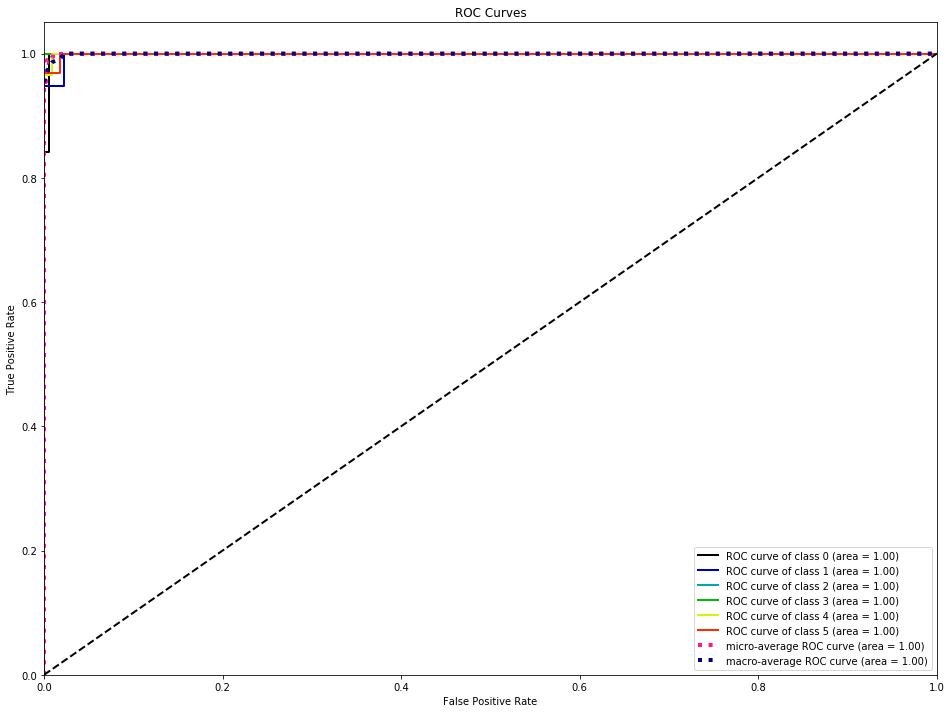

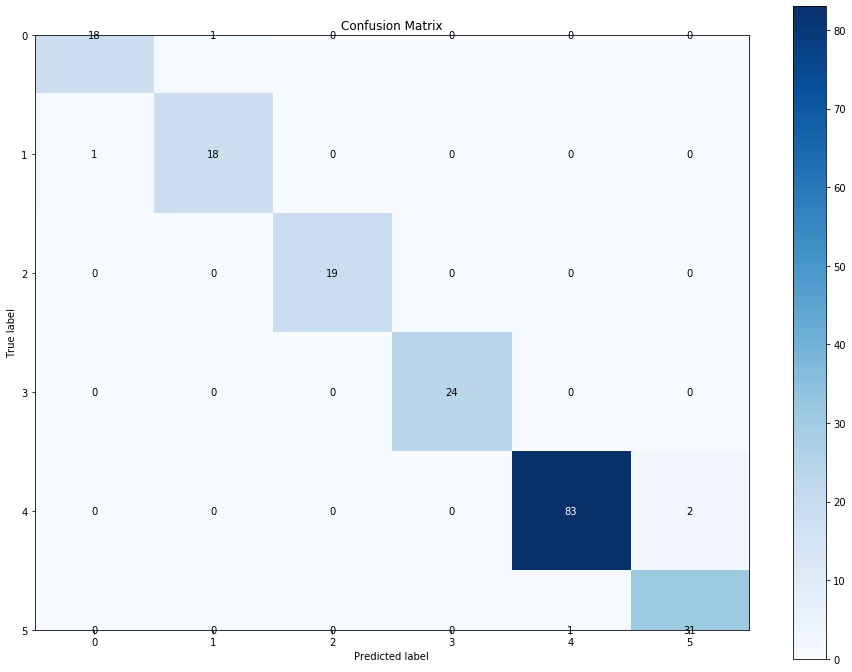

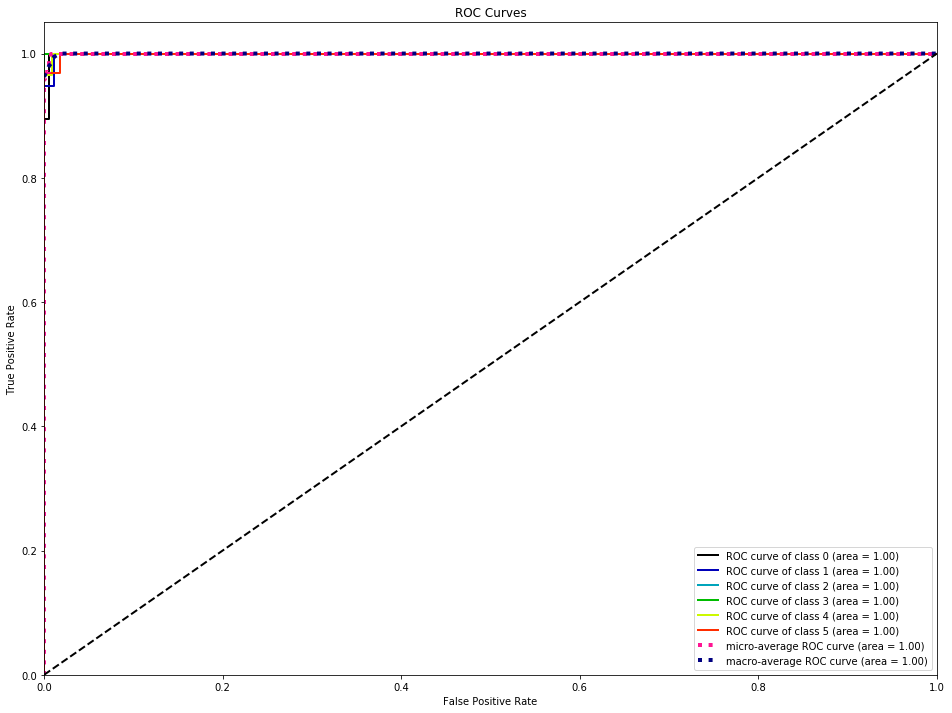

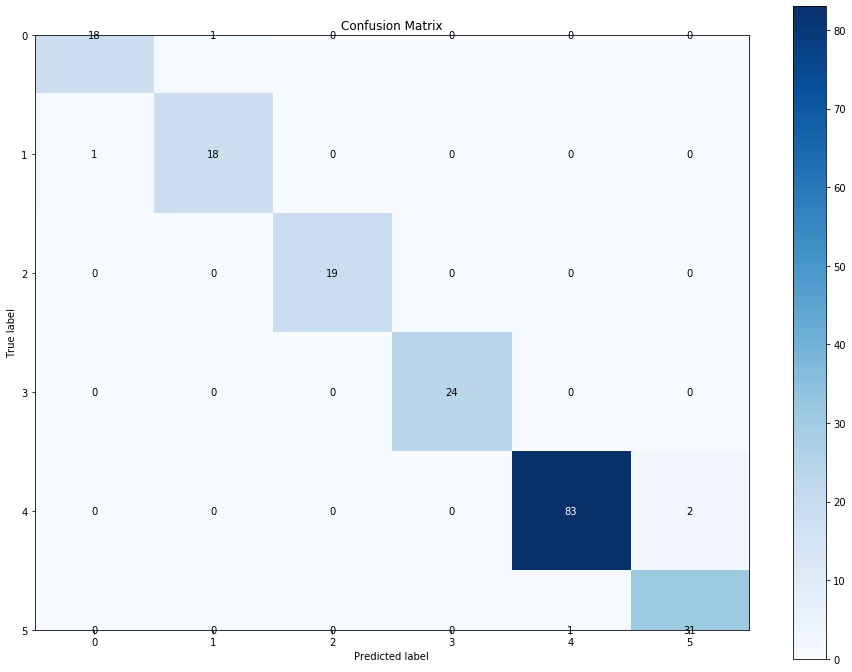

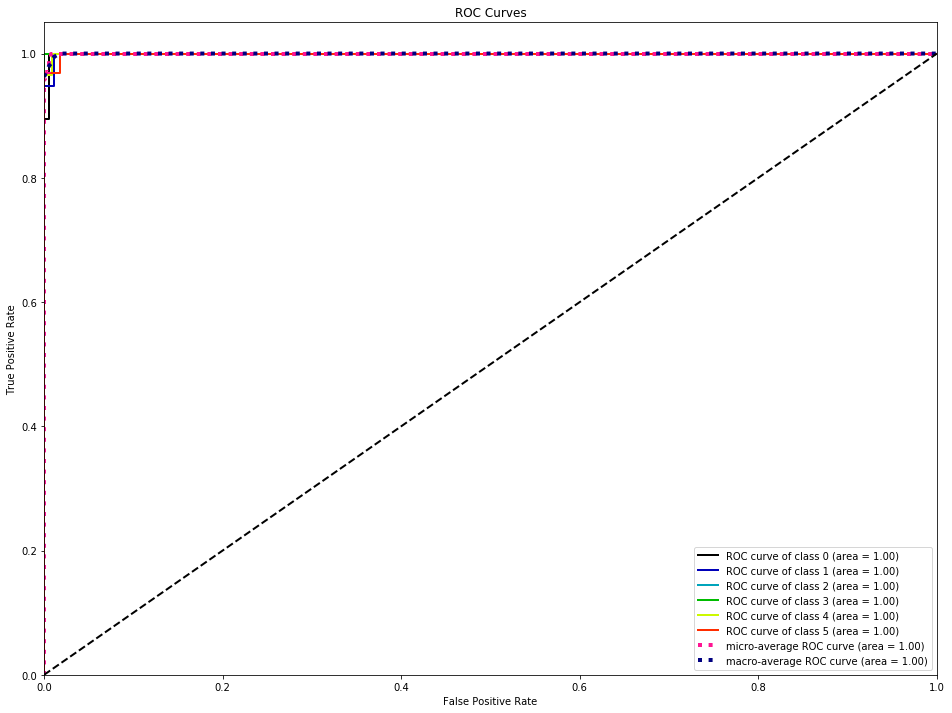

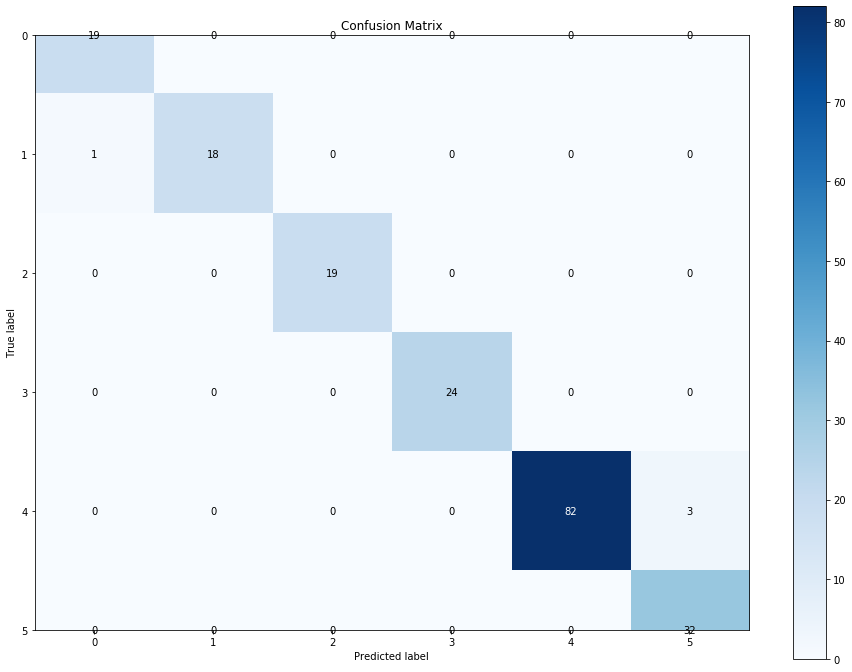

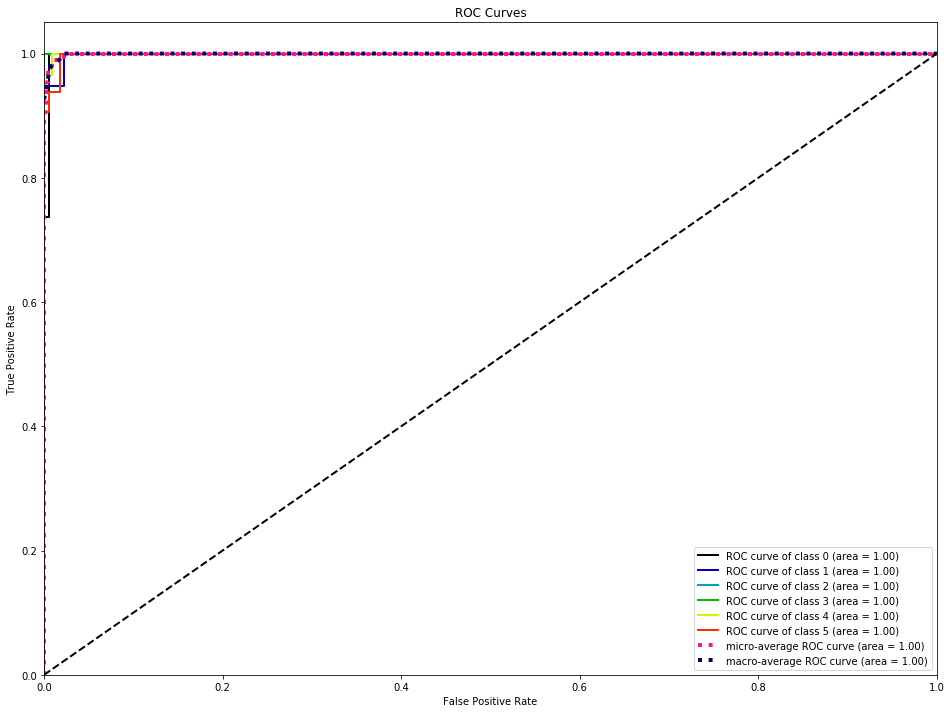

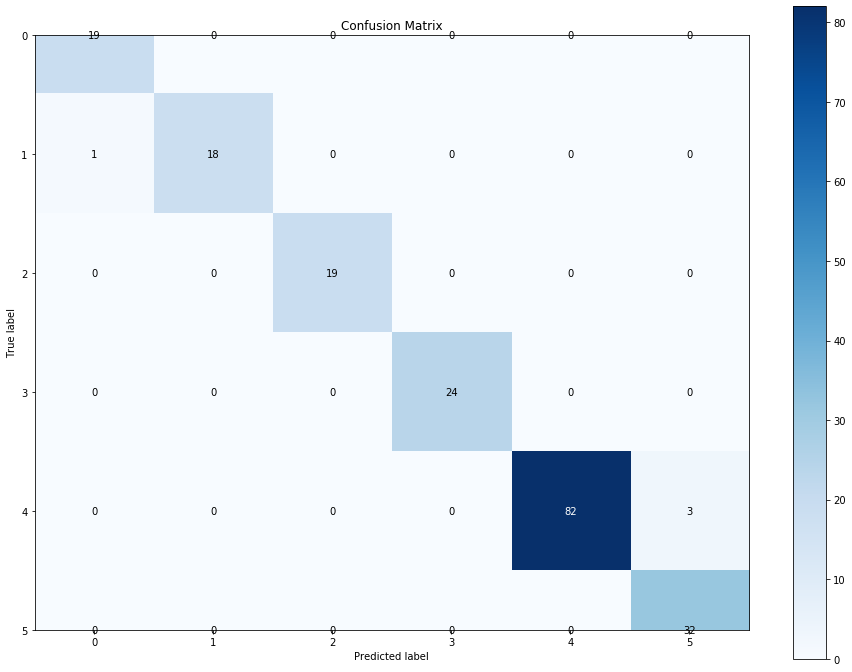

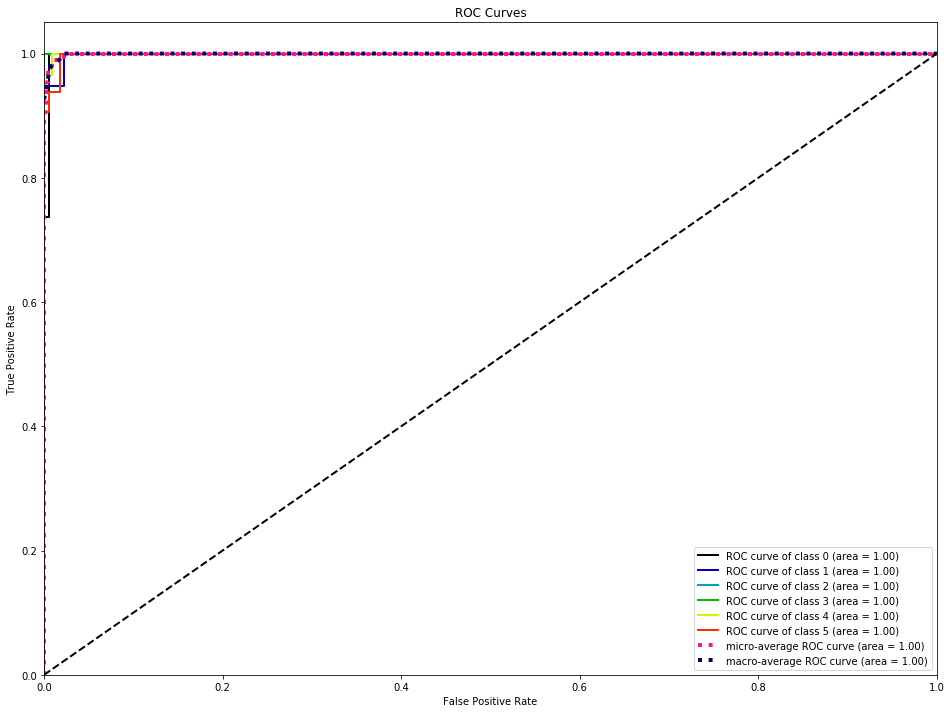

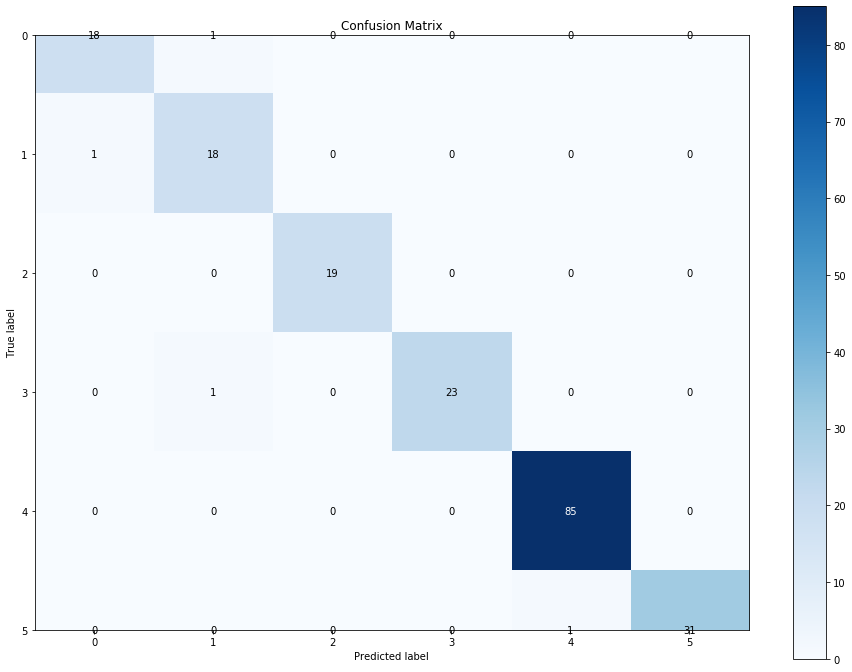

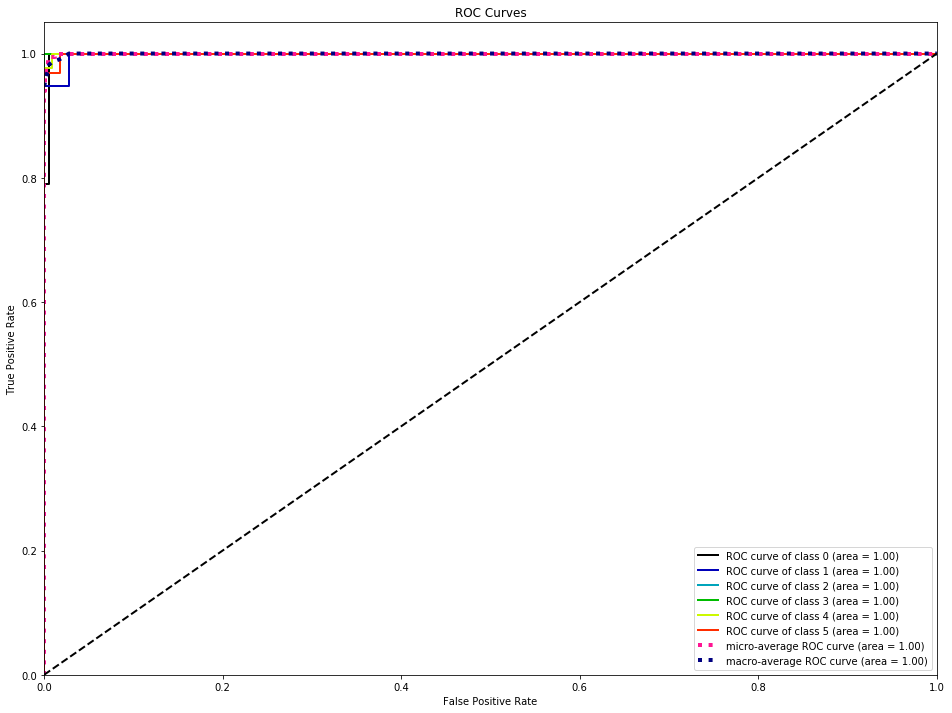

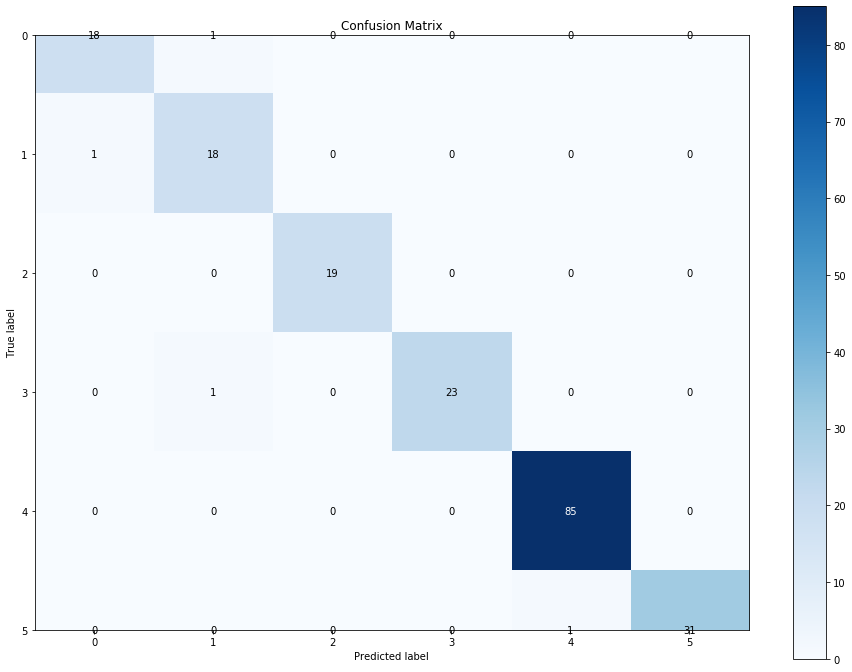

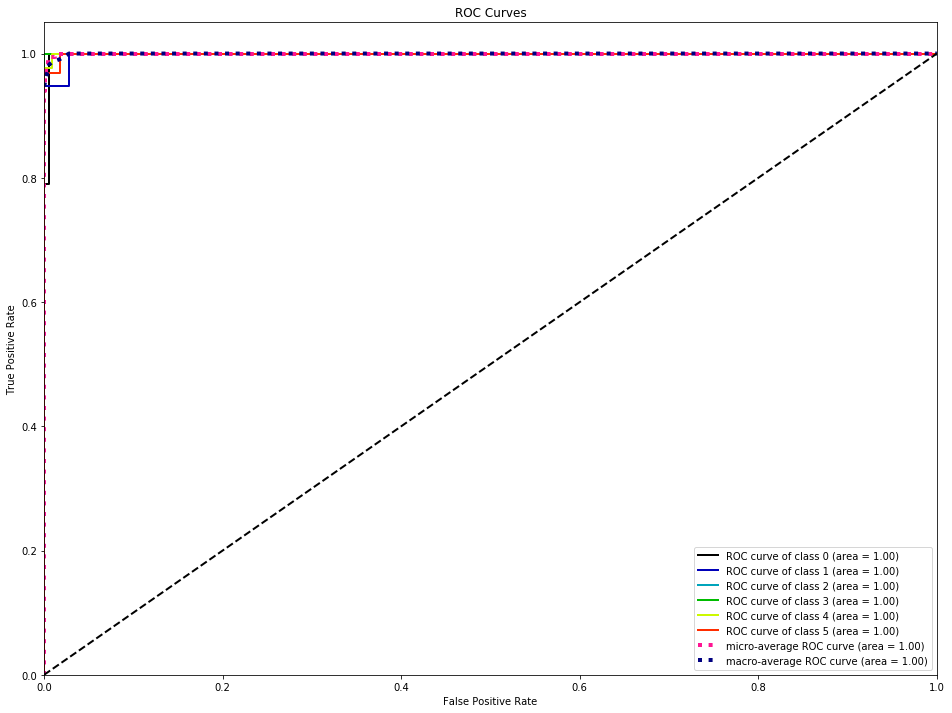

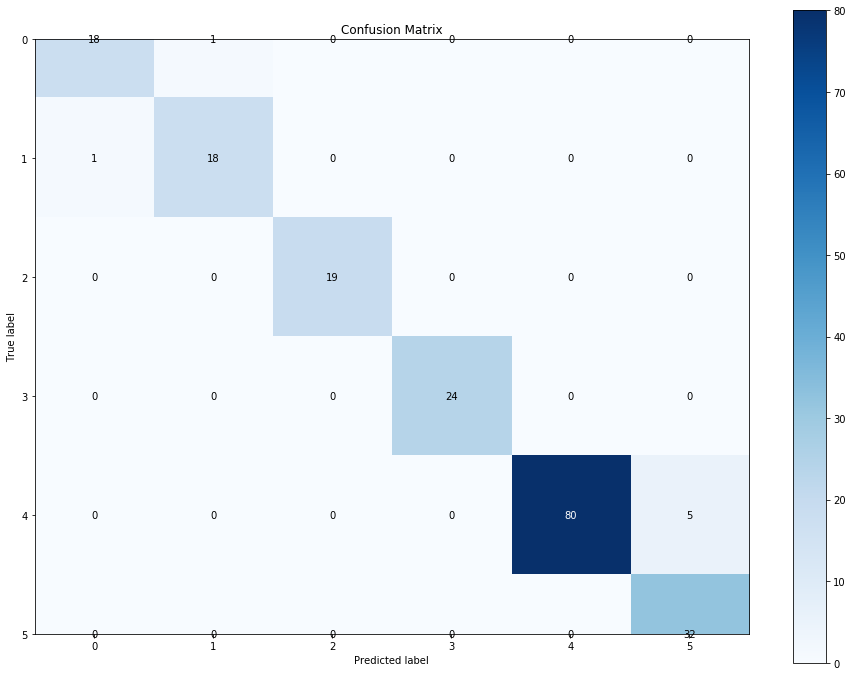

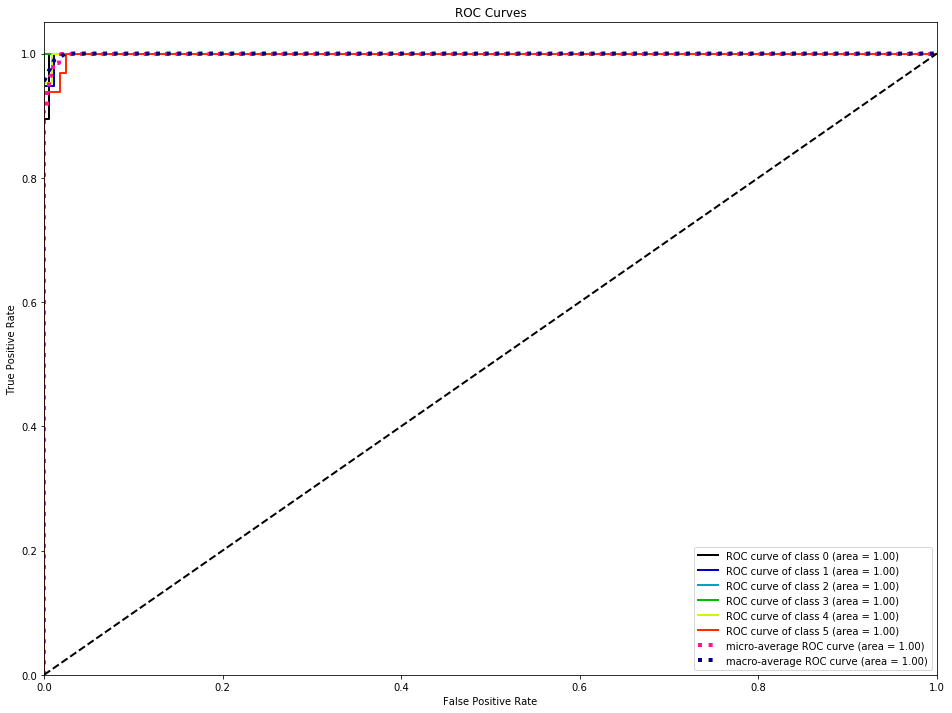

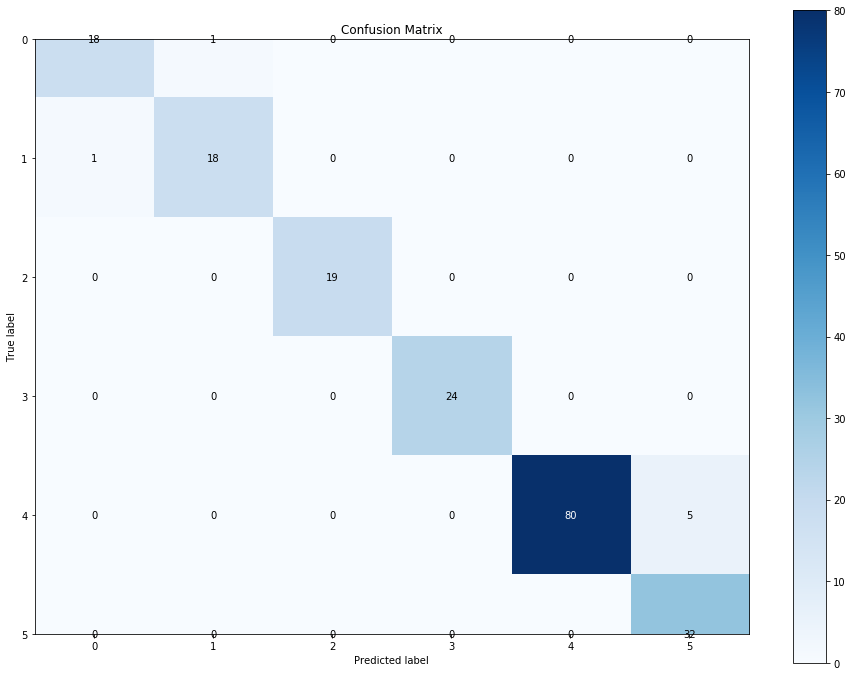

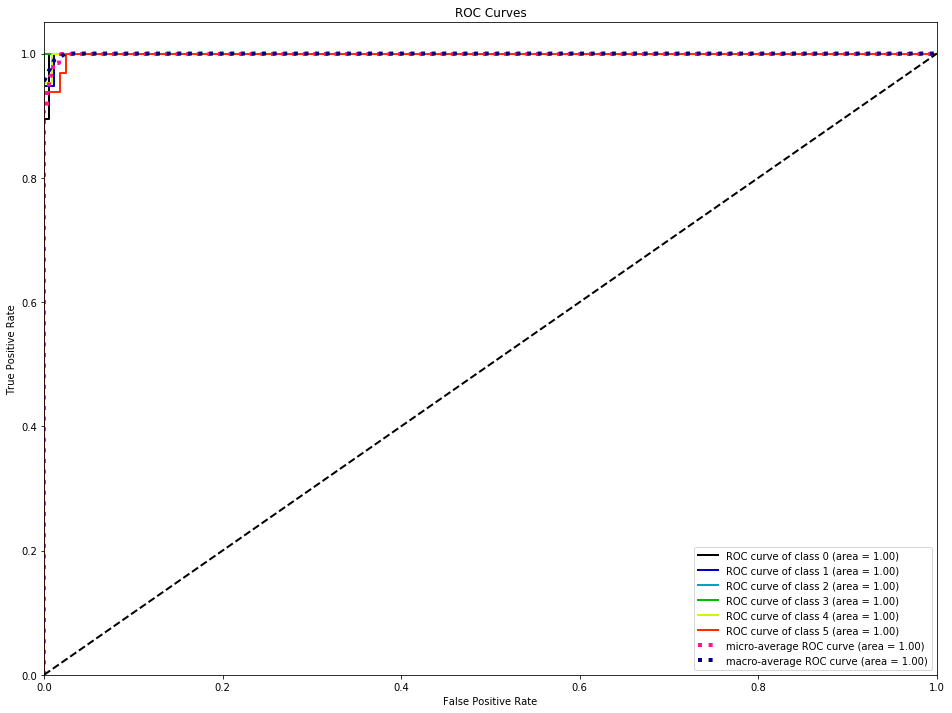

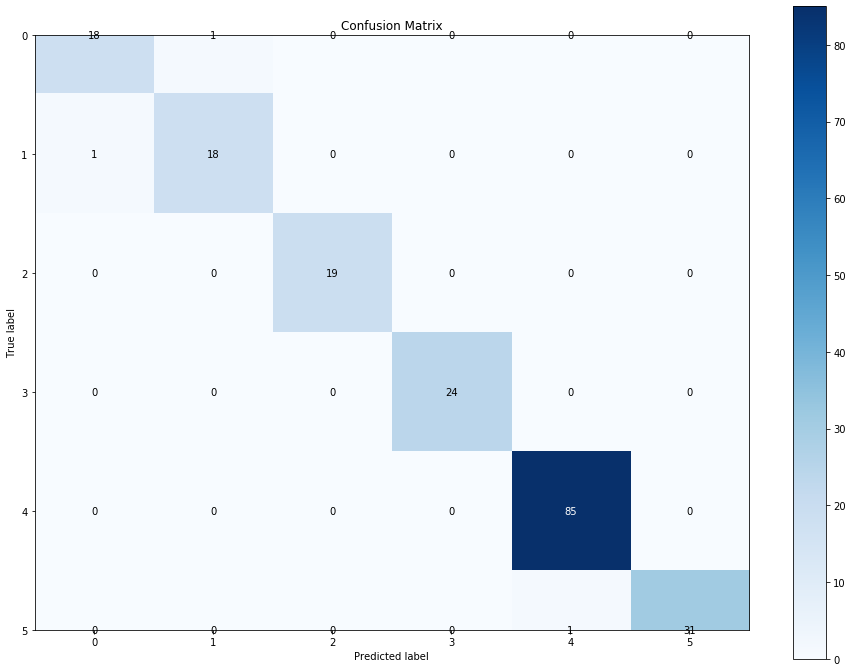

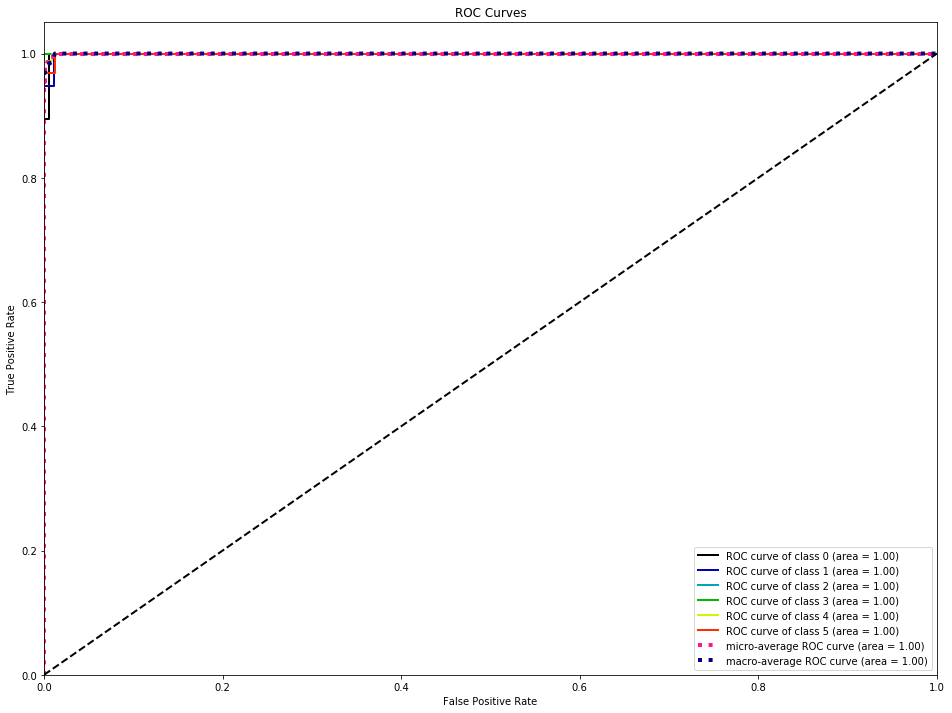

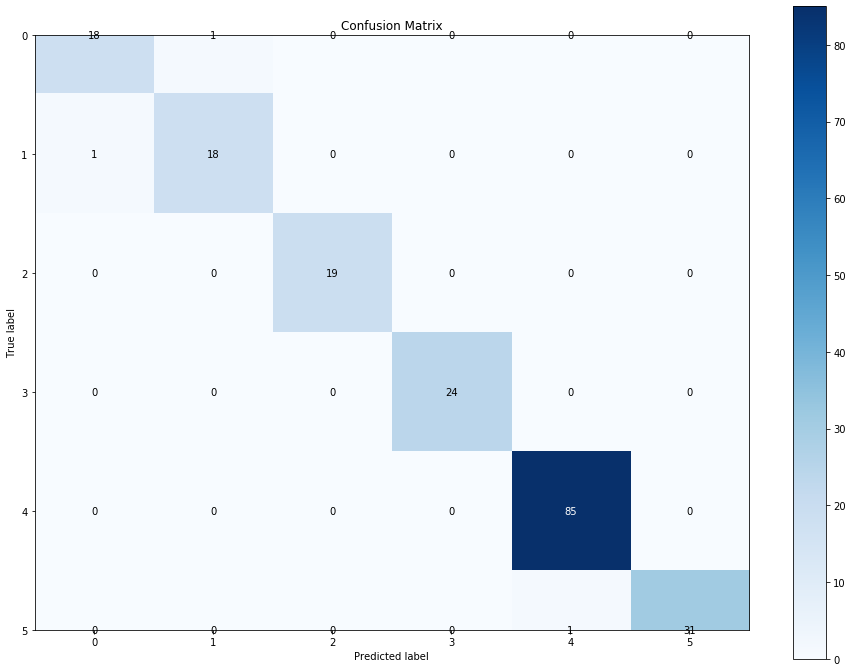

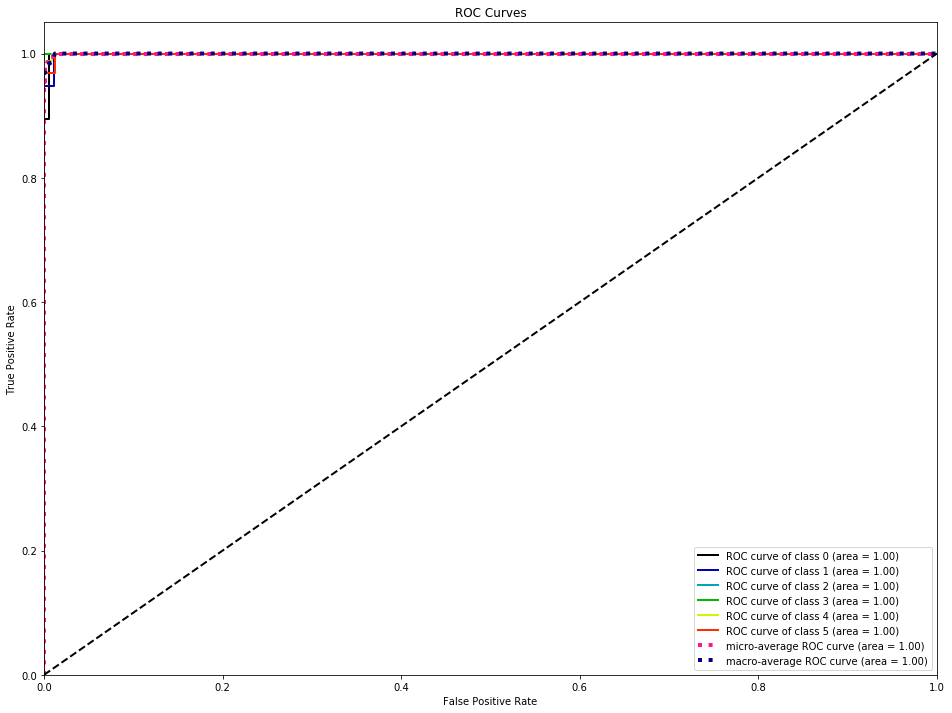

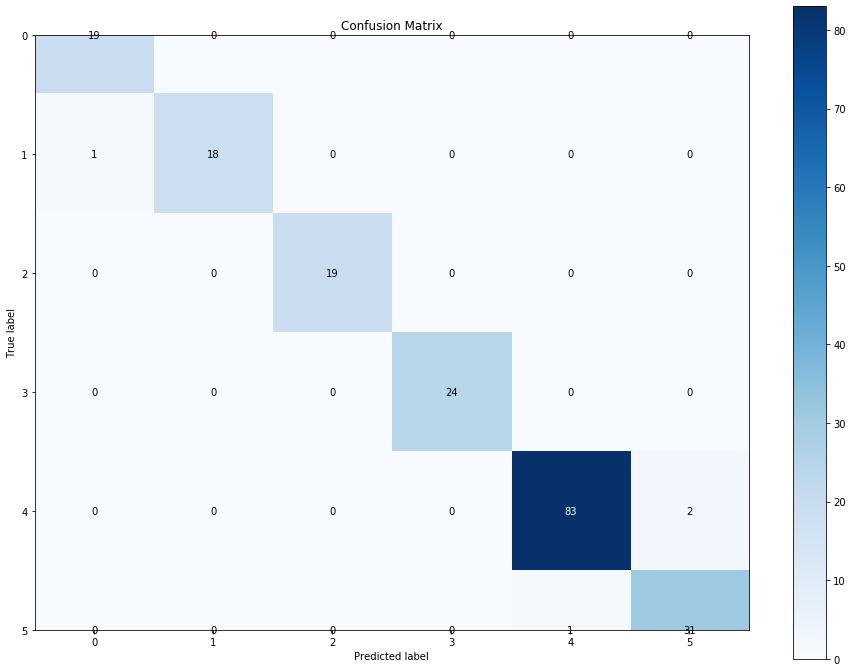

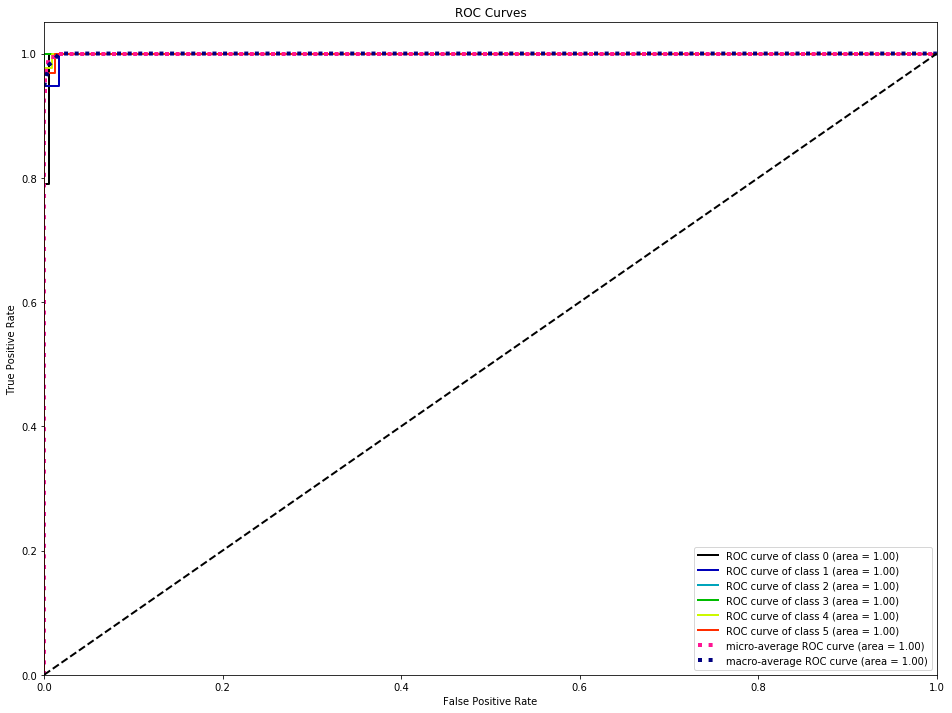

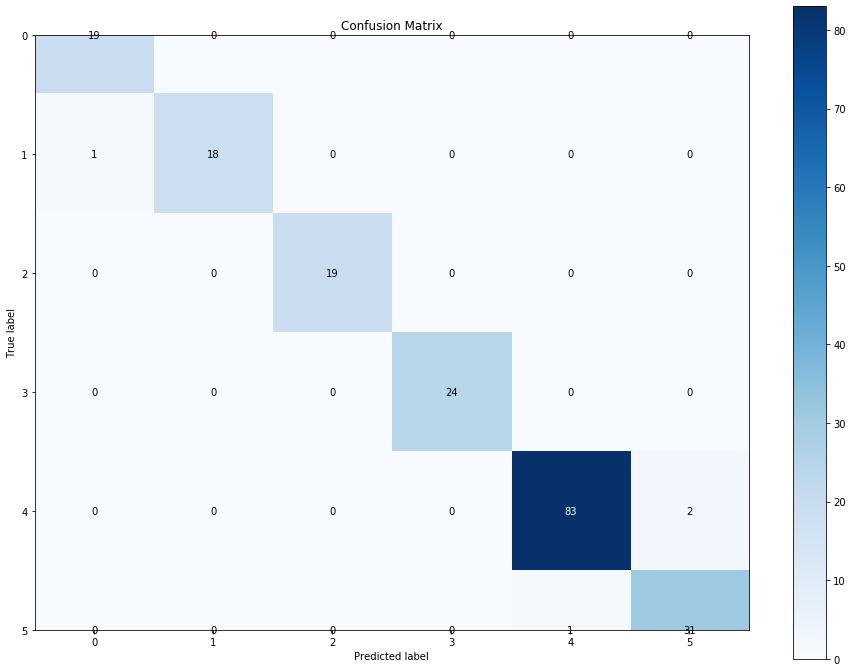

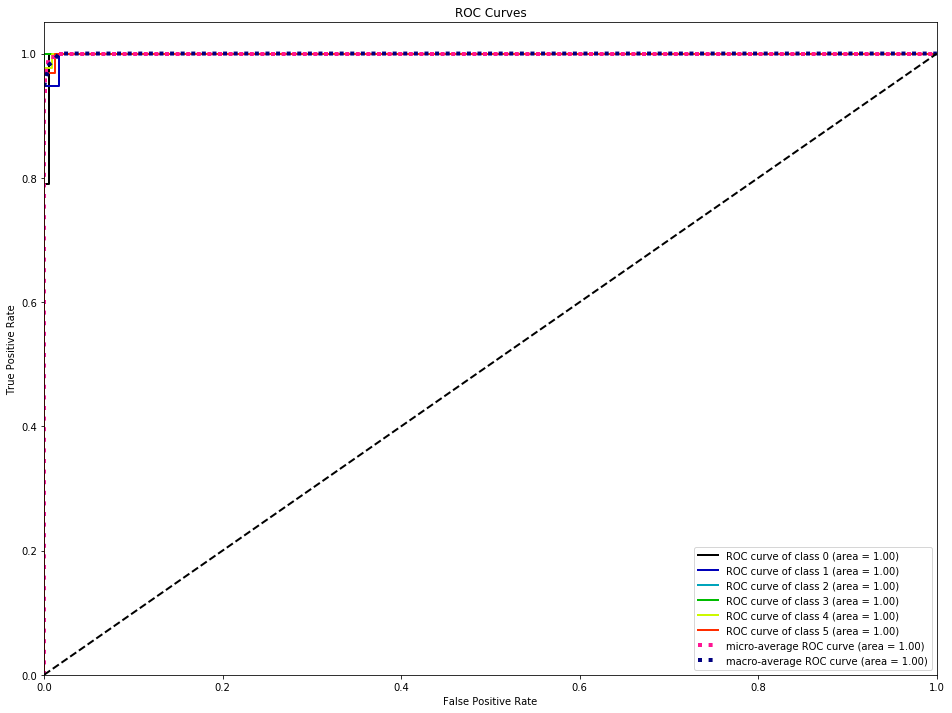

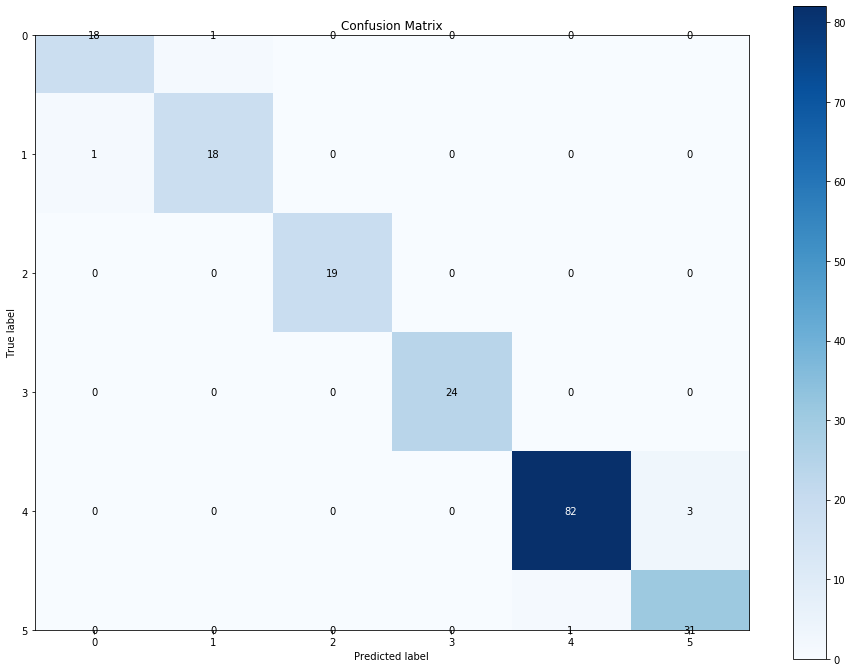

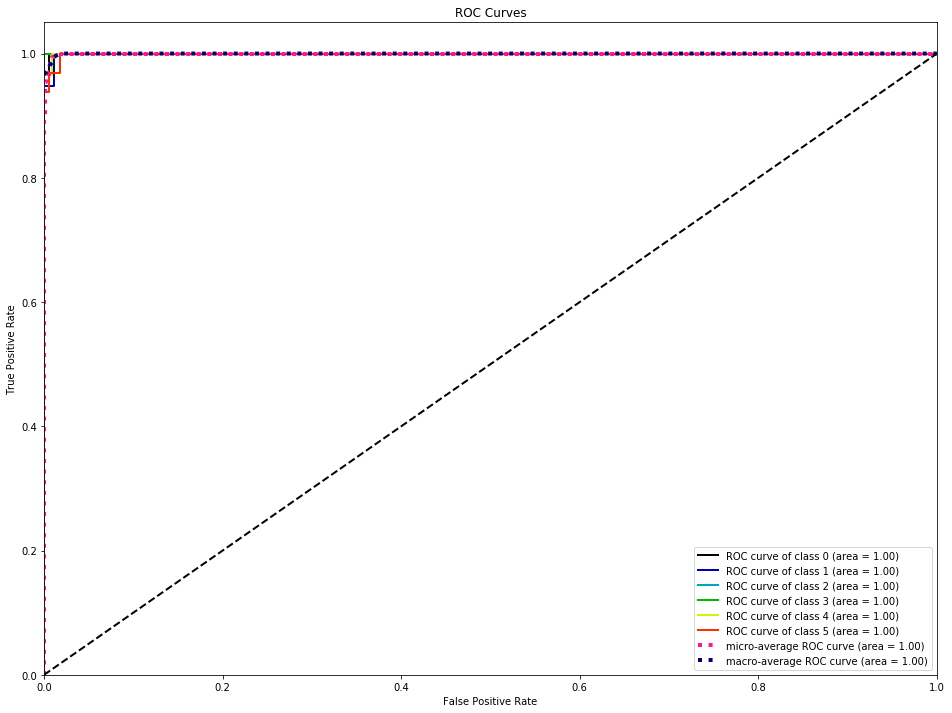

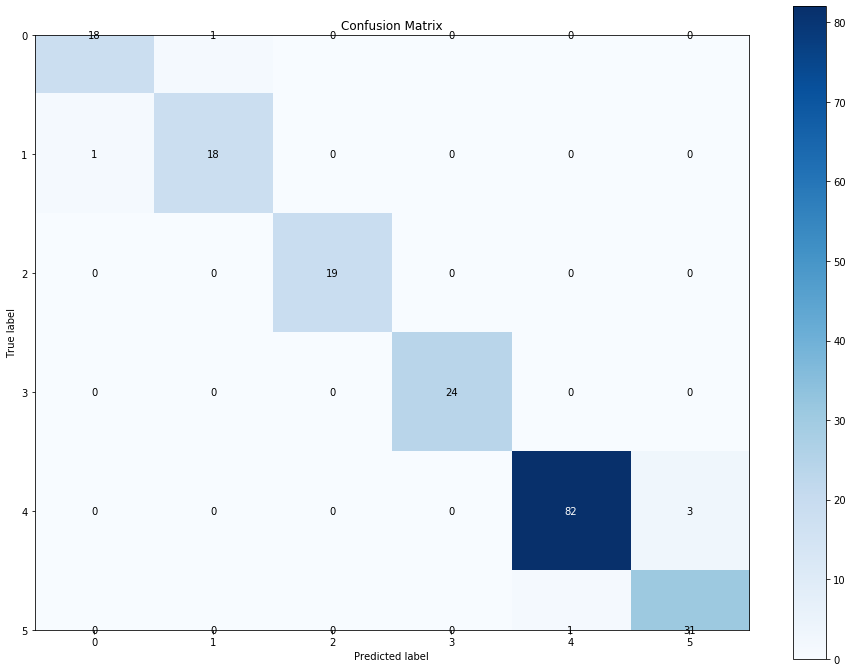

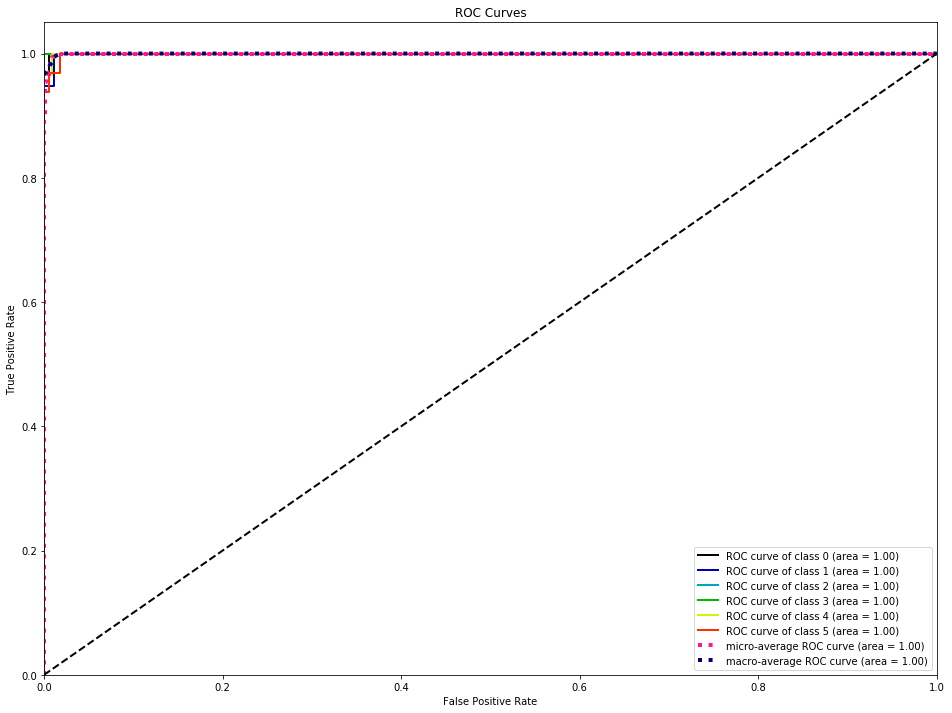

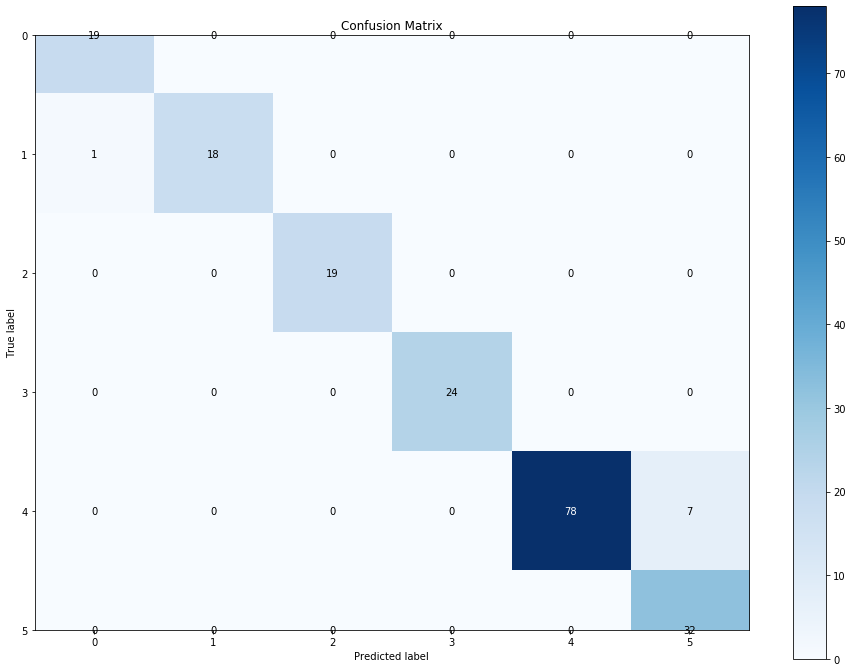

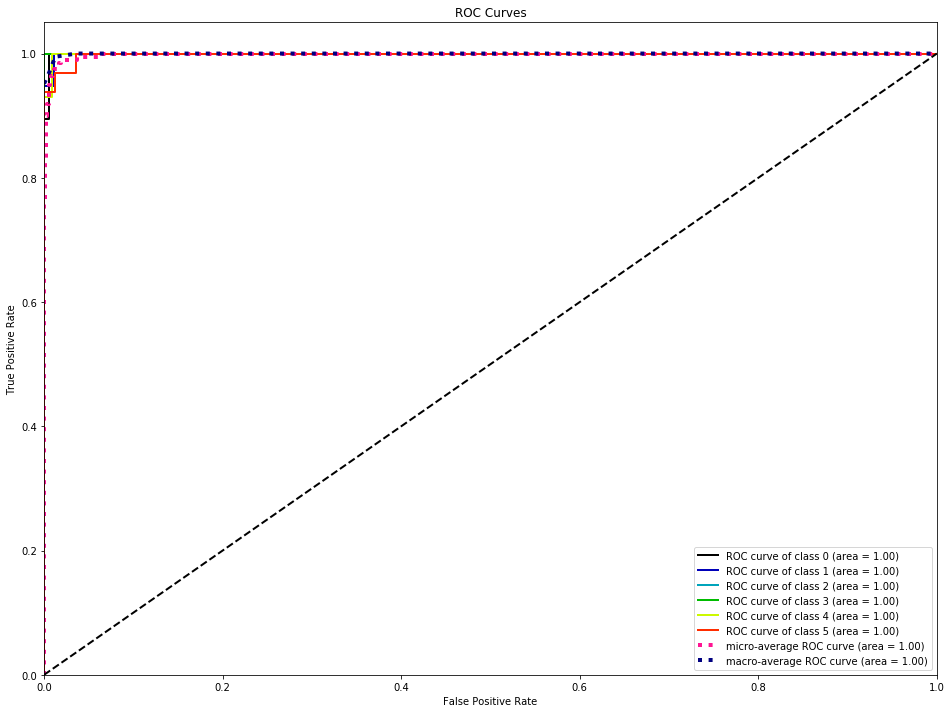

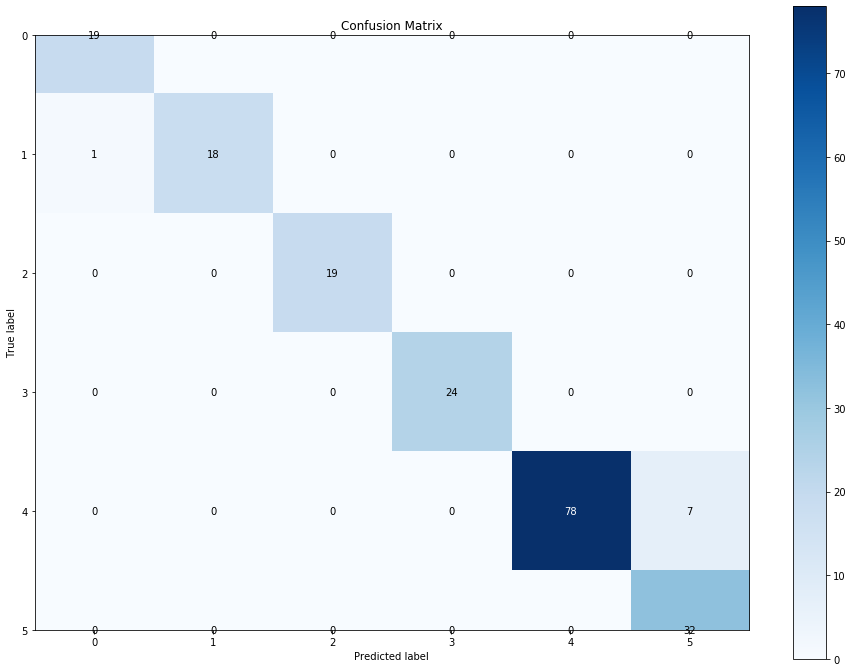

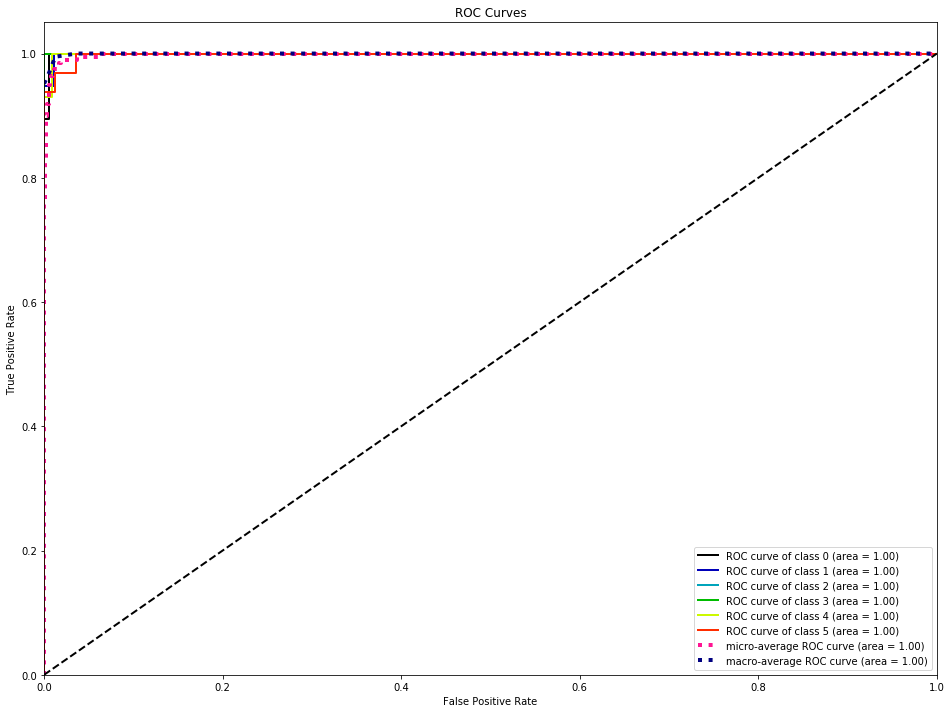

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\Users\chitt\Anaconda3\lib\site-packages\neptune\utils.py", line 210, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\chitt\Anaconda3\lib\site-packages\neptune\internal\backends\hosted_neptune_backend.py", line 603, in ping_experiment
    self.backend_swagger_client.api.pingExperiment(experimentId=experiment.internal_id).response()
  File "C:\Users\chitt\Anaconda3\lib\site-packages\bravado\http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "C:\Users\chitt\Anaconda3\lib\site-packages\bravado\http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "C:\Users\chitt\Anaconda3\lib\site-packages\bravado\http_future.py", line 303, in _get_swagger_result
    self.request_config.response_callbacks,
  File "C:\Users\chitt\Anaconda3\lib\site-packages\bravado\http_future.py", line 353, in unmarshal_response
    raise_on_ex

Unexpected HTTP error in hardware metric reporting thread.
Traceback (most recent call last):
  File "C:\Users\chitt\Anaconda3\lib\site-packages\neptune\utils.py", line 210, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\chitt\Anaconda3\lib\site-packages\neptune\internal\backends\hosted_neptune_backend.py", line 655, in send_hardware_metric_reports
    experimentId=experiment.internal_id, metricValues=system_metric_values).response()
  File "C:\Users\chitt\Anaconda3\lib\site-packages\bravado\http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "C:\Users\chitt\Anaconda3\lib\site-packages\bravado\http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "C:\Users\chitt\Anaconda3\lib\site-packages\bravado\http_future.py", line 303, in _get_swagger_result
    self.request_config.response_callbacks,
  File "C:\Users\chitt\Anaconda3\lib\site-packages\bravado\http_future.py", line 353, in unmarsh

In [94]:
performance_cbk = PerformanceVisualizationCallback(
                      model=model,
                      generator=valid_test_gen, steps=total_valid,
                      image_dir='performance_vizualizations')


# Train the model
history = model.fit(
            training_gen,
            steps_per_epoch=total_train // batch_size,
            epochs=epochs,
            validation_data=valid_gen,
            validation_steps=total_valid // batch_size,
            callbacks=[tensorboard_callback, performance_cbk, neptune_logger])

In [96]:
# Save the model into the pre-defined folder
model.save(os.path.join(trained_models, 'diseasepest-VGG16-ft.h5'))

In [99]:
plot_data(history, smooth=True)

KeyError: 'acc'

In [100]:
# Create a new validation generator for evaluation
val_test_gen = test_datageneration.flow_from_directory(
                val_fold,
                target_size=(image_height, image_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 198 images belonging to 6 classes.


In [171]:
# Load the saved model from the pre-defined folder
dependencies = {
                       'precision': precision,
                       'recall': recall, 
                        'multiclass_true_positives': MulticlassTruePositives()

}

model = load_model('diseasepest-VGG16-ft.h5', custom_objects=dependencies)
#model = load_weights('diseasepest-VGG16-ft.h5')


ValueError: Unknown metric function: {'class_name': 'MulticlassTruePositives', 'config': {'name': <__main__.MulticlassTruePositives object at 0x000001CE32781BA8>, 'dtype': 'float32'}}

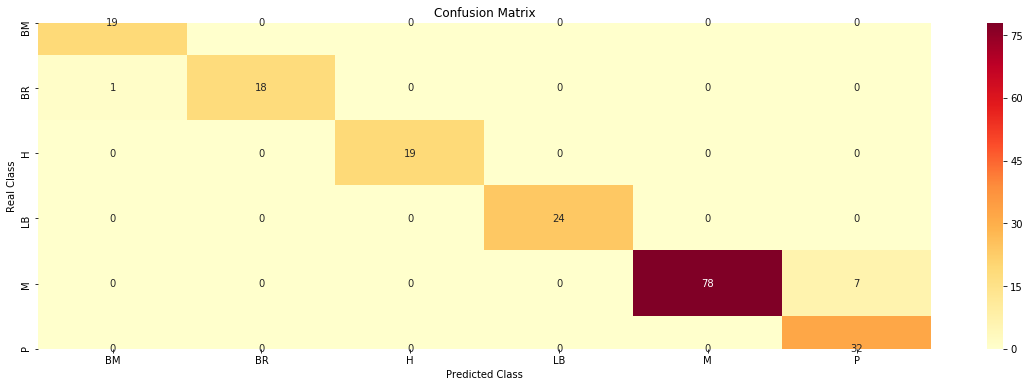

Classification Report
               precision    recall  f1-score   support

black_measles       0.95      1.00      0.97        19
    black_rot       1.00      0.95      0.97        19
      healthy       1.00      1.00      1.00        19
  leaf_blight       1.00      1.00      1.00        24
     mealybug       1.00      0.92      0.96        85
   phylloxera       0.82      1.00      0.90        32

     accuracy                           0.96       198
    macro avg       0.96      0.98      0.97       198
 weighted avg       0.97      0.96      0.96       198



In [139]:
# Display confusion matrix and classification report
collect_metrics(model, generator=val_test_gen, steps=total_valid)

### Final Model Evaluation on Test Data

In [17]:
# Create a new test generator for evaluation
test_generator = test_datageneration.flow_from_directory(
                test_fold,
                target_size=(image_height, image_width),
                color_mode='rgb',
                batch_size=1,
                class_mode='categorical',
                shuffle=False)

Found 957 images belonging to 6 classes.


Instructions for updating:
Please use Model.predict, which supports generators.


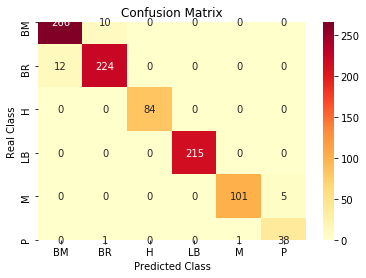

Classification Report
               precision    recall  f1-score   support

black_measles       0.96      0.96      0.96       276
    black_rot       0.95      0.95      0.95       236
      healthy       1.00      1.00      1.00        84
  leaf_blight       1.00      1.00      1.00       215
     mealybug       0.99      0.95      0.97       106
   phylloxera       0.88      0.95      0.92        40

     accuracy                           0.97       957
    macro avg       0.96      0.97      0.97       957
 weighted avg       0.97      0.97      0.97       957



In [18]:
# Load the saved model from the pre-defined folder
model = load_model(filepath=os.path.join(trained_models, 'diseasepest-VGG16-ft.h5'))


# Display confusion matrix and classification report
collect_metrics(model, generator=test_generator, steps=total_test)

In [19]:
# Look for all misclassified images 
y_pred = model.predict_generator(generator=test_generator, steps=total_test)
y_pred = np.argmax(y_pred, axis=1)
y_real = test_generator.classes

# Show indices of these misclassified images
index = np.where(np.not_equal(y_pred, y_real))
index

(array([  4,  53,  74, 100, 211, 219, 238, 246, 248, 259, 321, 330, 358,
        361, 375, 400, 401, 406, 438, 455, 475, 510, 812, 853, 864, 895,
        914, 919, 921], dtype=int64),)

In [20]:
# Display paths of misclassified images
paths = [test_generator.filepaths[i] for i in index[0]]
paths

['.\\img_data\\test\\black_measles\\black_measles1022.jpg',
 '.\\img_data\\test\\black_measles\\black_measles1227.jpg',
 '.\\img_data\\test\\black_measles\\black_measles1323.jpg',
 '.\\img_data\\test\\black_measles\\black_measles213.jpg',
 '.\\img_data\\test\\black_measles\\black_measles689.jpg',
 '.\\img_data\\test\\black_measles\\black_measles753.jpg',
 '.\\img_data\\test\\black_measles\\black_measles86.jpg',
 '.\\img_data\\test\\black_measles\\black_measles883.jpg',
 '.\\img_data\\test\\black_measles\\black_measles897.jpg',
 '.\\img_data\\test\\black_measles\\black_measles945.jpg',
 '.\\img_data\\test\\black_rot\\black_rot123.jpg',
 '.\\img_data\\test\\black_rot\\black_rot193.jpg',
 '.\\img_data\\test\\black_rot\\black_rot341.jpg',
 '.\\img_data\\test\\black_rot\\black_rot356.jpg',
 '.\\img_data\\test\\black_rot\\black_rot41.jpg',
 '.\\img_data\\test\\black_rot\\black_rot525.jpg',
 '.\\img_data\\test\\black_rot\\black_rot526.jpg',
 '.\\img_data\\test\\black_rot\\black_rot550.jpg',
 

In [20]:
# Print all hidden layers
tf.compat.v1.disable_eager_execution()
for layer in model.layers:
    hidden_layer = layer.output
    
    print(hidden_layer)

Tensor("block5_pool_1/Identity:0", shape=(None, 8, 8, 512), dtype=float32)
Tensor("flatten_1/Identity:0", shape=(None, 32768), dtype=float32)
Tensor("dense_2/Identity:0", shape=(None, 256), dtype=float32)
Tensor("dropout_1/Identity:0", shape=(None, 256), dtype=float32)
Tensor("dense_3/Identity:0", shape=(None, 6), dtype=float32)


In [24]:
# Display each layer information
from keras.models import Sequential
from keras import layers as l
from keras.applications.vgg16 import VGG16
from keras_sequential_ascii import keras2ascii

conv_base1 = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(img_height, img_width, 3))
keras2ascii(conv_base1)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    256  256    3
          InputLayer     |   -------------------         0     0.0%
                       #####    256  256    3
              Conv2D    \|/  -------------------      1792     0.0%
                relu   #####    256  256   64
              Conv2D    \|/  -------------------     36928     0.3%
                relu   #####    256  256   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####    128  128   64
              Conv2D    \|/  -------------------     73856     0.5%
                relu   #####    128  128  128
              Conv2D    \|/  -------------------    147584     1.0%
                relu   #####    128  128  128
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     64   64  128
              Conv2D    \|/  -------------------    295168     2.0%
              

In [66]:
# Display each layer information
from keras.models import Sequential
from keras import layers as l
from keras.applications.vgg16 import VGG16
from keras_sequential_ascii import keras2ascii

vgg16 = VGG16(weights=None)
keras2ascii(vgg16)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    224  224    3
          InputLayer     |   -------------------         0     0.0%
                       #####    224  224    3
              Conv2D    \|/  -------------------      1792     0.0%
                relu   #####    224  224   64
              Conv2D    \|/  -------------------     36928     0.0%
                relu   #####    224  224   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####    112  112   64
              Conv2D    \|/  -------------------     73856     0.1%
                relu   #####    112  112  128
              Conv2D    \|/  -------------------    147584     0.1%
                relu   #####    112  112  128
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     56   56  128
              Conv2D    \|/  -------------------    295168     0.2%
              

In [86]:
# Extract weights and bias on each layer
for layer in model.layers:

    # Get layer name
    print("Layer name: ", layer.name, "\n")
    
    # Get layer configuration
    print("Layer configuration: ", layer.get_config(), "\n")
    
    # Get layer weights and bias
    w = layer.get_weights()
    if w != []:
        weights = layer.get_weights()[0]
        bias = layer.get_weights()[1]
        print("Layer weights: ", weights, "\n")
        print("Layer bias: ", bias, "\n")
    else:
        print("Layer weights and bias: ", w)

Layer name:  vgg16 

Layer configuration:  {'name': 'vgg16', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 256, 256, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'name': 'input_2', 'inbound_nodes': []}, {'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'block1_conv1', 'inbound_nodes': [[['input_2', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'block1_conv2', 'trainable': False, 'dtype': 'float32', 'filters': 6

In [7]:
# Load the saved model from the pre-defined folder
model = load_model(filepath=os.path.join(trained_models, 'diseasepest-VGG16-ft.h5'))

In [5]:
# Extract loss, accuracy, mean absolute error, mean squared error, and cosine proximity of each batch and epoch
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):

  def on_train_batch_end(self, batch, logs=None):
    print('\nFor batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))
    print('For batch {}, accuracy is {:7.2f}.'.format(batch, logs['accuracy']))
    print('For batch {}, mean absolute error is {:7.2f}.'.format(batch, logs['mae']))
    print('For batch {}, mean squared error is {:7.2f}.'.format(batch, logs['mse']))
    print('For batch {}, cosine proximity is {:7.2f}.'.format(batch, logs['cosine']))

  def on_test_batch_end(self, batch, logs=None):
    print('\nFor batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))
    print('For batch {}, accuracy is {:7.2f}.'.format(batch, logs['accuracy']))
    print('For batch {}, mean absolute error is {:7.2f}.'.format(batch, logs['mae']))
    print('For batch {}, cosine proximity is {:7.2f}.'.format(batch, logs['cosine']))

  def on_epoch_end(self, epoch, logs=None):
    print('\nThe average loss for epoch {} is {:7.2f}, accuracy is {:7.2f}, mean absolute error is {:7.2f}, mean squared error is {:7.2f}, and cosine proximity is {:7.2f}.'.format(epoch, logs['loss'], logs['accuracy'], logs['mae'], logs['mse'], logs['cosine']))
    

In [6]:
# Define custom callback for prediction
class PredictionCallback(tf.keras.callbacks.Callback):    
  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(self.validation_data[0])
    print('prediction: {} at epoch: {}'.format(y_pred, epoch))

In [45]:
# get all inbound nodes in each layer
for layer in model.layers:
    for node in layer._inbound_nodes:
         for i in range(len(node.inbound_layers)):
                inbound_node_index = node.node_indices
                strings = [str(integer) for integer in inbound_node_index]
                a_string = "". join(strings)
                an_integer = int(a_string)
                print(an_integer)
                layer.get_input_at(an_integer)
                layer.get_output_at(an_integer)
                layer.get_input_shape_at(an_integer)
                layer.get_output_shape_at(an_integer)
            

0


<tf.Tensor 'flatten_15_input:0' shape=(None, 28, 28) dtype=float32>

<tf.Tensor 'flatten_15/Reshape:0' shape=(None, None) dtype=float32>

(None, 28, 28)

(None, 784)

0


<tf.Tensor 'flatten_15/Reshape:0' shape=(None, None) dtype=float32>

<tf.Tensor 'dense_29/Relu:0' shape=(None, 32) dtype=float32>

(None, 784)

(None, 32)

0


<tf.Tensor 'dense_29/Relu:0' shape=(None, 32) dtype=float32>

<tf.Tensor 'dropout_15/cond/Identity:0' shape=(None, 32) dtype=float32>

(None, 32)

(None, 32)

0


<tf.Tensor 'dropout_15/cond/Identity:0' shape=(None, 32) dtype=float32>

<tf.Tensor 'dense_30/Softmax:0' shape=(None, 10) dtype=float32>

(None, 32)

(None, 10)

In [79]:
# get all outbound nodes in each layer
count = 0
for layer in model.layers:
    for node in layer._outbound_nodes:
        if (node.outbound_layer != None):
            count = count + 1
        for i in range(count):
                outbound_node_index = node.node_indices
                strings = [str(integer) for integer in outbound_node_index]
                a_string = "". join(strings)
                an_integer = int(a_string)
                print(an_integer)
                layer.get_input_at(an_integer)
                layer.get_output_at(an_integer)
                layer.get_input_shape_at(an_integer)
                layer.get_output_shape_at(an_integer)
print('Total outbound layer:%s' % count)

0


<tf.Tensor 'flatten_18_input:0' shape=(None, 28, 28) dtype=float32>

<tf.Tensor 'flatten_18/Reshape:0' shape=(None, None) dtype=float32>

(None, 28, 28)

(None, 784)

0


<tf.Tensor 'flatten_18/Reshape:0' shape=(None, None) dtype=float32>

<tf.Tensor 'dense_35/Relu:0' shape=(None, 32) dtype=float32>

(None, 784)

(None, 32)

0


<tf.Tensor 'flatten_18/Reshape:0' shape=(None, None) dtype=float32>

<tf.Tensor 'dense_35/Relu:0' shape=(None, 32) dtype=float32>

(None, 784)

(None, 32)

0


<tf.Tensor 'dense_35/Relu:0' shape=(None, 32) dtype=float32>

<tf.Tensor 'dropout_18/cond/Identity:0' shape=(None, 32) dtype=float32>

(None, 32)

(None, 32)

0


<tf.Tensor 'dense_35/Relu:0' shape=(None, 32) dtype=float32>

<tf.Tensor 'dropout_18/cond/Identity:0' shape=(None, 32) dtype=float32>

(None, 32)

(None, 32)

0


<tf.Tensor 'dense_35/Relu:0' shape=(None, 32) dtype=float32>

<tf.Tensor 'dropout_18/cond/Identity:0' shape=(None, 32) dtype=float32>

(None, 32)

(None, 32)

Total outbound layer:3


In [7]:
# Extract loss, accuracy, mean absolute error, mean squared error, and cosine proximity of each batch and epoch
import keras
# Define the model.
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', 'mae', 'mse', 'cosine'])
(train_images, train_labels), _ = keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0

hist = model.fit(
    train_images,
    train_labels, 
    batch_size=64,
    epochs=5,
    callbacks=[LossAndErrorPrintingCallback()])

Epoch 1/5
   64/60000 [..............................] - ETA: 18:23 - loss: 2.4053 - accuracy: 0.0625 - mae: 4.5250 - mse: 27.6999 - cosine: 2.6402
For batch 0, loss is    2.41.
For batch 0, accuracy is    0.06.
For batch 0, mean absolute error is    4.53.
For batch 0, mean squared error is   27.70.
For batch 0, cosine proximity is    2.64.

For batch 1, loss is    2.35.
For batch 1, accuracy is    0.08.
For batch 1, mean absolute error is    4.72.
For batch 1, mean squared error is   30.59.
For batch 1, cosine proximity is    2.71.

For batch 2, loss is    2.18.
For batch 2, accuracy is    0.10.
For batch 2, mean absolute error is    4.69.
For batch 2, mean squared error is   30.21.
For batch 2, cosine proximity is    2.71.

For batch 3, loss is    2.22.
For batch 3, accuracy is    0.11.
For batch 3, mean absolute error is    4.67.
For batch 3, mean squared error is   30.18.
For batch 3, cosine proximity is    2.70.

For batch 4, loss is    2.19.
For batch 4, accuracy is    0.12.
For 

 2752/60000 [>.............................] - ETA: 26s - loss: 1.7136 - accuracy: 0.3826 - mae: 4.3797 - mse: 27.3886 - cosine: 2.2155
For batch 42, loss is    1.19.
For batch 42, accuracy is    0.38.
For batch 42, mean absolute error is    4.38.
For batch 42, mean squared error is   27.39.
For batch 42, cosine proximity is    2.22.

For batch 43, loss is    1.20.
For batch 43, accuracy is    0.39.
For batch 43, mean absolute error is    4.38.
For batch 43, mean squared error is   27.43.
For batch 43, cosine proximity is    2.21.

For batch 44, loss is    1.37.
For batch 44, accuracy is    0.39.
For batch 44, mean absolute error is    4.39.
For batch 44, mean squared error is   27.47.
For batch 44, cosine proximity is    2.20.

For batch 45, loss is    1.32.
For batch 45, accuracy is    0.39.
For batch 45, mean absolute error is    4.38.
For batch 45, mean squared error is   27.36.
For batch 45, cosine proximity is    2.19.

For batch 46, loss is    1.21.
For batch 46, accuracy is    


For batch 83, loss is    1.06.
For batch 83, accuracy is    0.49.
For batch 83, mean absolute error is    4.37.
For batch 83, mean squared error is   27.21.
For batch 83, cosine proximity is    1.92.

For batch 84, loss is    1.03.
For batch 84, accuracy is    0.49.
For batch 84, mean absolute error is    4.37.
For batch 84, mean squared error is   27.19.
For batch 84, cosine proximity is    1.92.
 5504/60000 [=>............................] - ETA: 13s - loss: 1.4275 - accuracy: 0.4935 - mae: 4.3629 - mse: 27.1544 - cosine: 1.9143
For batch 85, loss is    1.24.
For batch 85, accuracy is    0.49.
For batch 85, mean absolute error is    4.36.
For batch 85, mean squared error is   27.15.
For batch 85, cosine proximity is    1.91.

For batch 86, loss is    0.98.
For batch 86, accuracy is    0.50.
For batch 86, mean absolute error is    4.36.
For batch 86, mean squared error is   27.18.
For batch 86, cosine proximity is    1.91.

For batch 87, loss is    1.07.
For batch 87, accuracy is    


For batch 123, loss is    1.02.
For batch 123, accuracy is    0.55.
For batch 123, mean absolute error is    4.38.
For batch 123, mean squared error is   27.29.
For batch 123, cosine proximity is    1.77.

For batch 124, loss is    0.84.
For batch 124, accuracy is    0.55.
For batch 124, mean absolute error is    4.38.
For batch 124, mean squared error is   27.35.
For batch 124, cosine proximity is    1.77.

For batch 125, loss is    0.83.
For batch 125, accuracy is    0.55.
For batch 125, mean absolute error is    4.38.
For batch 125, mean squared error is   27.35.
For batch 125, cosine proximity is    1.77.
 8128/60000 [===>..........................] - ETA: 9s - loss: 1.2714 - accuracy: 0.5559 - mae: 4.3831 - mse: 27.3247 - cosine: 1.7650 
For batch 126, loss is    1.06.
For batch 126, accuracy is    0.56.
For batch 126, mean absolute error is    4.38.
For batch 126, mean squared error is   27.32.
For batch 126, cosine proximity is    1.77.

For batch 127, loss is    0.79.
For batc

For batch 167, loss is    0.95.
For batch 167, accuracy is    0.59.
For batch 167, mean absolute error is    4.41.
For batch 167, mean squared error is   27.53.
For batch 167, cosine proximity is    1.67.

For batch 168, loss is    0.76.
For batch 168, accuracy is    0.59.
For batch 168, mean absolute error is    4.41.
For batch 168, mean squared error is   27.51.
For batch 168, cosine proximity is    1.67.

For batch 169, loss is    0.74.
For batch 169, accuracy is    0.60.
For batch 169, mean absolute error is    4.41.
For batch 169, mean squared error is   27.53.
For batch 169, cosine proximity is    1.67.

For batch 170, loss is    0.61.
For batch 170, accuracy is    0.60.
For batch 170, mean absolute error is    4.41.
For batch 170, mean squared error is   27.53.
For batch 170, cosine proximity is    1.67.

For batch 171, loss is    0.85.
For batch 171, accuracy is    0.60.
For batch 171, mean absolute error is    4.41.
For batch 171, mean squared error is   27.57.
For batch 171, 


For batch 209, loss is    0.53.
For batch 209, accuracy is    0.62.
For batch 209, mean absolute error is    4.39.
For batch 209, mean squared error is   27.31.
For batch 209, cosine proximity is    1.60.

For batch 210, loss is    0.82.
For batch 210, accuracy is    0.62.
For batch 210, mean absolute error is    4.39.
For batch 210, mean squared error is   27.32.
For batch 210, cosine proximity is    1.60.

For batch 211, loss is    0.86.
For batch 211, accuracy is    0.62.
For batch 211, mean absolute error is    4.39.
For batch 211, mean squared error is   27.33.
For batch 211, cosine proximity is    1.60.

For batch 212, loss is    0.73.
For batch 212, accuracy is    0.62.
For batch 212, mean absolute error is    4.39.
For batch 212, mean squared error is   27.32.
For batch 212, cosine proximity is    1.60.

For batch 213, loss is    0.77.
For batch 213, accuracy is    0.62.
For batch 213, mean absolute error is    4.39.
For batch 213, mean squared error is   27.32.
For batch 213,


For batch 248, loss is    0.65.
For batch 248, accuracy is    0.64.
For batch 248, mean absolute error is    4.39.
For batch 248, mean squared error is   27.36.
For batch 248, cosine proximity is    1.56.

For batch 249, loss is    0.64.
For batch 249, accuracy is    0.64.
For batch 249, mean absolute error is    4.39.
For batch 249, mean squared error is   27.37.
For batch 249, cosine proximity is    1.55.

For batch 250, loss is    0.72.
For batch 250, accuracy is    0.64.
For batch 250, mean absolute error is    4.39.
For batch 250, mean squared error is   27.37.
For batch 250, cosine proximity is    1.55.

For batch 251, loss is    0.81.
For batch 251, accuracy is    0.64.
For batch 251, mean absolute error is    4.39.
For batch 251, mean squared error is   27.37.
For batch 251, cosine proximity is    1.55.

For batch 252, loss is    0.73.
For batch 252, accuracy is    0.64.
For batch 252, mean absolute error is    4.39.
For batch 252, mean squared error is   27.36.
For batch 252,


For batch 289, loss is    0.62.
For batch 289, accuracy is    0.65.
For batch 289, mean absolute error is    4.39.
For batch 289, mean squared error is   27.36.
For batch 289, cosine proximity is    1.52.

For batch 290, loss is    0.72.
For batch 290, accuracy is    0.65.
For batch 290, mean absolute error is    4.39.
For batch 290, mean squared error is   27.36.
For batch 290, cosine proximity is    1.52.

For batch 291, loss is    0.78.
For batch 291, accuracy is    0.65.
For batch 291, mean absolute error is    4.39.
For batch 291, mean squared error is   27.36.
For batch 291, cosine proximity is    1.51.

For batch 292, loss is    0.64.
For batch 292, accuracy is    0.65.
For batch 292, mean absolute error is    4.39.
For batch 292, mean squared error is   27.35.
For batch 292, cosine proximity is    1.51.

For batch 293, loss is    0.43.
For batch 293, accuracy is    0.66.
For batch 293, mean absolute error is    4.39.
For batch 293, mean squared error is   27.36.
For batch 293,


For batch 328, loss is    0.74.
For batch 328, accuracy is    0.67.
For batch 328, mean absolute error is    4.39.
For batch 328, mean squared error is   27.34.
For batch 328, cosine proximity is    1.48.

For batch 329, loss is    0.68.
For batch 329, accuracy is    0.67.
For batch 329, mean absolute error is    4.39.
For batch 329, mean squared error is   27.34.
For batch 329, cosine proximity is    1.48.

For batch 330, loss is    0.76.
For batch 330, accuracy is    0.67.
For batch 330, mean absolute error is    4.39.
For batch 330, mean squared error is   27.33.
For batch 330, cosine proximity is    1.48.

For batch 331, loss is    0.52.
For batch 331, accuracy is    0.67.
For batch 331, mean absolute error is    4.39.
For batch 331, mean squared error is   27.35.
For batch 331, cosine proximity is    1.48.

For batch 332, loss is    0.67.
For batch 332, accuracy is    0.67.
For batch 332, mean absolute error is    4.39.
For batch 332, mean squared error is   27.35.
For batch 332,

For batch 366, cosine proximity is    1.46.

For batch 367, loss is    0.78.
For batch 367, accuracy is    0.68.
For batch 367, mean absolute error is    4.40.
For batch 367, mean squared error is   27.38.
For batch 367, cosine proximity is    1.46.

For batch 368, loss is    0.60.
For batch 368, accuracy is    0.68.
For batch 368, mean absolute error is    4.40.
For batch 368, mean squared error is   27.38.
For batch 368, cosine proximity is    1.46.

For batch 369, loss is    0.55.
For batch 369, accuracy is    0.68.
For batch 369, mean absolute error is    4.40.
For batch 369, mean squared error is   27.39.
For batch 369, cosine proximity is    1.46.

For batch 370, loss is    0.73.
For batch 370, accuracy is    0.68.
For batch 370, mean absolute error is    4.40.
For batch 370, mean squared error is   27.39.
For batch 370, cosine proximity is    1.46.

For batch 371, loss is    0.63.
For batch 371, accuracy is    0.68.
For batch 371, mean absolute error is    4.40.
For batch 371, m


For batch 408, loss is    0.64.
For batch 408, accuracy is    0.69.
For batch 408, mean absolute error is    4.41.
For batch 408, mean squared error is   27.50.
For batch 408, cosine proximity is    1.44.

For batch 409, loss is    0.49.
For batch 409, accuracy is    0.69.
For batch 409, mean absolute error is    4.41.
For batch 409, mean squared error is   27.52.
For batch 409, cosine proximity is    1.44.

For batch 410, loss is    0.74.
For batch 410, accuracy is    0.69.
For batch 410, mean absolute error is    4.41.
For batch 410, mean squared error is   27.52.
For batch 410, cosine proximity is    1.43.

For batch 411, loss is    0.71.
For batch 411, accuracy is    0.69.
For batch 411, mean absolute error is    4.41.
For batch 411, mean squared error is   27.51.
For batch 411, cosine proximity is    1.43.

For batch 412, loss is    0.80.
For batch 412, accuracy is    0.69.
For batch 412, mean absolute error is    4.41.
For batch 412, mean squared error is   27.52.
For batch 412,


For batch 447, loss is    0.56.
For batch 447, accuracy is    0.70.
For batch 447, mean absolute error is    4.41.
For batch 447, mean squared error is   27.54.
For batch 447, cosine proximity is    1.42.

For batch 448, loss is    0.58.
For batch 448, accuracy is    0.70.
For batch 448, mean absolute error is    4.41.
For batch 448, mean squared error is   27.55.
For batch 448, cosine proximity is    1.42.

For batch 449, loss is    0.83.
For batch 449, accuracy is    0.70.
For batch 449, mean absolute error is    4.42.
For batch 449, mean squared error is   27.56.
For batch 449, cosine proximity is    1.42.

For batch 450, loss is    0.70.
For batch 450, accuracy is    0.70.
For batch 450, mean absolute error is    4.41.
For batch 450, mean squared error is   27.56.
For batch 450, cosine proximity is    1.42.

For batch 451, loss is    0.77.
For batch 451, accuracy is    0.70.
For batch 451, mean absolute error is    4.42.
For batch 451, mean squared error is   27.56.
For batch 451,


For batch 488, loss is    0.67.
For batch 488, accuracy is    0.70.
For batch 488, mean absolute error is    4.41.
For batch 488, mean squared error is   27.55.
For batch 488, cosine proximity is    1.40.

For batch 489, loss is    0.51.
For batch 489, accuracy is    0.70.
For batch 489, mean absolute error is    4.41.
For batch 489, mean squared error is   27.54.
For batch 489, cosine proximity is    1.40.
31424/60000 [==============>...............] - ETA: 2s - loss: 0.8547 - accuracy: 0.7048 - mae: 4.4115 - mse: 27.5422 - cosine: 1.3981
For batch 490, loss is    0.50.
For batch 490, accuracy is    0.70.
For batch 490, mean absolute error is    4.41.
For batch 490, mean squared error is   27.54.
For batch 490, cosine proximity is    1.40.

For batch 491, loss is    0.86.
For batch 491, accuracy is    0.70.
For batch 491, mean absolute error is    4.41.
For batch 491, mean squared error is   27.54.
For batch 491, cosine proximity is    1.40.

For batch 492, loss is    0.61.
For batch

For batch 531, accuracy is    0.71.
For batch 531, mean absolute error is    4.41.
For batch 531, mean squared error is   27.56.
For batch 531, cosine proximity is    1.38.

For batch 532, loss is    0.59.
For batch 532, accuracy is    0.71.
For batch 532, mean absolute error is    4.41.
For batch 532, mean squared error is   27.55.
For batch 532, cosine proximity is    1.38.

For batch 533, loss is    0.61.
For batch 533, accuracy is    0.71.
For batch 533, mean absolute error is    4.41.
For batch 533, mean squared error is   27.56.
For batch 533, cosine proximity is    1.38.

For batch 534, loss is    0.70.
For batch 534, accuracy is    0.71.
For batch 534, mean absolute error is    4.42.
For batch 534, mean squared error is   27.56.
For batch 534, cosine proximity is    1.38.

For batch 535, loss is    0.43.
For batch 535, accuracy is    0.71.
For batch 535, mean absolute error is    4.42.
For batch 535, mean squared error is   27.57.
For batch 535, cosine proximity is    1.38.

Fo


For batch 573, loss is    0.49.
For batch 573, accuracy is    0.72.
For batch 573, mean absolute error is    4.42.
For batch 573, mean squared error is   27.58.
For batch 573, cosine proximity is    1.37.

For batch 574, loss is    0.61.
For batch 574, accuracy is    0.72.
For batch 574, mean absolute error is    4.41.
For batch 574, mean squared error is   27.57.
For batch 574, cosine proximity is    1.37.

For batch 575, loss is    0.46.
For batch 575, accuracy is    0.72.
For batch 575, mean absolute error is    4.42.
For batch 575, mean squared error is   27.58.
For batch 575, cosine proximity is    1.37.

For batch 576, loss is    0.71.
For batch 576, accuracy is    0.72.
For batch 576, mean absolute error is    4.42.
For batch 576, mean squared error is   27.59.
For batch 576, cosine proximity is    1.37.

For batch 577, loss is    0.79.
For batch 577, accuracy is    0.72.
For batch 577, mean absolute error is    4.42.
For batch 577, mean squared error is   27.58.
For batch 577,

For batch 613, cosine proximity is    1.36.

For batch 614, loss is    0.62.
For batch 614, accuracy is    0.72.
For batch 614, mean absolute error is    4.42.
For batch 614, mean squared error is   27.61.
For batch 614, cosine proximity is    1.36.

For batch 615, loss is    0.81.
For batch 615, accuracy is    0.72.
For batch 615, mean absolute error is    4.42.
For batch 615, mean squared error is   27.60.
For batch 615, cosine proximity is    1.36.

For batch 616, loss is    0.72.
For batch 616, accuracy is    0.72.
For batch 616, mean absolute error is    4.42.
For batch 616, mean squared error is   27.60.
For batch 616, cosine proximity is    1.36.

For batch 617, loss is    0.65.
For batch 617, accuracy is    0.72.
For batch 617, mean absolute error is    4.42.
For batch 617, mean squared error is   27.60.
For batch 617, cosine proximity is    1.36.

For batch 618, loss is    0.70.
For batch 618, accuracy is    0.72.
For batch 618, mean absolute error is    4.42.
For batch 618, m


For batch 654, loss is    0.46.
For batch 654, accuracy is    0.73.
For batch 654, mean absolute error is    4.42.
For batch 654, mean squared error is   27.57.
For batch 654, cosine proximity is    1.35.

For batch 655, loss is    0.73.
For batch 655, accuracy is    0.73.
For batch 655, mean absolute error is    4.42.
For batch 655, mean squared error is   27.57.
For batch 655, cosine proximity is    1.35.

For batch 656, loss is    0.55.
For batch 656, accuracy is    0.73.
For batch 656, mean absolute error is    4.42.
For batch 656, mean squared error is   27.58.
For batch 656, cosine proximity is    1.34.

For batch 657, loss is    0.52.
For batch 657, accuracy is    0.73.
For batch 657, mean absolute error is    4.42.
For batch 657, mean squared error is   27.58.
For batch 657, cosine proximity is    1.34.

For batch 658, loss is    0.56.
For batch 658, accuracy is    0.73.
For batch 658, mean absolute error is    4.42.
For batch 658, mean squared error is   27.58.
For batch 658,


For batch 693, loss is    0.54.
For batch 693, accuracy is    0.73.
For batch 693, mean absolute error is    4.42.
For batch 693, mean squared error is   27.60.
For batch 693, cosine proximity is    1.34.

For batch 694, loss is    0.71.
For batch 694, accuracy is    0.73.
For batch 694, mean absolute error is    4.42.
For batch 694, mean squared error is   27.61.
For batch 694, cosine proximity is    1.34.

For batch 695, loss is    0.72.
For batch 695, accuracy is    0.73.
For batch 695, mean absolute error is    4.42.
For batch 695, mean squared error is   27.59.
For batch 695, cosine proximity is    1.34.

For batch 696, loss is    0.48.
For batch 696, accuracy is    0.73.
For batch 696, mean absolute error is    4.42.
For batch 696, mean squared error is   27.59.
For batch 696, cosine proximity is    1.34.

For batch 697, loss is    0.53.
For batch 697, accuracy is    0.73.
For batch 697, mean absolute error is    4.42.
For batch 697, mean squared error is   27.59.
For batch 697,


For batch 733, loss is    0.69.
For batch 733, accuracy is    0.73.
For batch 733, mean absolute error is    4.41.
For batch 733, mean squared error is   27.54.
For batch 733, cosine proximity is    1.33.

For batch 734, loss is    0.63.
For batch 734, accuracy is    0.73.
For batch 734, mean absolute error is    4.41.
For batch 734, mean squared error is   27.54.
For batch 734, cosine proximity is    1.33.

For batch 735, loss is    0.52.
For batch 735, accuracy is    0.73.
For batch 735, mean absolute error is    4.41.
For batch 735, mean squared error is   27.55.
For batch 735, cosine proximity is    1.33.

For batch 736, loss is    0.60.
For batch 736, accuracy is    0.73.
For batch 736, mean absolute error is    4.41.
For batch 736, mean squared error is   27.55.
For batch 736, cosine proximity is    1.33.

For batch 737, loss is    0.74.
For batch 737, accuracy is    0.73.
For batch 737, mean absolute error is    4.41.
For batch 737, mean squared error is   27.55.
For batch 737,


For batch 774, loss is    0.64.
For batch 774, accuracy is    0.74.
For batch 774, mean absolute error is    4.42.
For batch 774, mean squared error is   27.59.
For batch 774, cosine proximity is    1.32.

For batch 775, loss is    0.51.
For batch 775, accuracy is    0.74.
For batch 775, mean absolute error is    4.42.
For batch 775, mean squared error is   27.59.
For batch 775, cosine proximity is    1.32.

For batch 776, loss is    0.60.
For batch 776, accuracy is    0.74.
For batch 776, mean absolute error is    4.42.
For batch 776, mean squared error is   27.60.
For batch 776, cosine proximity is    1.32.

For batch 777, loss is    0.62.
For batch 777, accuracy is    0.74.
For batch 777, mean absolute error is    4.42.
For batch 777, mean squared error is   27.61.
For batch 777, cosine proximity is    1.32.

For batch 778, loss is    0.49.
For batch 778, accuracy is    0.74.
For batch 778, mean absolute error is    4.42.
For batch 778, mean squared error is   27.61.
For batch 778,


For batch 814, loss is    0.65.
For batch 814, accuracy is    0.74.
For batch 814, mean absolute error is    4.42.
For batch 814, mean squared error is   27.63.
For batch 814, cosine proximity is    1.31.

For batch 815, loss is    0.61.
For batch 815, accuracy is    0.74.
For batch 815, mean absolute error is    4.42.
For batch 815, mean squared error is   27.64.
For batch 815, cosine proximity is    1.31.

For batch 816, loss is    0.47.
For batch 816, accuracy is    0.74.
For batch 816, mean absolute error is    4.42.
For batch 816, mean squared error is   27.64.
For batch 816, cosine proximity is    1.31.

For batch 817, loss is    0.60.
For batch 817, accuracy is    0.74.
For batch 817, mean absolute error is    4.42.
For batch 817, mean squared error is   27.64.
For batch 817, cosine proximity is    1.31.
52416/60000 [=========================>....] - ETA: 0s - loss: 0.7496 - accuracy: 0.7413 - mae: 4.4217 - mse: 27.6467 - cosine: 1.3099
For batch 818, loss is    0.70.
For batch

54656/60000 [==========================>...] - ETA: 0s - loss: 0.7413 - accuracy: 0.7441 - mae: 4.4165 - mse: 27.6129 - cosine: 1.3032
For batch 853, loss is    0.52.
For batch 853, accuracy is    0.74.
For batch 853, mean absolute error is    4.42.
For batch 853, mean squared error is   27.61.
For batch 853, cosine proximity is    1.30.

For batch 854, loss is    0.40.
For batch 854, accuracy is    0.74.
For batch 854, mean absolute error is    4.42.
For batch 854, mean squared error is   27.61.
For batch 854, cosine proximity is    1.30.

For batch 855, loss is    0.42.
For batch 855, accuracy is    0.74.
For batch 855, mean absolute error is    4.42.
For batch 855, mean squared error is   27.62.
For batch 855, cosine proximity is    1.30.

For batch 856, loss is    0.58.
For batch 856, accuracy is    0.74.
For batch 856, mean absolute error is    4.42.
For batch 856, mean squared error is   27.62.
For batch 856, cosine proximity is    1.30.

For batch 857, loss is    0.62.
For batch


For batch 892, loss is    0.63.
For batch 892, accuracy is    0.75.
For batch 892, mean absolute error is    4.42.
For batch 892, mean squared error is   27.65.
For batch 892, cosine proximity is    1.30.

For batch 893, loss is    0.46.
For batch 893, accuracy is    0.75.
For batch 893, mean absolute error is    4.42.
For batch 893, mean squared error is   27.66.
For batch 893, cosine proximity is    1.30.
57280/60000 [===========================>..] - ETA: 0s - loss: 0.7328 - accuracy: 0.7468 - mae: 4.4202 - mse: 27.6572 - cosine: 1.2959
For batch 894, loss is    0.68.
For batch 894, accuracy is    0.75.
For batch 894, mean absolute error is    4.42.
For batch 894, mean squared error is   27.66.
For batch 894, cosine proximity is    1.30.

For batch 895, loss is    0.53.
For batch 895, accuracy is    0.75.
For batch 895, mean absolute error is    4.42.
For batch 895, mean squared error is   27.66.
For batch 895, cosine proximity is    1.30.

For batch 896, loss is    0.49.
For batch

For batch 31, mean squared error is   28.13.
For batch 31, cosine proximity is    1.14.

For batch 32, loss is    0.46.
For batch 32, accuracy is    0.82.
For batch 32, mean absolute error is    4.46.
For batch 32, mean squared error is   28.09.
For batch 32, cosine proximity is    1.14.

For batch 33, loss is    0.46.
For batch 33, accuracy is    0.82.
For batch 33, mean absolute error is    4.48.
For batch 33, mean squared error is   28.28.
For batch 33, cosine proximity is    1.14.

For batch 34, loss is    0.47.
For batch 34, accuracy is    0.82.
For batch 34, mean absolute error is    4.48.
For batch 34, mean squared error is   28.24.
For batch 34, cosine proximity is    1.14.

For batch 35, loss is    0.49.
For batch 35, accuracy is    0.82.
For batch 35, mean absolute error is    4.49.
For batch 35, mean squared error is   28.37.
For batch 35, cosine proximity is    1.14.

For batch 36, loss is    0.42.
For batch 36, accuracy is    0.82.
For batch 36, mean absolute error is    4

For batch 72, mean squared error is   27.90.
For batch 72, cosine proximity is    1.15.

For batch 73, loss is    0.37.
For batch 73, accuracy is    0.82.
For batch 73, mean absolute error is    4.45.
For batch 73, mean squared error is   27.95.
For batch 73, cosine proximity is    1.15.

For batch 74, loss is    0.49.
For batch 74, accuracy is    0.82.
For batch 74, mean absolute error is    4.45.
For batch 74, mean squared error is   27.93.
For batch 74, cosine proximity is    1.15.

For batch 75, loss is    0.48.
For batch 75, accuracy is    0.82.
For batch 75, mean absolute error is    4.45.
For batch 75, mean squared error is   27.91.
For batch 75, cosine proximity is    1.15.

For batch 76, loss is    0.33.
For batch 76, accuracy is    0.82.
For batch 76, mean absolute error is    4.45.
For batch 76, mean squared error is   27.92.
For batch 76, cosine proximity is    1.14.

For batch 77, loss is    0.50.
For batch 77, accuracy is    0.82.
For batch 77, mean absolute error is    4


For batch 112, loss is    0.52.
For batch 112, accuracy is    0.82.
For batch 112, mean absolute error is    4.43.
For batch 112, mean squared error is   27.71.
For batch 112, cosine proximity is    1.14.

For batch 113, loss is    0.43.
For batch 113, accuracy is    0.82.
For batch 113, mean absolute error is    4.42.
For batch 113, mean squared error is   27.68.
For batch 113, cosine proximity is    1.14.

For batch 114, loss is    0.62.
For batch 114, accuracy is    0.82.
For batch 114, mean absolute error is    4.42.
For batch 114, mean squared error is   27.65.
For batch 114, cosine proximity is    1.14.

For batch 115, loss is    0.47.
For batch 115, accuracy is    0.82.
For batch 115, mean absolute error is    4.42.
For batch 115, mean squared error is   27.64.
For batch 115, cosine proximity is    1.14.

For batch 116, loss is    0.41.
For batch 116, accuracy is    0.82.
For batch 116, mean absolute error is    4.42.
For batch 116, mean squared error is   27.67.
For batch 116,


For batch 151, loss is    0.56.
For batch 151, accuracy is    0.82.
For batch 151, mean absolute error is    4.41.
For batch 151, mean squared error is   27.57.
For batch 151, cosine proximity is    1.14.

For batch 152, loss is    0.50.
For batch 152, accuracy is    0.82.
For batch 152, mean absolute error is    4.41.
For batch 152, mean squared error is   27.58.
For batch 152, cosine proximity is    1.14.

For batch 153, loss is    0.69.
For batch 153, accuracy is    0.82.
For batch 153, mean absolute error is    4.41.
For batch 153, mean squared error is   27.57.
For batch 153, cosine proximity is    1.14.

For batch 154, loss is    0.56.
For batch 154, accuracy is    0.82.
For batch 154, mean absolute error is    4.41.
For batch 154, mean squared error is   27.59.
For batch 154, cosine proximity is    1.14.

For batch 155, loss is    0.56.
For batch 155, accuracy is    0.82.
For batch 155, mean absolute error is    4.42.
For batch 155, mean squared error is   27.61.
For batch 155,


For batch 190, loss is    0.66.
For batch 190, accuracy is    0.82.
For batch 190, mean absolute error is    4.43.
For batch 190, mean squared error is   27.65.
For batch 190, cosine proximity is    1.14.

For batch 191, loss is    0.61.
For batch 191, accuracy is    0.82.
For batch 191, mean absolute error is    4.43.
For batch 191, mean squared error is   27.66.
For batch 191, cosine proximity is    1.14.

For batch 192, loss is    0.65.
For batch 192, accuracy is    0.82.
For batch 192, mean absolute error is    4.43.
For batch 192, mean squared error is   27.69.
For batch 192, cosine proximity is    1.14.

For batch 193, loss is    0.56.
For batch 193, accuracy is    0.82.
For batch 193, mean absolute error is    4.43.
For batch 193, mean squared error is   27.69.
For batch 193, cosine proximity is    1.14.

For batch 194, loss is    0.64.
For batch 194, accuracy is    0.82.
For batch 194, mean absolute error is    4.43.
For batch 194, mean squared error is   27.69.
For batch 194,


For batch 229, loss is    0.65.
For batch 229, accuracy is    0.82.
For batch 229, mean absolute error is    4.43.
For batch 229, mean squared error is   27.73.
For batch 229, cosine proximity is    1.14.

For batch 230, loss is    0.62.
For batch 230, accuracy is    0.82.
For batch 230, mean absolute error is    4.43.
For batch 230, mean squared error is   27.71.
For batch 230, cosine proximity is    1.14.

For batch 231, loss is    0.37.
For batch 231, accuracy is    0.82.
For batch 231, mean absolute error is    4.43.
For batch 231, mean squared error is   27.70.
For batch 231, cosine proximity is    1.14.

For batch 232, loss is    0.50.
For batch 232, accuracy is    0.82.
For batch 232, mean absolute error is    4.43.
For batch 232, mean squared error is   27.70.
For batch 232, cosine proximity is    1.14.

For batch 233, loss is    0.75.
For batch 233, accuracy is    0.82.
For batch 233, mean absolute error is    4.43.
For batch 233, mean squared error is   27.70.
For batch 233,


For batch 269, loss is    0.50.
For batch 269, accuracy is    0.82.
For batch 269, mean absolute error is    4.42.
For batch 269, mean squared error is   27.64.
For batch 269, cosine proximity is    1.14.

For batch 270, loss is    0.47.
For batch 270, accuracy is    0.82.
For batch 270, mean absolute error is    4.42.
For batch 270, mean squared error is   27.64.
For batch 270, cosine proximity is    1.14.

For batch 271, loss is    0.30.
For batch 271, accuracy is    0.82.
For batch 271, mean absolute error is    4.42.
For batch 271, mean squared error is   27.63.
For batch 271, cosine proximity is    1.14.

For batch 272, loss is    0.33.
For batch 272, accuracy is    0.82.
For batch 272, mean absolute error is    4.42.
For batch 272, mean squared error is   27.61.
For batch 272, cosine proximity is    1.14.

For batch 273, loss is    0.45.
For batch 273, accuracy is    0.82.
For batch 273, mean absolute error is    4.42.
For batch 273, mean squared error is   27.62.
For batch 273,

22208/60000 [==========>...................] - ETA: 1s - loss: 0.5231 - accuracy: 0.8200 - mae: 4.4258 - mse: 27.6619 - cosine: 1.1405
For batch 346, loss is    0.58.
For batch 346, accuracy is    0.82.
For batch 346, mean absolute error is    4.43.
For batch 346, mean squared error is   27.66.
For batch 346, cosine proximity is    1.14.

For batch 347, loss is    0.48.
For batch 347, accuracy is    0.82.
For batch 347, mean absolute error is    4.43.
For batch 347, mean squared error is   27.68.
For batch 347, cosine proximity is    1.14.

For batch 348, loss is    0.53.
For batch 348, accuracy is    0.82.
For batch 348, mean absolute error is    4.43.
For batch 348, mean squared error is   27.68.
For batch 348, cosine proximity is    1.14.

For batch 349, loss is    0.59.
For batch 349, accuracy is    0.82.
For batch 349, mean absolute error is    4.43.
For batch 349, mean squared error is   27.68.
For batch 349, cosine proximity is    1.14.

For batch 350, loss is    0.46.
For batch


For batch 385, loss is    0.34.
For batch 385, accuracy is    0.82.
For batch 385, mean absolute error is    4.43.
For batch 385, mean squared error is   27.71.
For batch 385, cosine proximity is    1.14.

For batch 386, loss is    0.46.
For batch 386, accuracy is    0.82.
For batch 386, mean absolute error is    4.43.
For batch 386, mean squared error is   27.71.
For batch 386, cosine proximity is    1.14.
24832/60000 [===========>..................] - ETA: 1s - loss: 0.5219 - accuracy: 0.8206 - mae: 4.4299 - mse: 27.7176 - cosine: 1.1380
For batch 387, loss is    0.59.
For batch 387, accuracy is    0.82.
For batch 387, mean absolute error is    4.43.
For batch 387, mean squared error is   27.72.
For batch 387, cosine proximity is    1.14.

For batch 388, loss is    0.52.
For batch 388, accuracy is    0.82.
For batch 388, mean absolute error is    4.43.
For batch 388, mean squared error is   27.73.
For batch 388, cosine proximity is    1.14.

For batch 389, loss is    0.41.
For batch


For batch 424, loss is    0.67.
For batch 424, accuracy is    0.82.
For batch 424, mean absolute error is    4.43.
For batch 424, mean squared error is   27.73.
For batch 424, cosine proximity is    1.14.

For batch 425, loss is    0.62.
For batch 425, accuracy is    0.82.
For batch 425, mean absolute error is    4.43.
For batch 425, mean squared error is   27.71.
For batch 425, cosine proximity is    1.14.

For batch 426, loss is    0.83.
For batch 426, accuracy is    0.82.
For batch 426, mean absolute error is    4.43.
For batch 426, mean squared error is   27.71.
For batch 426, cosine proximity is    1.14.

For batch 427, loss is    0.49.
For batch 427, accuracy is    0.82.
For batch 427, mean absolute error is    4.43.
For batch 427, mean squared error is   27.71.
For batch 427, cosine proximity is    1.14.

For batch 428, loss is    0.39.
For batch 428, accuracy is    0.82.
For batch 428, mean absolute error is    4.43.
For batch 428, mean squared error is   27.72.
For batch 428,

For batch 465, loss is    0.34.
For batch 465, accuracy is    0.82.
For batch 465, mean absolute error is    4.43.
For batch 465, mean squared error is   27.71.
For batch 465, cosine proximity is    1.13.

For batch 466, loss is    0.50.
For batch 466, accuracy is    0.82.
For batch 466, mean absolute error is    4.43.
For batch 466, mean squared error is   27.70.
For batch 466, cosine proximity is    1.13.

For batch 467, loss is    0.65.
For batch 467, accuracy is    0.82.
For batch 467, mean absolute error is    4.43.
For batch 467, mean squared error is   27.70.
For batch 467, cosine proximity is    1.13.

For batch 468, loss is    0.46.
For batch 468, accuracy is    0.82.
For batch 468, mean absolute error is    4.43.
For batch 468, mean squared error is   27.69.
For batch 468, cosine proximity is    1.13.

For batch 469, loss is    0.45.
For batch 469, accuracy is    0.82.
For batch 469, mean absolute error is    4.42.
For batch 469, mean squared error is   27.69.
For batch 469, 

For batch 504, mean squared error is   27.75.
For batch 504, cosine proximity is    1.13.

For batch 505, loss is    0.42.
For batch 505, accuracy is    0.82.
For batch 505, mean absolute error is    4.43.
For batch 505, mean squared error is   27.75.
For batch 505, cosine proximity is    1.13.

For batch 506, loss is    0.44.
For batch 506, accuracy is    0.82.
For batch 506, mean absolute error is    4.43.
For batch 506, mean squared error is   27.74.
For batch 506, cosine proximity is    1.13.

For batch 507, loss is    0.84.
For batch 507, accuracy is    0.82.
For batch 507, mean absolute error is    4.43.
For batch 507, mean squared error is   27.73.
For batch 507, cosine proximity is    1.13.

For batch 508, loss is    0.47.
For batch 508, accuracy is    0.82.
For batch 508, mean absolute error is    4.43.
For batch 508, mean squared error is   27.73.
For batch 508, cosine proximity is    1.13.

For batch 509, loss is    0.72.
For batch 509, accuracy is    0.82.
For batch 509, me


For batch 544, loss is    0.59.
For batch 544, accuracy is    0.82.
For batch 544, mean absolute error is    4.43.
For batch 544, mean squared error is   27.72.
For batch 544, cosine proximity is    1.13.

For batch 545, loss is    0.57.
For batch 545, accuracy is    0.82.
For batch 545, mean absolute error is    4.43.
For batch 545, mean squared error is   27.72.
For batch 545, cosine proximity is    1.13.

For batch 546, loss is    0.50.
For batch 546, accuracy is    0.82.
For batch 546, mean absolute error is    4.43.
For batch 546, mean squared error is   27.71.
For batch 546, cosine proximity is    1.13.

For batch 547, loss is    0.36.
For batch 547, accuracy is    0.82.
For batch 547, mean absolute error is    4.43.
For batch 547, mean squared error is   27.71.
For batch 547, cosine proximity is    1.13.

For batch 548, loss is    0.54.
For batch 548, accuracy is    0.82.
For batch 548, mean absolute error is    4.42.
For batch 548, mean squared error is   27.70.
For batch 548,

For batch 584, accuracy is    0.82.
For batch 584, mean absolute error is    4.43.
For batch 584, mean squared error is   27.73.
For batch 584, cosine proximity is    1.13.

For batch 585, loss is    0.53.
For batch 585, accuracy is    0.82.
For batch 585, mean absolute error is    4.43.
For batch 585, mean squared error is   27.73.
For batch 585, cosine proximity is    1.13.

For batch 586, loss is    0.47.
For batch 586, accuracy is    0.82.
For batch 586, mean absolute error is    4.43.
For batch 586, mean squared error is   27.73.
For batch 586, cosine proximity is    1.13.

For batch 587, loss is    0.63.
For batch 587, accuracy is    0.82.
For batch 587, mean absolute error is    4.43.
For batch 587, mean squared error is   27.74.
For batch 587, cosine proximity is    1.13.

For batch 588, loss is    0.43.
For batch 588, accuracy is    0.82.
For batch 588, mean absolute error is    4.43.
For batch 588, mean squared error is   27.74.
For batch 588, cosine proximity is    1.13.

Fo

For batch 623, accuracy is    0.82.
For batch 623, mean absolute error is    4.42.
For batch 623, mean squared error is   27.67.
For batch 623, cosine proximity is    1.13.

For batch 624, loss is    0.39.
For batch 624, accuracy is    0.82.
For batch 624, mean absolute error is    4.42.
For batch 624, mean squared error is   27.68.
For batch 624, cosine proximity is    1.13.

For batch 625, loss is    0.51.
For batch 625, accuracy is    0.82.
For batch 625, mean absolute error is    4.42.
For batch 625, mean squared error is   27.67.
For batch 625, cosine proximity is    1.13.

For batch 626, loss is    0.50.
For batch 626, accuracy is    0.82.
For batch 626, mean absolute error is    4.42.
For batch 626, mean squared error is   27.68.
For batch 626, cosine proximity is    1.13.

For batch 627, loss is    0.43.
For batch 627, accuracy is    0.82.
For batch 627, mean absolute error is    4.42.
For batch 627, mean squared error is   27.68.
For batch 627, cosine proximity is    1.13.

Fo


For batch 663, loss is    0.41.
For batch 663, accuracy is    0.82.
For batch 663, mean absolute error is    4.42.
For batch 663, mean squared error is   27.68.
For batch 663, cosine proximity is    1.13.

For batch 664, loss is    0.39.
For batch 664, accuracy is    0.82.
For batch 664, mean absolute error is    4.42.
For batch 664, mean squared error is   27.68.
For batch 664, cosine proximity is    1.13.

For batch 665, loss is    0.48.
For batch 665, accuracy is    0.82.
For batch 665, mean absolute error is    4.42.
For batch 665, mean squared error is   27.68.
For batch 665, cosine proximity is    1.13.

For batch 666, loss is    0.41.
For batch 666, accuracy is    0.82.
For batch 666, mean absolute error is    4.42.
For batch 666, mean squared error is   27.67.
For batch 666, cosine proximity is    1.13.

For batch 667, loss is    0.75.
For batch 667, accuracy is    0.82.
For batch 667, mean absolute error is    4.42.
For batch 667, mean squared error is   27.67.
For batch 667,


For batch 702, loss is    0.36.
For batch 702, accuracy is    0.82.
For batch 702, mean absolute error is    4.42.
For batch 702, mean squared error is   27.68.
For batch 702, cosine proximity is    1.13.

For batch 703, loss is    0.35.
For batch 703, accuracy is    0.82.
For batch 703, mean absolute error is    4.42.
For batch 703, mean squared error is   27.68.
For batch 703, cosine proximity is    1.13.

For batch 704, loss is    0.41.
For batch 704, accuracy is    0.82.
For batch 704, mean absolute error is    4.42.
For batch 704, mean squared error is   27.68.
For batch 704, cosine proximity is    1.13.
45184/60000 [=====================>........] - ETA: 0s - loss: 0.5093 - accuracy: 0.8248 - mae: 4.4206 - mse: 27.6801 - cosine: 1.1298
For batch 705, loss is    0.55.
For batch 705, accuracy is    0.82.
For batch 705, mean absolute error is    4.42.
For batch 705, mean squared error is   27.68.
For batch 705, cosine proximity is    1.13.

For batch 706, loss is    0.69.
For batch


For batch 741, loss is    0.37.
For batch 741, accuracy is    0.82.
For batch 741, mean absolute error is    4.42.
For batch 741, mean squared error is   27.70.
For batch 741, cosine proximity is    1.13.

For batch 742, loss is    0.42.
For batch 742, accuracy is    0.83.
For batch 742, mean absolute error is    4.42.
For batch 742, mean squared error is   27.70.
For batch 742, cosine proximity is    1.13.
47616/60000 [======================>.......] - ETA: 0s - loss: 0.5087 - accuracy: 0.8251 - mae: 4.4241 - mse: 27.7113 - cosine: 1.1295
For batch 743, loss is    0.45.
For batch 743, accuracy is    0.83.
For batch 743, mean absolute error is    4.42.
For batch 743, mean squared error is   27.71.
For batch 743, cosine proximity is    1.13.

For batch 744, loss is    0.39.
For batch 744, accuracy is    0.83.
For batch 744, mean absolute error is    4.42.
For batch 744, mean squared error is   27.71.
For batch 744, cosine proximity is    1.13.

For batch 745, loss is    0.66.
For batch


For batch 782, loss is    0.58.
For batch 782, accuracy is    0.83.
For batch 782, mean absolute error is    4.42.
For batch 782, mean squared error is   27.72.
For batch 782, cosine proximity is    1.13.

For batch 783, loss is    0.45.
For batch 783, accuracy is    0.83.
For batch 783, mean absolute error is    4.42.
For batch 783, mean squared error is   27.71.
For batch 783, cosine proximity is    1.13.
50240/60000 [========================>.....] - ETA: 0s - loss: 0.5068 - accuracy: 0.8256 - mae: 4.4241 - mse: 27.7101 - cosine: 1.1283
For batch 784, loss is    0.48.
For batch 784, accuracy is    0.83.
For batch 784, mean absolute error is    4.42.
For batch 784, mean squared error is   27.71.
For batch 784, cosine proximity is    1.13.

For batch 785, loss is    0.69.
For batch 785, accuracy is    0.83.
For batch 785, mean absolute error is    4.42.
For batch 785, mean squared error is   27.71.
For batch 785, cosine proximity is    1.13.

For batch 786, loss is    0.33.
For batch

For batch 822, loss is    0.50.
For batch 822, accuracy is    0.83.
For batch 822, mean absolute error is    4.43.
For batch 822, mean squared error is   27.73.
For batch 822, cosine proximity is    1.13.

For batch 823, loss is    0.53.
For batch 823, accuracy is    0.83.
For batch 823, mean absolute error is    4.43.
For batch 823, mean squared error is   27.73.
For batch 823, cosine proximity is    1.13.

For batch 824, loss is    0.47.
For batch 824, accuracy is    0.83.
For batch 824, mean absolute error is    4.43.
For batch 824, mean squared error is   27.73.
For batch 824, cosine proximity is    1.13.
52864/60000 [=========================>....] - ETA: 0s - loss: 0.5044 - accuracy: 0.8260 - mae: 4.4258 - mse: 27.7293 - cosine: 1.1273
For batch 825, loss is    0.26.
For batch 825, accuracy is    0.83.
For batch 825, mean absolute error is    4.43.
For batch 825, mean squared error is   27.73.
For batch 825, cosine proximity is    1.13.

For batch 826, loss is    0.48.
For batch 

For batch 861, mean absolute error is    4.42.
For batch 861, mean squared error is   27.70.
For batch 861, cosine proximity is    1.13.

For batch 862, loss is    0.38.
For batch 862, accuracy is    0.83.
For batch 862, mean absolute error is    4.42.
For batch 862, mean squared error is   27.70.
For batch 862, cosine proximity is    1.13.

For batch 863, loss is    0.48.
For batch 863, accuracy is    0.83.
For batch 863, mean absolute error is    4.42.
For batch 863, mean squared error is   27.70.
For batch 863, cosine proximity is    1.13.

For batch 864, loss is    0.57.
For batch 864, accuracy is    0.83.
For batch 864, mean absolute error is    4.42.
For batch 864, mean squared error is   27.70.
For batch 864, cosine proximity is    1.13.
55424/60000 [==========================>...] - ETA: 0s - loss: 0.5047 - accuracy: 0.8254 - mae: 4.4235 - mse: 27.7078 - cosine: 1.1266
For batch 865, loss is    0.45.
For batch 865, accuracy is    0.83.
For batch 865, mean absolute error is    4


For batch 900, loss is    0.51.
For batch 900, accuracy is    0.83.
For batch 900, mean absolute error is    4.42.
For batch 900, mean squared error is   27.70.
For batch 900, cosine proximity is    1.13.

For batch 901, loss is    0.43.
For batch 901, accuracy is    0.83.
For batch 901, mean absolute error is    4.42.
For batch 901, mean squared error is   27.70.
For batch 901, cosine proximity is    1.13.
57792/60000 [===========================>..] - ETA: 0s - loss: 0.5037 - accuracy: 0.8256 - mae: 4.4242 - mse: 27.7085 - cosine: 1.1261
For batch 902, loss is    0.46.
For batch 902, accuracy is    0.83.
For batch 902, mean absolute error is    4.42.
For batch 902, mean squared error is   27.71.
For batch 902, cosine proximity is    1.13.

For batch 903, loss is    0.30.
For batch 903, accuracy is    0.83.
For batch 903, mean absolute error is    4.42.
For batch 903, mean squared error is   27.71.
For batch 903, cosine proximity is    1.13.

For batch 904, loss is    0.59.
For batch


The average loss for epoch 1 is    0.50, accuracy is    0.83, mean absolute error is    4.42, mean squared error is   27.67, and cosine proximity is    1.13.
Epoch 3/5
   64/60000 [..............................] - ETA: 3s - loss: 0.4419 - accuracy: 0.8438 - mae: 4.6469 - mse: 29.2662 - cosine: 1.1538
For batch 0, loss is    0.44.
For batch 0, accuracy is    0.84.
For batch 0, mean absolute error is    4.65.
For batch 0, mean squared error is   29.27.
For batch 0, cosine proximity is    1.15.

For batch 1, loss is    0.56.
For batch 1, accuracy is    0.83.
For batch 1, mean absolute error is    4.62.
For batch 1, mean squared error is   28.82.
For batch 1, cosine proximity is    1.17.

For batch 2, loss is    0.64.
For batch 2, accuracy is    0.81.
For batch 2, mean absolute error is    4.39.
For batch 2, mean squared error is   26.59.
For batch 2, cosine proximity is    1.15.

For batch 3, loss is    0.46.
For batch 3, accuracy is    0.82.
For batch 3, mean absolute error is    4.41.

For batch 38, mean squared error is   27.12.
For batch 38, cosine proximity is    1.09.

For batch 39, loss is    0.40.
For batch 39, accuracy is    0.84.
For batch 39, mean absolute error is    4.38.
For batch 39, mean squared error is   27.20.
For batch 39, cosine proximity is    1.09.

For batch 40, loss is    0.35.
For batch 40, accuracy is    0.85.
For batch 40, mean absolute error is    4.37.
For batch 40, mean squared error is   27.14.
For batch 40, cosine proximity is    1.09.

For batch 41, loss is    0.43.
For batch 41, accuracy is    0.85.
For batch 41, mean absolute error is    4.36.
For batch 41, mean squared error is   27.07.
For batch 41, cosine proximity is    1.09.

For batch 42, loss is    0.48.
For batch 42, accuracy is    0.85.
For batch 42, mean absolute error is    4.36.
For batch 42, mean squared error is   27.03.
For batch 42, cosine proximity is    1.09.

For batch 43, loss is    0.51.
For batch 43, accuracy is    0.85.
For batch 43, mean absolute error is    4

For batch 79, mean squared error is   27.23.
For batch 79, cosine proximity is    1.10.
 5184/60000 [=>............................] - ETA: 2s - loss: 0.4606 - accuracy: 0.8453 - mae: 4.3797 - mse: 27.2602 - cosine: 1.1007
For batch 80, loss is    0.37.
For batch 80, accuracy is    0.85.
For batch 80, mean absolute error is    4.38.
For batch 80, mean squared error is   27.26.
For batch 80, cosine proximity is    1.10.

For batch 81, loss is    0.33.
For batch 81, accuracy is    0.85.
For batch 81, mean absolute error is    4.37.
For batch 81, mean squared error is   27.22.
For batch 81, cosine proximity is    1.10.

For batch 82, loss is    0.45.
For batch 82, accuracy is    0.85.
For batch 82, mean absolute error is    4.38.
For batch 82, mean squared error is   27.24.
For batch 82, cosine proximity is    1.10.

For batch 83, loss is    0.37.
For batch 83, accuracy is    0.85.
For batch 83, mean absolute error is    4.38.
For batch 83, mean squared error is   27.27.
For batch 83, cos

 7744/60000 [==>...........................] - ETA: 2s - loss: 0.4570 - accuracy: 0.8445 - mae: 4.4288 - mse: 27.7678 - cosine: 1.1042
For batch 120, loss is    0.36.
For batch 120, accuracy is    0.84.
For batch 120, mean absolute error is    4.43.
For batch 120, mean squared error is   27.77.
For batch 120, cosine proximity is    1.10.

For batch 121, loss is    0.41.
For batch 121, accuracy is    0.84.
For batch 121, mean absolute error is    4.42.
For batch 121, mean squared error is   27.74.
For batch 121, cosine proximity is    1.10.

For batch 122, loss is    0.57.
For batch 122, accuracy is    0.84.
For batch 122, mean absolute error is    4.42.
For batch 122, mean squared error is   27.70.
For batch 122, cosine proximity is    1.10.

For batch 123, loss is    0.52.
For batch 123, accuracy is    0.84.
For batch 123, mean absolute error is    4.42.
For batch 123, mean squared error is   27.72.
For batch 123, cosine proximity is    1.10.

For batch 124, loss is    0.48.
For batch

For batch 159, mean squared error is   27.66.
For batch 159, cosine proximity is    1.10.
10304/60000 [====>.........................] - ETA: 2s - loss: 0.4596 - accuracy: 0.8410 - mae: 4.4190 - mse: 27.6608 - cosine: 1.1046
For batch 160, loss is    0.50.
For batch 160, accuracy is    0.84.
For batch 160, mean absolute error is    4.42.
For batch 160, mean squared error is   27.66.
For batch 160, cosine proximity is    1.10.

For batch 161, loss is    0.48.
For batch 161, accuracy is    0.84.
For batch 161, mean absolute error is    4.42.
For batch 161, mean squared error is   27.65.
For batch 161, cosine proximity is    1.10.

For batch 162, loss is    0.38.
For batch 162, accuracy is    0.84.
For batch 162, mean absolute error is    4.42.
For batch 162, mean squared error is   27.63.
For batch 162, cosine proximity is    1.10.

For batch 163, loss is    0.50.
For batch 163, accuracy is    0.84.
For batch 163, mean absolute error is    4.42.
For batch 163, mean squared error is   27.


For batch 198, loss is    0.49.
For batch 198, accuracy is    0.84.
For batch 198, mean absolute error is    4.42.
For batch 198, mean squared error is   27.63.
For batch 198, cosine proximity is    1.11.

For batch 199, loss is    0.36.
For batch 199, accuracy is    0.84.
For batch 199, mean absolute error is    4.42.
For batch 199, mean squared error is   27.63.
For batch 199, cosine proximity is    1.11.

For batch 200, loss is    0.41.
For batch 200, accuracy is    0.84.
For batch 200, mean absolute error is    4.42.
For batch 200, mean squared error is   27.63.
For batch 200, cosine proximity is    1.10.

For batch 201, loss is    0.42.
For batch 201, accuracy is    0.84.
For batch 201, mean absolute error is    4.42.
For batch 201, mean squared error is   27.65.
For batch 201, cosine proximity is    1.11.

For batch 202, loss is    0.53.
For batch 202, accuracy is    0.84.
For batch 202, mean absolute error is    4.42.
For batch 202, mean squared error is   27.64.
For batch 202,

For batch 237, cosine proximity is    1.10.

For batch 238, loss is    0.49.
For batch 238, accuracy is    0.84.
For batch 238, mean absolute error is    4.42.
For batch 238, mean squared error is   27.68.
For batch 238, cosine proximity is    1.10.

For batch 239, loss is    0.42.
For batch 239, accuracy is    0.84.
For batch 239, mean absolute error is    4.42.
For batch 239, mean squared error is   27.68.
For batch 239, cosine proximity is    1.10.

For batch 240, loss is    0.39.
For batch 240, accuracy is    0.84.
For batch 240, mean absolute error is    4.42.
For batch 240, mean squared error is   27.68.
For batch 240, cosine proximity is    1.10.

For batch 241, loss is    0.69.
For batch 241, accuracy is    0.84.
For batch 241, mean absolute error is    4.42.
For batch 241, mean squared error is   27.68.
For batch 241, cosine proximity is    1.10.

For batch 242, loss is    0.48.
For batch 242, accuracy is    0.84.
For batch 242, mean absolute error is    4.42.
For batch 242, m


For batch 278, loss is    0.39.
For batch 278, accuracy is    0.84.
For batch 278, mean absolute error is    4.42.
For batch 278, mean squared error is   27.62.
For batch 278, cosine proximity is    1.10.

For batch 279, loss is    0.24.
For batch 279, accuracy is    0.84.
For batch 279, mean absolute error is    4.42.
For batch 279, mean squared error is   27.62.
For batch 279, cosine proximity is    1.10.

For batch 280, loss is    0.52.
For batch 280, accuracy is    0.84.
For batch 280, mean absolute error is    4.41.
For batch 280, mean squared error is   27.60.
For batch 280, cosine proximity is    1.10.

For batch 281, loss is    0.59.
For batch 281, accuracy is    0.84.
For batch 281, mean absolute error is    4.41.
For batch 281, mean squared error is   27.60.
For batch 281, cosine proximity is    1.10.

For batch 282, loss is    0.28.
For batch 282, accuracy is    0.84.
For batch 282, mean absolute error is    4.41.
For batch 282, mean squared error is   27.61.
For batch 282,


For batch 317, loss is    0.35.
For batch 317, accuracy is    0.84.
For batch 317, mean absolute error is    4.43.
For batch 317, mean squared error is   27.70.
For batch 317, cosine proximity is    1.10.

For batch 318, loss is    0.45.
For batch 318, accuracy is    0.84.
For batch 318, mean absolute error is    4.42.
For batch 318, mean squared error is   27.69.
For batch 318, cosine proximity is    1.10.

For batch 319, loss is    0.45.
For batch 319, accuracy is    0.84.
For batch 319, mean absolute error is    4.43.
For batch 319, mean squared error is   27.70.
For batch 319, cosine proximity is    1.10.

For batch 320, loss is    0.53.
For batch 320, accuracy is    0.84.
For batch 320, mean absolute error is    4.43.
For batch 320, mean squared error is   27.71.
For batch 320, cosine proximity is    1.10.

For batch 321, loss is    0.37.
For batch 321, accuracy is    0.84.
For batch 321, mean absolute error is    4.43.
For batch 321, mean squared error is   27.72.
For batch 321,

For batch 357, accuracy is    0.84.
For batch 357, mean absolute error is    4.44.
For batch 357, mean squared error is   27.83.
For batch 357, cosine proximity is    1.10.

For batch 358, loss is    0.50.
For batch 358, accuracy is    0.84.
For batch 358, mean absolute error is    4.44.
For batch 358, mean squared error is   27.84.
For batch 358, cosine proximity is    1.10.

For batch 359, loss is    0.47.
For batch 359, accuracy is    0.84.
For batch 359, mean absolute error is    4.44.
For batch 359, mean squared error is   27.83.
For batch 359, cosine proximity is    1.10.

For batch 360, loss is    0.55.
For batch 360, accuracy is    0.84.
For batch 360, mean absolute error is    4.44.
For batch 360, mean squared error is   27.82.
For batch 360, cosine proximity is    1.10.

For batch 361, loss is    0.47.
For batch 361, accuracy is    0.84.
For batch 361, mean absolute error is    4.43.
For batch 361, mean squared error is   27.82.
For batch 361, cosine proximity is    1.10.

Fo

For batch 397, loss is    0.62.
For batch 397, accuracy is    0.84.
For batch 397, mean absolute error is    4.43.
For batch 397, mean squared error is   27.79.
For batch 397, cosine proximity is    1.10.

For batch 398, loss is    0.49.
For batch 398, accuracy is    0.84.
For batch 398, mean absolute error is    4.43.
For batch 398, mean squared error is   27.79.
For batch 398, cosine proximity is    1.10.

For batch 399, loss is    0.46.
For batch 399, accuracy is    0.84.
For batch 399, mean absolute error is    4.43.
For batch 399, mean squared error is   27.78.
For batch 399, cosine proximity is    1.10.

For batch 400, loss is    0.41.
For batch 400, accuracy is    0.84.
For batch 400, mean absolute error is    4.43.
For batch 400, mean squared error is   27.76.
For batch 400, cosine proximity is    1.10.

For batch 401, loss is    0.45.
For batch 401, accuracy is    0.84.
For batch 401, mean absolute error is    4.43.
For batch 401, mean squared error is   27.76.
For batch 401, 

For batch 436, mean squared error is   27.78.
For batch 436, cosine proximity is    1.10.

For batch 437, loss is    0.34.
For batch 437, accuracy is    0.84.
For batch 437, mean absolute error is    4.43.
For batch 437, mean squared error is   27.78.
For batch 437, cosine proximity is    1.10.

For batch 438, loss is    0.25.
For batch 438, accuracy is    0.84.
For batch 438, mean absolute error is    4.43.
For batch 438, mean squared error is   27.78.
For batch 438, cosine proximity is    1.10.

For batch 439, loss is    0.34.
For batch 439, accuracy is    0.84.
For batch 439, mean absolute error is    4.43.
For batch 439, mean squared error is   27.79.
For batch 439, cosine proximity is    1.10.

For batch 440, loss is    0.51.
For batch 440, accuracy is    0.84.
For batch 440, mean absolute error is    4.43.
For batch 440, mean squared error is   27.78.
For batch 440, cosine proximity is    1.10.

For batch 441, loss is    0.37.
For batch 441, accuracy is    0.84.
For batch 441, me

For batch 475, cosine proximity is    1.10.

For batch 476, loss is    0.42.
For batch 476, accuracy is    0.84.
For batch 476, mean absolute error is    4.43.
For batch 476, mean squared error is   27.77.
For batch 476, cosine proximity is    1.10.

For batch 477, loss is    0.55.
For batch 477, accuracy is    0.84.
For batch 477, mean absolute error is    4.43.
For batch 477, mean squared error is   27.76.
For batch 477, cosine proximity is    1.10.

For batch 478, loss is    0.43.
For batch 478, accuracy is    0.84.
For batch 478, mean absolute error is    4.43.
For batch 478, mean squared error is   27.76.
For batch 478, cosine proximity is    1.10.

For batch 479, loss is    0.38.
For batch 479, accuracy is    0.84.
For batch 479, mean absolute error is    4.42.
For batch 479, mean squared error is   27.75.
For batch 479, cosine proximity is    1.10.

For batch 480, loss is    0.46.
For batch 480, accuracy is    0.84.
For batch 480, mean absolute error is    4.42.
For batch 480, m


For batch 515, loss is    0.38.
For batch 515, accuracy is    0.84.
For batch 515, mean absolute error is    4.43.
For batch 515, mean squared error is   27.75.
For batch 515, cosine proximity is    1.10.
33088/60000 [===============>..............] - ETA: 1s - loss: 0.4569 - accuracy: 0.8374 - mae: 4.4255 - mse: 27.7487 - cosine: 1.0988
For batch 516, loss is    0.47.
For batch 516, accuracy is    0.84.
For batch 516, mean absolute error is    4.43.
For batch 516, mean squared error is   27.75.
For batch 516, cosine proximity is    1.10.

For batch 517, loss is    0.36.
For batch 517, accuracy is    0.84.
For batch 517, mean absolute error is    4.43.
For batch 517, mean squared error is   27.75.
For batch 517, cosine proximity is    1.10.

For batch 518, loss is    0.37.
For batch 518, accuracy is    0.84.
For batch 518, mean absolute error is    4.43.
For batch 518, mean squared error is   27.75.
For batch 518, cosine proximity is    1.10.

For batch 519, loss is    0.49.
For batch

For batch 555, loss is    0.38.
For batch 555, accuracy is    0.84.
For batch 555, mean absolute error is    4.42.
For batch 555, mean squared error is   27.73.
For batch 555, cosine proximity is    1.10.

For batch 556, loss is    0.55.
For batch 556, accuracy is    0.84.
For batch 556, mean absolute error is    4.42.
For batch 556, mean squared error is   27.74.
For batch 556, cosine proximity is    1.10.

For batch 557, loss is    0.48.
For batch 557, accuracy is    0.84.
For batch 557, mean absolute error is    4.42.
For batch 557, mean squared error is   27.73.
For batch 557, cosine proximity is    1.10.

For batch 558, loss is    0.46.
For batch 558, accuracy is    0.84.
For batch 558, mean absolute error is    4.42.
For batch 558, mean squared error is   27.73.
For batch 558, cosine proximity is    1.10.

For batch 559, loss is    0.35.
For batch 559, accuracy is    0.84.
For batch 559, mean absolute error is    4.42.
For batch 559, mean squared error is   27.73.
For batch 559, 


For batch 594, loss is    0.58.
For batch 594, accuracy is    0.84.
For batch 594, mean absolute error is    4.42.
For batch 594, mean squared error is   27.72.
For batch 594, cosine proximity is    1.10.

For batch 595, loss is    0.52.
For batch 595, accuracy is    0.84.
For batch 595, mean absolute error is    4.42.
For batch 595, mean squared error is   27.72.
For batch 595, cosine proximity is    1.10.
38208/60000 [==================>...........] - ETA: 0s - loss: 0.4574 - accuracy: 0.8372 - mae: 4.4213 - mse: 27.7161 - cosine: 1.0982
For batch 596, loss is    0.47.
For batch 596, accuracy is    0.84.
For batch 596, mean absolute error is    4.42.
For batch 596, mean squared error is   27.72.
For batch 596, cosine proximity is    1.10.

For batch 597, loss is    0.52.
For batch 597, accuracy is    0.84.
For batch 597, mean absolute error is    4.42.
For batch 597, mean squared error is   27.71.
For batch 597, cosine proximity is    1.10.

For batch 598, loss is    0.68.
For batch


For batch 635, loss is    0.43.
For batch 635, accuracy is    0.84.
For batch 635, mean absolute error is    4.42.
For batch 635, mean squared error is   27.74.
For batch 635, cosine proximity is    1.10.

For batch 636, loss is    1.10.
For batch 636, accuracy is    0.84.
For batch 636, mean absolute error is    4.42.
For batch 636, mean squared error is   27.74.
For batch 636, cosine proximity is    1.10.
40832/60000 [===================>..........] - ETA: 0s - loss: 0.4588 - accuracy: 0.8370 - mae: 4.4228 - mse: 27.7268 - cosine: 1.0983
For batch 637, loss is    0.66.
For batch 637, accuracy is    0.84.
For batch 637, mean absolute error is    4.42.
For batch 637, mean squared error is   27.73.
For batch 637, cosine proximity is    1.10.

For batch 638, loss is    0.45.
For batch 638, accuracy is    0.84.
For batch 638, mean absolute error is    4.42.
For batch 638, mean squared error is   27.73.
For batch 638, cosine proximity is    1.10.

For batch 639, loss is    0.50.
For batch


For batch 674, loss is    0.48.
For batch 674, accuracy is    0.84.
For batch 674, mean absolute error is    4.42.
For batch 674, mean squared error is   27.73.
For batch 674, cosine proximity is    1.10.

For batch 675, loss is    0.49.
For batch 675, accuracy is    0.84.
For batch 675, mean absolute error is    4.42.
For batch 675, mean squared error is   27.73.
For batch 675, cosine proximity is    1.10.

For batch 676, loss is    0.33.
For batch 676, accuracy is    0.84.
For batch 676, mean absolute error is    4.42.
For batch 676, mean squared error is   27.73.
For batch 676, cosine proximity is    1.10.

For batch 677, loss is    0.35.
For batch 677, accuracy is    0.84.
For batch 677, mean absolute error is    4.42.
For batch 677, mean squared error is   27.73.
For batch 677, cosine proximity is    1.10.

For batch 678, loss is    0.68.
For batch 678, accuracy is    0.84.
For batch 678, mean absolute error is    4.42.
For batch 678, mean squared error is   27.73.
For batch 678,


For batch 713, loss is    0.51.
For batch 713, accuracy is    0.84.
For batch 713, mean absolute error is    4.42.
For batch 713, mean squared error is   27.68.
For batch 713, cosine proximity is    1.10.

For batch 714, loss is    0.42.
For batch 714, accuracy is    0.84.
For batch 714, mean absolute error is    4.42.
For batch 714, mean squared error is   27.68.
For batch 714, cosine proximity is    1.10.

For batch 715, loss is    0.45.
For batch 715, accuracy is    0.84.
For batch 715, mean absolute error is    4.42.
For batch 715, mean squared error is   27.68.
For batch 715, cosine proximity is    1.10.

For batch 716, loss is    0.43.
For batch 716, accuracy is    0.84.
For batch 716, mean absolute error is    4.42.
For batch 716, mean squared error is   27.67.
For batch 716, cosine proximity is    1.10.

For batch 717, loss is    0.60.
For batch 717, accuracy is    0.84.
For batch 717, mean absolute error is    4.42.
For batch 717, mean squared error is   27.67.
For batch 717,


For batch 752, loss is    0.53.
For batch 752, accuracy is    0.84.
For batch 752, mean absolute error is    4.42.
For batch 752, mean squared error is   27.67.
For batch 752, cosine proximity is    1.10.

For batch 753, loss is    0.47.
For batch 753, accuracy is    0.84.
For batch 753, mean absolute error is    4.42.
For batch 753, mean squared error is   27.68.
For batch 753, cosine proximity is    1.10.

For batch 754, loss is    0.24.
For batch 754, accuracy is    0.84.
For batch 754, mean absolute error is    4.42.
For batch 754, mean squared error is   27.68.
For batch 754, cosine proximity is    1.10.

For batch 755, loss is    0.41.
For batch 755, accuracy is    0.84.
For batch 755, mean absolute error is    4.42.
For batch 755, mean squared error is   27.68.
For batch 755, cosine proximity is    1.10.

For batch 756, loss is    0.58.
For batch 756, accuracy is    0.84.
For batch 756, mean absolute error is    4.42.
For batch 756, mean squared error is   27.68.
For batch 756,

For batch 791, accuracy is    0.84.
For batch 791, mean absolute error is    4.42.
For batch 791, mean squared error is   27.70.
For batch 791, cosine proximity is    1.10.

For batch 792, loss is    0.44.
For batch 792, accuracy is    0.84.
For batch 792, mean absolute error is    4.42.
For batch 792, mean squared error is   27.69.
For batch 792, cosine proximity is    1.10.

For batch 793, loss is    0.41.
For batch 793, accuracy is    0.84.
For batch 793, mean absolute error is    4.42.
For batch 793, mean squared error is   27.69.
For batch 793, cosine proximity is    1.10.

For batch 794, loss is    0.39.
For batch 794, accuracy is    0.84.
For batch 794, mean absolute error is    4.42.
For batch 794, mean squared error is   27.69.
For batch 794, cosine proximity is    1.10.

For batch 795, loss is    0.52.
For batch 795, accuracy is    0.84.
For batch 795, mean absolute error is    4.42.
For batch 795, mean squared error is   27.69.
For batch 795, cosine proximity is    1.10.

Fo

For batch 830, mean absolute error is    4.42.
For batch 830, mean squared error is   27.70.
For batch 830, cosine proximity is    1.10.

For batch 831, loss is    0.52.
For batch 831, accuracy is    0.84.
For batch 831, mean absolute error is    4.42.
For batch 831, mean squared error is   27.70.
For batch 831, cosine proximity is    1.10.

For batch 832, loss is    0.44.
For batch 832, accuracy is    0.84.
For batch 832, mean absolute error is    4.42.
For batch 832, mean squared error is   27.70.
For batch 832, cosine proximity is    1.10.

For batch 833, loss is    0.45.
For batch 833, accuracy is    0.84.
For batch 833, mean absolute error is    4.42.
For batch 833, mean squared error is   27.70.
For batch 833, cosine proximity is    1.10.

For batch 834, loss is    0.21.
For batch 834, accuracy is    0.84.
For batch 834, mean absolute error is    4.42.
For batch 834, mean squared error is   27.69.
For batch 834, cosine proximity is    1.10.

For batch 835, loss is    0.45.
For ba


For batch 869, loss is    0.73.
For batch 869, accuracy is    0.84.
For batch 869, mean absolute error is    4.42.
For batch 869, mean squared error is   27.72.
For batch 869, cosine proximity is    1.10.

For batch 870, loss is    0.53.
For batch 870, accuracy is    0.84.
For batch 870, mean absolute error is    4.42.
For batch 870, mean squared error is   27.71.
For batch 870, cosine proximity is    1.10.

For batch 871, loss is    0.24.
For batch 871, accuracy is    0.84.
For batch 871, mean absolute error is    4.42.
For batch 871, mean squared error is   27.72.
For batch 871, cosine proximity is    1.10.

For batch 872, loss is    0.57.
For batch 872, accuracy is    0.84.
For batch 872, mean absolute error is    4.42.
For batch 872, mean squared error is   27.72.
For batch 872, cosine proximity is    1.10.

For batch 873, loss is    0.47.
For batch 873, accuracy is    0.84.
For batch 873, mean absolute error is    4.42.
For batch 873, mean squared error is   27.72.
For batch 873,

For batch 907, cosine proximity is    1.10.

For batch 908, loss is    0.43.
For batch 908, accuracy is    0.84.
For batch 908, mean absolute error is    4.42.
For batch 908, mean squared error is   27.69.
For batch 908, cosine proximity is    1.10.

For batch 909, loss is    0.26.
For batch 909, accuracy is    0.84.
For batch 909, mean absolute error is    4.42.
For batch 909, mean squared error is   27.69.
For batch 909, cosine proximity is    1.10.

For batch 910, loss is    0.40.
For batch 910, accuracy is    0.84.
For batch 910, mean absolute error is    4.42.
For batch 910, mean squared error is   27.69.
For batch 910, cosine proximity is    1.10.

For batch 911, loss is    0.39.
For batch 911, accuracy is    0.84.
For batch 911, mean absolute error is    4.42.
For batch 911, mean squared error is   27.69.
For batch 911, cosine proximity is    1.10.

For batch 912, loss is    0.31.
For batch 912, accuracy is    0.84.
For batch 912, mean absolute error is    4.42.
For batch 912, m


For batch 9, loss is    0.40.
For batch 9, accuracy is    0.85.
For batch 9, mean absolute error is    4.45.
For batch 9, mean squared error is   27.85.
For batch 9, cosine proximity is    1.09.

For batch 10, loss is    0.42.
For batch 10, accuracy is    0.85.
For batch 10, mean absolute error is    4.47.
For batch 10, mean squared error is   28.05.
For batch 10, cosine proximity is    1.09.

For batch 11, loss is    0.41.
For batch 11, accuracy is    0.85.
For batch 11, mean absolute error is    4.46.
For batch 11, mean squared error is   27.77.
For batch 11, cosine proximity is    1.10.

For batch 12, loss is    0.49.
For batch 12, accuracy is    0.85.
For batch 12, mean absolute error is    4.45.
For batch 12, mean squared error is   27.74.
For batch 12, cosine proximity is    1.10.

For batch 13, loss is    0.25.
For batch 13, accuracy is    0.85.
For batch 13, mean absolute error is    4.45.
For batch 13, mean squared error is   27.72.
For batch 13, cosine proximity is    1.10.



For batch 49, loss is    0.51.
For batch 49, accuracy is    0.84.
For batch 49, mean absolute error is    4.35.
For batch 49, mean squared error is   26.83.
For batch 49, cosine proximity is    1.09.

For batch 50, loss is    0.41.
For batch 50, accuracy is    0.84.
For batch 50, mean absolute error is    4.35.
For batch 50, mean squared error is   26.85.
For batch 50, cosine proximity is    1.09.

For batch 51, loss is    0.43.
For batch 51, accuracy is    0.84.
For batch 51, mean absolute error is    4.36.
For batch 51, mean squared error is   26.95.
For batch 51, cosine proximity is    1.09.

For batch 52, loss is    0.47.
For batch 52, accuracy is    0.84.
For batch 52, mean absolute error is    4.36.
For batch 52, mean squared error is   26.95.
For batch 52, cosine proximity is    1.09.

For batch 53, loss is    0.44.
For batch 53, accuracy is    0.84.
For batch 53, mean absolute error is    4.37.
For batch 53, mean squared error is   26.99.
For batch 53, cosine proximity is    1


For batch 90, loss is    0.39.
For batch 90, accuracy is    0.84.
For batch 90, mean absolute error is    4.34.
For batch 90, mean squared error is   26.74.
For batch 90, cosine proximity is    1.10.

For batch 91, loss is    0.46.
For batch 91, accuracy is    0.84.
For batch 91, mean absolute error is    4.34.
For batch 91, mean squared error is   26.75.
For batch 91, cosine proximity is    1.10.

For batch 92, loss is    0.35.
For batch 92, accuracy is    0.84.
For batch 92, mean absolute error is    4.34.
For batch 92, mean squared error is   26.74.
For batch 92, cosine proximity is    1.10.
 6016/60000 [==>...........................] - ETA: 2s - loss: 0.4553 - accuracy: 0.8411 - mae: 4.3475 - mse: 26.7751 - cosine: 1.0982
For batch 93, loss is    0.43.
For batch 93, accuracy is    0.84.
For batch 93, mean absolute error is    4.35.
For batch 93, mean squared error is   26.78.
For batch 93, cosine proximity is    1.10.

For batch 94, loss is    0.38.
For batch 94, accuracy is    0


For batch 129, loss is    0.44.
For batch 129, accuracy is    0.84.
For batch 129, mean absolute error is    4.37.
For batch 129, mean squared error is   27.06.
For batch 129, cosine proximity is    1.09.

For batch 130, loss is    0.35.
For batch 130, accuracy is    0.84.
For batch 130, mean absolute error is    4.36.
For batch 130, mean squared error is   27.03.
For batch 130, cosine proximity is    1.09.

For batch 131, loss is    0.32.
For batch 131, accuracy is    0.84.
For batch 131, mean absolute error is    4.36.
For batch 131, mean squared error is   26.99.
For batch 131, cosine proximity is    1.09.

For batch 132, loss is    0.45.
For batch 132, accuracy is    0.84.
For batch 132, mean absolute error is    4.36.
For batch 132, mean squared error is   26.95.
For batch 132, cosine proximity is    1.09.

For batch 133, loss is    0.49.
For batch 133, accuracy is    0.84.
For batch 133, mean absolute error is    4.35.
For batch 133, mean squared error is   26.90.
For batch 133,


For batch 169, loss is    0.45.
For batch 169, accuracy is    0.84.
For batch 169, mean absolute error is    4.36.
For batch 169, mean squared error is   27.05.
For batch 169, cosine proximity is    1.09.

For batch 170, loss is    0.50.
For batch 170, accuracy is    0.84.
For batch 170, mean absolute error is    4.36.
For batch 170, mean squared error is   27.07.
For batch 170, cosine proximity is    1.09.

For batch 171, loss is    0.33.
For batch 171, accuracy is    0.84.
For batch 171, mean absolute error is    4.37.
For batch 171, mean squared error is   27.09.
For batch 171, cosine proximity is    1.09.

For batch 172, loss is    0.36.
For batch 172, accuracy is    0.84.
For batch 172, mean absolute error is    4.37.
For batch 172, mean squared error is   27.12.
For batch 172, cosine proximity is    1.09.

For batch 173, loss is    0.34.
For batch 173, accuracy is    0.85.
For batch 173, mean absolute error is    4.37.
For batch 173, mean squared error is   27.14.
For batch 173,

For batch 207, cosine proximity is    1.09.

For batch 208, loss is    0.45.
For batch 208, accuracy is    0.85.
For batch 208, mean absolute error is    4.37.
For batch 208, mean squared error is   27.24.
For batch 208, cosine proximity is    1.09.
13440/60000 [=====>........................] - ETA: 1s - loss: 0.4376 - accuracy: 0.8467 - mae: 4.3770 - mse: 27.2634 - cosine: 1.0874
For batch 209, loss is    0.34.
For batch 209, accuracy is    0.85.
For batch 209, mean absolute error is    4.38.
For batch 209, mean squared error is   27.26.
For batch 209, cosine proximity is    1.09.

For batch 210, loss is    0.35.
For batch 210, accuracy is    0.85.
For batch 210, mean absolute error is    4.38.
For batch 210, mean squared error is   27.28.
For batch 210, cosine proximity is    1.09.

For batch 211, loss is    0.51.
For batch 211, accuracy is    0.85.
For batch 211, mean absolute error is    4.38.
For batch 211, mean squared error is   27.32.
For batch 211, cosine proximity is    1.09

For batch 246, mean squared error is   27.51.
For batch 246, cosine proximity is    1.09.

For batch 247, loss is    0.62.
For batch 247, accuracy is    0.85.
For batch 247, mean absolute error is    4.41.
For batch 247, mean squared error is   27.52.
For batch 247, cosine proximity is    1.09.

For batch 248, loss is    0.63.
For batch 248, accuracy is    0.85.
For batch 248, mean absolute error is    4.41.
For batch 248, mean squared error is   27.53.
For batch 248, cosine proximity is    1.09.

For batch 249, loss is    0.49.
For batch 249, accuracy is    0.85.
For batch 249, mean absolute error is    4.41.
For batch 249, mean squared error is   27.54.
For batch 249, cosine proximity is    1.09.
16064/60000 [=======>......................] - ETA: 1s - loss: 0.4436 - accuracy: 0.8451 - mae: 4.4088 - mse: 27.5279 - cosine: 1.0899
For batch 250, loss is    0.45.
For batch 250, accuracy is    0.85.
For batch 250, mean absolute error is    4.41.
For batch 250, mean squared error is   27.

18368/60000 [========>.....................] - ETA: 1s - loss: 0.4393 - accuracy: 0.8470 - mae: 4.4134 - mse: 27.5666 - cosine: 1.0888
For batch 286, loss is    0.38.
For batch 286, accuracy is    0.85.
For batch 286, mean absolute error is    4.41.
For batch 286, mean squared error is   27.57.
For batch 286, cosine proximity is    1.09.

For batch 287, loss is    0.43.
For batch 287, accuracy is    0.85.
For batch 287, mean absolute error is    4.41.
For batch 287, mean squared error is   27.56.
For batch 287, cosine proximity is    1.09.

For batch 288, loss is    0.35.
For batch 288, accuracy is    0.85.
For batch 288, mean absolute error is    4.41.
For batch 288, mean squared error is   27.56.
For batch 288, cosine proximity is    1.09.

For batch 289, loss is    0.49.
For batch 289, accuracy is    0.85.
For batch 289, mean absolute error is    4.41.
For batch 289, mean squared error is   27.57.
For batch 289, cosine proximity is    1.09.

For batch 290, loss is    0.36.
For batch


For batch 325, loss is    0.49.
For batch 325, accuracy is    0.85.
For batch 325, mean absolute error is    4.42.
For batch 325, mean squared error is   27.60.
For batch 325, cosine proximity is    1.09.

For batch 326, loss is    0.40.
For batch 326, accuracy is    0.85.
For batch 326, mean absolute error is    4.42.
For batch 326, mean squared error is   27.61.
For batch 326, cosine proximity is    1.09.
20992/60000 [=========>....................] - ETA: 1s - loss: 0.4402 - accuracy: 0.8468 - mae: 4.4185 - mse: 27.6154 - cosine: 1.0879
For batch 327, loss is    0.43.
For batch 327, accuracy is    0.85.
For batch 327, mean absolute error is    4.42.
For batch 327, mean squared error is   27.62.
For batch 327, cosine proximity is    1.09.

For batch 328, loss is    0.53.
For batch 328, accuracy is    0.85.
For batch 328, mean absolute error is    4.42.
For batch 328, mean squared error is   27.61.
For batch 328, cosine proximity is    1.09.

For batch 329, loss is    0.59.
For batch


For batch 364, loss is    0.56.
For batch 364, accuracy is    0.85.
For batch 364, mean absolute error is    4.41.
For batch 364, mean squared error is   27.55.
For batch 364, cosine proximity is    1.09.

For batch 365, loss is    0.38.
For batch 365, accuracy is    0.85.
For batch 365, mean absolute error is    4.41.
For batch 365, mean squared error is   27.55.
For batch 365, cosine proximity is    1.09.

For batch 366, loss is    0.53.
For batch 366, accuracy is    0.85.
For batch 366, mean absolute error is    4.41.
For batch 366, mean squared error is   27.55.
For batch 366, cosine proximity is    1.09.

For batch 367, loss is    0.30.
For batch 367, accuracy is    0.85.
For batch 367, mean absolute error is    4.41.
For batch 367, mean squared error is   27.54.
For batch 367, cosine proximity is    1.09.
23616/60000 [==========>...................] - ETA: 1s - loss: 0.4386 - accuracy: 0.8476 - mae: 4.4084 - mse: 27.5416 - cosine: 1.0863
For batch 368, loss is    0.33.
For batch


For batch 403, loss is    0.40.
For batch 403, accuracy is    0.85.
For batch 403, mean absolute error is    4.41.
For batch 403, mean squared error is   27.57.
For batch 403, cosine proximity is    1.09.

For batch 404, loss is    0.40.
For batch 404, accuracy is    0.85.
For batch 404, mean absolute error is    4.41.
For batch 404, mean squared error is   27.56.
For batch 404, cosine proximity is    1.09.

For batch 405, loss is    0.38.
For batch 405, accuracy is    0.85.
For batch 405, mean absolute error is    4.41.
For batch 405, mean squared error is   27.54.
For batch 405, cosine proximity is    1.09.

For batch 406, loss is    0.55.
For batch 406, accuracy is    0.85.
For batch 406, mean absolute error is    4.41.
For batch 406, mean squared error is   27.53.
For batch 406, cosine proximity is    1.09.

For batch 407, loss is    0.52.
For batch 407, accuracy is    0.85.
For batch 407, mean absolute error is    4.41.
For batch 407, mean squared error is   27.53.
For batch 407,

For batch 442, loss is    0.29.
For batch 442, accuracy is    0.85.
For batch 442, mean absolute error is    4.41.
For batch 442, mean squared error is   27.54.
For batch 442, cosine proximity is    1.08.

For batch 443, loss is    0.40.
For batch 443, accuracy is    0.85.
For batch 443, mean absolute error is    4.41.
For batch 443, mean squared error is   27.55.
For batch 443, cosine proximity is    1.08.

For batch 444, loss is    0.45.
For batch 444, accuracy is    0.85.
For batch 444, mean absolute error is    4.41.
For batch 444, mean squared error is   27.54.
For batch 444, cosine proximity is    1.08.

For batch 445, loss is    0.44.
For batch 445, accuracy is    0.85.
For batch 445, mean absolute error is    4.41.
For batch 445, mean squared error is   27.54.
For batch 445, cosine proximity is    1.08.

For batch 446, loss is    0.45.
For batch 446, accuracy is    0.85.
For batch 446, mean absolute error is    4.41.
For batch 446, mean squared error is   27.55.
For batch 446, 


For batch 481, loss is    0.39.
For batch 481, accuracy is    0.85.
For batch 481, mean absolute error is    4.41.
For batch 481, mean squared error is   27.56.
For batch 481, cosine proximity is    1.08.

For batch 482, loss is    0.51.
For batch 482, accuracy is    0.85.
For batch 482, mean absolute error is    4.41.
For batch 482, mean squared error is   27.56.
For batch 482, cosine proximity is    1.08.

For batch 483, loss is    0.41.
For batch 483, accuracy is    0.85.
For batch 483, mean absolute error is    4.41.
For batch 483, mean squared error is   27.57.
For batch 483, cosine proximity is    1.08.

For batch 484, loss is    0.28.
For batch 484, accuracy is    0.85.
For batch 484, mean absolute error is    4.41.
For batch 484, mean squared error is   27.58.
For batch 484, cosine proximity is    1.08.

For batch 485, loss is    0.48.
For batch 485, accuracy is    0.85.
For batch 485, mean absolute error is    4.41.
For batch 485, mean squared error is   27.58.
For batch 485,

For batch 519, mean squared error is   27.55.
For batch 519, cosine proximity is    1.09.

For batch 520, loss is    0.39.
For batch 520, accuracy is    0.85.
For batch 520, mean absolute error is    4.41.
For batch 520, mean squared error is   27.54.
For batch 520, cosine proximity is    1.09.

For batch 521, loss is    0.32.
For batch 521, accuracy is    0.85.
For batch 521, mean absolute error is    4.41.
For batch 521, mean squared error is   27.54.
For batch 521, cosine proximity is    1.09.

For batch 522, loss is    0.47.
For batch 522, accuracy is    0.85.
For batch 522, mean absolute error is    4.41.
For batch 522, mean squared error is   27.55.
For batch 522, cosine proximity is    1.09.

For batch 523, loss is    0.51.
For batch 523, accuracy is    0.85.
For batch 523, mean absolute error is    4.41.
For batch 523, mean squared error is   27.54.
For batch 523, cosine proximity is    1.09.

For batch 524, loss is    0.38.
For batch 524, accuracy is    0.85.
For batch 524, me


For batch 560, loss is    0.39.
For batch 560, accuracy is    0.85.
For batch 560, mean absolute error is    4.40.
For batch 560, mean squared error is   27.54.
For batch 560, cosine proximity is    1.08.

For batch 561, loss is    0.35.
For batch 561, accuracy is    0.85.
For batch 561, mean absolute error is    4.41.
For batch 561, mean squared error is   27.55.
For batch 561, cosine proximity is    1.08.

For batch 562, loss is    0.62.
For batch 562, accuracy is    0.85.
For batch 562, mean absolute error is    4.40.
For batch 562, mean squared error is   27.54.
For batch 562, cosine proximity is    1.08.

For batch 563, loss is    0.43.
For batch 563, accuracy is    0.85.
For batch 563, mean absolute error is    4.40.
For batch 563, mean squared error is   27.54.
For batch 563, cosine proximity is    1.08.

For batch 564, loss is    0.56.
For batch 564, accuracy is    0.85.
For batch 564, mean absolute error is    4.40.
For batch 564, mean squared error is   27.54.
For batch 564,


For batch 600, loss is    0.44.
For batch 600, accuracy is    0.85.
For batch 600, mean absolute error is    4.41.
For batch 600, mean squared error is   27.57.
For batch 600, cosine proximity is    1.08.

For batch 601, loss is    0.40.
For batch 601, accuracy is    0.85.
For batch 601, mean absolute error is    4.41.
For batch 601, mean squared error is   27.56.
For batch 601, cosine proximity is    1.08.

For batch 602, loss is    0.49.
For batch 602, accuracy is    0.85.
For batch 602, mean absolute error is    4.40.
For batch 602, mean squared error is   27.55.
For batch 602, cosine proximity is    1.08.

For batch 603, loss is    0.52.
For batch 603, accuracy is    0.85.
For batch 603, mean absolute error is    4.40.
For batch 603, mean squared error is   27.54.
For batch 603, cosine proximity is    1.08.

For batch 604, loss is    0.48.
For batch 604, accuracy is    0.85.
For batch 604, mean absolute error is    4.40.
For batch 604, mean squared error is   27.55.
For batch 604,


For batch 642, loss is    0.60.
For batch 642, accuracy is    0.85.
For batch 642, mean absolute error is    4.40.
For batch 642, mean squared error is   27.51.
For batch 642, cosine proximity is    1.08.

For batch 643, loss is    0.45.
For batch 643, accuracy is    0.85.
For batch 643, mean absolute error is    4.40.
For batch 643, mean squared error is   27.51.
For batch 643, cosine proximity is    1.08.

For batch 644, loss is    0.51.
For batch 644, accuracy is    0.85.
For batch 644, mean absolute error is    4.40.
For batch 644, mean squared error is   27.51.
For batch 644, cosine proximity is    1.08.

For batch 645, loss is    0.43.
For batch 645, accuracy is    0.85.
For batch 645, mean absolute error is    4.40.
For batch 645, mean squared error is   27.51.
For batch 645, cosine proximity is    1.08.

For batch 646, loss is    0.40.
For batch 646, accuracy is    0.85.
For batch 646, mean absolute error is    4.40.
For batch 646, mean squared error is   27.51.
For batch 646,

For batch 682, loss is    0.40.
For batch 682, accuracy is    0.85.
For batch 682, mean absolute error is    4.40.
For batch 682, mean squared error is   27.55.
For batch 682, cosine proximity is    1.08.

For batch 683, loss is    0.39.
For batch 683, accuracy is    0.85.
For batch 683, mean absolute error is    4.41.
For batch 683, mean squared error is   27.56.
For batch 683, cosine proximity is    1.08.

For batch 684, loss is    0.21.
For batch 684, accuracy is    0.85.
For batch 684, mean absolute error is    4.40.
For batch 684, mean squared error is   27.56.
For batch 684, cosine proximity is    1.08.

For batch 685, loss is    0.27.
For batch 685, accuracy is    0.85.
For batch 685, mean absolute error is    4.40.
For batch 685, mean squared error is   27.55.
For batch 685, cosine proximity is    1.08.

For batch 686, loss is    0.44.
For batch 686, accuracy is    0.85.
For batch 686, mean absolute error is    4.40.
For batch 686, mean squared error is   27.55.
For batch 686, 

46272/60000 [======================>.......] - ETA: 0s - loss: 0.4381 - accuracy: 0.8462 - mae: 4.4039 - mse: 27.5495 - cosine: 1.0830
For batch 722, loss is    0.51.
For batch 722, accuracy is    0.85.
For batch 722, mean absolute error is    4.40.
For batch 722, mean squared error is   27.55.
For batch 722, cosine proximity is    1.08.

For batch 723, loss is    0.64.
For batch 723, accuracy is    0.85.
For batch 723, mean absolute error is    4.40.
For batch 723, mean squared error is   27.56.
For batch 723, cosine proximity is    1.08.

For batch 724, loss is    0.43.
For batch 724, accuracy is    0.85.
For batch 724, mean absolute error is    4.40.
For batch 724, mean squared error is   27.55.
For batch 724, cosine proximity is    1.08.

For batch 725, loss is    0.33.
For batch 725, accuracy is    0.85.
For batch 725, mean absolute error is    4.40.
For batch 725, mean squared error is   27.55.
For batch 725, cosine proximity is    1.08.

For batch 726, loss is    0.44.
For batch


For batch 762, loss is    0.41.
For batch 762, accuracy is    0.85.
For batch 762, mean absolute error is    4.41.
For batch 762, mean squared error is   27.57.
For batch 762, cosine proximity is    1.08.

For batch 763, loss is    0.48.
For batch 763, accuracy is    0.85.
For batch 763, mean absolute error is    4.41.
For batch 763, mean squared error is   27.58.
For batch 763, cosine proximity is    1.08.

For batch 764, loss is    0.40.
For batch 764, accuracy is    0.85.
For batch 764, mean absolute error is    4.41.
For batch 764, mean squared error is   27.58.
For batch 764, cosine proximity is    1.08.

For batch 765, loss is    0.67.
For batch 765, accuracy is    0.85.
For batch 765, mean absolute error is    4.41.
For batch 765, mean squared error is   27.59.
For batch 765, cosine proximity is    1.08.

For batch 766, loss is    0.41.
For batch 766, accuracy is    0.85.
For batch 766, mean absolute error is    4.41.
For batch 766, mean squared error is   27.59.
For batch 766,


For batch 840, loss is    0.43.
For batch 840, accuracy is    0.85.
For batch 840, mean absolute error is    4.42.
For batch 840, mean squared error is   27.68.
For batch 840, cosine proximity is    1.08.

For batch 841, loss is    0.35.
For batch 841, accuracy is    0.85.
For batch 841, mean absolute error is    4.42.
For batch 841, mean squared error is   27.69.
For batch 841, cosine proximity is    1.08.

For batch 842, loss is    0.56.
For batch 842, accuracy is    0.85.
For batch 842, mean absolute error is    4.42.
For batch 842, mean squared error is   27.69.
For batch 842, cosine proximity is    1.08.

For batch 843, loss is    0.54.
For batch 843, accuracy is    0.85.
For batch 843, mean absolute error is    4.42.
For batch 843, mean squared error is   27.69.
For batch 843, cosine proximity is    1.08.

For batch 844, loss is    0.46.
For batch 844, accuracy is    0.85.
For batch 844, mean absolute error is    4.42.
For batch 844, mean squared error is   27.68.
For batch 844,


For batch 919, loss is    0.46.
For batch 919, accuracy is    0.84.
For batch 919, mean absolute error is    4.42.
For batch 919, mean squared error is   27.67.
For batch 919, cosine proximity is    1.08.

For batch 920, loss is    0.37.
For batch 920, accuracy is    0.84.
For batch 920, mean absolute error is    4.42.
For batch 920, mean squared error is   27.67.
For batch 920, cosine proximity is    1.08.

For batch 921, loss is    0.35.
For batch 921, accuracy is    0.84.
For batch 921, mean absolute error is    4.42.
For batch 921, mean squared error is   27.67.
For batch 921, cosine proximity is    1.08.

For batch 922, loss is    0.29.
For batch 922, accuracy is    0.84.
For batch 922, mean absolute error is    4.42.
For batch 922, mean squared error is   27.67.
For batch 922, cosine proximity is    1.08.

For batch 923, loss is    0.41.
For batch 923, accuracy is    0.84.
For batch 923, mean absolute error is    4.42.
For batch 923, mean squared error is   27.67.
For batch 923,

 1280/60000 [..............................] - ETA: 2s - loss: 0.4308 - accuracy: 0.8453 - mae: 4.3111 - mse: 27.1476 - cosine: 1.0466
For batch 19, loss is    0.55.
For batch 19, accuracy is    0.85.
For batch 19, mean absolute error is    4.31.
For batch 19, mean squared error is   27.15.
For batch 19, cosine proximity is    1.05.

For batch 20, loss is    0.46.
For batch 20, accuracy is    0.85.
For batch 20, mean absolute error is    4.34.
For batch 20, mean squared error is   27.36.
For batch 20, cosine proximity is    1.05.

For batch 21, loss is    0.55.
For batch 21, accuracy is    0.84.
For batch 21, mean absolute error is    4.33.
For batch 21, mean squared error is   27.34.
For batch 21, cosine proximity is    1.05.

For batch 22, loss is    0.46.
For batch 22, accuracy is    0.84.
For batch 22, mean absolute error is    4.34.
For batch 22, mean squared error is   27.34.
For batch 22, cosine proximity is    1.06.

For batch 23, loss is    0.26.
For batch 23, accuracy is    0


For batch 59, loss is    0.44.
For batch 59, accuracy is    0.85.
For batch 59, mean absolute error is    4.40.
For batch 59, mean squared error is   27.74.
For batch 59, cosine proximity is    1.07.

For batch 60, loss is    0.22.
For batch 60, accuracy is    0.85.
For batch 60, mean absolute error is    4.40.
For batch 60, mean squared error is   27.74.
For batch 60, cosine proximity is    1.07.

For batch 61, loss is    0.56.
For batch 61, accuracy is    0.85.
For batch 61, mean absolute error is    4.40.
For batch 61, mean squared error is   27.72.
For batch 61, cosine proximity is    1.07.

For batch 62, loss is    0.43.
For batch 62, accuracy is    0.85.
For batch 62, mean absolute error is    4.40.
For batch 62, mean squared error is   27.75.
For batch 62, cosine proximity is    1.07.

For batch 63, loss is    0.45.
For batch 63, accuracy is    0.85.
For batch 63, mean absolute error is    4.42.
For batch 63, mean squared error is   27.85.
For batch 63, cosine proximity is    1

For batch 98, mean squared error is   27.78.
For batch 98, cosine proximity is    1.08.

For batch 99, loss is    0.44.
For batch 99, accuracy is    0.85.
For batch 99, mean absolute error is    4.43.
For batch 99, mean squared error is   27.79.
For batch 99, cosine proximity is    1.08.

For batch 100, loss is    0.60.
For batch 100, accuracy is    0.85.
For batch 100, mean absolute error is    4.43.
For batch 100, mean squared error is   27.79.
For batch 100, cosine proximity is    1.08.

For batch 101, loss is    0.30.
For batch 101, accuracy is    0.85.
For batch 101, mean absolute error is    4.42.
For batch 101, mean squared error is   27.76.
For batch 101, cosine proximity is    1.08.

For batch 102, loss is    0.46.
For batch 102, accuracy is    0.85.
For batch 102, mean absolute error is    4.42.
For batch 102, mean squared error is   27.75.
For batch 102, cosine proximity is    1.08.

For batch 103, loss is    0.51.
For batch 103, accuracy is    0.85.
For batch 103, mean abso

For batch 138, accuracy is    0.85.
For batch 138, mean absolute error is    4.41.
For batch 138, mean squared error is   27.65.
For batch 138, cosine proximity is    1.08.

For batch 139, loss is    0.29.
For batch 139, accuracy is    0.85.
For batch 139, mean absolute error is    4.41.
For batch 139, mean squared error is   27.65.
For batch 139, cosine proximity is    1.08.
 9024/60000 [===>..........................] - ETA: 2s - loss: 0.4355 - accuracy: 0.8461 - mae: 4.4118 - mse: 27.6536 - cosine: 1.0840
For batch 140, loss is    0.42.
For batch 140, accuracy is    0.85.
For batch 140, mean absolute error is    4.41.
For batch 140, mean squared error is   27.65.
For batch 140, cosine proximity is    1.08.

For batch 141, loss is    0.34.
For batch 141, accuracy is    0.85.
For batch 141, mean absolute error is    4.41.
For batch 141, mean squared error is   27.65.
For batch 141, cosine proximity is    1.08.

For batch 142, loss is    0.34.
For batch 142, accuracy is    0.85.
For ba


For batch 178, loss is    0.26.
For batch 178, accuracy is    0.85.
For batch 178, mean absolute error is    4.41.
For batch 178, mean squared error is   27.63.
For batch 178, cosine proximity is    1.08.

For batch 179, loss is    0.50.
For batch 179, accuracy is    0.85.
For batch 179, mean absolute error is    4.41.
For batch 179, mean squared error is   27.61.
For batch 179, cosine proximity is    1.08.

For batch 180, loss is    0.63.
For batch 180, accuracy is    0.85.
For batch 180, mean absolute error is    4.41.
For batch 180, mean squared error is   27.62.
For batch 180, cosine proximity is    1.08.

For batch 181, loss is    0.27.
For batch 181, accuracy is    0.85.
For batch 181, mean absolute error is    4.40.
For batch 181, mean squared error is   27.59.
For batch 181, cosine proximity is    1.08.

For batch 182, loss is    0.37.
For batch 182, accuracy is    0.85.
For batch 182, mean absolute error is    4.41.
For batch 182, mean squared error is   27.62.
For batch 182,

14016/60000 [======>.......................] - ETA: 1s - loss: 0.4331 - accuracy: 0.8470 - mae: 4.3969 - mse: 27.5242 - cosine: 1.0789
For batch 218, loss is    0.61.
For batch 218, accuracy is    0.85.
For batch 218, mean absolute error is    4.40.
For batch 218, mean squared error is   27.52.
For batch 218, cosine proximity is    1.08.

For batch 219, loss is    0.40.
For batch 219, accuracy is    0.85.
For batch 219, mean absolute error is    4.40.
For batch 219, mean squared error is   27.51.
For batch 219, cosine proximity is    1.08.

For batch 220, loss is    0.56.
For batch 220, accuracy is    0.85.
For batch 220, mean absolute error is    4.40.
For batch 220, mean squared error is   27.53.
For batch 220, cosine proximity is    1.08.

For batch 221, loss is    0.46.
For batch 221, accuracy is    0.85.
For batch 221, mean absolute error is    4.40.
For batch 221, mean squared error is   27.54.
For batch 221, cosine proximity is    1.08.

For batch 222, loss is    0.35.
For batch


For batch 258, loss is    0.46.
For batch 258, accuracy is    0.85.
For batch 258, mean absolute error is    4.40.
For batch 258, mean squared error is   27.51.
For batch 258, cosine proximity is    1.08.

For batch 259, loss is    0.33.
For batch 259, accuracy is    0.85.
For batch 259, mean absolute error is    4.40.
For batch 259, mean squared error is   27.53.
For batch 259, cosine proximity is    1.08.

For batch 260, loss is    0.45.
For batch 260, accuracy is    0.85.
For batch 260, mean absolute error is    4.40.
For batch 260, mean squared error is   27.51.
For batch 260, cosine proximity is    1.08.

For batch 261, loss is    0.39.
For batch 261, accuracy is    0.85.
For batch 261, mean absolute error is    4.40.
For batch 261, mean squared error is   27.50.
For batch 261, cosine proximity is    1.08.
16832/60000 [=======>......................] - ETA: 1s - loss: 0.4281 - accuracy: 0.8482 - mae: 4.4015 - mse: 27.5385 - cosine: 1.0778
For batch 262, loss is    0.37.
For batch

For batch 296, mean squared error is   27.65.
For batch 296, cosine proximity is    1.08.

For batch 297, loss is    0.38.
For batch 297, accuracy is    0.85.
For batch 297, mean absolute error is    4.41.
For batch 297, mean squared error is   27.65.
For batch 297, cosine proximity is    1.08.

For batch 298, loss is    0.27.
For batch 298, accuracy is    0.85.
For batch 298, mean absolute error is    4.41.
For batch 298, mean squared error is   27.65.
For batch 298, cosine proximity is    1.08.

For batch 299, loss is    0.55.
For batch 299, accuracy is    0.85.
For batch 299, mean absolute error is    4.41.
For batch 299, mean squared error is   27.64.
For batch 299, cosine proximity is    1.08.
19264/60000 [========>.....................] - ETA: 1s - loss: 0.4286 - accuracy: 0.8487 - mae: 4.4133 - mse: 27.6370 - cosine: 1.0806
For batch 300, loss is    0.42.
For batch 300, accuracy is    0.85.
For batch 300, mean absolute error is    4.41.
For batch 300, mean squared error is   27.


For batch 335, loss is    0.30.
For batch 335, accuracy is    0.85.
For batch 335, mean absolute error is    4.41.
For batch 335, mean squared error is   27.65.
For batch 335, cosine proximity is    1.08.

For batch 336, loss is    0.42.
For batch 336, accuracy is    0.85.
For batch 336, mean absolute error is    4.42.
For batch 336, mean squared error is   27.66.
For batch 336, cosine proximity is    1.08.

For batch 337, loss is    0.34.
For batch 337, accuracy is    0.85.
For batch 337, mean absolute error is    4.41.
For batch 337, mean squared error is   27.66.
For batch 337, cosine proximity is    1.08.

For batch 338, loss is    0.33.
For batch 338, accuracy is    0.85.
For batch 338, mean absolute error is    4.42.
For batch 338, mean squared error is   27.67.
For batch 338, cosine proximity is    1.08.

For batch 339, loss is    0.33.
For batch 339, accuracy is    0.85.
For batch 339, mean absolute error is    4.42.
For batch 339, mean squared error is   27.68.
For batch 339,


For batch 412, loss is    0.49.
For batch 412, accuracy is    0.85.
For batch 412, mean absolute error is    4.41.
For batch 412, mean squared error is   27.63.
For batch 412, cosine proximity is    1.08.

For batch 413, loss is    0.36.
For batch 413, accuracy is    0.85.
For batch 413, mean absolute error is    4.41.
For batch 413, mean squared error is   27.64.
For batch 413, cosine proximity is    1.08.

For batch 414, loss is    0.49.
For batch 414, accuracy is    0.85.
For batch 414, mean absolute error is    4.41.
For batch 414, mean squared error is   27.63.
For batch 414, cosine proximity is    1.08.

For batch 415, loss is    0.35.
For batch 415, accuracy is    0.85.
For batch 415, mean absolute error is    4.41.
For batch 415, mean squared error is   27.62.
For batch 415, cosine proximity is    1.08.

For batch 416, loss is    0.47.
For batch 416, accuracy is    0.85.
For batch 416, mean absolute error is    4.41.
For batch 416, mean squared error is   27.63.
For batch 416,


For batch 451, loss is    0.31.
For batch 451, accuracy is    0.85.
For batch 451, mean absolute error is    4.41.
For batch 451, mean squared error is   27.62.
For batch 451, cosine proximity is    1.08.

For batch 452, loss is    0.44.
For batch 452, accuracy is    0.85.
For batch 452, mean absolute error is    4.41.
For batch 452, mean squared error is   27.63.
For batch 452, cosine proximity is    1.08.

For batch 453, loss is    0.22.
For batch 453, accuracy is    0.85.
For batch 453, mean absolute error is    4.41.
For batch 453, mean squared error is   27.62.
For batch 453, cosine proximity is    1.08.

For batch 454, loss is    0.40.
For batch 454, accuracy is    0.85.
For batch 454, mean absolute error is    4.41.
For batch 454, mean squared error is   27.62.
For batch 454, cosine proximity is    1.08.
29184/60000 [=============>................] - ETA: 1s - loss: 0.4255 - accuracy: 0.8489 - mae: 4.4123 - mse: 27.6248 - cosine: 1.0792
For batch 455, loss is    0.29.
For batch


For batch 490, loss is    0.29.
For batch 490, accuracy is    0.85.
For batch 490, mean absolute error is    4.41.
For batch 490, mean squared error is   27.63.
For batch 490, cosine proximity is    1.08.

For batch 491, loss is    0.44.
For batch 491, accuracy is    0.85.
For batch 491, mean absolute error is    4.41.
For batch 491, mean squared error is   27.63.
For batch 491, cosine proximity is    1.08.

For batch 492, loss is    0.33.
For batch 492, accuracy is    0.85.
For batch 492, mean absolute error is    4.41.
For batch 492, mean squared error is   27.64.
For batch 492, cosine proximity is    1.08.

For batch 493, loss is    0.40.
For batch 493, accuracy is    0.85.
For batch 493, mean absolute error is    4.41.
For batch 493, mean squared error is   27.64.
For batch 493, cosine proximity is    1.08.

For batch 494, loss is    0.46.
For batch 494, accuracy is    0.85.
For batch 494, mean absolute error is    4.41.
For batch 494, mean squared error is   27.64.
For batch 494,

For batch 528, cosine proximity is    1.08.

For batch 529, loss is    0.49.
For batch 529, accuracy is    0.85.
For batch 529, mean absolute error is    4.41.
For batch 529, mean squared error is   27.65.
For batch 529, cosine proximity is    1.08.

For batch 530, loss is    0.48.
For batch 530, accuracy is    0.85.
For batch 530, mean absolute error is    4.41.
For batch 530, mean squared error is   27.64.
For batch 530, cosine proximity is    1.08.

For batch 531, loss is    0.47.
For batch 531, accuracy is    0.85.
For batch 531, mean absolute error is    4.41.
For batch 531, mean squared error is   27.64.
For batch 531, cosine proximity is    1.08.

For batch 532, loss is    0.41.
For batch 532, accuracy is    0.85.
For batch 532, mean absolute error is    4.41.
For batch 532, mean squared error is   27.64.
For batch 532, cosine proximity is    1.08.

For batch 533, loss is    0.72.
For batch 533, accuracy is    0.85.
For batch 533, mean absolute error is    4.41.
For batch 533, m


For batch 568, loss is    0.30.
For batch 568, accuracy is    0.85.
For batch 568, mean absolute error is    4.41.
For batch 568, mean squared error is   27.64.
For batch 568, cosine proximity is    1.08.

For batch 569, loss is    0.44.
For batch 569, accuracy is    0.85.
For batch 569, mean absolute error is    4.41.
For batch 569, mean squared error is   27.64.
For batch 569, cosine proximity is    1.08.

For batch 570, loss is    0.62.
For batch 570, accuracy is    0.85.
For batch 570, mean absolute error is    4.41.
For batch 570, mean squared error is   27.64.
For batch 570, cosine proximity is    1.08.

For batch 571, loss is    0.28.
For batch 571, accuracy is    0.85.
For batch 571, mean absolute error is    4.41.
For batch 571, mean squared error is   27.64.
For batch 571, cosine proximity is    1.08.

For batch 572, loss is    0.42.
For batch 572, accuracy is    0.85.
For batch 572, mean absolute error is    4.41.
For batch 572, mean squared error is   27.65.
For batch 572,


For batch 608, loss is    0.44.
For batch 608, accuracy is    0.85.
For batch 608, mean absolute error is    4.41.
For batch 608, mean squared error is   27.62.
For batch 608, cosine proximity is    1.08.

For batch 609, loss is    0.52.
For batch 609, accuracy is    0.85.
For batch 609, mean absolute error is    4.41.
For batch 609, mean squared error is   27.61.
For batch 609, cosine proximity is    1.08.

For batch 610, loss is    0.20.
For batch 610, accuracy is    0.85.
For batch 610, mean absolute error is    4.41.
For batch 610, mean squared error is   27.61.
For batch 610, cosine proximity is    1.08.

For batch 611, loss is    0.38.
For batch 611, accuracy is    0.85.
For batch 611, mean absolute error is    4.41.
For batch 611, mean squared error is   27.61.
For batch 611, cosine proximity is    1.08.
39232/60000 [==================>...........] - ETA: 0s - loss: 0.4252 - accuracy: 0.8493 - mae: 4.4103 - mse: 27.6039 - cosine: 1.0778
For batch 612, loss is    0.46.
For batch

For batch 646, cosine proximity is    1.08.
41472/60000 [===================>..........] - ETA: 0s - loss: 0.4234 - accuracy: 0.8499 - mae: 4.4091 - mse: 27.5890 - cosine: 1.0766
For batch 647, loss is    0.34.
For batch 647, accuracy is    0.85.
For batch 647, mean absolute error is    4.41.
For batch 647, mean squared error is   27.59.
For batch 647, cosine proximity is    1.08.

For batch 648, loss is    0.55.
For batch 648, accuracy is    0.85.
For batch 648, mean absolute error is    4.41.
For batch 648, mean squared error is   27.58.
For batch 648, cosine proximity is    1.08.

For batch 649, loss is    0.31.
For batch 649, accuracy is    0.85.
For batch 649, mean absolute error is    4.41.
For batch 649, mean squared error is   27.59.
For batch 649, cosine proximity is    1.08.

For batch 650, loss is    0.33.
For batch 650, accuracy is    0.85.
For batch 650, mean absolute error is    4.41.
For batch 650, mean squared error is   27.59.
For batch 650, cosine proximity is    1.08


For batch 686, loss is    0.31.
For batch 686, accuracy is    0.85.
For batch 686, mean absolute error is    4.41.
For batch 686, mean squared error is   27.62.
For batch 686, cosine proximity is    1.08.

For batch 687, loss is    0.46.
For batch 687, accuracy is    0.85.
For batch 687, mean absolute error is    4.41.
For batch 687, mean squared error is   27.62.
For batch 687, cosine proximity is    1.08.

For batch 688, loss is    0.44.
For batch 688, accuracy is    0.85.
For batch 688, mean absolute error is    4.41.
For batch 688, mean squared error is   27.62.
For batch 688, cosine proximity is    1.08.

For batch 689, loss is    0.55.
For batch 689, accuracy is    0.85.
For batch 689, mean absolute error is    4.41.
For batch 689, mean squared error is   27.62.
For batch 689, cosine proximity is    1.08.

For batch 690, loss is    0.39.
For batch 690, accuracy is    0.85.
For batch 690, mean absolute error is    4.41.
For batch 690, mean squared error is   27.63.
For batch 690,


For batch 725, loss is    0.28.
For batch 725, accuracy is    0.85.
For batch 725, mean absolute error is    4.42.
For batch 725, mean squared error is   27.66.
For batch 725, cosine proximity is    1.08.

For batch 726, loss is    0.34.
For batch 726, accuracy is    0.85.
For batch 726, mean absolute error is    4.42.
For batch 726, mean squared error is   27.65.
For batch 726, cosine proximity is    1.08.

For batch 727, loss is    0.33.
For batch 727, accuracy is    0.85.
For batch 727, mean absolute error is    4.42.
For batch 727, mean squared error is   27.66.
For batch 727, cosine proximity is    1.08.

For batch 728, loss is    0.35.
For batch 728, accuracy is    0.85.
For batch 728, mean absolute error is    4.42.
For batch 728, mean squared error is   27.65.
For batch 728, cosine proximity is    1.08.

For batch 729, loss is    0.57.
For batch 729, accuracy is    0.85.
For batch 729, mean absolute error is    4.42.
For batch 729, mean squared error is   27.65.
For batch 729,

For batch 765, accuracy is    0.85.
For batch 765, mean absolute error is    4.42.
For batch 765, mean squared error is   27.68.
For batch 765, cosine proximity is    1.08.

For batch 766, loss is    0.45.
For batch 766, accuracy is    0.85.
For batch 766, mean absolute error is    4.42.
For batch 766, mean squared error is   27.68.
For batch 766, cosine proximity is    1.08.

For batch 767, loss is    0.28.
For batch 767, accuracy is    0.85.
For batch 767, mean absolute error is    4.42.
For batch 767, mean squared error is   27.67.
For batch 767, cosine proximity is    1.08.

For batch 768, loss is    0.37.
For batch 768, accuracy is    0.85.
For batch 768, mean absolute error is    4.42.
For batch 768, mean squared error is   27.67.
For batch 768, cosine proximity is    1.08.

For batch 769, loss is    0.54.
For batch 769, accuracy is    0.85.
For batch 769, mean absolute error is    4.42.
For batch 769, mean squared error is   27.68.
For batch 769, cosine proximity is    1.08.

Fo

51520/60000 [========================>.....] - ETA: 0s - loss: 0.4236 - accuracy: 0.8492 - mae: 4.4191 - mse: 27.6683 - cosine: 1.0772
For batch 804, loss is    0.38.
For batch 804, accuracy is    0.85.
For batch 804, mean absolute error is    4.42.
For batch 804, mean squared error is   27.67.
For batch 804, cosine proximity is    1.08.

For batch 805, loss is    0.31.
For batch 805, accuracy is    0.85.
For batch 805, mean absolute error is    4.42.
For batch 805, mean squared error is   27.67.
For batch 805, cosine proximity is    1.08.

For batch 806, loss is    0.44.
For batch 806, accuracy is    0.85.
For batch 806, mean absolute error is    4.42.
For batch 806, mean squared error is   27.67.
For batch 806, cosine proximity is    1.08.

For batch 807, loss is    0.44.
For batch 807, accuracy is    0.85.
For batch 807, mean absolute error is    4.42.
For batch 807, mean squared error is   27.67.
For batch 807, cosine proximity is    1.08.

For batch 808, loss is    0.55.
For batch


For batch 843, loss is    0.37.
For batch 843, accuracy is    0.85.
For batch 843, mean absolute error is    4.42.
For batch 843, mean squared error is   27.69.
For batch 843, cosine proximity is    1.08.

For batch 844, loss is    0.43.
For batch 844, accuracy is    0.85.
For batch 844, mean absolute error is    4.42.
For batch 844, mean squared error is   27.68.
For batch 844, cosine proximity is    1.08.

For batch 845, loss is    0.42.
For batch 845, accuracy is    0.85.
For batch 845, mean absolute error is    4.42.
For batch 845, mean squared error is   27.68.
For batch 845, cosine proximity is    1.08.

For batch 846, loss is    0.43.
For batch 846, accuracy is    0.85.
For batch 846, mean absolute error is    4.42.
For batch 846, mean squared error is   27.68.
For batch 846, cosine proximity is    1.08.

For batch 847, loss is    0.49.
For batch 847, accuracy is    0.85.
For batch 847, mean absolute error is    4.42.
For batch 847, mean squared error is   27.68.
For batch 847,

For batch 883, loss is    0.43.
For batch 883, accuracy is    0.85.
For batch 883, mean absolute error is    4.42.
For batch 883, mean squared error is   27.68.
For batch 883, cosine proximity is    1.08.

For batch 884, loss is    0.38.
For batch 884, accuracy is    0.85.
For batch 884, mean absolute error is    4.42.
For batch 884, mean squared error is   27.67.
For batch 884, cosine proximity is    1.08.

For batch 885, loss is    0.44.
For batch 885, accuracy is    0.85.
For batch 885, mean absolute error is    4.42.
For batch 885, mean squared error is   27.66.
For batch 885, cosine proximity is    1.08.

For batch 886, loss is    0.47.
For batch 886, accuracy is    0.85.
For batch 886, mean absolute error is    4.42.
For batch 886, mean squared error is   27.66.
For batch 886, cosine proximity is    1.08.

For batch 887, loss is    0.56.
For batch 887, accuracy is    0.85.
For batch 887, mean absolute error is    4.42.
For batch 887, mean squared error is   27.67.
For batch 887, 

For batch 923, mean absolute error is    4.42.
For batch 923, mean squared error is   27.67.
For batch 923, cosine proximity is    1.08.

For batch 924, loss is    0.46.
For batch 924, accuracy is    0.85.
For batch 924, mean absolute error is    4.42.
For batch 924, mean squared error is   27.68.
For batch 924, cosine proximity is    1.08.

For batch 925, loss is    0.39.
For batch 925, accuracy is    0.85.
For batch 925, mean absolute error is    4.42.
For batch 925, mean squared error is   27.68.
For batch 925, cosine proximity is    1.08.

For batch 926, loss is    0.50.
For batch 926, accuracy is    0.85.
For batch 926, mean absolute error is    4.42.
For batch 926, mean squared error is   27.68.
For batch 926, cosine proximity is    1.08.

For batch 927, loss is    0.43.
For batch 927, accuracy is    0.85.
For batch 927, mean absolute error is    4.42.
For batch 927, mean squared error is   27.67.
For batch 927, cosine proximity is    1.08.

For batch 928, loss is    0.59.
For ba

In [58]:
#Callback class for time history

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [8]:
# Define the model.
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

Epoch 1/5
60000/60000 [==============================] - 1s 14us/step - loss: 0.3293 - accuracy: 0.8772 - mae: 4.4200 - mse: 27.6821 - cosine: 1.0326
Epoch 2/5
60000/60000 [==============================] - 1s 13us/step - loss: 0.3291 - accuracy: 0.8776 - mae: 4.4200 - mse: 27.6821 - cosine: 1.0323
Epoch 3/5
60000/60000 [==============================] - 1s 14us/step - loss: 0.3284 - accuracy: 0.8783 - mae: 4.4200 - mse: 27.6821 - cosine: 1.0330
Epoch 4/5
60000/60000 [==============================] - 1s 12us/step - loss: 0.3274 - accuracy: 0.8787 - mae: 4.4200 - mse: 27.6821 - cosine: 1.0322
Epoch 5/5
60000/60000 [==============================] - 1s 14us/step - loss: 0.3279 - accuracy: 0.8781 - mae: 4.4200 - mse: 27.6821 - cosine: 1.0320
flatten_19: Approx (avg) train time for 5 epochs =  0.8080551624298096
Epoch 1/5
60000/60000 [==============================] - 1s 17us/step - loss: 0.3347 - accuracy: 0.8760 - mae: 4.4200 - mse: 27.6815 - cosine: 1.0373
Epoch 2/5
60000/60000 [======

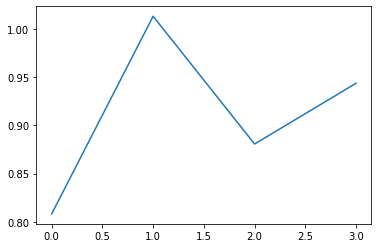

In [74]:
# Get avarage training time on each layer
def get_average_layer_train_time(epochs):

    #Loop through each layer setting it Trainable and others as non trainable
    results = []
    for i in range(len(model.layers)):

        layer_name = model.layers[i].name    #storing name of layer for printing layer

        #Setting all layers as non-Trainable
        for layer in model.layers:
            layer.trainable = False

        #Setting ith layers as trainable
        model.layers[i].trainable = True

        #Compile
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy', 'mae', 'mse', 'cosine'])
        (train_images, train_labels), _ = keras.datasets.fashion_mnist.load_data()
        train_images = train_images / 255.0

        #Fit on a small number of epochs with callback that records time for each epoch
        hist = model.fit(
            train_images,
            train_labels, 
            batch_size=200,
            epochs=5,
            callbacks=[time_callback])
            #callbacks=[LossAndErrorPrintingCallback(), time_callback])

        results.append(np.average(time_callback.times))
        #Print average of the time for each layer
        print(f"{layer_name}: Approx (avg) train time for {epochs} epochs = ", np.average(time_callback.times))
    return results

runtimes = get_average_layer_train_time(5)
plt.plot(runtimes)

In [86]:
import six
import numpy as np
import keras.backend as k
from numpy import float32
def get_activations(x, model, layer, batch_size=128):
    """
    Return the output of the specified layer for input `x`. `layer` is specified by layer index (between 0 and
    `nb_layers - 1`) or by name. The number of layers can be determined by counting the results returned by
    calling `layer_names`.
    :param x: Input for computing the activations.
    :type x: `np.ndarray`. Example: x.shape = (80, 80, 3)
    :param model: pre-trained Keras model. Including weights.
    :type model: keras.engine.sequential.Sequential. Example: model.input_shape = (None, 80, 80, 3)
    :param layer: Layer for computing the activations
    :type layer: `int` or `str`. Example: layer = 'flatten_2'
    :param batch_size: Size of batches.
    :type batch_size: `int`
    :return: The output of `layer`, where the first dimension is the batch size corresponding to `x`.
    :rtype: `np.ndarray`. Example: activations.shape = (1, 2000)
    """

    layer_names = [layer.name for layer in model.layers]
    if isinstance(layer, six.string_types):
        if layer not in layer_names:
            raise ValueError('Layer name %s is not part of the graph.' % layer)
        layer_name = layer
    elif isinstance(layer, int):
        if layer < 0 or layer >= len(layer_names):
            raise ValueError('Layer index %d is outside of range (0 to %d included).'
                             % (layer, len(layer_names) - 1))
        layer_name = layer_names[layer]
    else:
        raise TypeError('Layer must be of type `str` or `int`.')

    layer_output = model.get_layer(layer_name).output
    layer_input = model.input
    output_func = k.function([layer_input], [layer_output])

    # Apply preprocessing
    if x.shape == k.int_shape(model.input)[1:]:
        x_preproc = np.expand_dims(x, 0)
    else:
        x_preproc = x
    assert len(x_preproc.shape) == 4

    # Determine shape of expected output and prepare array
    output_shape = output_func([x_preproc[0][None, ...]])[0].shape
    activations = np.zeros((x_preproc.shape[0],) + output_shape[1:], dtype=float32)

    # Get activations with batching
    for batch_index in range(int(np.ceil(x_preproc.shape[0] / float(batch_size)))):
        begin, end = batch_index * batch_size, min((batch_index + 1) * batch_size, x_preproc.shape[0])
        activations[begin:end] = output_func([x_preproc[begin:end]])[0]

    return activations

In [87]:
for i in range(len(model.layers)):
    layer_name = model.layers[i].name
    print(layer_name)
    get_activations(train_images, model, layer_name)

flatten_19


AssertionError: 

In [99]:
# Display activations on each layer
import keras.backend as K

def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0)
    else:
        list_inputs = [model_inputs, 0]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [101]:
# Get activations of a specified layer
get_activations(model, train_images, False, 'flatten_19')

# Get activations of each layer
for i in range(len(model.layers)):
    layer_name = model.layers[i].name
    print('Layer name: ' + layer_name)
    get_activations(model, train_images, False, layer_name)

----- activations -----
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

Layer name: flatten_19
----- activations -----
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

Layer name: dense_37
----- activations -----
[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        7.4473267 7.9445424 ... 0.        0.        0.       ]
 [0.        3.4747472 3.1656585 ... 1.7330638 0.        0.       ]
 ...
 [0.        0.        4.577113  ... 5.5822363 0.        0.       ]
 [0.        2.7876508 2.3869886 ... 0.        0.        0.       ]
 [0.        0.        0.        ... 2.8613305 2.231587  0.       ]]


[array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 7.4473267, 7.9445424, ..., 0.       , 0.       ,
         0.       ],
        [0.       , 3.4747472, 3.1656585, ..., 1.7330638, 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 4.577113 , ..., 5.5822363, 0.       ,
         0.       ],
        [0.       , 2.7876508, 2.3869886, ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 2.8613305, 2.231587 ,
         0.       ]], dtype=float32)]

Layer name: dropout_19
----- activations -----
[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        7.4473267 7.9445424 ... 0.        0.        0.       ]
 [0.        3.4747472 3.1656585 ... 1.7330638 0.        0.       ]
 ...
 [0.        0.        4.577113  ... 5.5822363 0.        0.       ]
 [0.        2.7876508 2.3869886 ... 0.        0.        0.       ]
 [0.        0.        0.        ... 2.8613305 2.231587  0.       ]]


[array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 7.4473267, 7.9445424, ..., 0.       , 0.       ,
         0.       ],
        [0.       , 3.4747472, 3.1656585, ..., 1.7330638, 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 4.577113 , ..., 5.5822363, 0.       ,
         0.       ],
        [0.       , 2.7876508, 2.3869886, ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 2.8613305, 2.231587 ,
         0.       ]], dtype=float32)]

Layer name: dense_38
----- activations -----
[[1.1785205e-16 1.3346441e-16 1.5084654e-25 ... 3.5140193e-03
  3.8923500e-13 9.9643528e-01]
 [9.9930429e-01 1.7206070e-15 4.5621351e-10 ... 1.1444480e-26
  2.9663952e-11 9.1425614e-26]
 [5.7232320e-01 1.6707217e-02 8.0890972e-03 ... 2.5772706e-10
  1.5896303e-04 3.7721301e-10]
 ...
 [4.2587341e-04 1.2083277e-07 1.0388846e-05 ... 1.7002469e-17
  1.7348528e-06 6.3204283e-20]
 [8.8773769e-01 3.5849528e-04 3.7798014e-02 ... 7.4487838e-09
  2.3848754e-04 2.0944030e-10]
 [3.2653926e-09 2.4804682e-16 4.7682412e-16 ... 3.0799038e-06
  7.8907810e-08 3.3799871e-10]]


[array([[1.1785205e-16, 1.3346441e-16, 1.5084654e-25, ..., 3.5140193e-03,
         3.8923500e-13, 9.9643528e-01],
        [9.9930429e-01, 1.7206070e-15, 4.5621351e-10, ..., 1.1444480e-26,
         2.9663952e-11, 9.1425614e-26],
        [5.7232320e-01, 1.6707217e-02, 8.0890972e-03, ..., 2.5772706e-10,
         1.5896303e-04, 3.7721301e-10],
        ...,
        [4.2587341e-04, 1.2083277e-07, 1.0388846e-05, ..., 1.7002469e-17,
         1.7348528e-06, 6.3204283e-20],
        [8.8773769e-01, 3.5849528e-04, 3.7798014e-02, ..., 7.4487838e-09,
         2.3848754e-04, 2.0944030e-10],
        [3.2653926e-09, 2.4804682e-16, 4.7682412e-16, ..., 3.0799038e-06,
         7.8907810e-08, 3.3799871e-10]], dtype=float32)]

In [13]:
for i in range(len(model.layers)):
    layer_name = model.layers[i].name
    print('Layer name: ' + layer_name)
    model.layers[i].output
    
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

# Testing
test = np.random.random(input_shape)[np.newaxis,...]
layer_outs = functor([test, 1.])
print (layer_outs)

Layer name: flatten_3


<tf.Tensor 'flatten_3/Reshape:0' shape=(None, None) dtype=float32>

Layer name: dense_5


<tf.Tensor 'dense_5/Relu:0' shape=(None, 32) dtype=float32>

Layer name: dropout_3


<tf.Tensor 'dropout_3/cond/Identity:0' shape=(None, 32) dtype=float32>

Layer name: dense_6


<tf.Tensor 'dense_6/Softmax:0' shape=(None, 10) dtype=float32>

NameError: name 'input_shape' is not defined

In [53]:
for out_node in layer._outbound_nodes:
    for outbound_l in out_node.outbound_layer:
        f_tmp.write("\n\toutbound layer name: %s" % (outbound_l.name))
    f_tmp.write("\n\n")

TypeError: 'Dense' object is not iterable

In [55]:
# Get metrics of each epoch
hist.history.keys()
hist.history

dict_keys(['loss', 'accuracy', 'mae', 'mse', 'cosine'])

{'accuracy': [0.77275, 0.8329, 0.8458833, 0.85248333, 0.8571],
 'cosine': [1.2469143, 1.1100894, 1.0860432, 1.0746137, 1.06633],
 'loss': [0.6685713694572448,
  0.474108628877004,
  0.43749883944193524,
  0.4167509052435557,
  0.4003498726209005],
 'mae': [4.42, 4.4199996, 4.4199996, 4.42, 4.420001],
 'mse': [27.662937, 27.673199, 27.675728, 27.676992, 27.677906]}

In [56]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                25120     
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [35]:
_, test_acc = model.evaluate(train_images, train_labels, verbose=0)

60000/60000 [==============================] - 1s 21us/step


ValueError: too many values to unpack (expected 2)

In [15]:
print(test_acc)

0.8649166822433472


In [ ]:
# Get accuracy and loss on each node
model.layers[idx].output.get_shape()

In [ ]:
# Get accuracy and loss on each layer